# INFO-F-422 -  Statistical Foundations of Machine Learning 

### Team Data Divers
#### Robin De Haes - __[robindehaes@msn.com](mailto:robindehaes@msn.com) - Student ID 0547560__
#### Seppe Renty - __[seppe.renty@vub.be](mailto:seppe.renty@vub.be) - Student ID 0556488__
#### Dieter Vandesande - __[dieter.vandesande@vub.be](mailto:dieter.vandesande@vub.be) - Student ID 0565683__

### Video presentation: https://www.youtube.com/watch?v=C4NG_X6E9XM

## Pump it Up: Data Mining the Water Table


# Introduction


"Pump it Up: Data Mining the Water Table" is a science competition held by DrivenData. The goal of the competition is to make smart predictions about which water pumps in Tanzania are functional and which ones are faulty based on a set of water pump related features. Good predictions could lead to improved maintenance operations of the water pumps and better access to clean water for the Tanzanian communities. "Pump it Up: Data Mining the Water Table" is therefore also a clear example of how AI can be used for social good.

Taarifa, the provider of the data, is also an organization striving for social good through machine learning. Taarifa is an open source platform for crowd sourced reporting and triaging of infrastructure related issues. They are working on an Innovation Project in Tanzania and aggregated data about waterpoints from the Tanzania Ministry of Water. This aggregated, characteristic data has been made publicly available and is now used for the purpose of this competition.

In the context of the course Statistical Foundations of Machine Learning at Université libre de Bruxelles (ULB) our team Data Divers, composed of Robin De Haes, Seppe Renty and Dieter Vandesande took part in this DrivenData competition. This report will describe our approach in data preprocessing and building, assessing and ultimately choosing a predictive model that performs well on the aforementioned prediction task.

# Problem analysis

The problem consists of assigning to each provided data sample one of three labels: 
- functional;
- non functional;
- functional, but in need of repairs.

Labeled data has been provided which can be used for training the learner to be able to classify other samples in the future. We are therefore dealing with a **supervised ternary classification problem**. It's also important to notice both training and test data are available as batches and will therefore also be processed as batches.

The primary evaluation metric that is used in the competition is the **classification rate**, which is defined as $\frac{1}{N}\sum_{i=0}^{N}I(y_i-\hat{y_i})$. The classification rate, commonly called accuracy, calculates the percentage of samples for which the predicted class matches the actual class. It ranges from 0 to 1 with 0 indicating the worst possible performance, i.e. every prediction is incorrect, and 1 indicating the best possible performance, i.e. every prediction is correct. 

The competition and project assignment state the goal is to maximize this classification rate, which means they consider all misclassifications as being equally bad. Since maximizing accuracy is the goal, it is also the quality metric that will be used during model assessment and selection.

### Prior remarks
All cells are executable, but the cells concerned with hyperparameter searches tend to have very long run times.
In order to make this notebook more computationally friendly, but still verifiable we introducted the variable 
RUN_LONG_COMPUTATIONS and wrapped these hyperparameter searches in an IF-statement. Per default this variable is set to FALSE.    
All other cells will work independently of long-running computations, since the results of the searches are stored 
in RDS files (delivered with this notebook) and are read in whenever the results are needed (i.e. for plotting).  
Set this parameter to TRUE if you want to also run the long-running computations or alternatively put TRUE in the IF-statement of the cells wrapped with this variable to only run that particular cell.

In [118]:
# Set this parameter to TRUE if you want to run the long-running computations
# or alternatively put TRUE in the IF-statement of the cells wrapped with this variable to only run that particular cell.
# WARNING: Execution time of notebook could last more than a day if all long-running computations 
#         (i.e. hyperparameter searches) are re-executed.
RUN_LONG_COMPUTATIONS <- FALSE

# PART 1: Data preprocessing

### Additional libraries

In [119]:
# install (uninstalled) packages needed for data preprocessing
packages <- c("ggplot2", "scales", "naniar", "dummies")

install.packages(setdiff(packages, rownames(installed.packages())))  

In [120]:
# load libraries needed for data preprocessing
library("ggplot2")
library("scales")
library("naniar")
library("dummies")

| Library | Used for                                                                  |
|:--------|:--------------------------------------------------------------------------|
| ggplot2 | Creation of more elegant data visualizations                              |
| scales  | Scale functions used in data visualizations                               |
| naniar  | Visualizations for Missing Data|
| dummies | Creation of dummy variables for one-hot encoding of categorical variables |

### Helper functions

This is a list of general helper functions that we used throughout our feature analysis. Some of these functions are more specific, but those are explained in more detail in the appropriate sections.

In [121]:
# helper function te replace all values in a data column that are one of to_replace with the value replace_with
# mostly used to replace missing values with NA
replace <- function(data, to_replace=c(''), replace_with=NA) {
    data[data %in% to_replace] <- replace_with
    return(data)
}

# helper function to convert categorical values (i.e. factors) to a lower case representation
tolower_levels <- function(factor_data){
    for (i in colnames(factor_data)) {
            factor_data[,i] <- as.factor(tolower(as.character(factor_data[,i])))
    }
    return(factor_data)
}

# helper function to replace missing numerical values based on the given geographical information
# standard use is for the columns longitude, latitude, gps_height, population and uses the following mean values
# - the mean value of samples in the same ward
# - the mean value of samples in the same region
# - the mean value of all samples otherwise
fill_NA_with_mean_geographical_information <- function(df, 
                                                       to_fill=c('longitude', 'latitude', 'gps_height', 'population'), 
                                                       geo_info=c('ward', 'region')){

    # outer loop: go over all columns with missing values represented as NA
    for (col in to_fill) {       
        # inner loop: go over all specified columns with geographic information
        for (geo in geo_info) {
            
            # if there are still any NA values left, replace them with the mean value
            # of samples that belong to the same geographic location
            idx.col.na <- which(is.na(df[,col]))
            if (any(is.na(df[,col]))) {
                for(idx in idx.col.na) {
                    idx.geo <- df[idx, geo]
                    col.for_geo <- df[df[,geo] == idx.geo, col]
                    col.mean <- mean(col.for_geo, na.rm=TRUE)
                    df[idx, col] <- col.mean
                }
            }
        }
        
        # if there are still NA values left after using the geographical information, 
        # just replace the values by their mean value (mean over the whole column)
        df[is.na(df[,col]), col] <- mean(df[,col], na.rm=TRUE)
    }
    
    return(df)
}

# helper function to merge multiple representations of missing values in categorical data to one value
merge_levels_missing_values <- function(factor_data, 
                                        to_replace=c('', '-', '0', 'not known', 'unknown', 'none', 'no'), 
                                        replace_with='unknown'){
    for (i in colnames(factor_data)){
            factor_data[,i] <- as.character(factor_data[,i])
            factor_data[,i] <- replace(factor_data[,i], to_replace, replace_with)
            factor_data[,i] <- as.factor(factor_data[,i])
    }
    return(factor_data)
}
                  
# helper function to remove all (problematic) separators from the column names of the data
replace_separators_in_feature_names <- function(data, to_replace = c(' ','-'), replace_with = '_'){
    for (p in to_replace) {
        colnames(data) <- gsub(colnames(data), pattern = p, replacement = replace_with)
    }
    return(data)
}            

# helper function to extract parts of a data column containing date strings to new dataframe columns
extract_from_dates <- function(data, to_extract=c("%d","%m","%Y"), titles=c("day","month","year")) {
    dates <- as.Date(data)
    extracted <- setNames(data.frame(matrix(ncol = length(to_extract), nrow = length(data))), titles)
    for (i in 1:length(data)) {
        for (j in 1:length(to_extract)) {
            extracted[i,j] <- as.numeric(format(dates[i], to_extract[j]))
        }
    }
    return(extracted)
}

# helper function to create the new season feature
create_season <- function(df) {
    # extract the months from the recorded dates (but already call the column season)
    months <- extract_from_dates(df$date_recorded, to_extract=c("%m"), titles=c("season"))
    
    # get the index of each category (while the column is still numeric)
    short_dry_idx = which(months <= 2) 
    long_rains_idx = which(months >= 3 & months <= 5) 
    long_dry_idx = which(months >= 6 & months <= 10)
    short_rain_idx = which(months >= 11 & months <= 12)

    # convert to seasonal categories (makes the column a character column)
    months[short_dry_idx,] <- 'short_dry'
    months[long_rains_idx,] <- 'long_rains'
    months[long_dry_idx,] <- 'long_dry'
    months[short_rain_idx,] <- 'short_rain'
    
    # convert to factor column
    months$season <- as.factor(months$season)

    return(months)
}

# helper function to create the new pump_age feature
create_pump_age <- function(df) {
    # replace the 0 values in construction_year by NA
    replaced_construction_year <- replace(data=df$construction_year, to_replace=c(0))
    
    # extract the years from the recorded dates (but already call the column pump_age)
    dates <- extract_from_dates(df$date_recorded, to_extract=c("%Y"), titles=c("pump_age"))
    
    # compute the pump_age
    dates$pump_age <- dates$pump_age-replaced_construction_year
    
    # replace the negative values (data discrepancies) by NA to fix them later
    dates[!is.na(dates$pump_age) & dates$pump_age < 0,] <- NA
    
    return(dates)
}

# helper function to merge all categories that represent less samples 
# than the specified percentage in cutoff 
merge_low_frequency_levels <- function(df, 
                                       to_merge = c('funder', 'installer', 'lga'), 
                                       merged_level = 'other',
                                       cutoff=0.01) {
    
    for (col in to_merge) {
        # find samples with a frequency below the cutoff frequency
        counts <- as.data.frame(prop.table(table(df[,col])))
        low_freq_idx <- which(counts$Freq < cutoff)
        low_freq_level_names <- counts$Var1[low_freq_idx]
        
        # replace the value of all found samples with the merged_level value
        df[,col] <- as.character(df[,col])
        df[df[,col] %in% low_freq_level_names, col] <- merged_level
        df[,col] <- as.factor(df[,col])
    }
    
    return(df)
}

# helper function to scale the given data
# returns both the scaled data as the means and standard deviations used for scaling
# (so it can also be used to scale test data)
scale_train <- function(X){
    X_means <- lapply(X, mean, na.rm = TRUE)
    X_sdevs <- lapply(X, sd, na.rm = TRUE)
    scaled_x <- scale(X, X_means, X_sdevs)
    
    return (list("X_train"= scaled_x, "X_means" = X_means, "X_sdevs" = X_sdevs))
}

# helper function to replace missing numerical values of test data based on the given geographical information
# in training data (to avoid data leakage)
fill_NA_with_mean_geographical_information_TEST <- function(df_test, df_train,
                                                       to_fill=c('longitude', 'latitude', 'gps_height', 'population'), 
                                                       geo_info=c('ward', 'region')){

    # outer loop: go over all columns with missing values represented as NA
    for (col in to_fill) {       
        # inner loop: go over all specified columns with geographic information
        for (geo in geo_info) {
            
            # if there are still any NA values left, replace them with the mean value
            # of training samples that belong to the same geographic location
            idx.col.na <- which(is.na(df_test[,col]))
            if (any(is.na(df_test[,col]))) {
                for(idx in idx.col.na) {
                    idx.geo_train <- df_train[idx, geo]
                    col.for_geo_train <- df_train[df_train[,geo] == idx.geo_train, col]
                    col.mean_train <- mean(col.for_geo_train, na.rm=TRUE)
                    df_test[idx, col] <- col.mean_train
                }
            }
        }
        
        # if there are still NA values left after using the geographical information, 
        # just replace the values by the mean value (mean over the whole column in the training data)
        df_test[is.na(df_test[,col]), col] <- mean(df_train[,col], na.rm=TRUE)
    }
    
    return(df_test)
}

## Data Exploration

The data for this competition consists of data about Tanzanian waterpoints, aggregated by Taarifa from the Tanzanian Ministry of Water. This data is made available via CSV files, with 2 of them containing the training data (1 file with the training values and 1 file with the corresponding labels) and 1 of them containing the unlabeled test samples for which predictions have to be made.   
These CSV files are read in, after which some data cleaning will be performed. Data cleaning is needed, since missing values and noise are present as is the case with most real world data.

In [122]:
# read in the training data (values and labels) with strings being represented as factors
X_train <- read.csv(file = 'data/training_set_values.csv', stringsAsFactors= T)
Y_train <- read.csv(file = 'data/training_set_labels.csv', stringsAsFactors= T)
data_train <- cbind(X_train, subset(Y_train, select=c(status_group)))

# read in the test values
X_test <- read.csv(file = 'data/test_set_values.csv', stringsAsFactors= T)

There are 59400 training samples and 14850 test samples. We will be able to get intermediate scores on the 14850 test samples on the leaderboard, so we can consider our initial data to follow a predetermined 80-20 train-test split. Of course our training data itself will be further split up into actual training data and validation data during the model selection phase in a cross-validation setting.

Each sample has 40 features with a 41<sup>th</sup> feature in the training data which represents the label, called status group, for that sample. A quick visual inspection and readthrough of the documentation already made clear that many of these features are expected to be subfeatures or at least correlated features, e.g. extraction type, extraction type group and extraction type class. Furthermore the feature set seems to consist of 30 categorical variables and 10 numerical variables.

|      | # samples | # features |
|:---------|:----------|:------------|
| **Training data** | 59400     | 41         |
| **Test data**     | 14850     | 40         |

All further data exploration from this point on was only performed on the training data to prevent any unwanted data leakage.

## Class balance

The target feature status_group is *categorical*, with 3 possible values:
- functional;
- functional needs repairs;
- non functional.

These categories seem to be *somewhat ordinal* in nature. It is possible to order the categories in terms of functionality, i.e. non functional < functional needs repairs < functional, which could make it interesting to actually represent these categories by numerical values. If an algorithm can learn this order it could actually be beneficial. Nevertheless, most of our models were built with the status group being handled as a categorical feature.

As a next step it is important to check the class balance or imbalance present in the data.

In [123]:
# colors used to represent the functional (green), functional needs repairs (orange) and non functional classes (red)
group_colors <- c("#73A657","#C98932","#ED2939")     

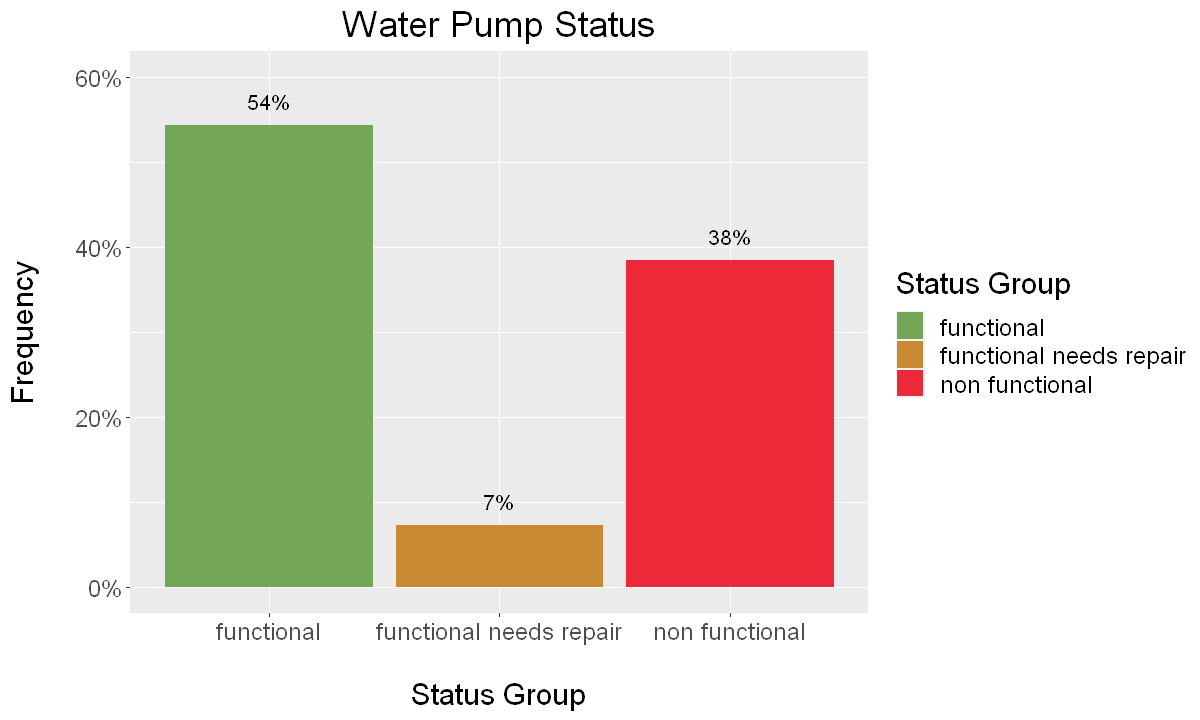

In [124]:
# plot the status group class balance
options(repr.plot.width=10, repr.plot.height=6)   
ggplot(Y_train, aes(x = status_group, fill=status_group)) +
  geom_bar(aes(y = (..count..)/sum(..count..))) +
  geom_text(aes(y = ((..count..)/sum(..count..)), 
                label = scales::percent((..count..)/sum(..count..))), 
            stat = "count", vjust = -1,
            size = 4.5) +
  scale_y_continuous(labels = percent, limits = c(0, 0.60)) +
  scale_fill_manual("Status Group", values=group_colors) +
  labs(title = "Water Pump Status", y = "Frequency\n", x = "\nStatus Group") +
  theme(plot.title = element_text(hjust = 0.5),
        text = element_text(size=18))

Class imbalance is clearly present in the training data. Especially the status group "functional needs repair" is much less present than the other two classes. 

|                     | Functional | Functional Needs Repair | Non Functional | Total |
|:---------------------|:------------:|:-------------------------:|:----------------:|:-------:|
| **Number of samples**   | 32259      | 4317                    | 22824          | 59400 |
| **Relative proportion** | 54.3%      | 7.3%                    | 38.4%          | 100%  |

However, the distribution of classes in the training set and test set should be similar which means the test set is expected to be equally imbalanced. Therefore, compensations for class imbalance will have a smaller effect on the final accuracy, since the degree of correct predictions in the imbalanced training data should be representative for the degree of correct predictions in the imbalanced population. So even though accuracy is not that trustworthy in highly imbalanced cases, mostly because correctly predicting the minority class might be rare, it doesn't matter for the goal we're trying to achieve which is simply maximizing the general accuracy. 

Nevertheless it might still be a good idea to try out a stratified train-validation split where possible and to perhaps check the effects of over- and undersampling or penalizing incorrect predictions on the minority class(es).

## Feature Analysis

**Categorical features**  
Some categorical features have a very high number of categories and will probably either need some regrouping to reduce this number or are just redundant.

In general there also seems to be a lot of input mistakes and multiple representations for missing values. This is why we already performed two actions before the feature analysis presented below:
1. convert all categorical values to lowercase to remove input errors solely related to character casing;
2. merge different missing value categorical representations to a single one, which is 'unknown'.

The missing value representations that we detected and merged were the following ones:
- A true missing value, i.e. the empty character ''
- The separator '-'
- A zero '0'
- The value 'not known'
- The value 'unknown'
- The value 'none'
- The value 'no'

Possibly some of the missing values are also categorized under 'other' or 'others', which we were able to deduce by comparing missing values with 'other' values between clearly related features. However, we did not consider it enough evidence to currently see the 'other' and 'others' values as truly missing data and kept them separate.

**Numerical features**  
For numerical features all missing values seem to be represented by a zero. This makes detecting missing values more difficult since zero could also be a valid entry in some cases. There is therefore no general detection mechanism available that can be used on all numerical features, so it should be checked and reasoned about feature per feature.

In [125]:
# split numerical and categorical features
factor_feature_names <- which(sapply(X_train[1,], class) == "factor")
factor_features <- X_train[, factor_feature_names]
numerical_features <- X_train[, -factor_feature_names]

# make all levels lowercase
factor_features <- tolower_levels(factor_features)

# merge the different levels for missing value representation
factor_features <- merge_levels_missing_values(factor_features, 
                                               to_replace=c('', '-', '0', 'none', 'no', 'not known'), 
                                               replace_with='unknown')

# combine all features again to one dataframe (including the status_group as 41th feature)
features <- cbind(factor_features, numerical_features, Y_train)

### Immediately dropped

The feature **id** is an identifier feature and therefore unique per sample.  
The feature **recorded_by** is described as "Group entering this row of data" and is a constant feature with the value 'Geodata Consultants Ltd'.   
The feature **num_private** has no description and 99% of its values are zero, so it's either nearly constant or completely filled with missing values.  
The feature **wpt_name** is described as "Name of the waterpoint if there is one". Around two third of the waterpoints have a unique name.

These features are all uninformative at first sight and are therefore dropped without further investigation.

### Amount_tsh

The feature amount_tsh is described as "Total static head (amount water available to waterpoint)".

According to Milnes (2010) static  head is  the difference in
"elevation between the surface of the reservoir and the point of discharge into the receiving tank". This means a value of zero for a water pump is rather unlikely, since no pumping action is needed if the reservoir and discharge point are at the same height. Therefore, it seems safe to assume these zeroes are actually missing values.

In that case, however, two thirds of all values of amount_tsh are missing values -so *41639 samples with a missing amount\_tsh value* to be exact- which makes this feature not very usable. Therefore, this feature will be dropped. 

### Date_recorded & Construction_year

The feature construction_year is described as "Year the waterpoint was constructed".  
The feature date_recorded was is described as "The date the row was entered".

A third of the construction year's values are zero values which in this case are clearly representing missing values. Furthermore, there are some discrepancies between the construction_year values and the date_recorded values since some records were supposedly created before the construction of the pump. This is a clear case of faulty data. Some of these mistakes can be fixed by checking for other records for the same waterpoint or location that have realistic values for these fields. In most cases, however, there did not seem to be an easy way to determine which one of them was actually incorrect.

The date a sample was recorded seems rather unimportant as-is. It does allow us to infer that most of the data samples were recorded between 2011 and 2013 with some samples dating back to as early as 2002. It could potentially explain some outliers since unexpected events in particular periods could have created special circumstances that influenced the data. However, we did not find such data.

Both these features were eventually dropped and replaced by 2 engineered features that were deemed more informative. These features are season and pump_age. More information about these new features is given in the section "Feature engineering".

| Min        | 1st Quartile | Median     | Mean       | 3rd Quartile | Max        |
|:-----------:|:------------:|:----------:|:------------:|:---------:|:---------:|
| 14/10/2002 | 01/04/2011   | 10/10/2012 | 29/03/2012 | 09/02/2013   | 03/12/2013 |
*date_recorded*

| Min        | 1st Quartile | Median     | Mean       | 3rd Quartile | Max        |
|:-----------:|:------------:|:----------:|:------------:|:---------:|:---------:|
| 1960       | 1996         | 2000       | 1998       | 2004         | 2013       |
*construction_year*

### Funder & Installer

The feature funder is described as "Who funded the well".  
The feature installer is described as "Organization that installed the well".

Both funder and installer have a high amount of unique categorical values, with respectively *1898 and 2146 unique values*. The increase in dimensionality these would cause when using one-hot encoding would be computationally and perhaps even predictively deleterious.

One of the causes for this high amount of unique values are plain spelling mistakes (e.g. 'women fo partnership' and 'women for partnership') and inconsistent naming (e.g. 'village government' and 'village govt'). Furthermore, there are a lot of levels that consist of just 1 character. Without further domain knowledge it is very hard to determine if these character names have meaning or are just missing data as well.

Presumably the best way to deal with these levels would have been to manually identify possible "binning categories" and perhaps perform some sort of search on level names to put each sample in one of these categories. There are immediately some  possible bins detectable such as "Tanzanian government" for anything containing the strings government/govt/..., "Foreign government" for anything containing german/usa/japan/..., "Community",...

However, this approach would have taken up too much time and is outside of the scope of this project. This is why we decided to maintain a *cutoff threshold* instead to group levels that have a frequency below this threshold (i.e. 1% of total training samples) together into the level 'other'. As can be shown in the graphs below there are some categories with a lot more samples than others and these categories also have a relevant relation with the target feature. This cutoff approach therefore seems like a valid option. The approach is further described in the section "Feature Engineering".

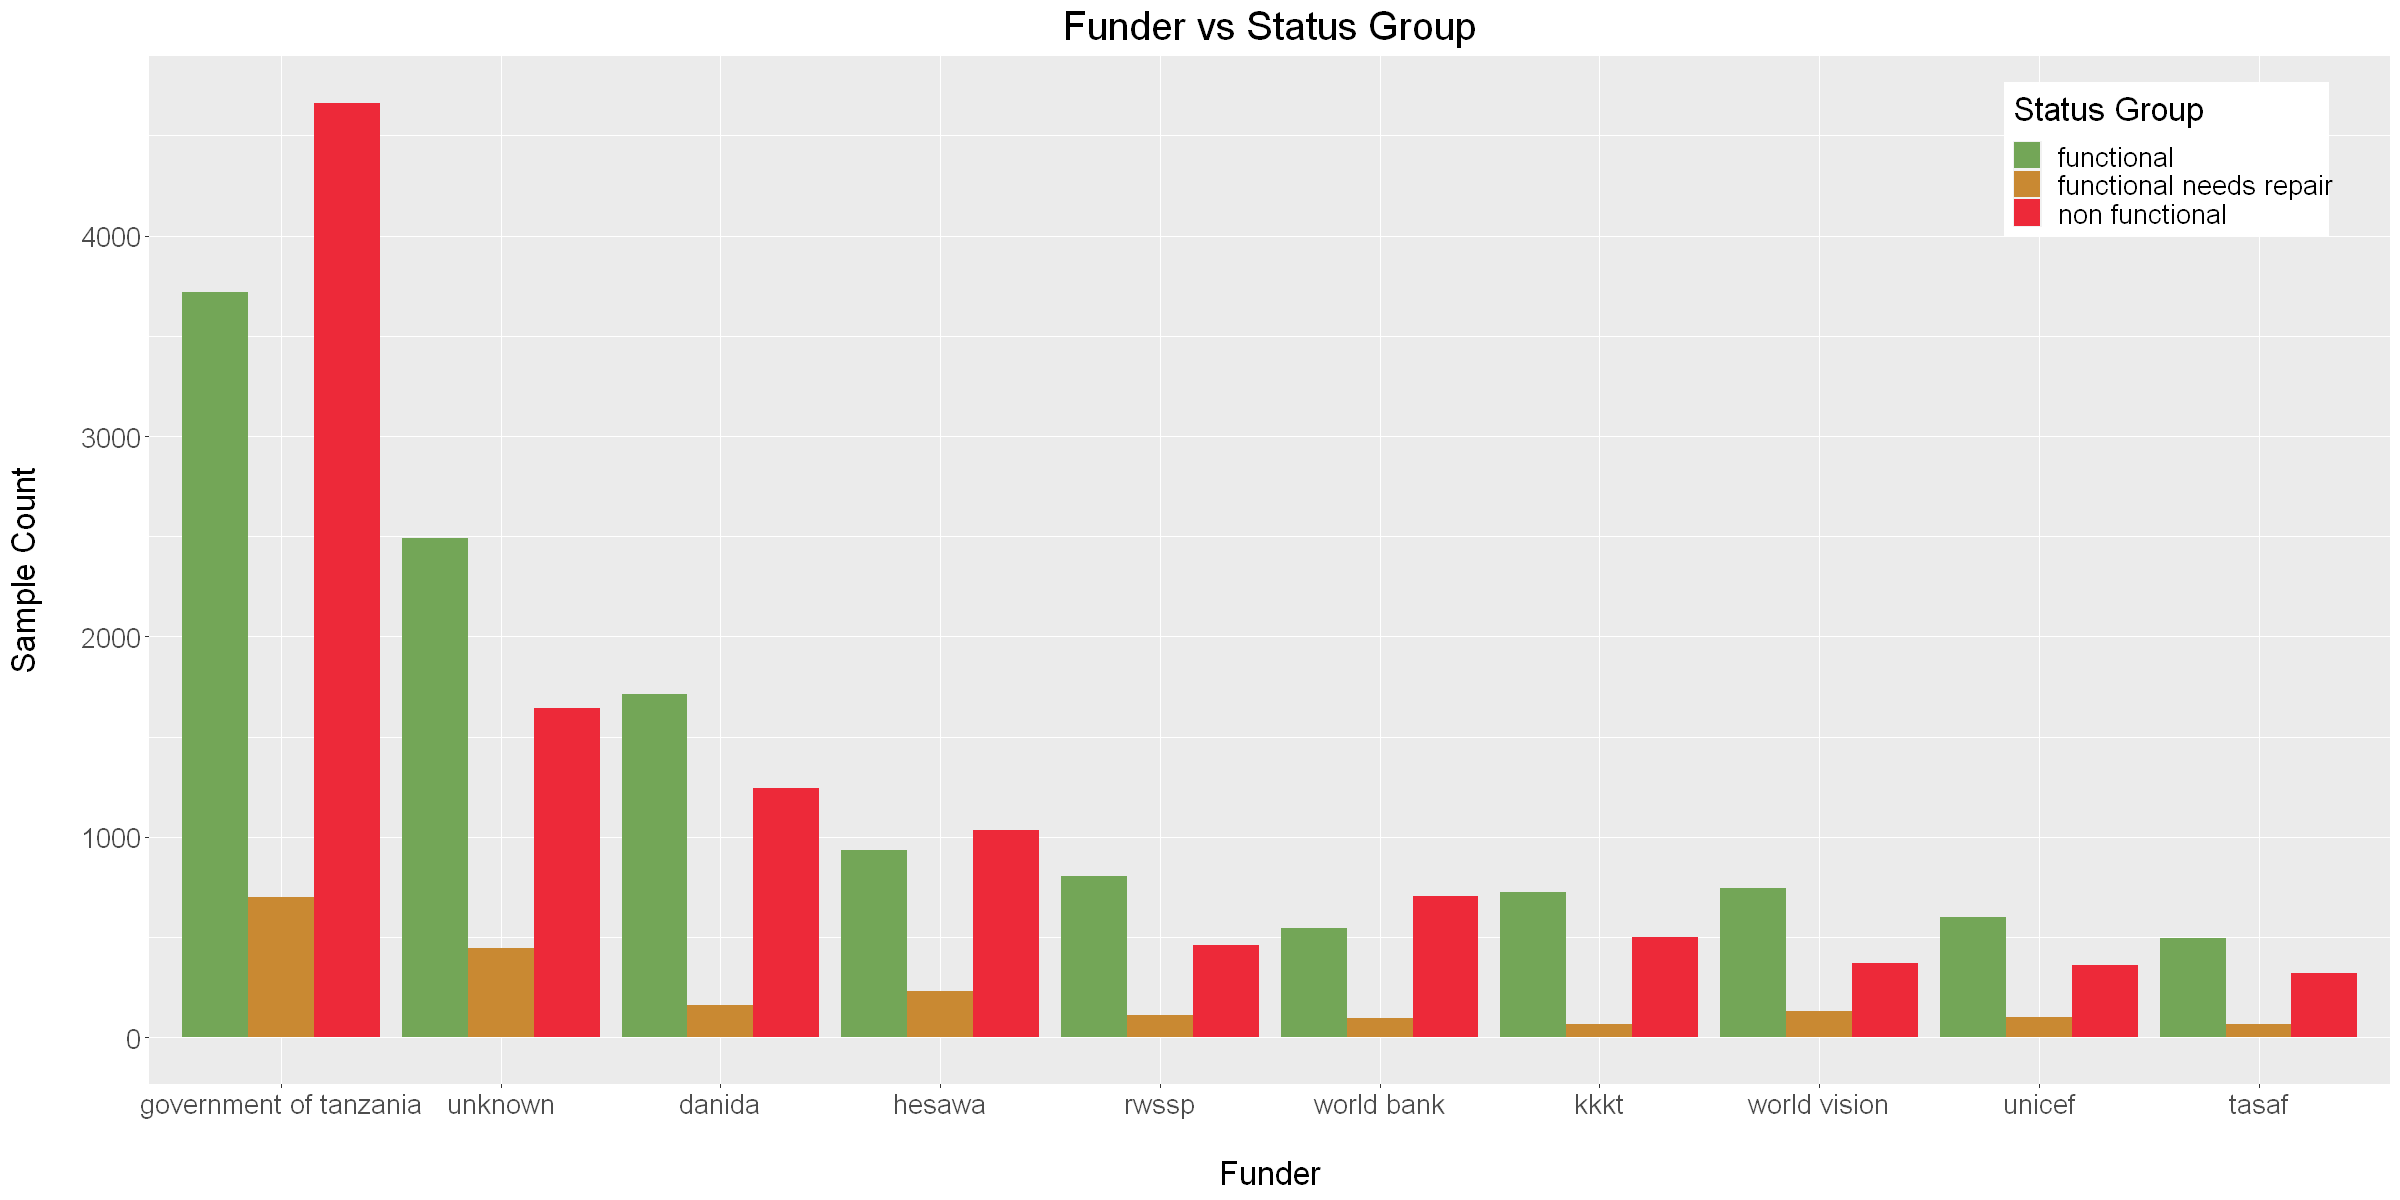

In [126]:
options(repr.plot.width=20, repr.plot.height=10)   

# get top 10 (based on frequency) of funders
reordered_funder <- with(features, reorder(funder, funder, function(x) -length(x)))
features_with_top_funder <- features[features$funder %in% levels(reordered_funder)[1:10],] 

# plot top 10 of funders
to_plot <- subset(features_with_top_funder, select = c(funder, status_group)) 
to_plot$funder <- with(to_plot, reorder(funder, funder, function(x) -length(x)))
ggplot(to_plot, aes(x = funder, fill=status_group)) +
      geom_bar(position= "dodge") +
      scale_fill_manual("Status Group", values=group_colors) +
      labs(title = "Funder vs Status Group", y = "Sample Count\n", x = "\nFunder") +
      theme(plot.title = element_text(hjust = 0.5),
            text = element_text(size=20), 
            legend.position = c(0.9, 0.9))

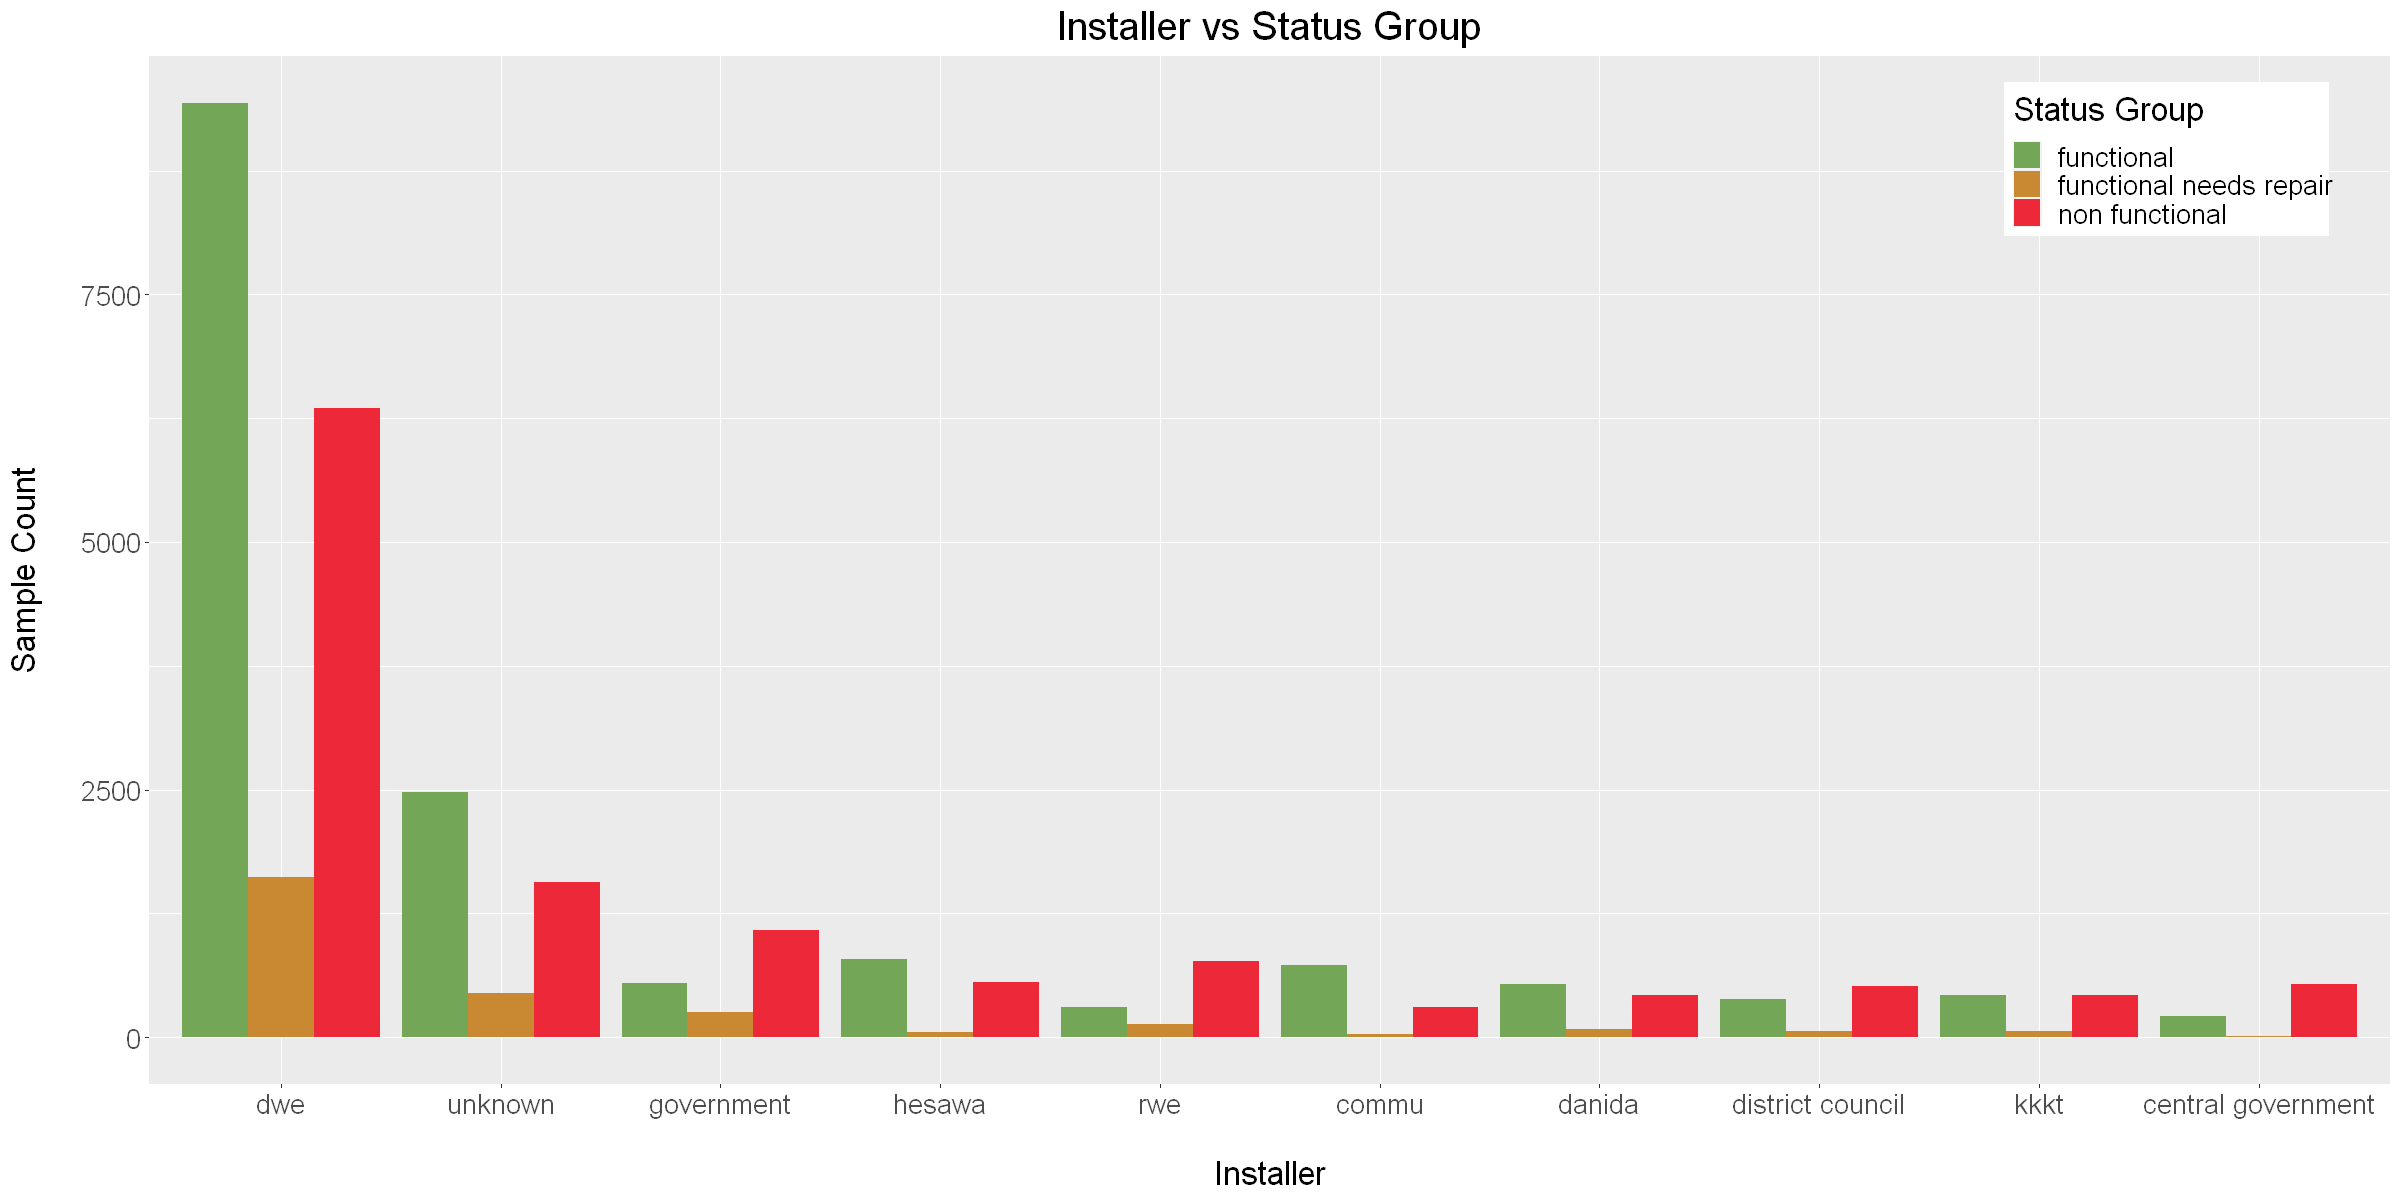

In [127]:
options(repr.plot.width=20, repr.plot.height=10)  

# get top 10 (based on frequency) of installers
reordered_installer <- with(features, reorder(installer, installer, function(x) -length(x))) 
features_with_top_installer <- features[features$installer %in% levels(reordered_installer)[1:10],]  
   
# plot top 10 of installers                                              
to_plot <- subset(features_with_top_installer, select = c(installer, status_group)) 
to_plot$installer <- with(to_plot, reorder(installer, installer, function(x) -length(x)))                                         
ggplot(to_plot, aes(x = installer, fill=status_group)) +
      geom_bar(position= "dodge") +
      scale_fill_manual("Status Group", values=group_colors) +
      labs(title = "Installer vs Status Group", y = "Sample Count\n", x = "\nInstaller") +
      theme(plot.title = element_text(hjust = 0.5),
            text = element_text(size=20), 
            legend.position = c(0.9, 0.9))

### Geographic data 

There are multiple features for geographic information available. Some of them are categorical and some of them are numerical in nature.

| Feature       | Description                 | Feature Type |
|:---------------|:-----------------------------|:--------------|
| longitude     | GPS coordinate              | numerical    |
| latitude      | GPS coordinate              | numerical    |
| basin         | Geographic water basin      | categorical  |
| subvillage    | Geographic location         | categorical  |
| region        | Geographic location         | categorical  |
| region_code   | Geographic location (coded) | numerical    |
| district_code | Geographic location (coded) | numerical    |
| lga           | Geographic location         | categorical  |
| ward          | Geographic location         | categorical  |

There is a clear level of granularity present in this geographic data. From more specific to more general we can order the available geographic information as follows (National Bureau of Statistics, 2012):
1. GPS coordinates (longitude, latitude)
2. Subvillage
3. Ward
4. Local Government Authority (lga)
5. Districts (district_code)
6. Region (region/region_code) / Water basin (basin)

**Longitude & Latitude**  
Longitude has multiple zero entries, but these locations are all ouside of Tanzania. Furthermore, the latitude value for that sample is always a random small number as well. Therefore, it seems safe to consider these samples to have *missing values for both their longitude and latitude features*. Since there is plenty of other geographic information available, we imputed them using a localized mean based on the available geographic information. More information of this process can be found in the "Missing Value Imputation" section.

The boxplots are based on the data after imputation. Although there is quite a bit of overlap of the different boxplots, there is still some difference visible between some of the status groups so the features might still have a significant influence considering our large sample size.

In [128]:
# impute NA with mean geographical information
features[features$longitude == 0,'latitude'] <- NA
features[features$longitude == 0,'longitude'] <- NA
features <- fill_NA_with_mean_geographical_information(features, 
                                                       to_fill=c('longitude','latitude'), 
                                                       geo_info=c('ward', 'region'))

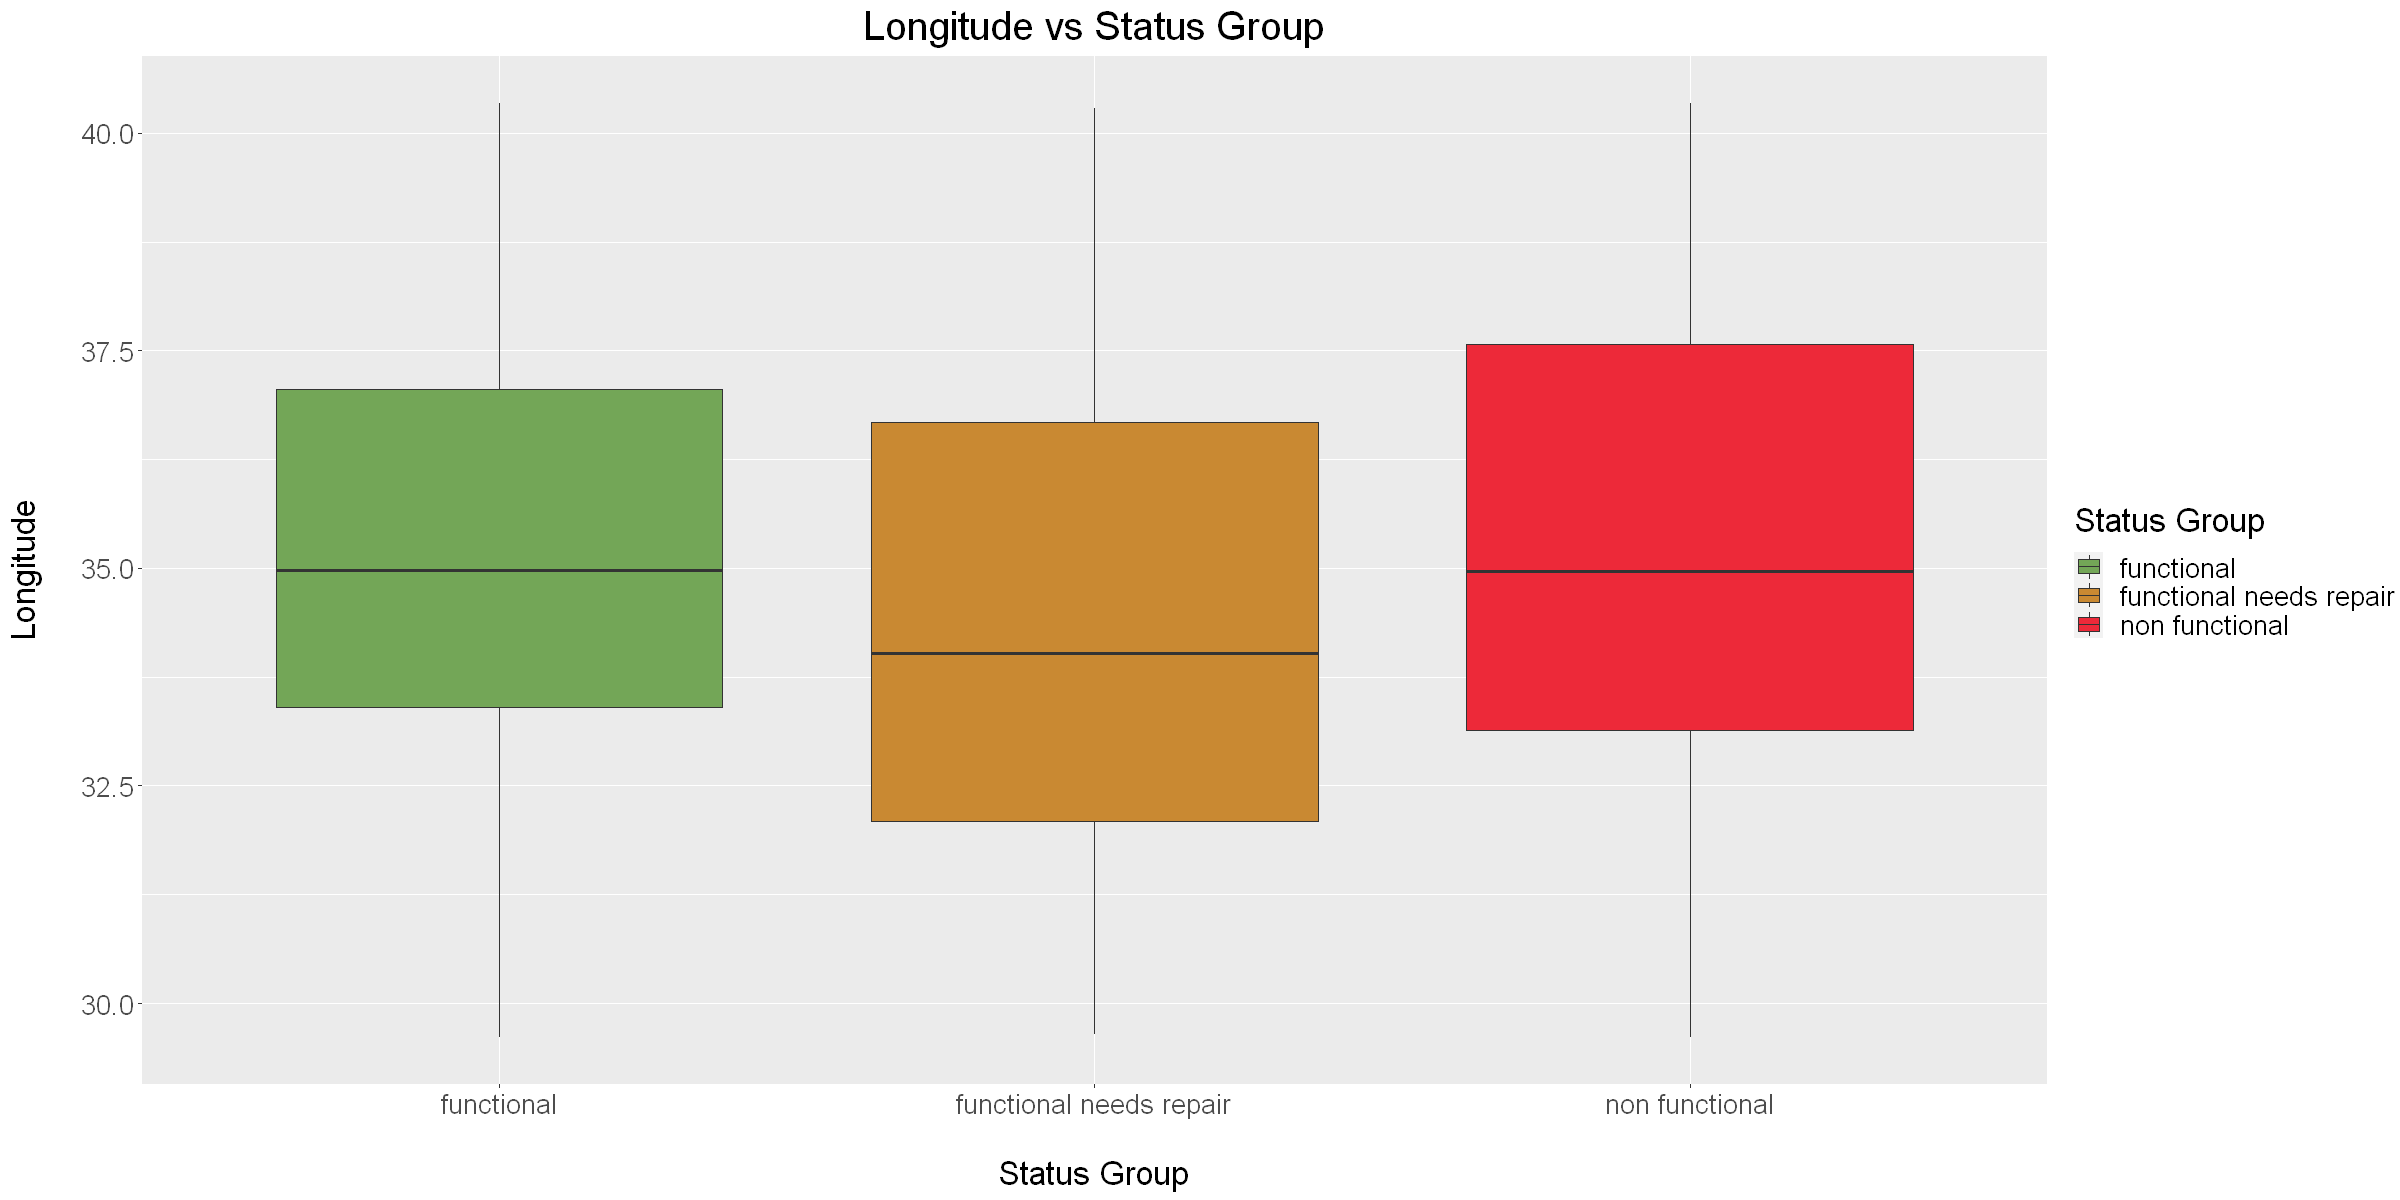

In [129]:
# plot longitude vs status group boxplots
options(repr.plot.width=20, repr.plot.height=10)
to_plot <- subset(features, select = c(status_group, longitude))
ggplot(to_plot, aes(x = status_group, y=longitude, fill = status_group)) + 
       geom_boxplot() +
       scale_fill_manual("Status Group", values=group_colors) +
       labs(title = "Longitude vs Status Group", y = "Longitude\n", x = "\nStatus Group") +
       theme(plot.title = element_text(hjust = 0.5),
             text = element_text(size=20))

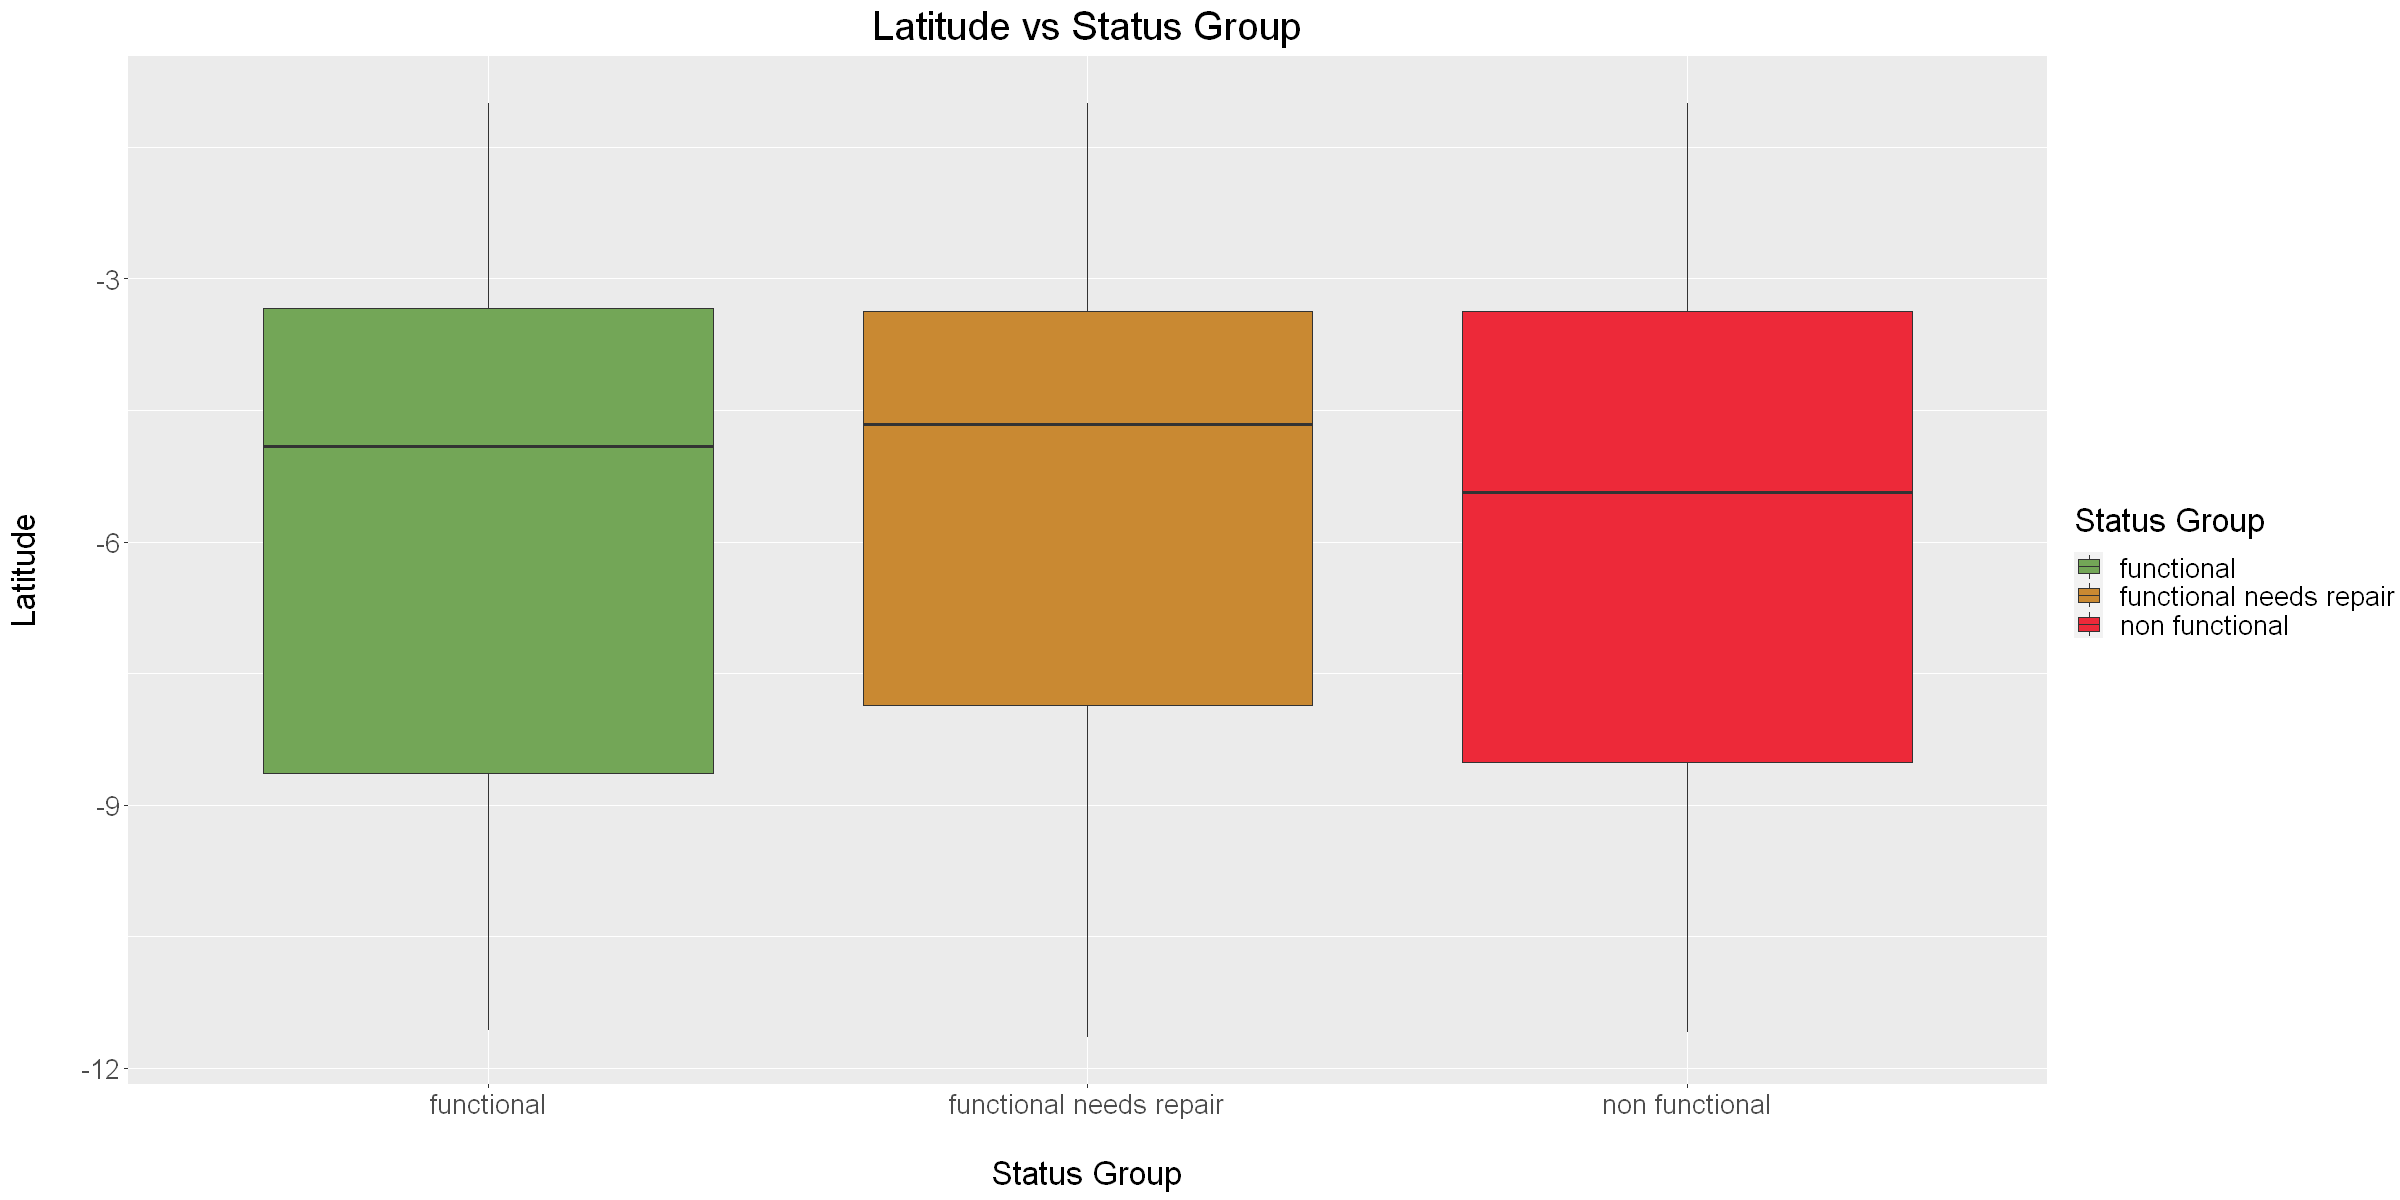

In [130]:
# plot latitude vs status group boxplots
options(repr.plot.width=20, repr.plot.height=10)
to_plot <- subset(features, select = c(status_group, latitude))
ggplot(to_plot, aes(x = status_group, y=latitude, fill = status_group)) + 
       geom_boxplot() +
       scale_fill_manual("Status Group", values=group_colors) +
       labs(title = "Latitude vs Status Group", y = "Latitude\n", x = "\nStatus Group") +
       theme(plot.title = element_text(hjust = 0.5),
             text = element_text(size=20))

**Subvillage & Ward**  
The features subvillage and ward have respectively 19288 and 2092 unique categorical values. After careful consideration this level of detail was deemed too high, so both features were dropped. Nevertheless, they can still be helpful for imputing missing values in other data. 

**Local Government Authority & District Code**  
Local Government Authority seems to mostly consist of local councils that govern smaller areas inside districts. Often, but not always, they seem to correspond to districts. (Shadrack, 2010) 

Based on this information, it could be that lga won't give much information if we already know region and district_code. However, since we lack some domain knowledge to really know what an LGA is in Tanzania and the graph below seems to show a relation with the target feature, we  decided to keep both lga and district_code. Automatic feature ranking (and selection) will deal with the decision of whether both are important.

It's also important to note that district_code currently is seen as numerical but represents unordered categories, i.e. district 20 should not be seen as "better" or higher than district 19. Therefore, district_code should be converted to categorical data.

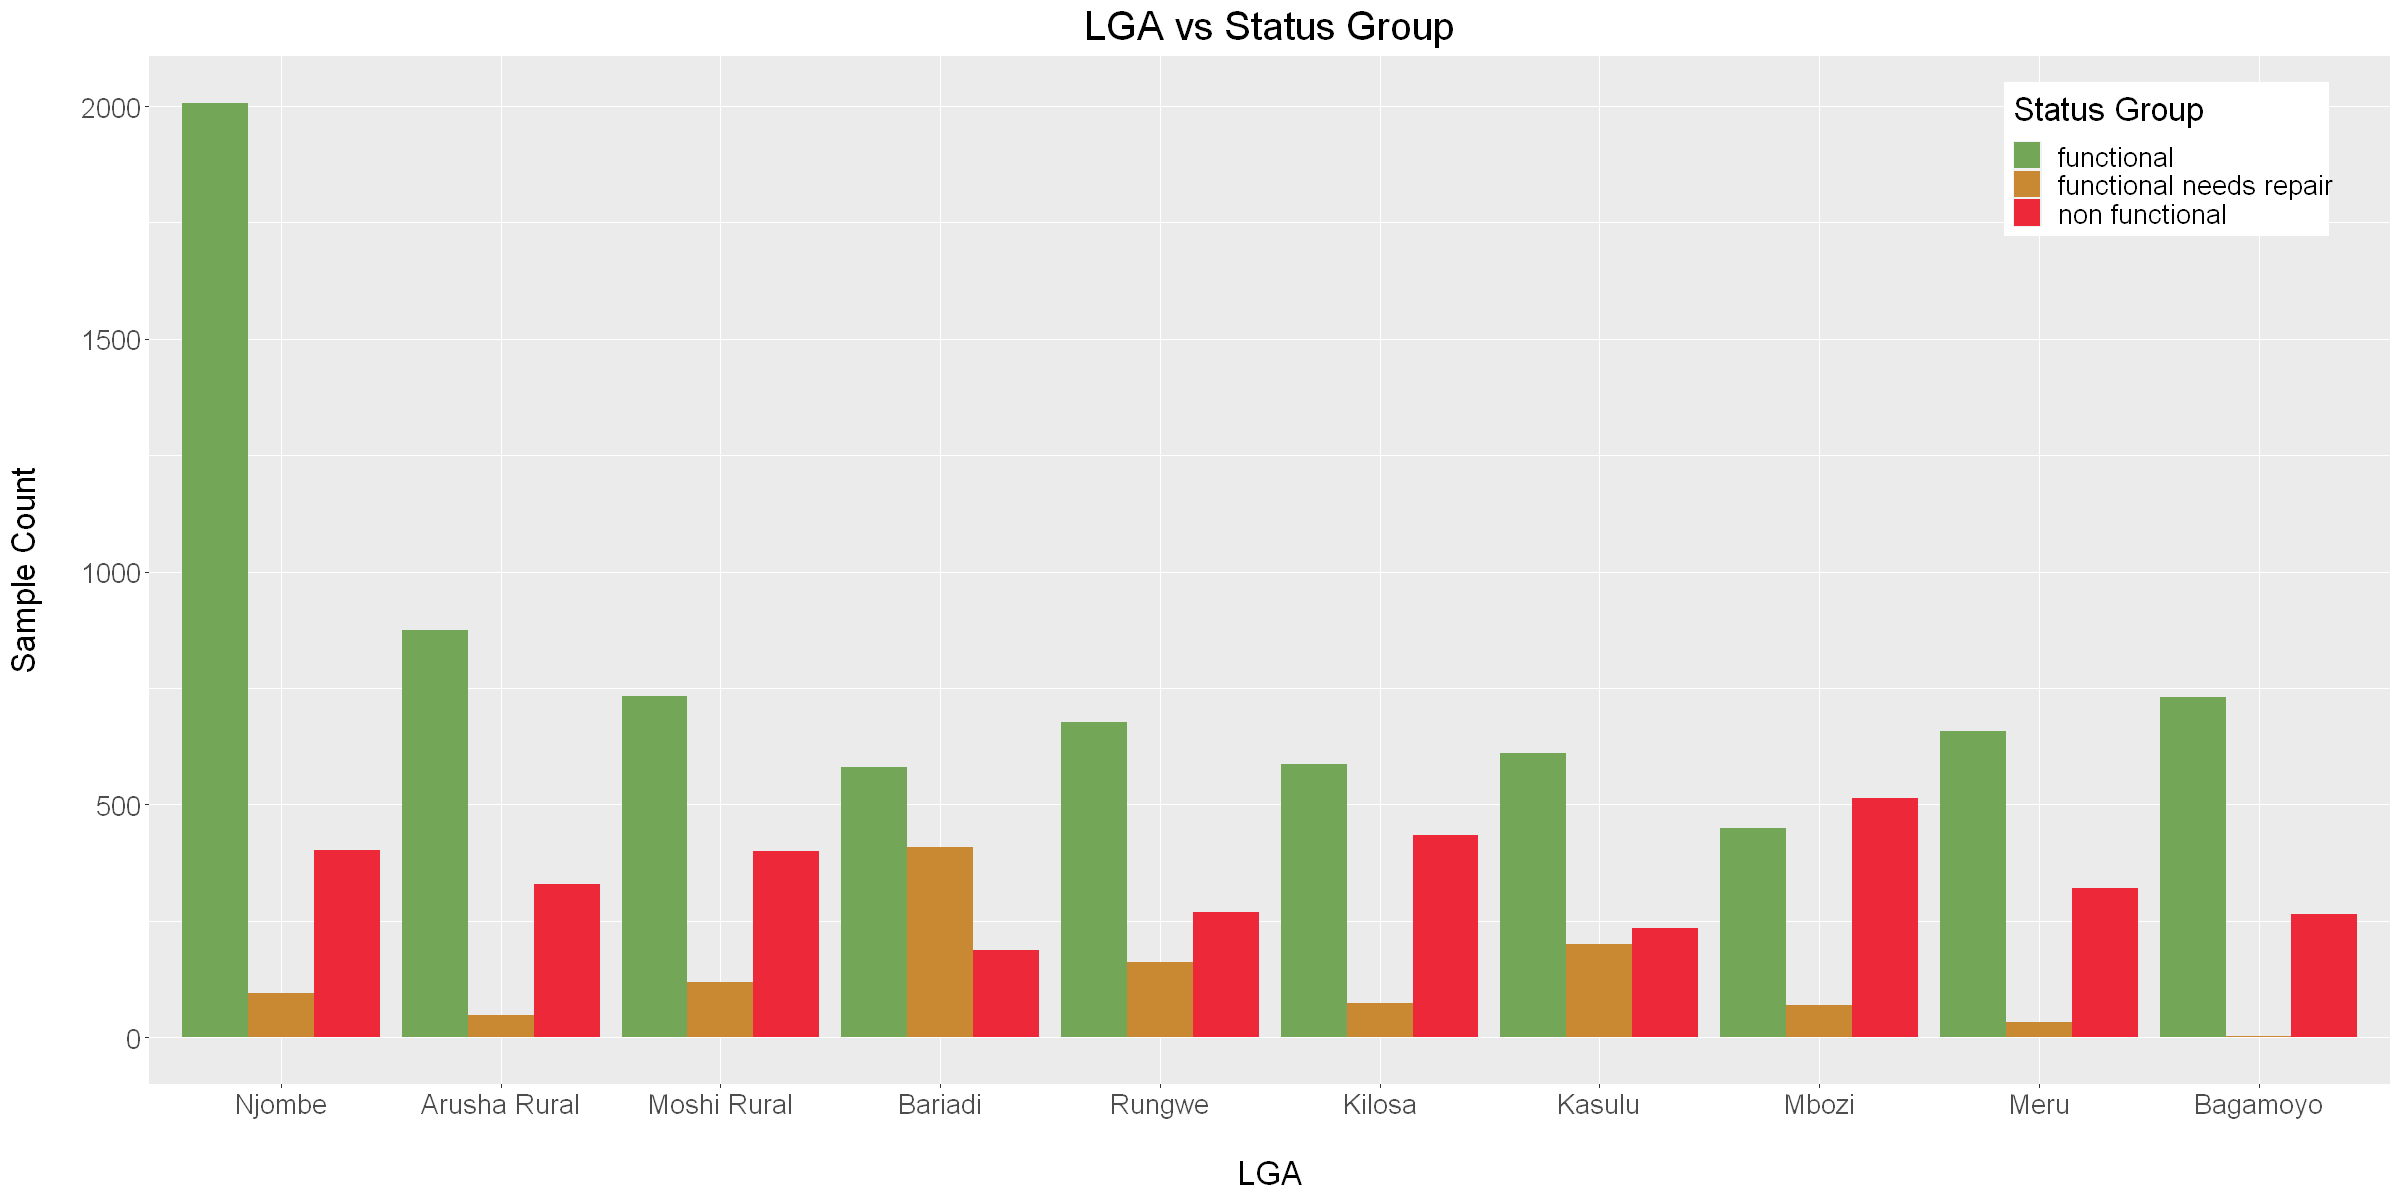

In [131]:
# get top 10 (based on frequency) of lga
reordered_lga <- with(data_train, reorder(lga, lga, function(x) -length(x)))
features_with_top_lga <- data_train[data_train$lga %in% levels(reordered_lga)[1:10],] 

# plot top 10 of lga
options(repr.plot.width=20, repr.plot.height=10)
to_plot <- subset(features_with_top_lga, select = c(lga, status_group)) 
to_plot$lga <- with(to_plot, reorder(lga, lga, function(x) -length(x)))                                         
ggplot(to_plot, aes(x = lga, fill=status_group)) +
      geom_bar(position= "dodge") +
      scale_fill_manual("Status Group", values=group_colors) +
      labs(title = "LGA vs Status Group", y = "Sample Count\n", x = "\nLGA") +
      theme(plot.title = element_text(hjust = 0.5),
            text = element_text(size=20), 
            legend.position = c(0.9, 0.9))                                          

**Region & Basin**  
There is, as expected, a one-on-one correspondence between region and region_code. Therefore, the feature region_code was dropped.

Multiple regions can have access to the same water basin, but there is not really a clear ordering in geographic granularity between the two. They are different types of geographic indications. Based on the graphs below, it is clear however that there are more differences between regions than between basins when it comes to the level of functionality of their water pumps. Region therefore seems to be more informative, but for now both will be kept and automatic feature selection will later decide if both should be kept.

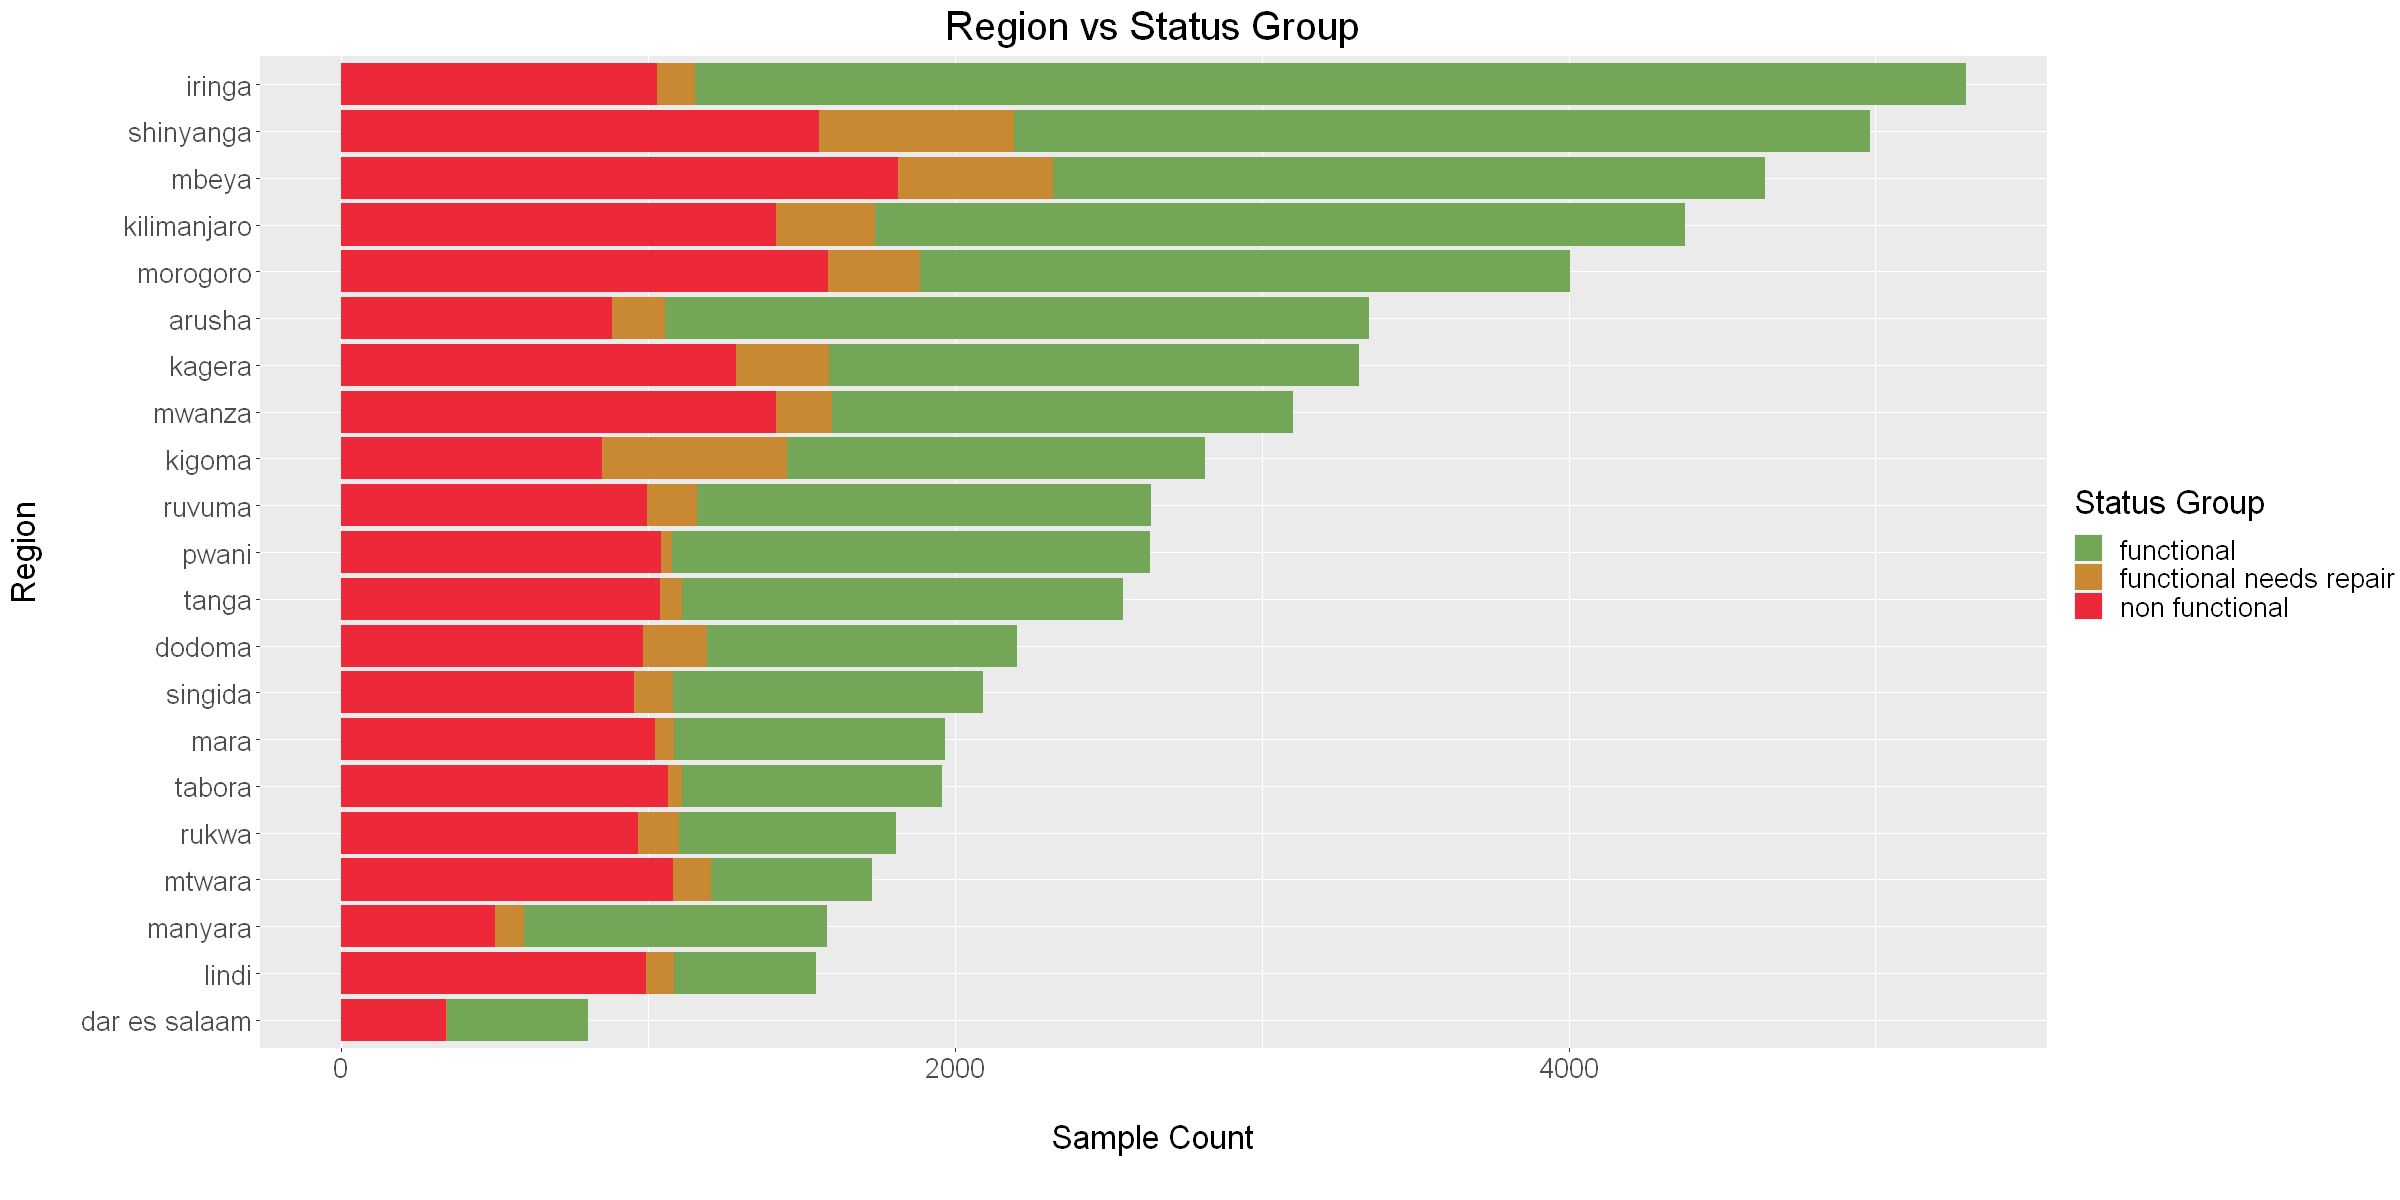

In [132]:
# plot status group given region
options(repr.plot.width=20, repr.plot.height=10)
to_plot <- subset(features, select = c(region, status_group)) 
to_plot$region <- with(to_plot, reorder(region, region, function(x) length(x)))                                         
ggplot(to_plot, aes(x = region, fill=status_group)) +
      geom_bar() +
      scale_fill_manual("Status Group", values=group_colors) +
      labs(title = "Region vs Status Group", y = "\nSample Count\n", x = "Region\n") +
      theme(plot.title = element_text(hjust = 0.5),
            text = element_text(size=20)) +
      coord_flip()

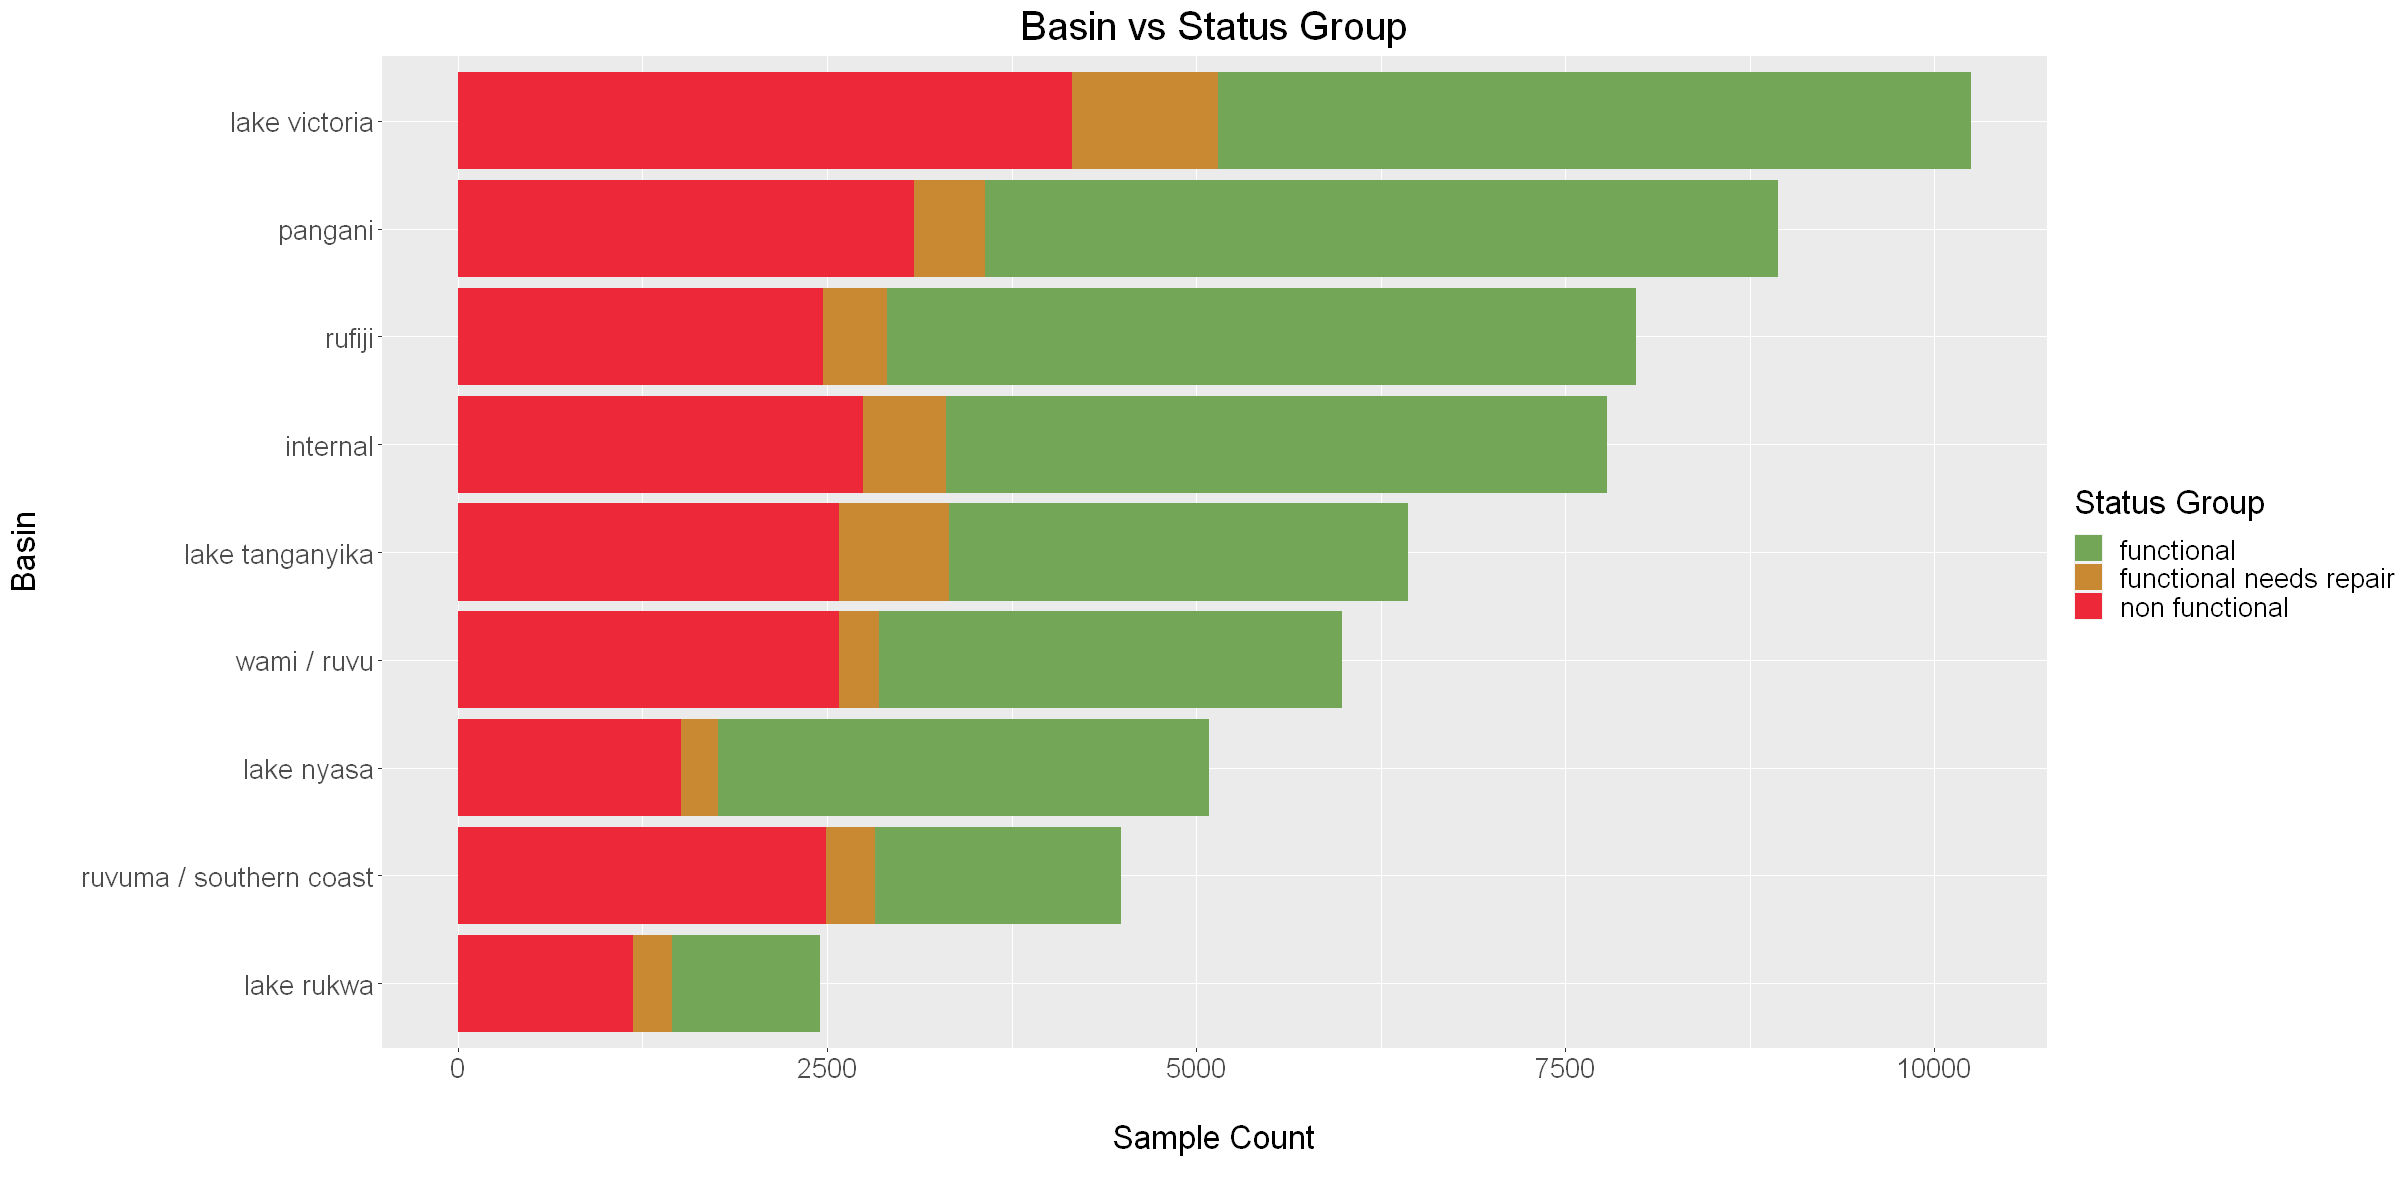

In [133]:
# plot status group given basin
options(repr.plot.width=20, repr.plot.height=10)
to_plot <- subset(features, select = c(basin, status_group)) 
to_plot$basin <- with(to_plot, reorder(basin, basin, function(x) length(x)))                                         
ggplot(to_plot, aes(x = basin, fill=status_group)) +
      geom_bar() +
      scale_fill_manual("Status Group", values=group_colors) +
      labs(title = "Basin vs Status Group", y = "\nSample Count\n", x = "Basin\n") +
      theme(plot.title = element_text(hjust = 0.5),
            text = element_text(size=20)) +
      coord_flip()

### Gps_height

The feature gps_height is described as "Altitude of the well". 

Around a third of the observations are zero values, which in theory might be valid values. However, in line with the other findings in our data and the locations of these wells the zero values are more likely to be missing values. If we consider zeroes to be missing values around one third of the values seems to be missing. As was the case for longitude/latitude, these missing values will be imputed based on the available geographic information. More information about this computation process can be found in the section about "Missing Value Imputation". 

The table and boxplot below are based on the data after imputation. Although there is quite a bit of overlap of the different boxplots, there is still some difference visible between some of the status groups so the features might still have a significant influence considering our large sample size.

|                   | Min        | 1st Quartile | Median     | Mean       | 3rd Quartile | Max        |
|:-------------------:|:------------:|:--------------:|:------------:|:------------:|:--------------:|:------------:|
| **gps_height**     | -90 | 626   | 1110 | 1014 | 1340   | 2770 |

In [134]:
features[features$gps_height == 0,'gps_height'] <- NA
features <- fill_NA_with_mean_geographical_information(features, to_fill=c('gps_height'), geo_info=c('ward', 'region'))

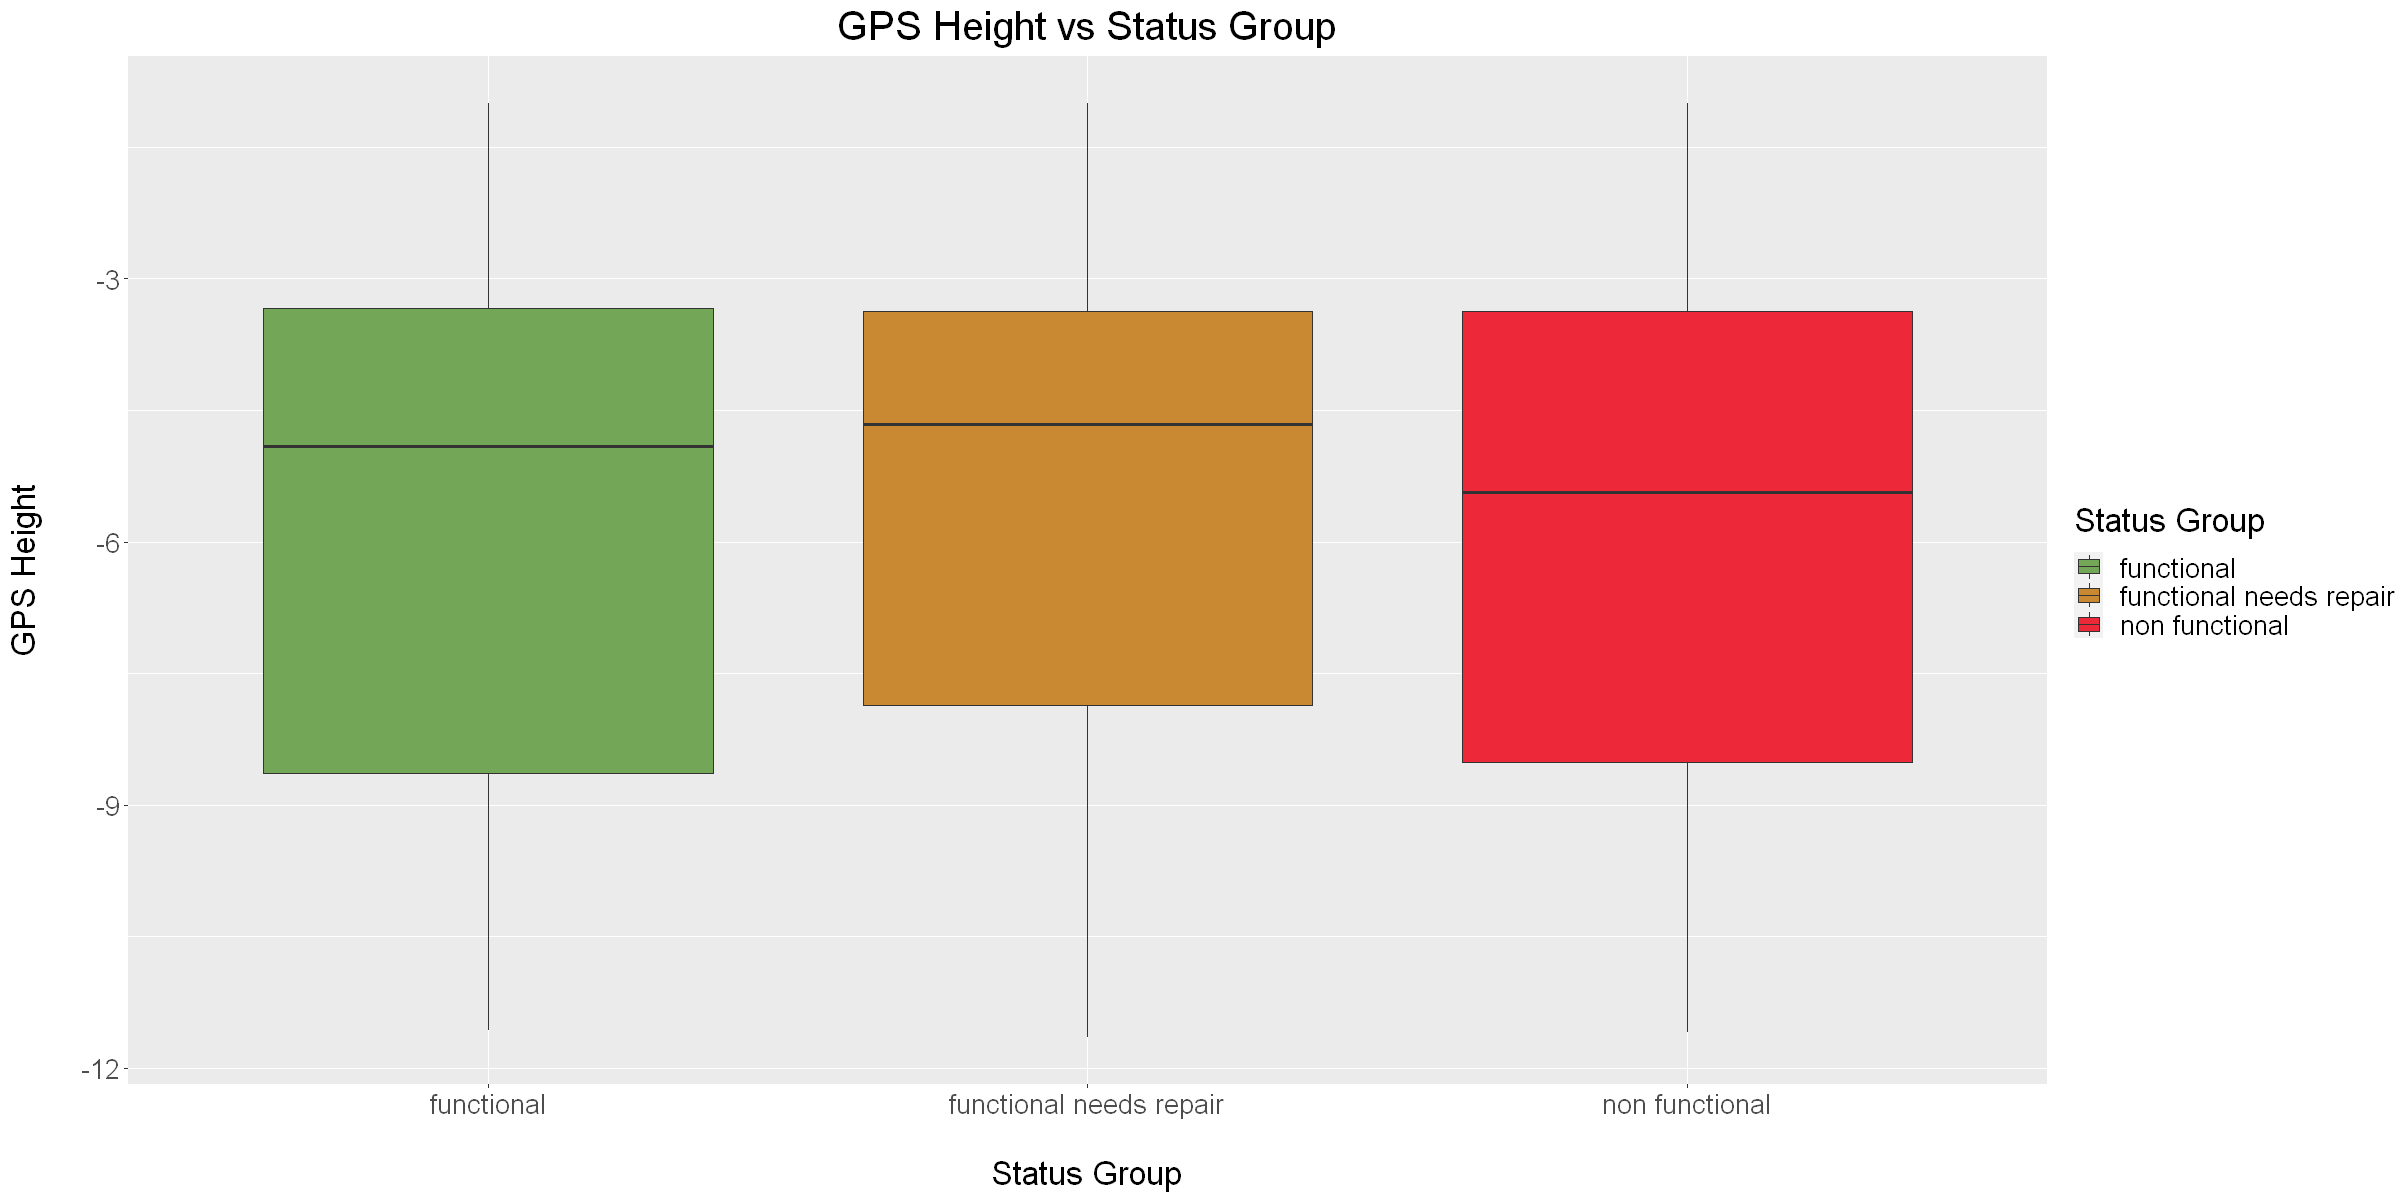

In [135]:
# plot gps_height vs status_group boxplots
options(repr.plot.width=20, repr.plot.height=10)
to_plot <- subset(features, select = c(status_group, latitude))
ggplot(to_plot, aes(x = status_group, y=latitude, fill = status_group)) + 
       geom_boxplot() +
       scale_fill_manual("Status Group", values=group_colors) +
       labs(title = "GPS Height vs Status Group", y = "GPS Height\n", x = "\nStatus Group") +
       theme(plot.title = element_text(hjust = 0.5),
             text = element_text(size=20))

### Population

The feature population is described as "Population around the well", which is not really detailed and makes it rather hard to determine whether 0 values are missing values. The fact that some other values are rather low as well (e.g. 1 or 2,...) makes this distinction even harder. However, according to Kyeshi (2005), communal standpipes should generally be no further than 200 metres from residential houses. Since communal standpipes have a lot of zero values as well, this makes it more likely that these zero values are missing values.

Therefore, we will consider these zero values to be missing values and perform the same geographic mean imputation as before. This imputation was already performed for the table and boxplots below.

What is immediately clear from the boxplots is that there is quite a large amount of outliers in this data. However, we decided not to remove these values as Tanzania has both rural and urban areas which makes these outliers plausible (National Bureau of Statistics, 2012).

|                   | Min        | 1st Quartile | Median     | Mean       | 3rd Quartile | Max        |
|:-------------------:|:------------:|:--------------:|:------------:|:------------:|:--------------:|:------------:|
| **population**     | 1 | 96   | 276 | 314 | 400   | 30500 |

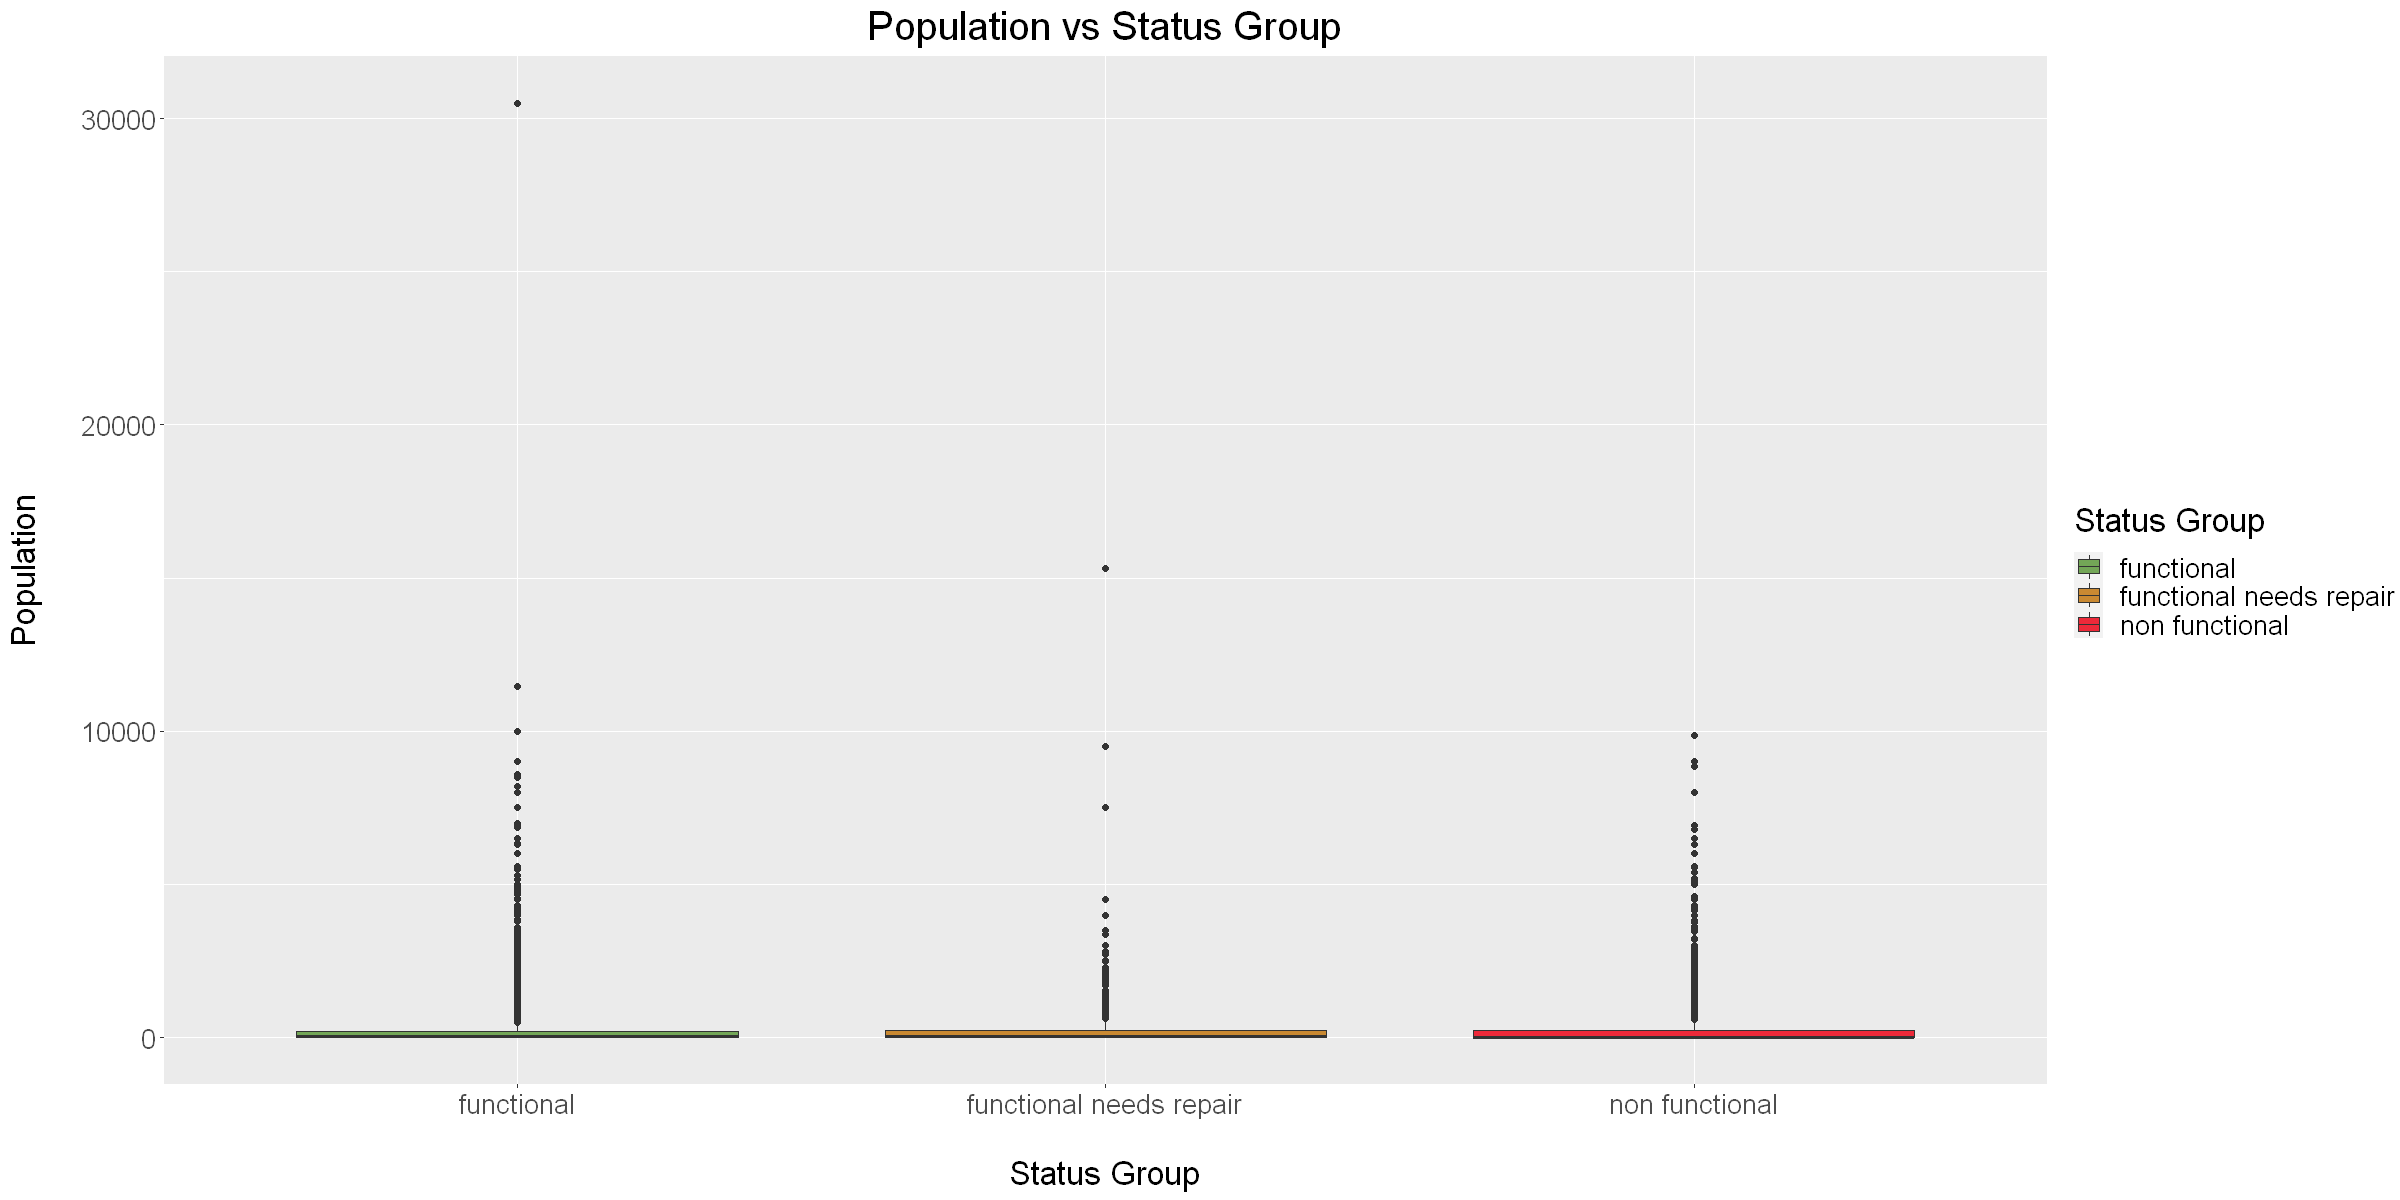

In [136]:
# plot population vs status group boxplots
options(repr.plot.width=20, repr.plot.height=10)
to_plot <- subset(features, select = c(status_group, population))
ggplot(to_plot, aes(x = status_group, y = population, fill = status_group)) + 
       geom_boxplot() +
       scale_fill_manual("Status Group", values=group_colors) +
       labs(title = "Population vs Status Group", y = "Population\n", x = "\nStatus Group") +
       theme(plot.title = element_text(hjust = 0.5),
             text = element_text(size=20))

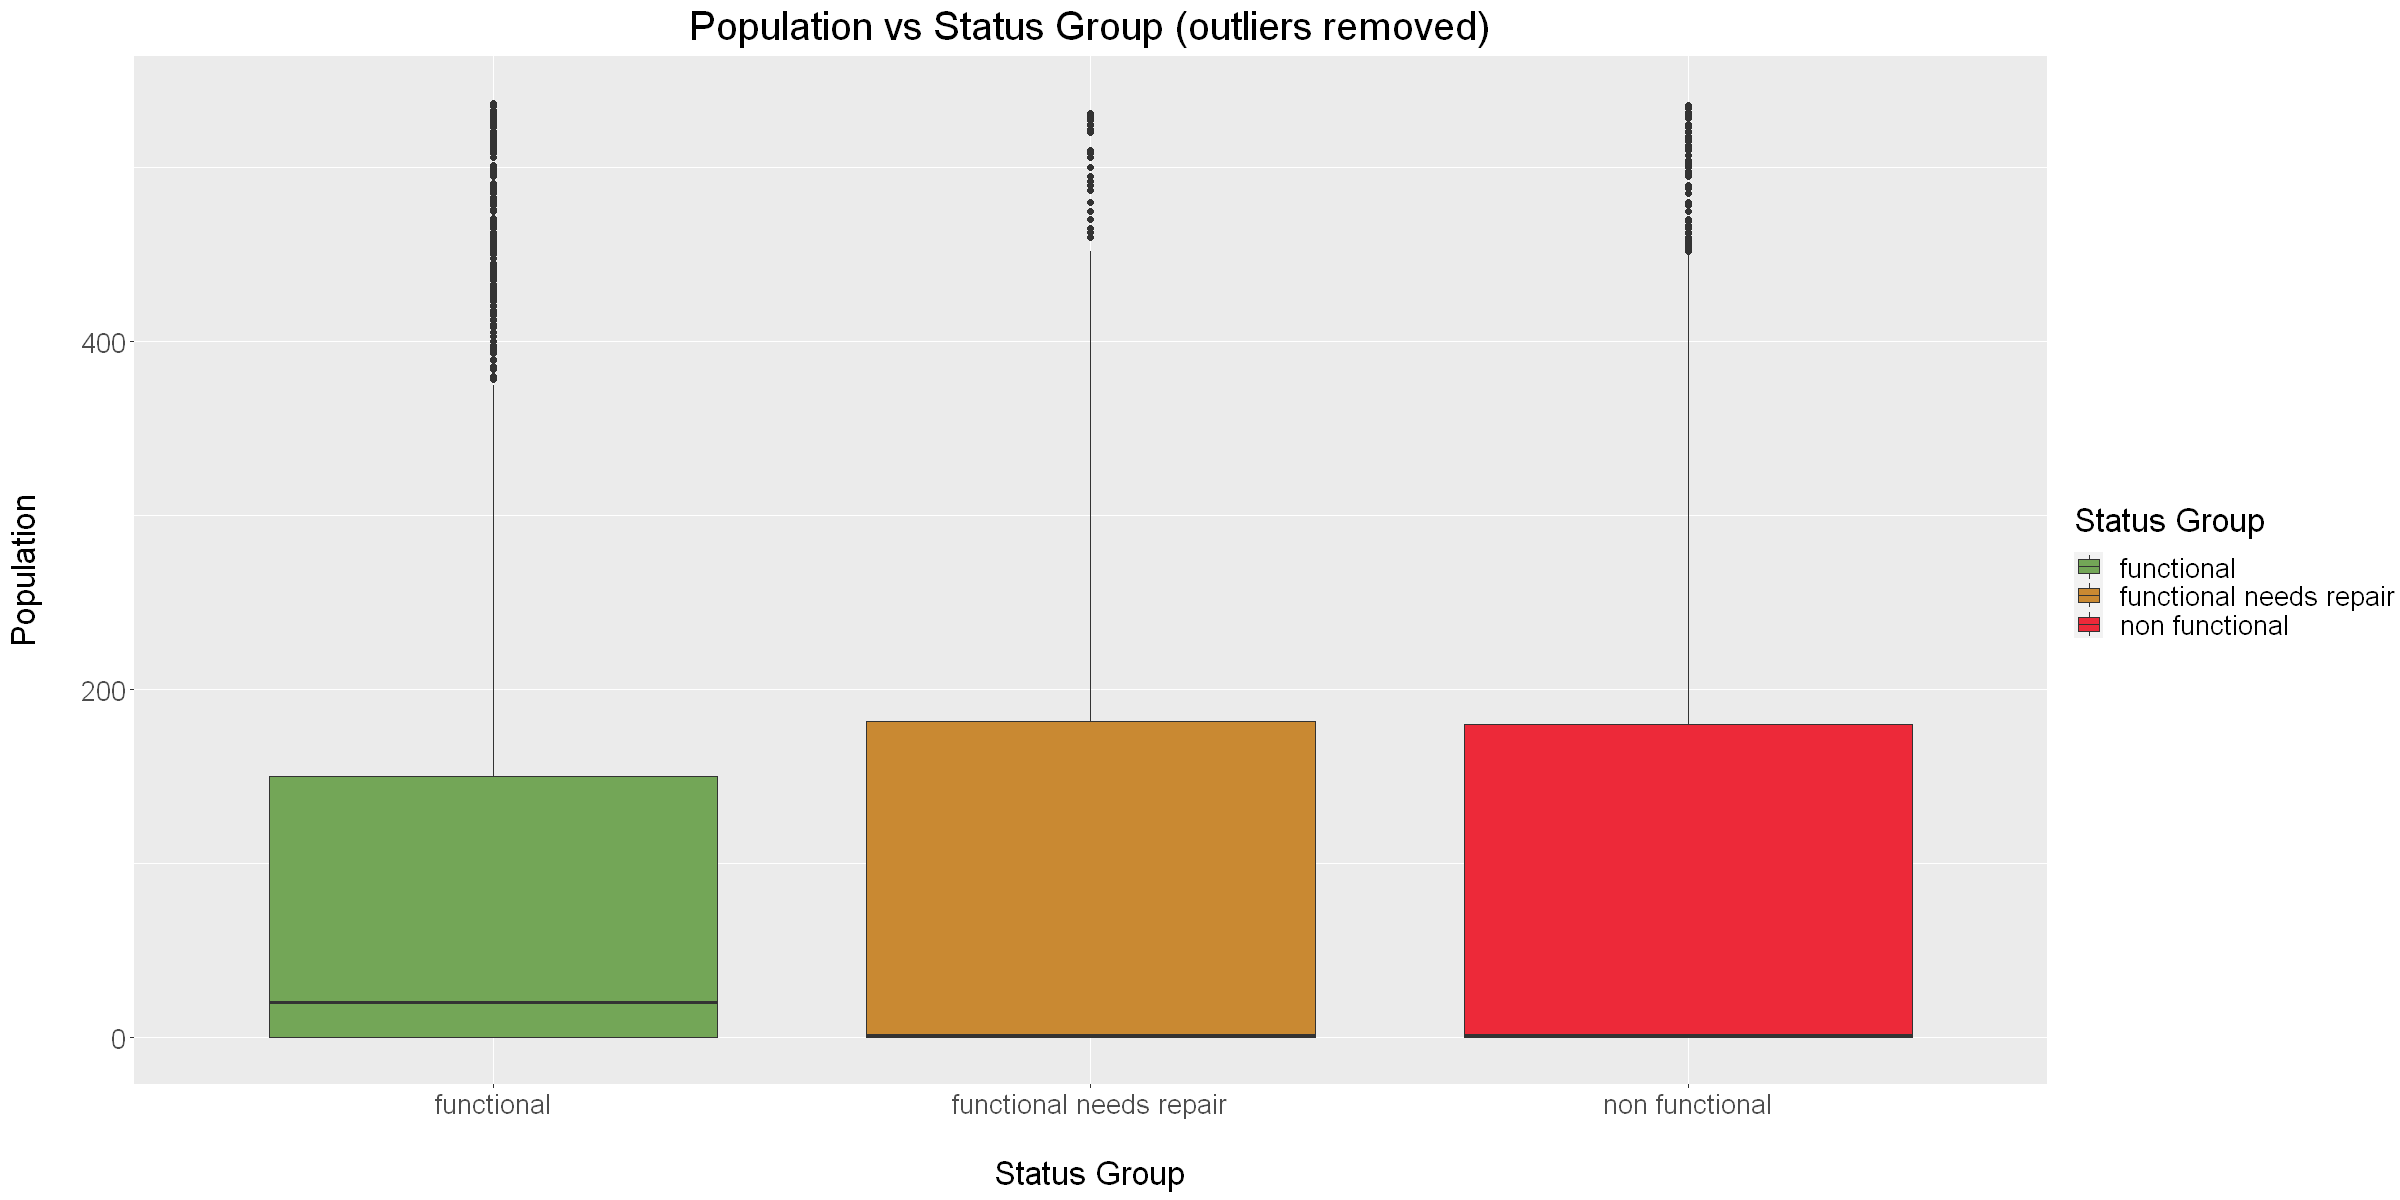

In [137]:
# remove outliers from population feature for clearer plotting
Q <- quantile(features$population, probs=c(.25, .75), na.rm = FALSE)
iqr <- IQR(features$population)
outliers_removed <- subset(features, features$population > (Q[1] - 1.5*iqr) & features$population < (Q[2]+1.5*iqr))

# plot population vs status group boxplots (without outliers)
options(repr.plot.width=20, repr.plot.height=10)
to_plot <- subset(outliers_removed, select = c(status_group, population))
ggplot(to_plot, aes(x = status_group, y = population, fill = status_group)) + 
       geom_boxplot() +
       scale_fill_manual("Status Group", values=group_colors) +
       labs(title = "Population vs Status Group (outliers removed)", y = "Population\n", x = "\nStatus Group") +
       theme(plot.title = element_text(hjust = 0.5),
             text = element_text(size=20))

## Public_meeting & Permit

The feature permit is described as "If the waterpoint is permitted" and public_meeting has no description but is assumed to indicate whether the water pump is the result of a decision from a public meeting or perhaps whether it is located at a public meeting place. 

Both of these are categorical data which represent boolean values. However, both are also dealing with some unknown values.
The majority of samples have a value of TRUE for both, but the unknown values' distribution clearly differs from this most common value -especially for public_meeting- so we did not add it to that group. Since the amount of unknown values is also not small, we decided to keep it as a third category.

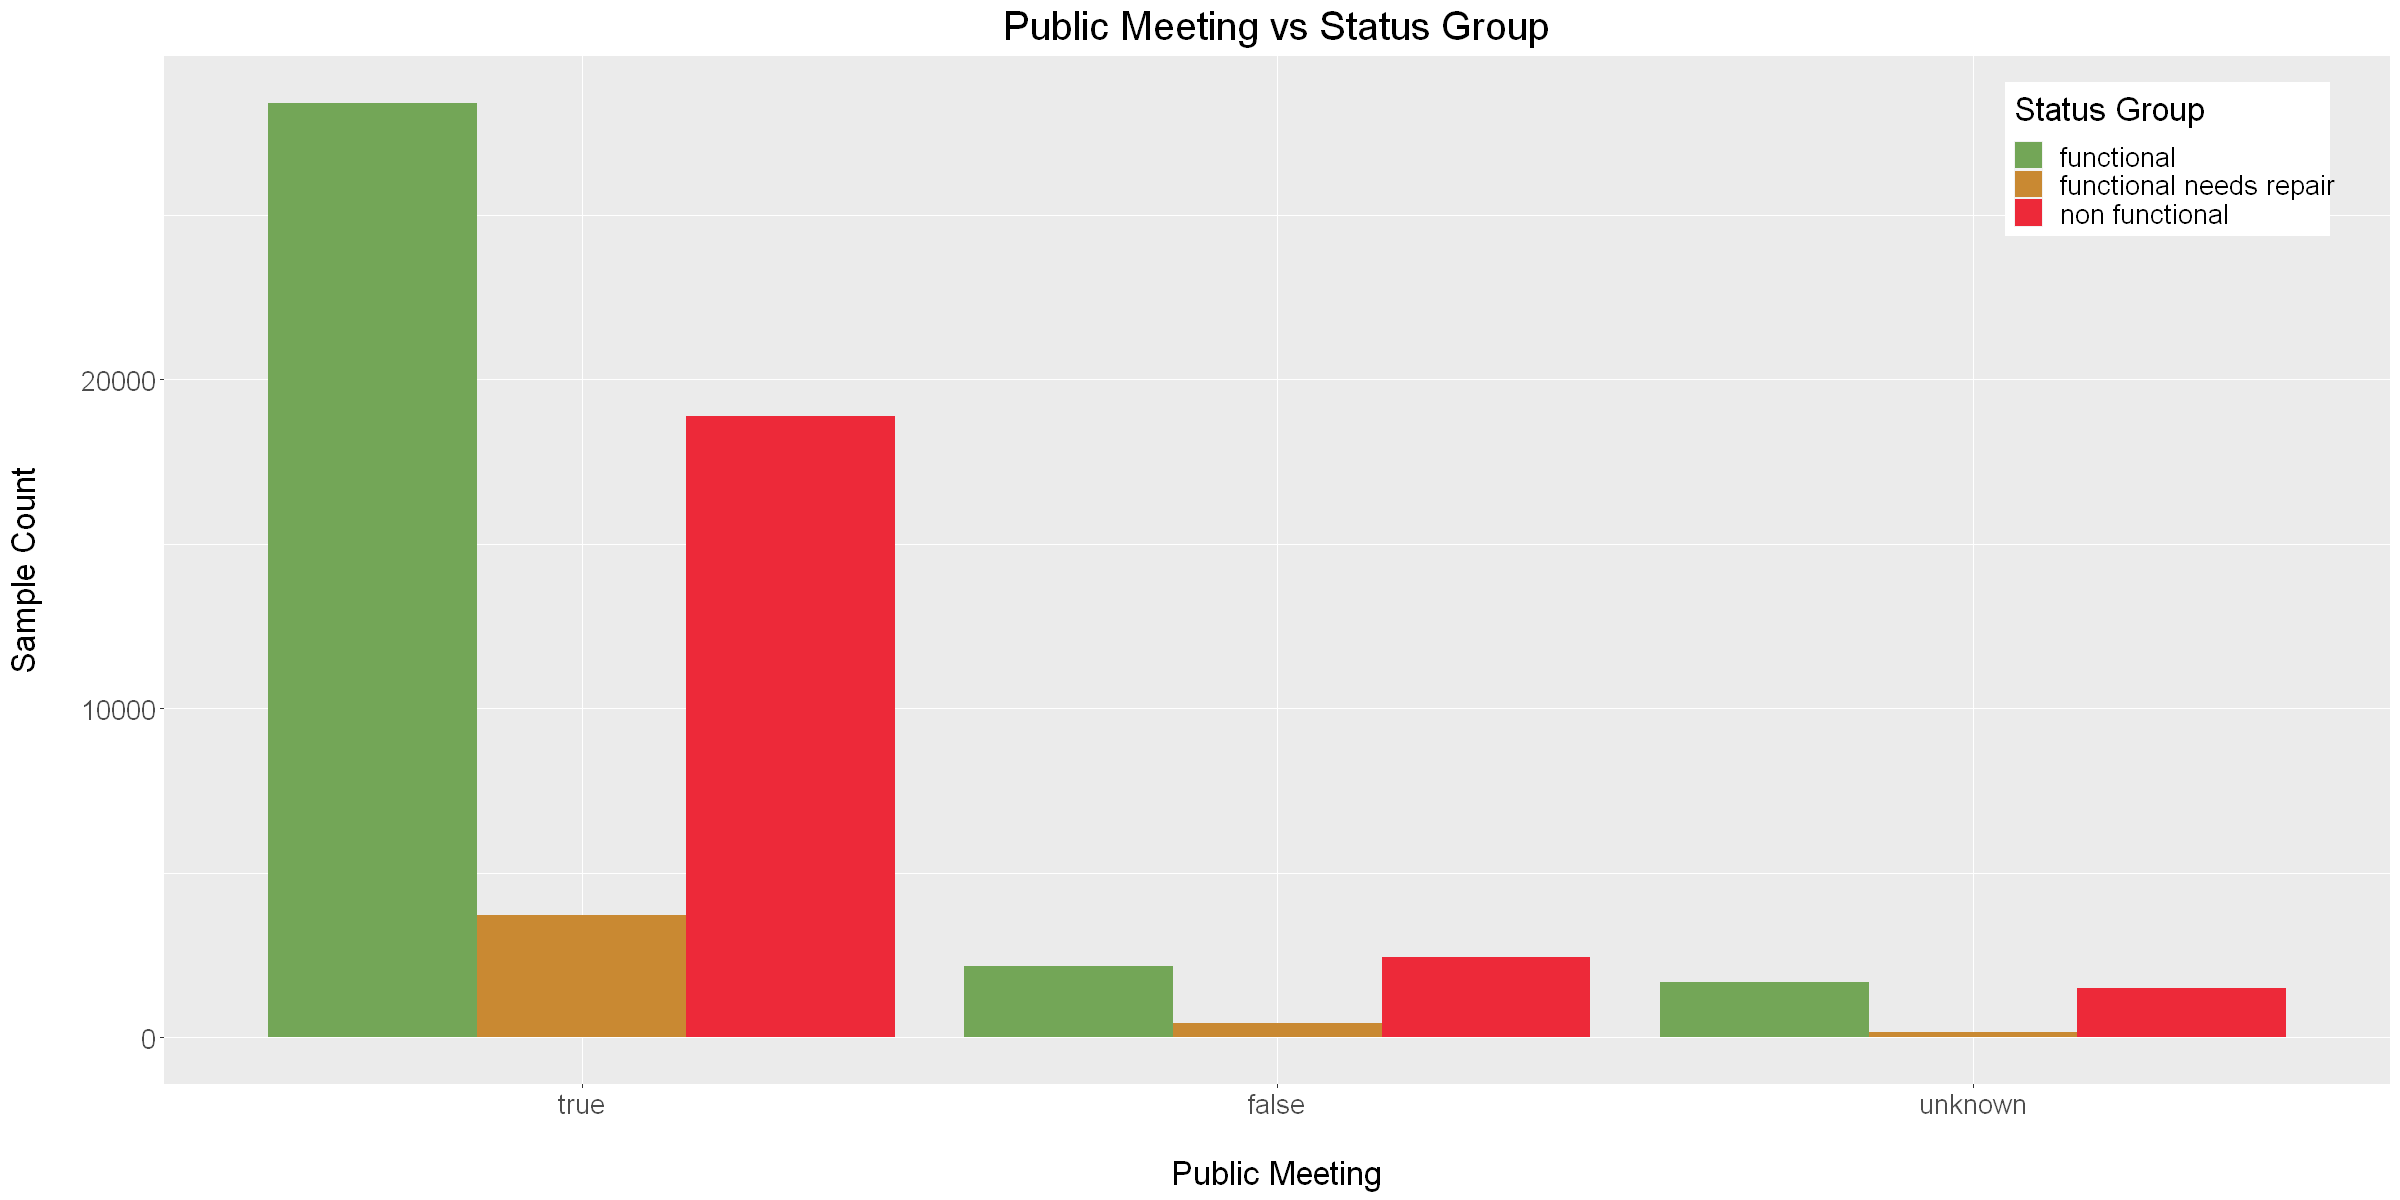

In [138]:
# plot public_meeting vs status_group
options(repr.plot.width=20, repr.plot.height=10)
to_plot <- subset(features, select = c(public_meeting, status_group)) 
to_plot$public_meeting <- with(to_plot, reorder(public_meeting, public_meeting, function(x) -length(x)))                       
ggplot(to_plot, aes(x = public_meeting, fill=status_group)) +
      geom_bar(position= "dodge") +
      scale_fill_manual("Status Group", values=group_colors) +
      labs(title = "Public Meeting vs Status Group", y = "Sample Count\n", x = "\nPublic Meeting") +
      theme(plot.title = element_text(hjust = 0.5),
            text = element_text(size=20), 
            legend.position = c(0.9, 0.9))  

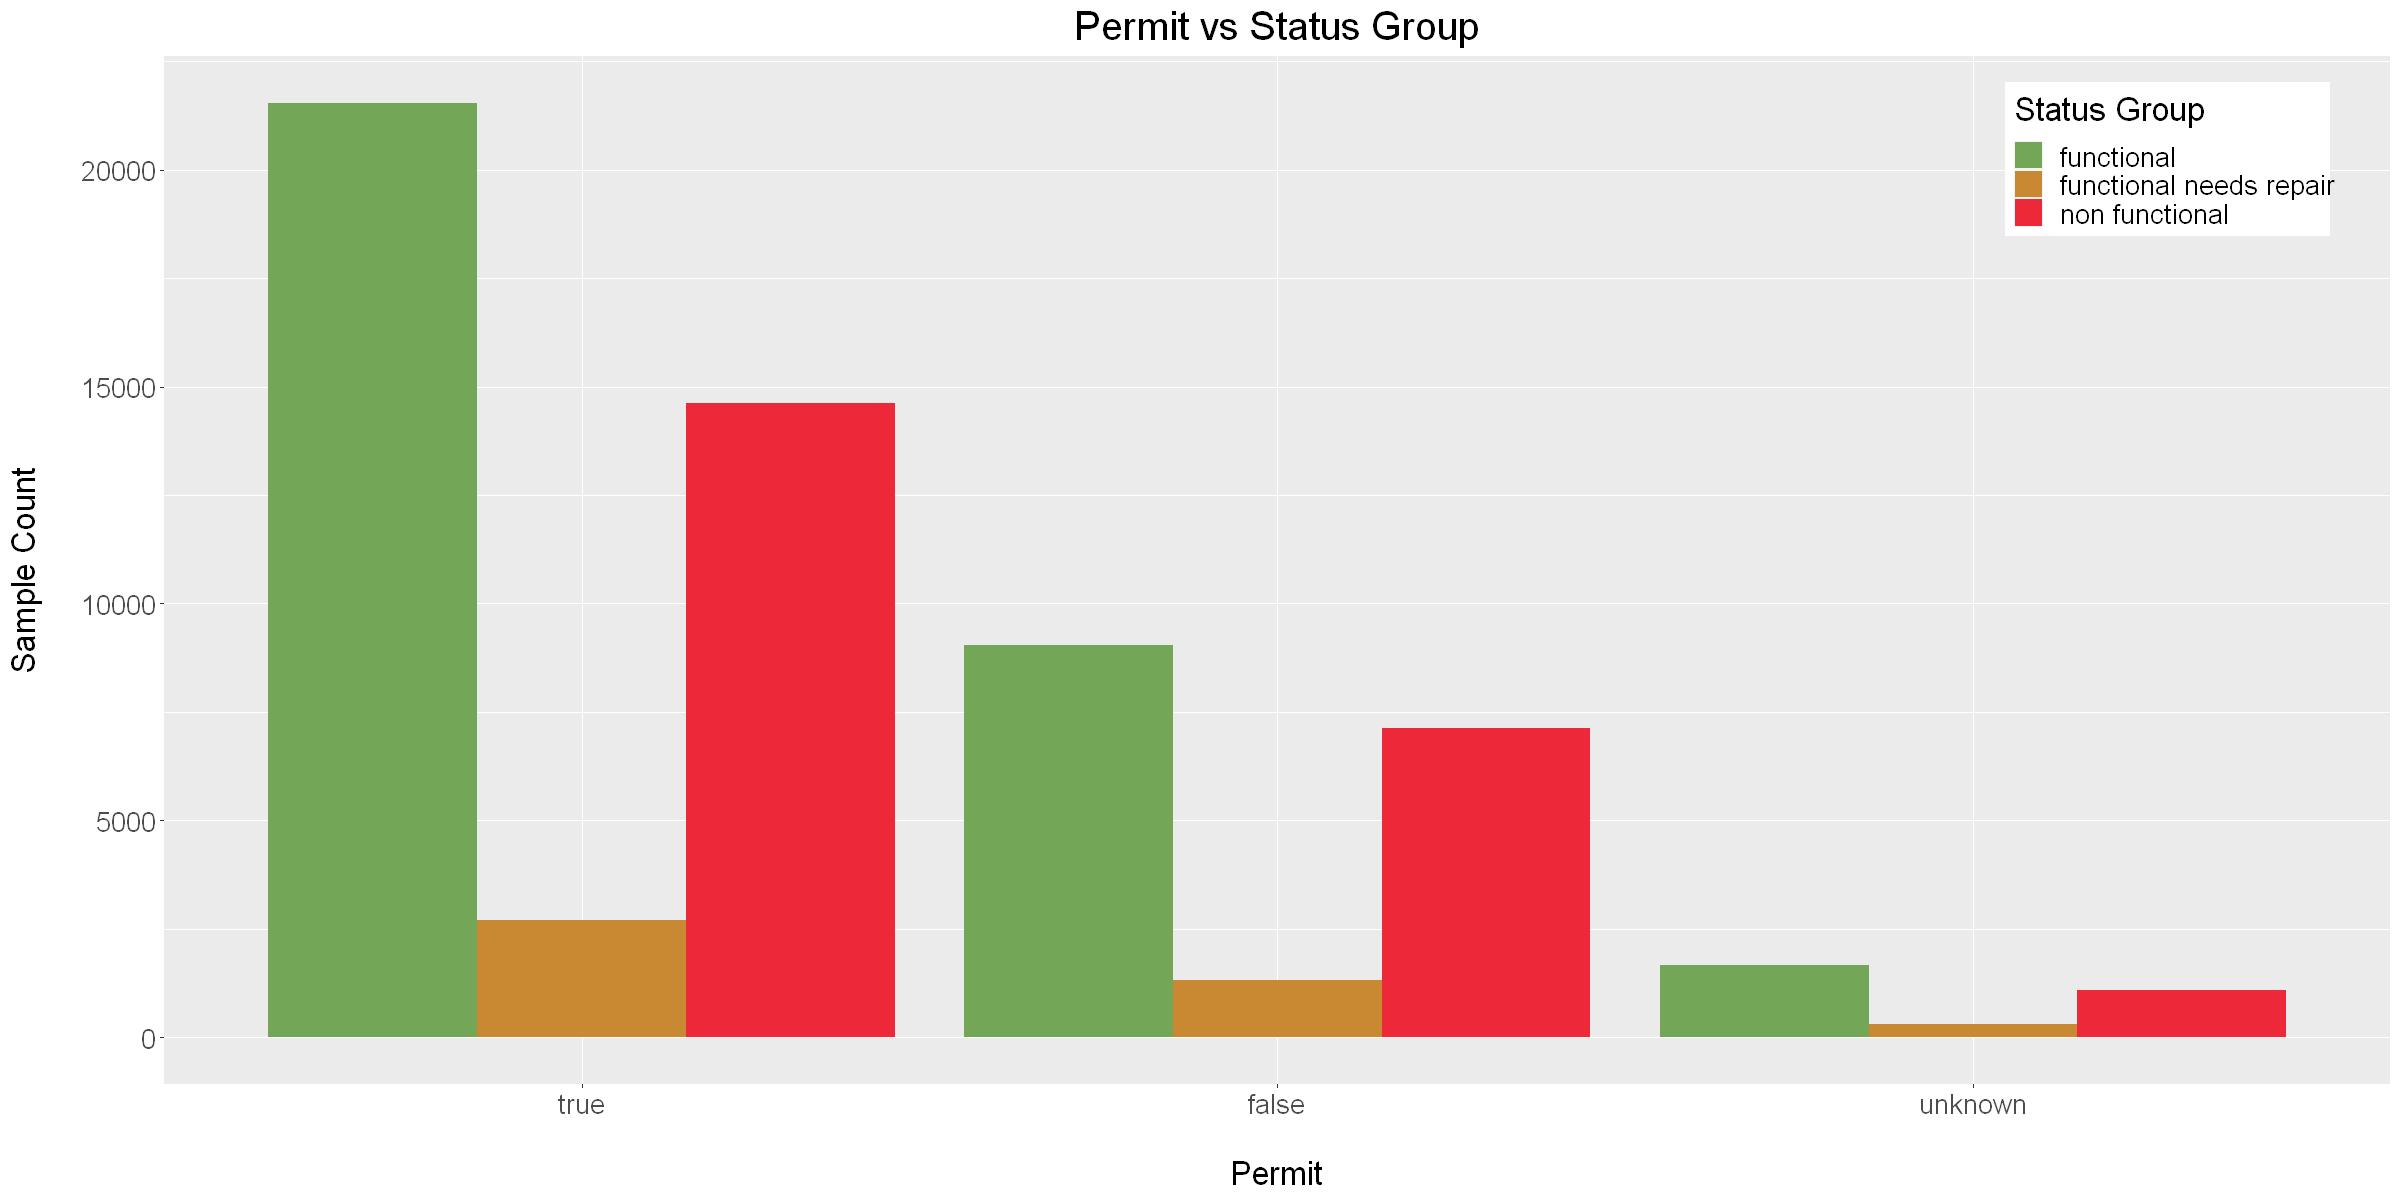

In [139]:
# plot permit vs status_group
options(repr.plot.width=20, repr.plot.height=10)
to_plot <- subset(features, select = c(permit, status_group)) 
to_plot$permit <- with(to_plot, reorder(permit, permit, function(x) -length(x)))                       
ggplot(to_plot, aes(x = permit, fill=status_group)) +
      geom_bar(position= "dodge") +
      scale_fill_manual("Status Group", values=group_colors) +
      labs(title = "Permit vs Status Group", y = "Sample Count\n", x = "\nPermit") +
      theme(plot.title = element_text(hjust = 0.5),
            text = element_text(size=20), 
            legend.position = c(0.9, 0.9))  

### Management

The features scheme_name and scheme_management are both described as "Who operates the waterpoint" with scheme_name being a more detailed version of scheme_management. However, the feature scheme_name has 2575 unique values which would increase the chance of dimensionality problems. Therefore, this feature will be dropped and only scheme_management will be kept which has 12 unique values.

The features management and management_group are both described as "How the waterpoint is managed".
It is interesting to note that management is a feature with categories that are more or less the same as the categories in scheme_management, while management_group is a feature further grouping these management values. Furthermore, there is no one-on-one correspondence from samples between scheme_management and management even though they share the same level names. It is not clear if these are mistakes or management of the waterpoint and operation of the waterpoint don't have the same meaning. 

We decided to keep both scheme_management and the aggregated feature management_group. This way the information captured in management and management_group is not lost if it was indeed different from scheme_management, but we also don't introduce too much redundancy (or duplicate features in a one-hot encoded version) if they did carry the same information.

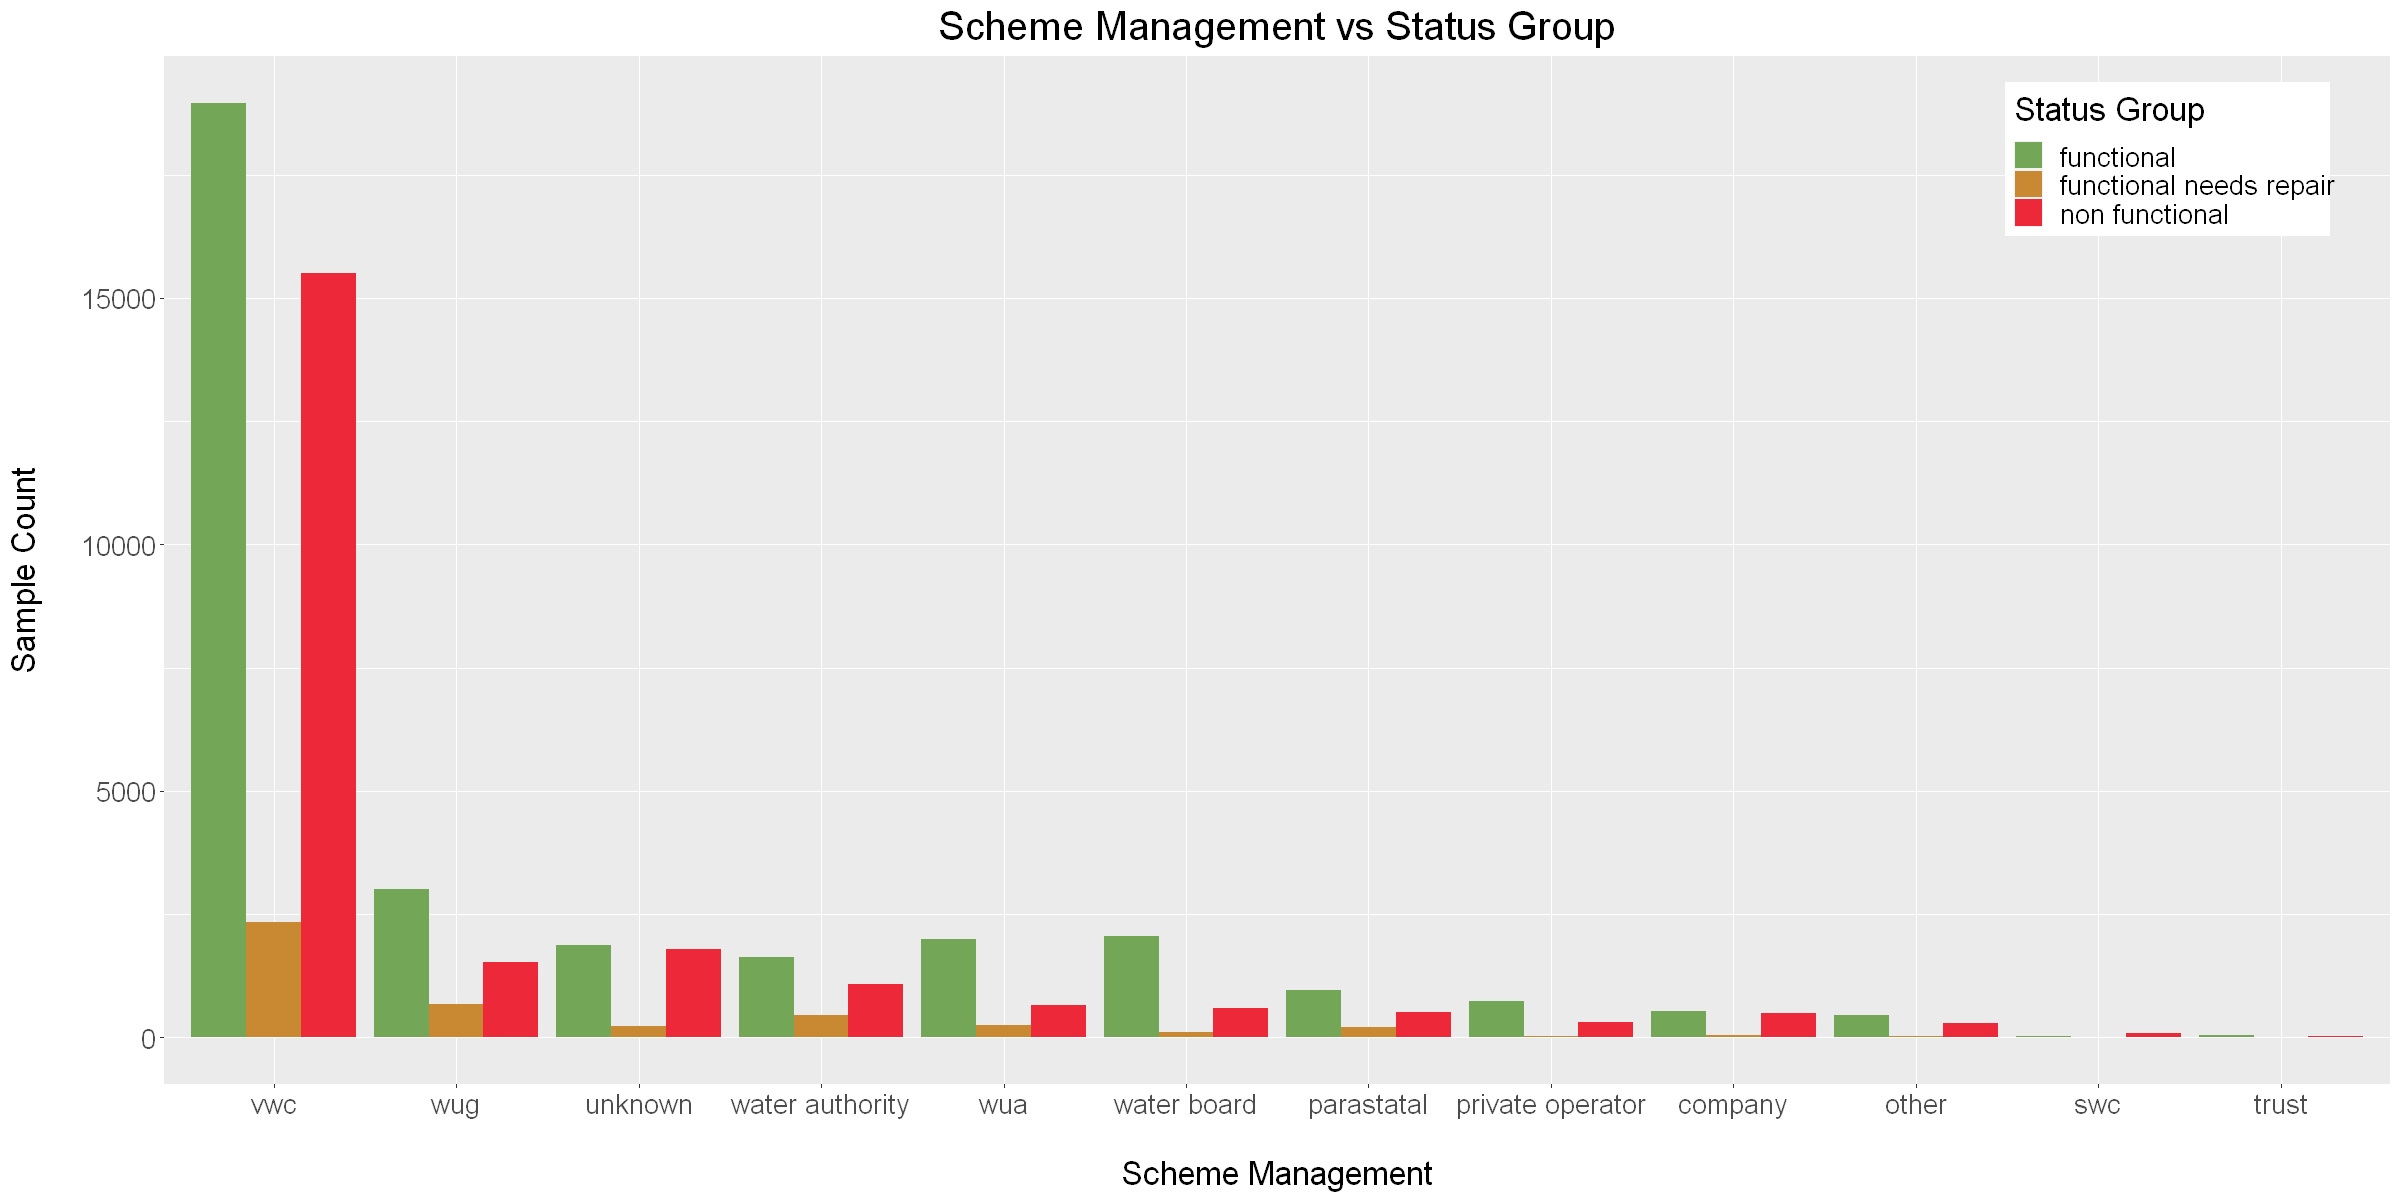

In [140]:
# plot scheme_management vs status_group
options(repr.plot.width=20, repr.plot.height=10)
to_plot <- subset(features, select = c(scheme_management, status_group)) 
to_plot$scheme_management <- with(to_plot, reorder(scheme_management, scheme_management, function(x) -length(x)))                                         
ggplot(to_plot, aes(x = scheme_management, fill=status_group)) +
      geom_bar(position= "dodge") +
      scale_fill_manual("Status Group", values=group_colors) +
      labs(title = "Scheme Management vs Status Group", y = "Sample Count\n", x = "\nScheme Management") +
      theme(plot.title = element_text(hjust = 0.5),
            text = element_text(size=20), 
            legend.position = c(0.9, 0.9))   

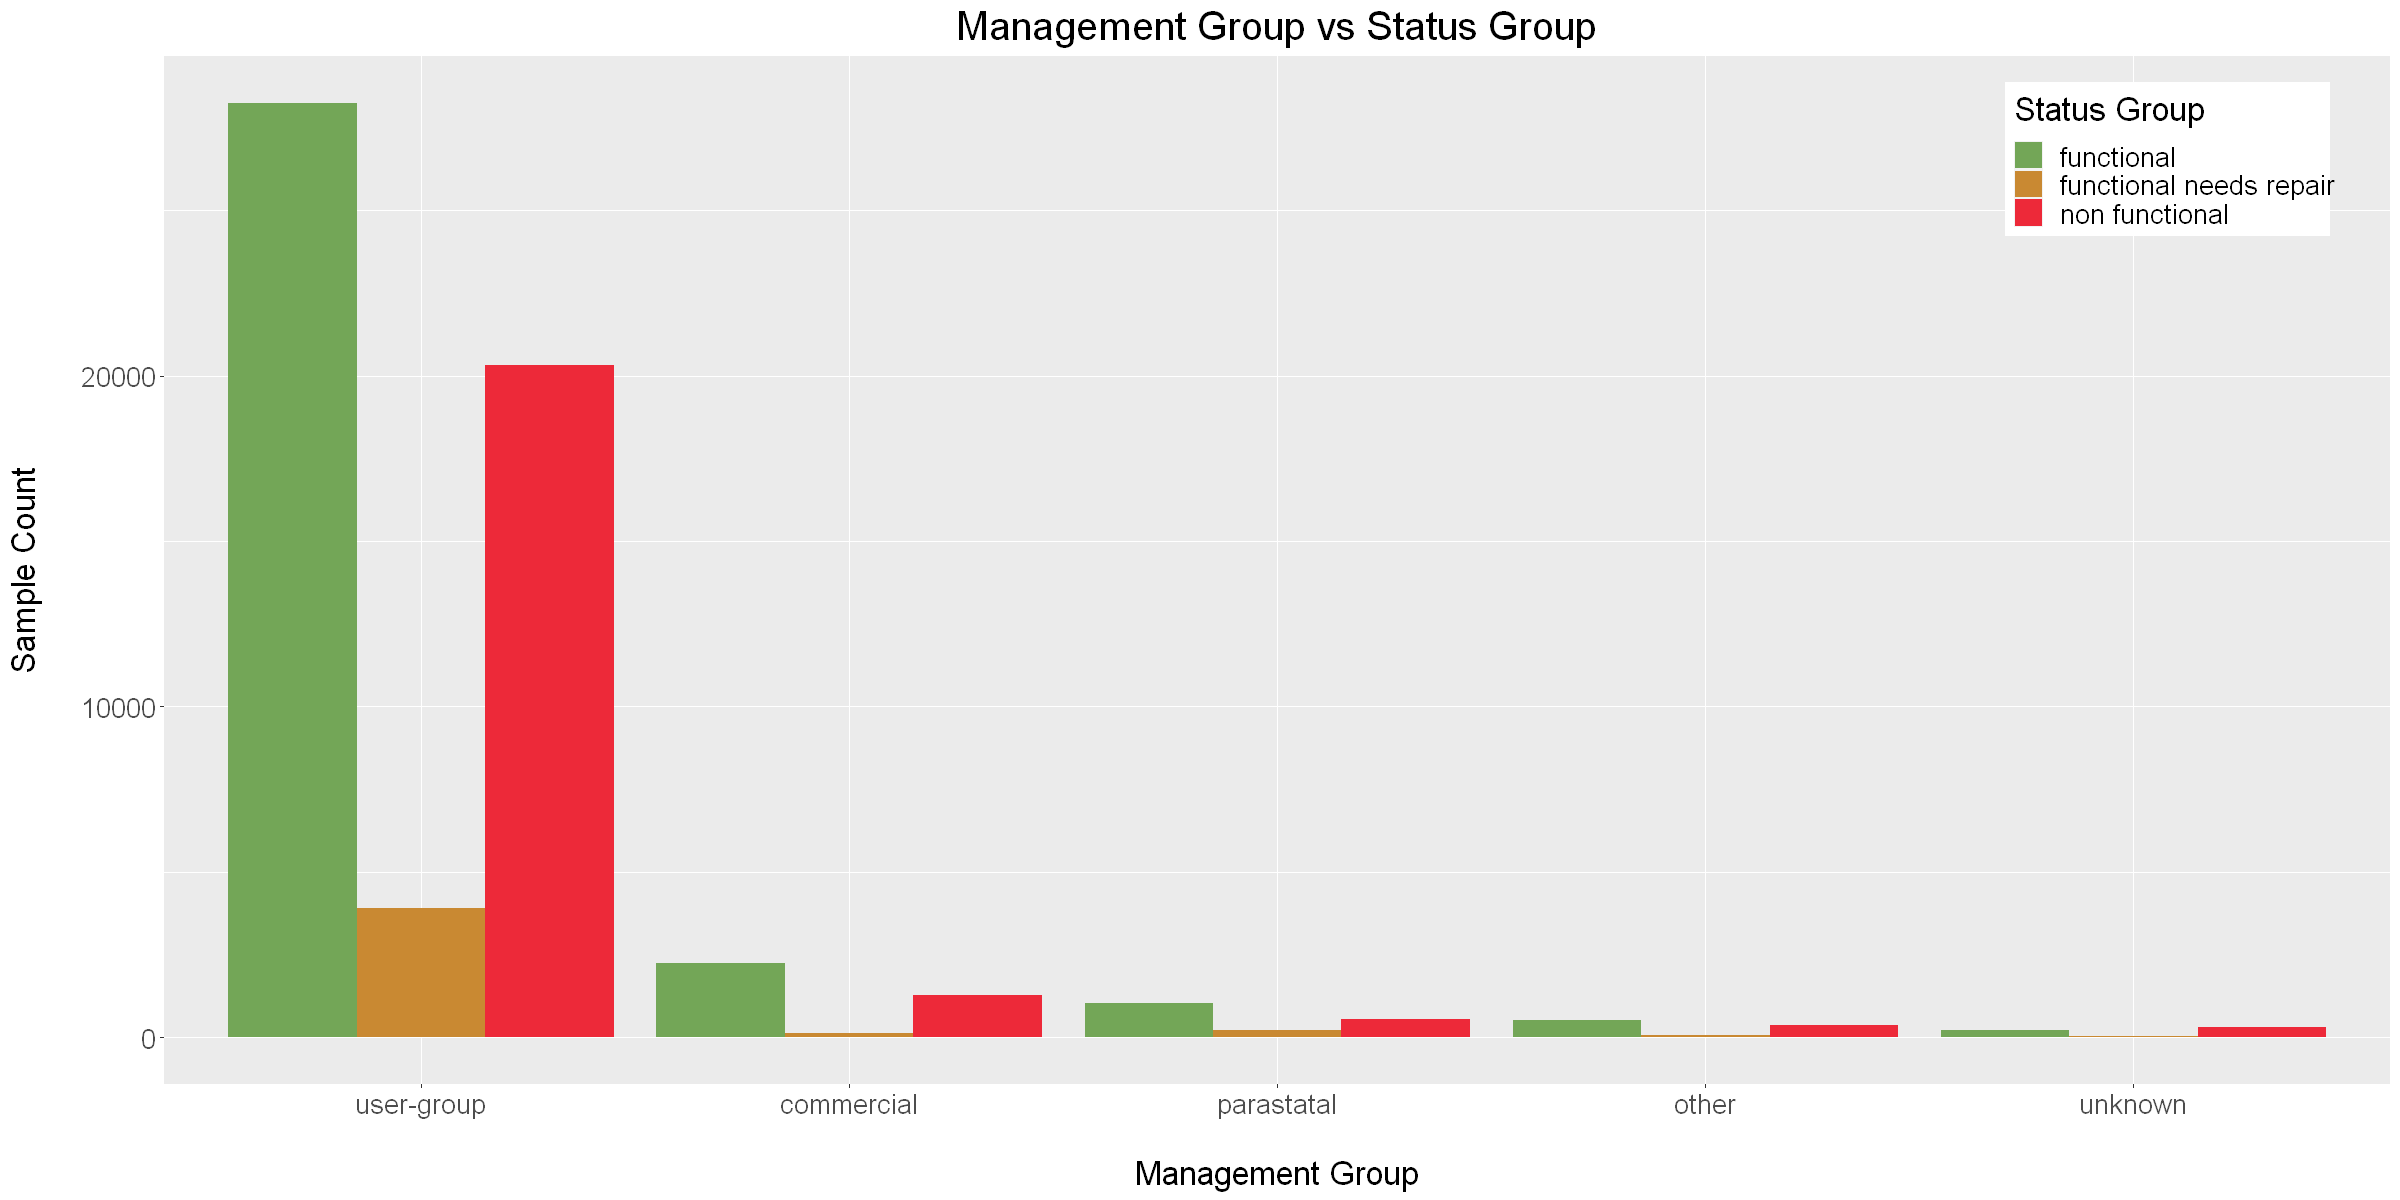

In [141]:
# plot management_group vs status_group
options(repr.plot.width=20, repr.plot.height=10)
to_plot <- subset(features, select = c(management_group, status_group)) 
to_plot$management_group <- with(to_plot, reorder(management_group, management_group, function(x) -length(x)))                                         
ggplot(to_plot, aes(x = management_group, fill=status_group)) +
      geom_bar(position= "dodge") +
      scale_fill_manual("Status Group", values=group_colors) +
      labs(title = "Management Group vs Status Group", y = "Sample Count\n", x = "\nManagement Group") +
      theme(plot.title = element_text(hjust = 0.5),
            text = element_text(size=20), 
            legend.position = c(0.9, 0.9))  

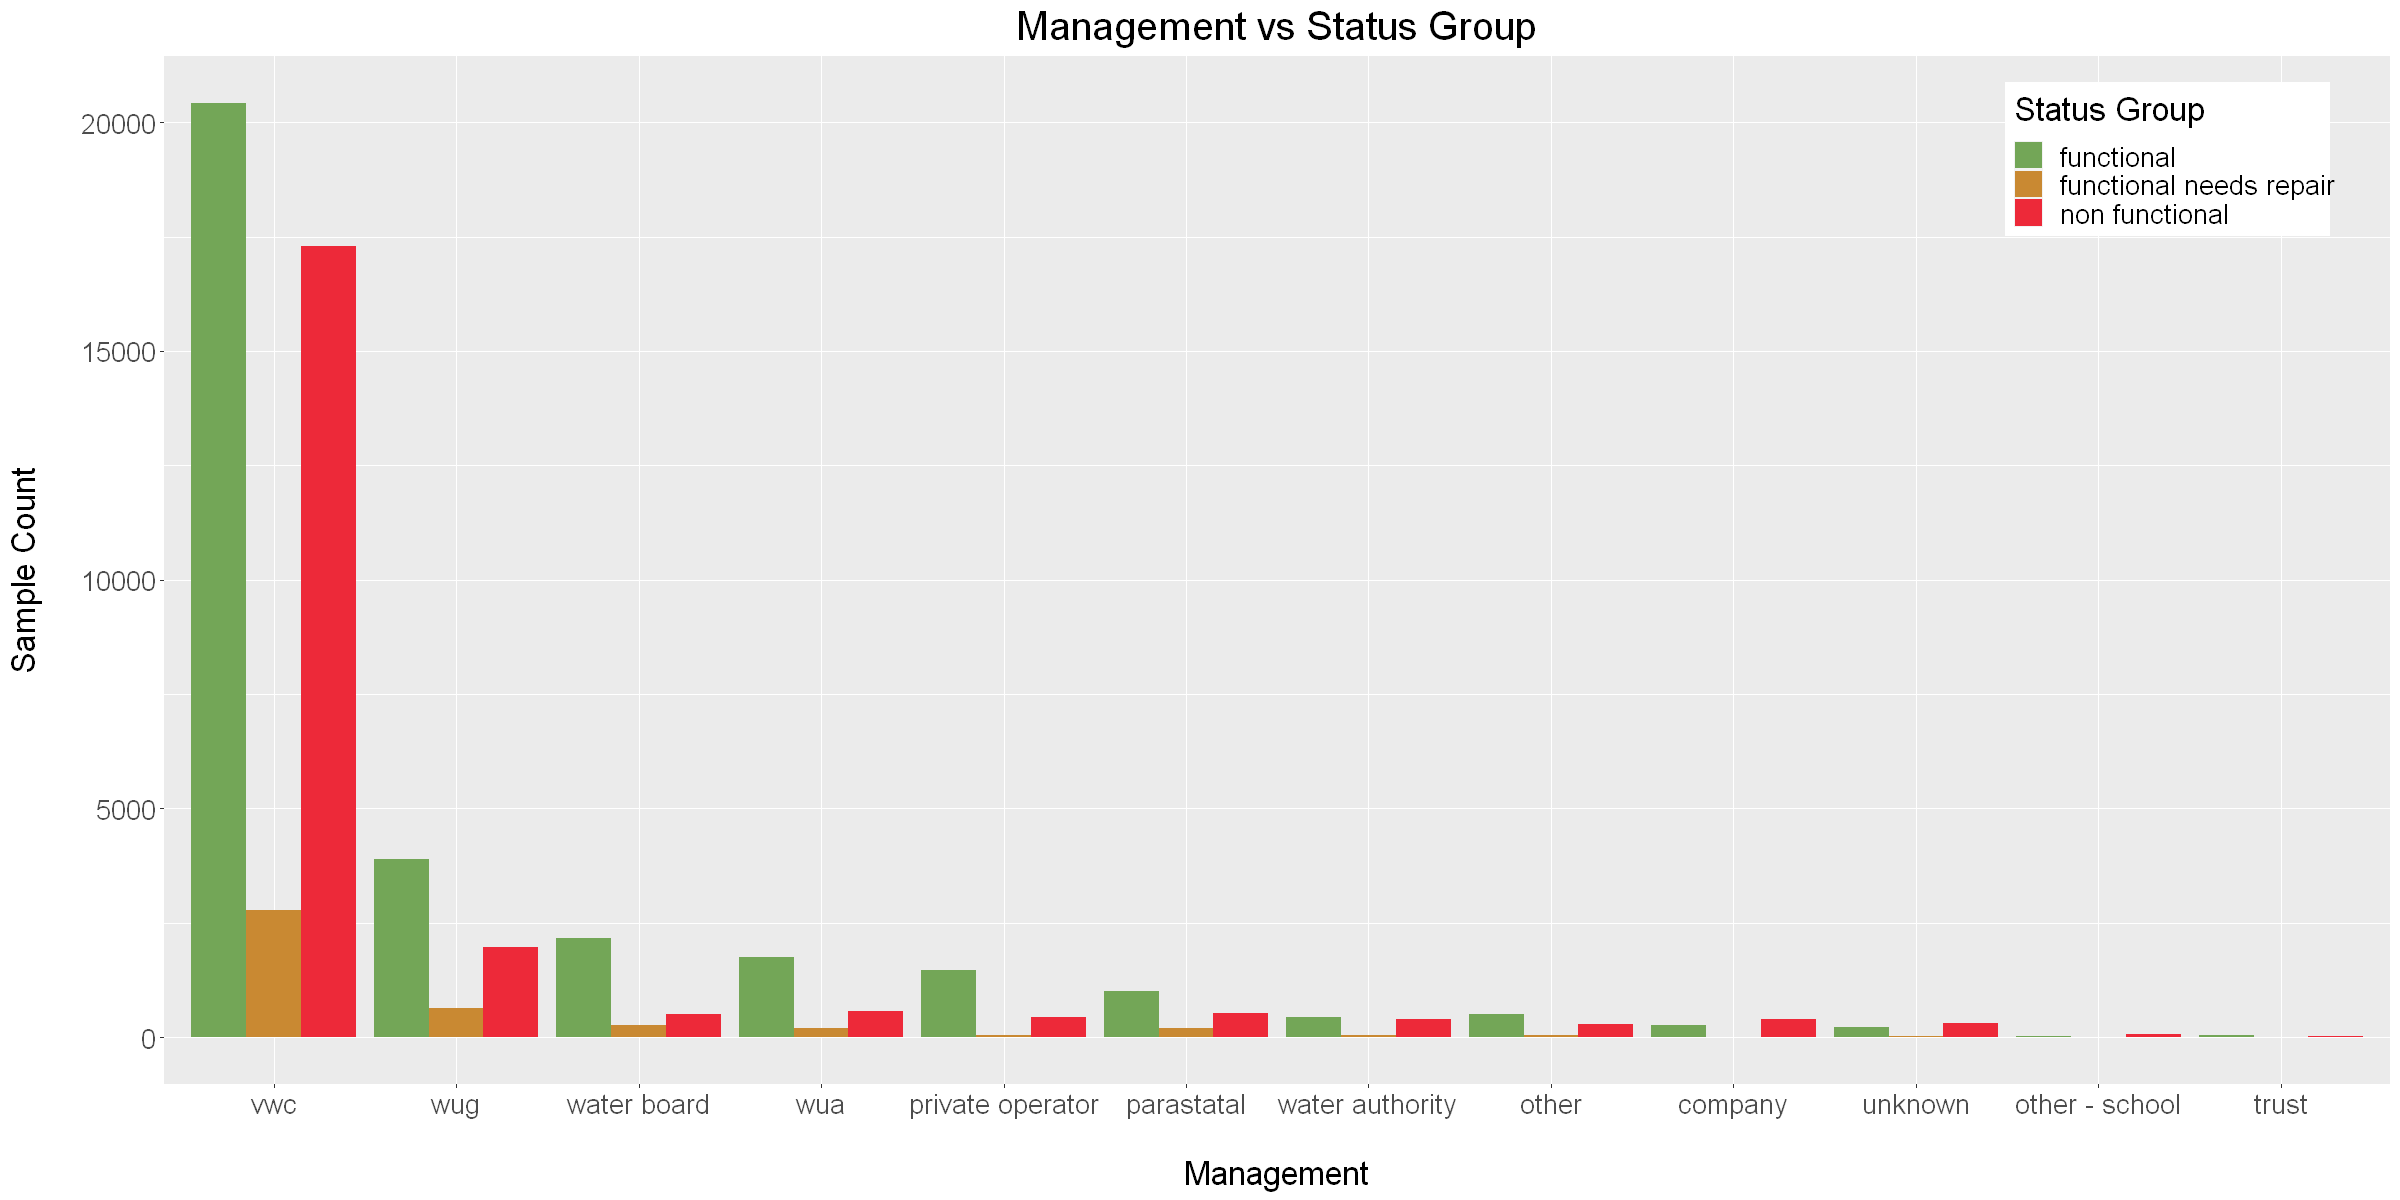

In [142]:
# plot management vs status_group
options(repr.plot.width=20, repr.plot.height=10)
to_plot <- subset(features, select = c(management, status_group)) 
to_plot$management <- with(to_plot, reorder(management, management, function(x) -length(x)))                                         
ggplot(to_plot, aes(x = management, fill=status_group)) +
      geom_bar(position= "dodge") +
      scale_fill_manual("Status Group", values=group_colors) +
      labs(title = "Management vs Status Group", y = "Sample Count\n", x = "\nManagement") +
      theme(plot.title = element_text(hjust = 0.5),
            text = element_text(size=20), 
            legend.position = c(0.9, 0.9))  

### Payment

The features payment and payment_type are both described as "What the water costs". Furthermore there is a one-on-one correspondence between both with only the category names being slight different. Therefore payment_type was dropped.

The feature payment itself does have a clear influence though. It seems safe to deduce that water pumps that are not free are better maintained and therefore have a higher degree of functionality than free water pumps. The difference in influence between the types of payment seems less present, but nevertheless all categories were still kept.

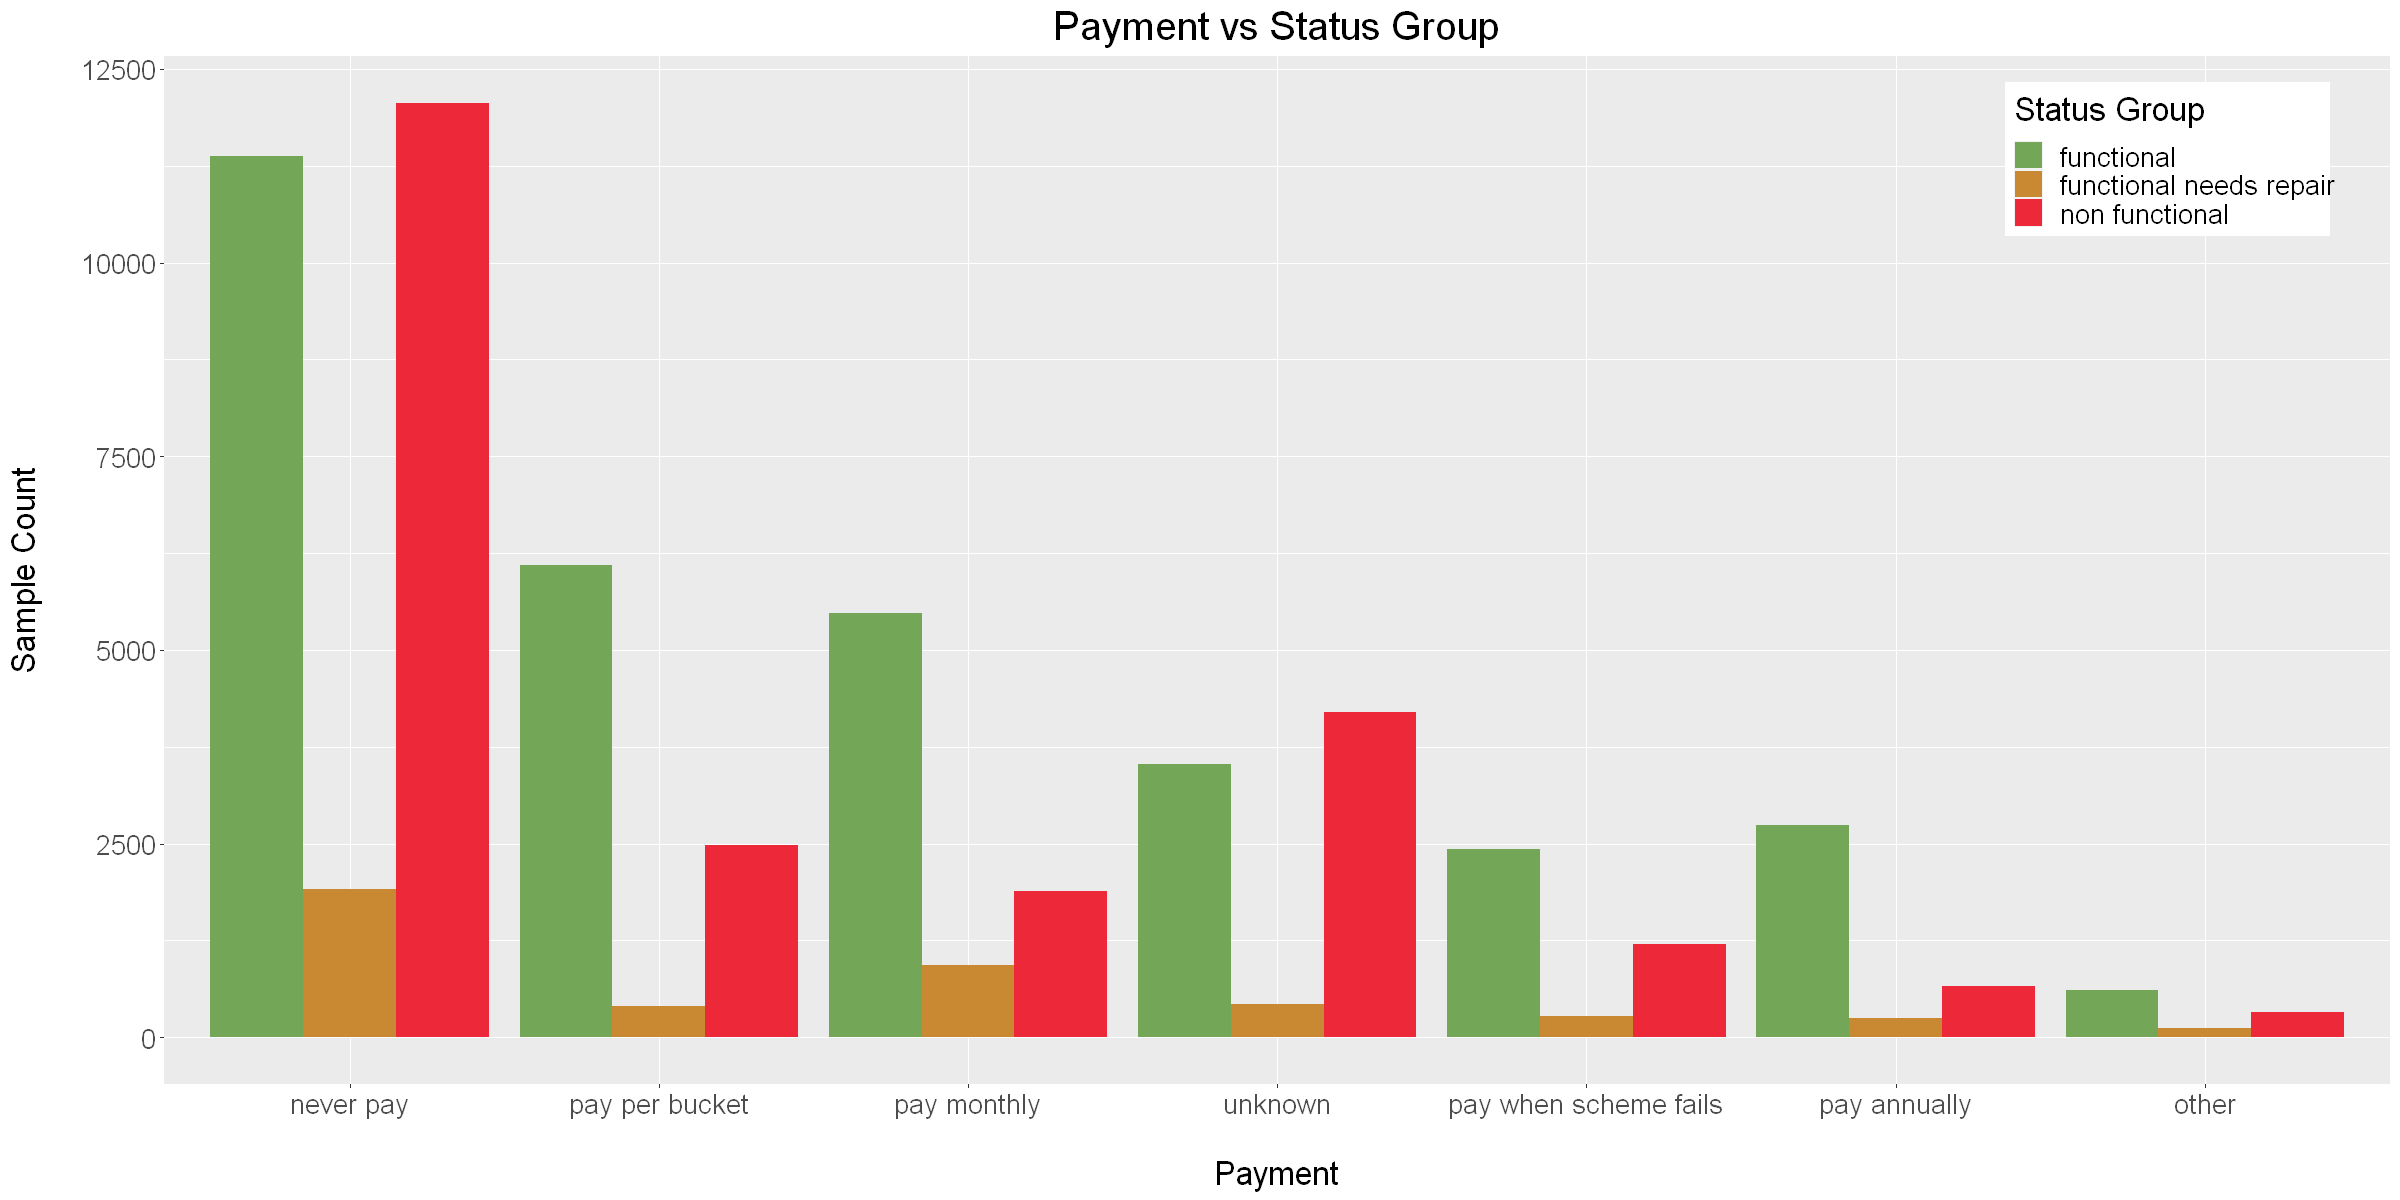

In [143]:
# plot scheme_management vs status_group
options(repr.plot.width=20, repr.plot.height=10)
to_plot <- subset(features, select = c(payment, status_group)) 
to_plot$payment <- with(to_plot, reorder(payment, payment, function(x) -length(x)))                                         
ggplot(to_plot, aes(x = payment, fill=status_group)) +
      geom_bar(position= "dodge") +
      scale_fill_manual("Status Group", values=group_colors) +
      labs(title = "Payment vs Status Group", y = "Sample Count\n", x = "\nPayment") +
      theme(plot.title = element_text(hjust = 0.5),
            text = element_text(size=20), 
            legend.position = c(0.9, 0.9))   

### Extraction type

The features extraction_type, extraction_type_group and extraction_type_class are all described as "The kind of extraction the waterpoint uses" and are clearly features with the same meaning at a different level of granularity.

The feature extraction_type is at the lowest level of granularity and has 18 categories of which a lot are just very small subdivisions of the "other" category. Since there are so many very small categories, this feature is dropped in favor of the other two.

The feature extraction_type_group is at the intermediate level of granularity and has 13 categories. However, a lot of these are still very small categories. Furthermore, the subdivisions seem to follow a similar distribution as the less detailed categories of the feature extraction_type_class. Therefore, only the feature extraction_type_class is kept which has 7 categories. As can be seen in the graph, there is a clear relation between the extraction type and the functionality of the water pump.

<table>
    <tr>
        <th>extraction_type_class</th>
        <th>extraction_type_group</th>
        <th>extraction_type</th>
    </tr>
    <tr>
        <td>gravity (45%)</td>
        <td>gravity (45%)</td>
        <td>gravity (45%)</td>
    </tr>
    <tr>
        <td rowspan="10">hand pump (28%)</td>
    </tr>
    <tr>
        <td>afridev (3%)</td>
        <td>afridev (3%)</td>
    </tr>
    <tr>
        <td>india mark ii (4%)</td>
        <td>india mark ii (4%)</td>
    </tr>
    <tr>
        <td>nira/tanira (14%)</td>
        <td>nira/tanira (14%)</td>
    </tr>
    <tr>
        <td>swn 80 (6%)</td>
        <td>swn 80 (6%)</td>
    </tr>
    <tr>
        <td rowspan="5">other handpump (0.6%)</td>
    </tr>
    <tr>
        <td>other - play pump (0.1%)</td>
    </tr>
    <tr>
        <td>other - swn (0.4%)</td>
    </tr>
    <tr>
        <td>walimi(0.1%)</td>
    </tr>
    <tr>
        <td>other - mkulima/shinyanga (0.004%)</td>
    </tr>
    <tr>
        <td rowspan="3">submersible (10%)</td>
        <td rowspan="3">submersible (10%)</td>
    </tr>
    <tr>
        <td>submersible (8%)</td>
    </tr>
    <tr>
        <td>ksb (2%)</td>
    </tr>
    <tr>
        <td rowspan="5">motorpump (5%)</td>
    </tr>
    <tr>
        <td rowspan="3">other motor pump (0.2%)</td>
    </tr>
    <tr>
        <td>climax (0.05%)</td>
    </tr>
    <tr>
        <td>cemo (0.15%)</td>
    </tr>
    <tr>
        <td>mono (5%)</td>
        <td>mono (5%)</td>
    </tr>
    <tr>
        <td>rope pump (0.8%)</td>
        <td>rope pump (0.8%)</td>
        <td>rope pump (0.8%)</td>
    </tr>
    <tr>
        <td>wind-powered (0.2%)</td>
        <td>wind-powered (0.2%)</td>
        <td>wind-powered (0.2%)</td>
    </tr>
</table>

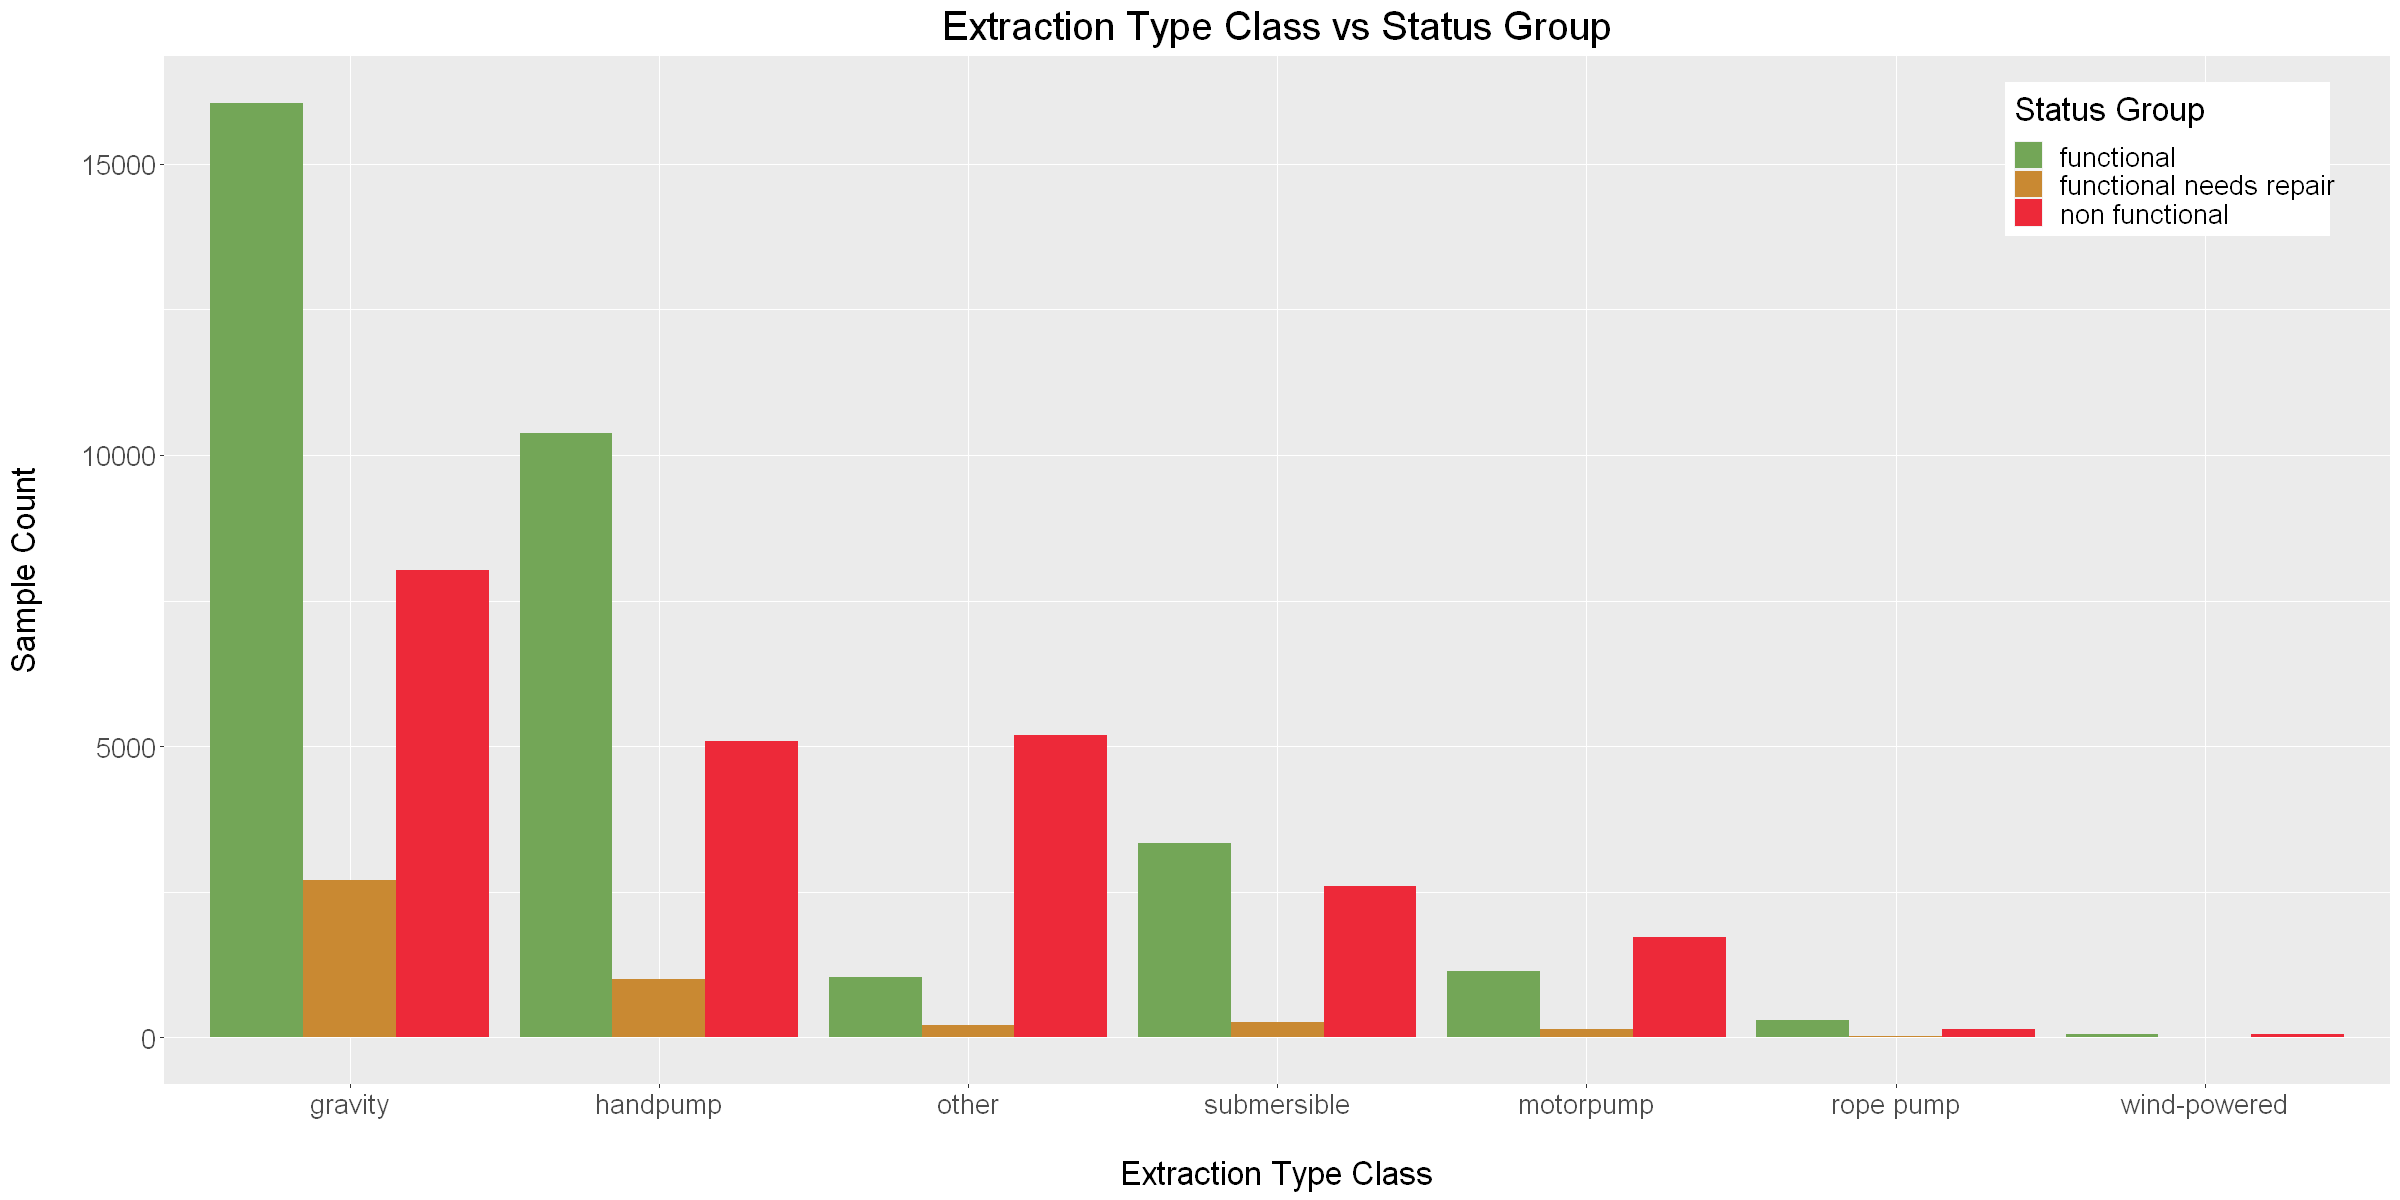

In [144]:
# plot extraction_type_class vs status_group
options(repr.plot.width=20, repr.plot.height=10)
to_plot <- subset(features, select = c(extraction_type_class, status_group)) 
to_plot$extraction_type_class <- with(to_plot, reorder(extraction_type_class, extraction_type_class, function(x) -length(x)))                                         
ggplot(to_plot, aes(x = extraction_type_class, fill=status_group)) +
      geom_bar(position= "dodge") +
      scale_fill_manual("Status Group", values=group_colors) +
      labs(title = "Extraction Type Class vs Status Group", y = "Sample Count\n", x = "\nExtraction Type Class") +
      theme(plot.title = element_text(hjust = 0.5),
            text = element_text(size=20), 
            legend.position = c(0.9, 0.9))   

### Water Quality

The features water_quality and quality_group are described as "The quality of the water" and are clearly features with the same meaning at a different level of granularity.

The feature quality_group is the same as water_quality, but with the classes salty and fluoride further split up. Since more than 80% of the samples belong to the class 'soft' for quality_group (which corresponds to 'good' in water_quality), these splits create very small categories. Therefore, the feature quality_group is dropped in favor of water_quality.

Based on the graph below, the water quality does seem to have influence on the functionality of the water pump.

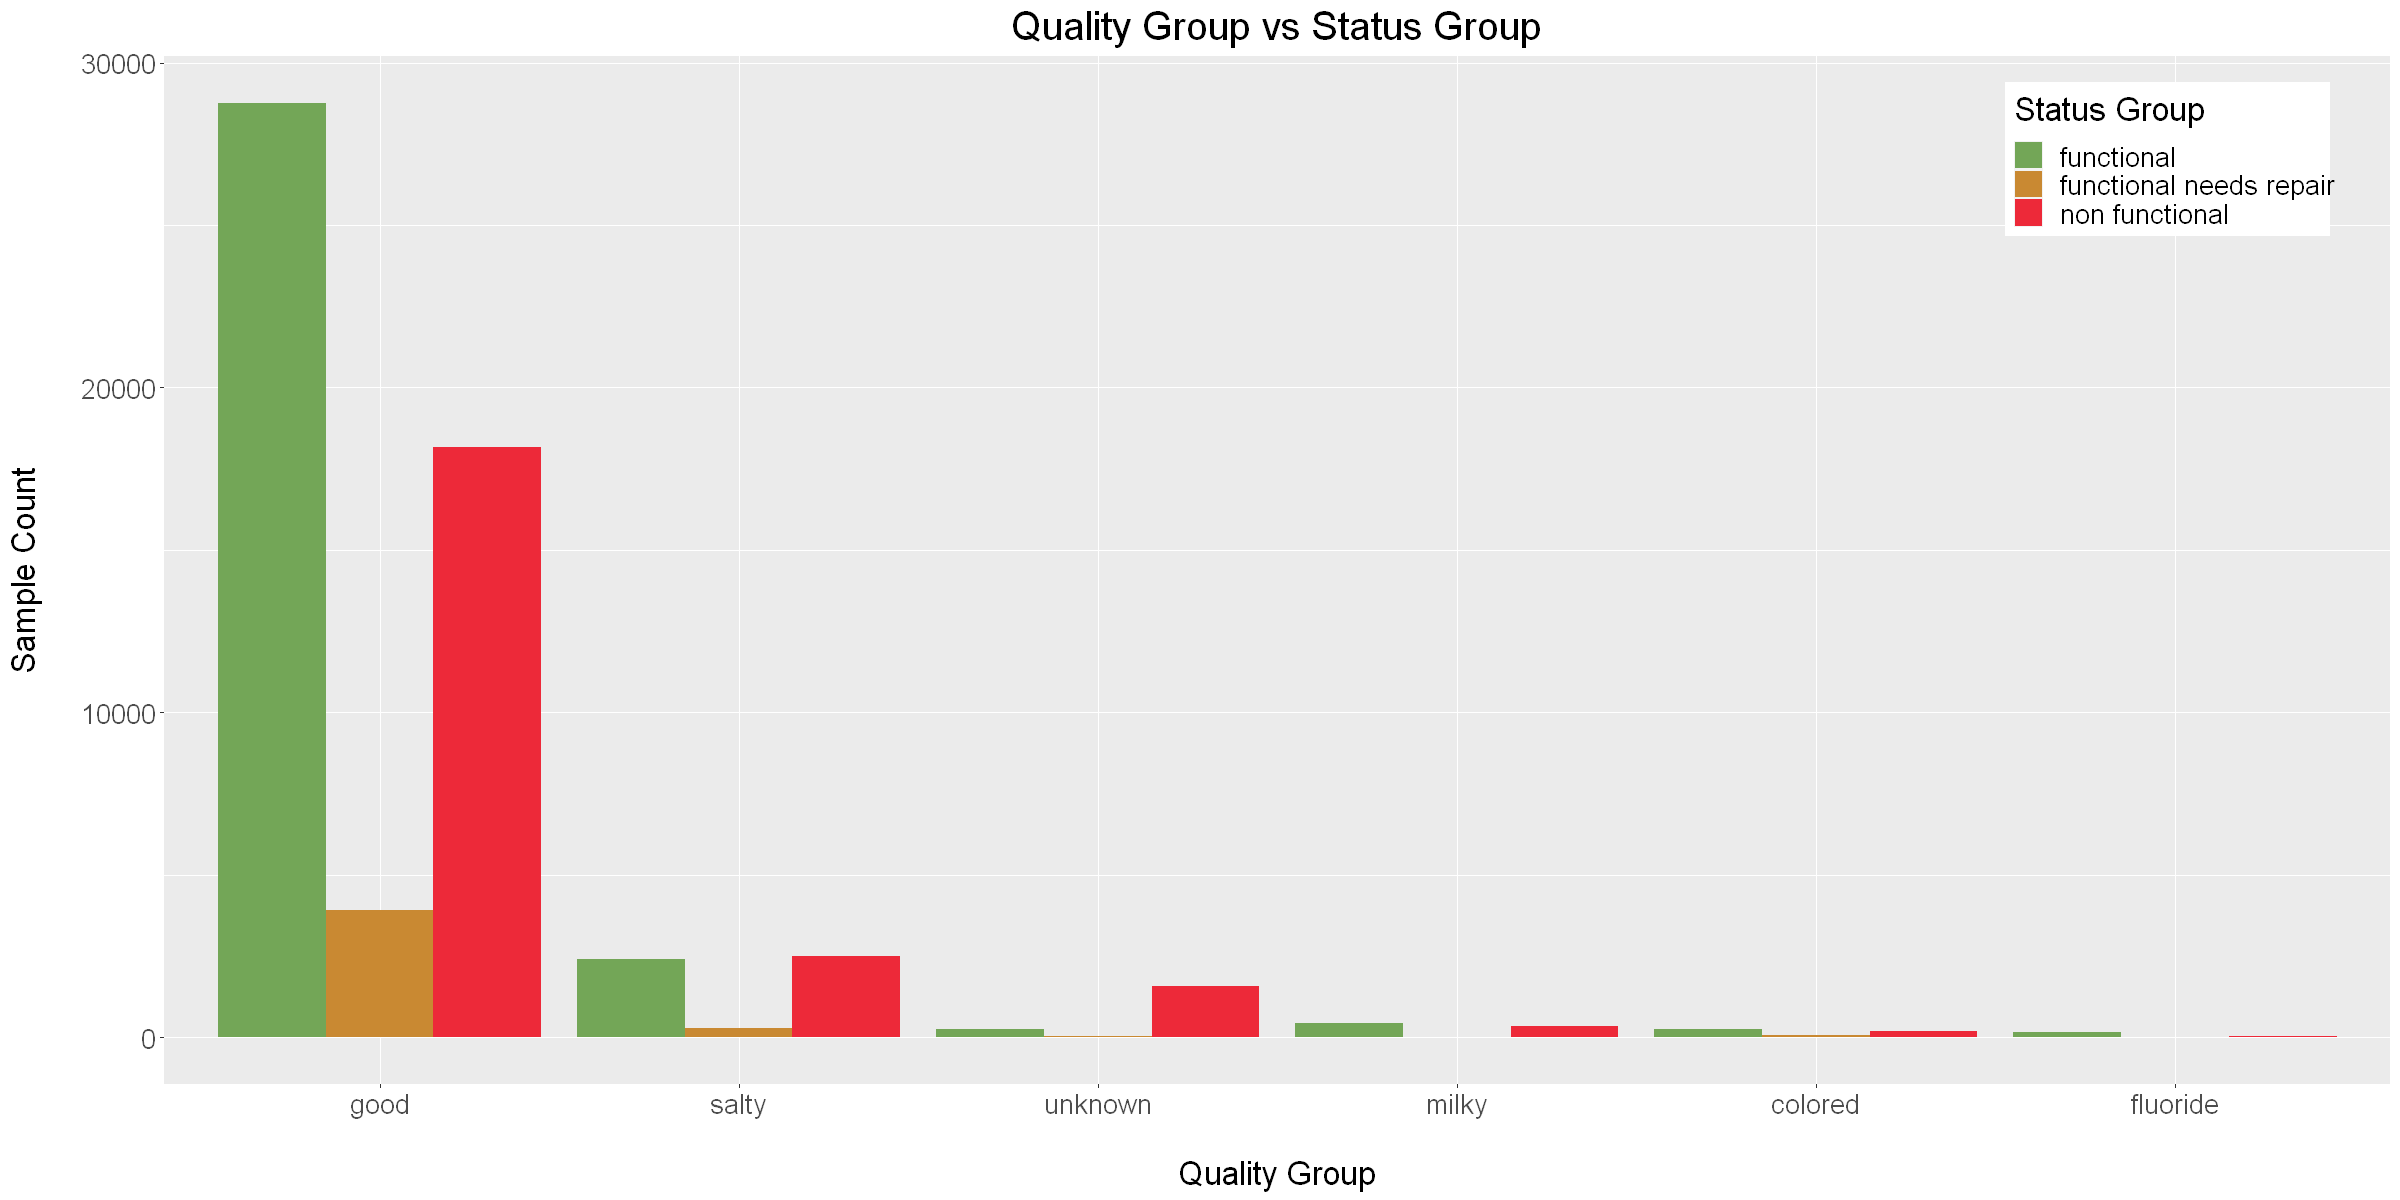

In [145]:
# plot quality_group vs status_group
options(repr.plot.width=20, repr.plot.height=10)
to_plot <- subset(features, select = c(quality_group, status_group)) 
to_plot$quality_group <- with(to_plot, reorder(quality_group, quality_group, function(x) -length(x)))                                         
ggplot(to_plot, aes(x = quality_group, fill=status_group)) +
      geom_bar(position= "dodge") +
      scale_fill_manual("Status Group", values=group_colors) +
      labs(title = "Quality Group vs Status Group", y = "Sample Count\n", x = "\nQuality Group") +
      theme(plot.title = element_text(hjust = 0.5),
            text = element_text(size=20), 
            legend.position = c(0.9, 0.9))   

### Quantity

The features quantity and quantity_group are both described as "The quantity of water". Since there is a one-on-one correspondence between both features, only the feature quantity is kept.

Based on the graph there is a very clear and strong relation between the quantity and the target variable. Almost all dry pumps are non-functional, which also feels intuitively correct.

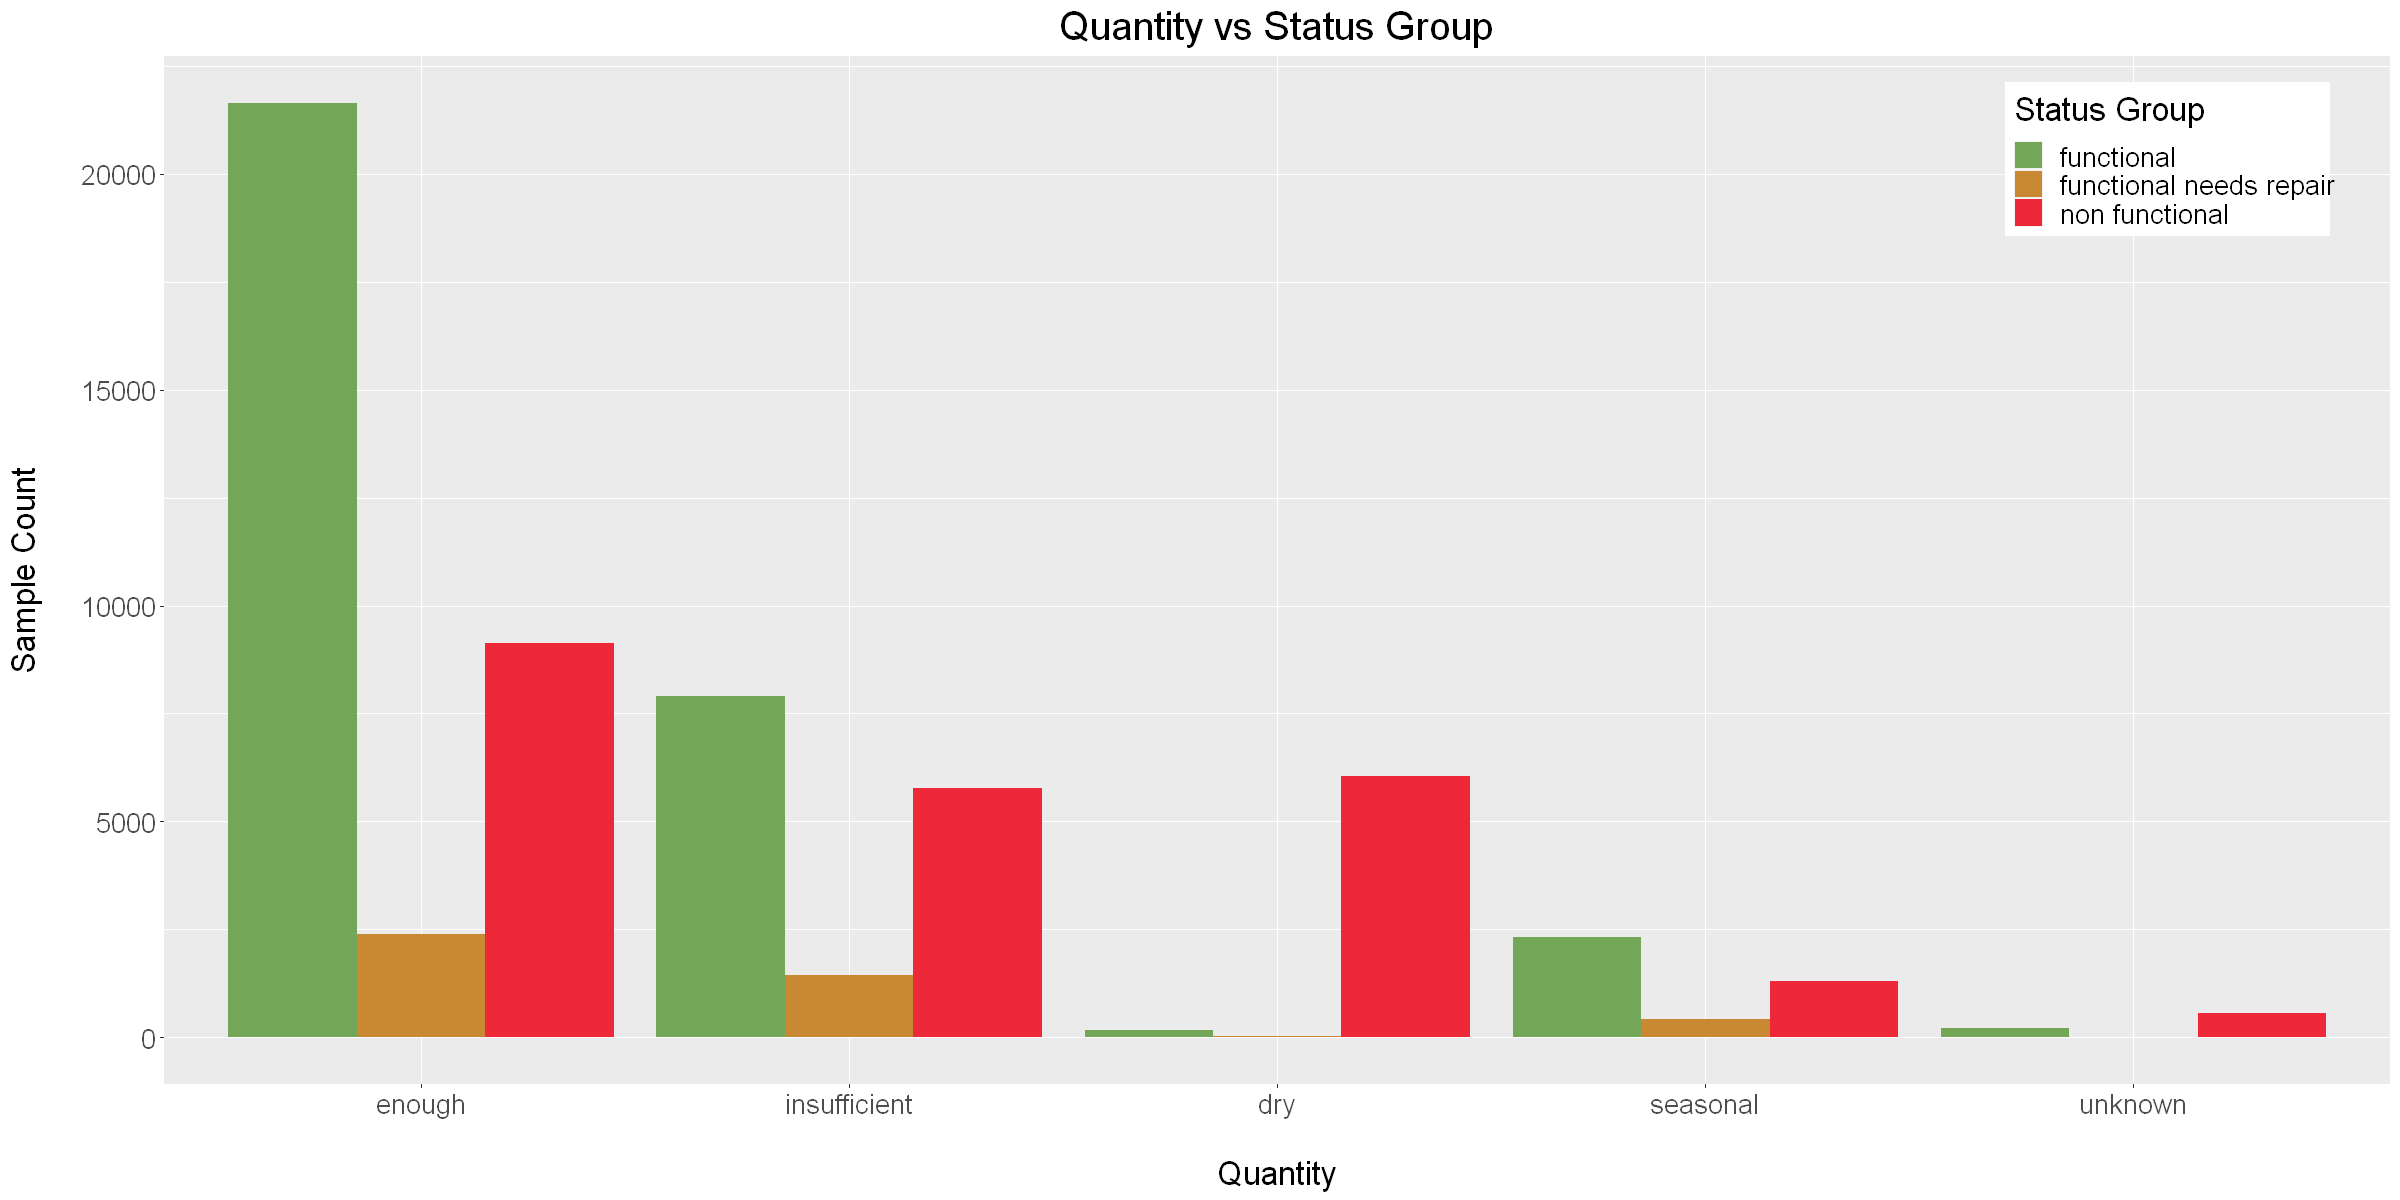

In [146]:
# plot quantity vs status_group
options(repr.plot.width=20, repr.plot.height=10)
to_plot <- subset(features, select = c(quantity, status_group)) 
to_plot$quantity <- with(to_plot, reorder(quantity, quantity, function(x) -length(x)))                                         
ggplot(to_plot, aes(x = quantity, fill=status_group)) +
      geom_bar(position= "dodge") +
      scale_fill_manual("Status Group", values=group_colors) +
      labs(title = "Quantity vs Status Group", y = "Sample Count\n", x = "\nQuantity") +
      theme(plot.title = element_text(hjust = 0.5),
            text = element_text(size=20), 
            legend.position = c(0.9, 0.9))   

### Source

The features source, source_type and source_class are all described as "The source of the water" and are clearly features with the same meaning at a different level of granularity.

The feature source has 10 categories and just further splits up some categories of the source_type feature. Most of these new categories represent a very small number of samples and seem to have a similar distribution with respect to the target variable. However, the split of river/lake into river and lake does seem interesting since lakes seem to be predominantly non functional while rivers are predominantly functional. Therefore, keeping this split might be beneficial.

The feature source_type has 7 categories which are further grouped by the feature source_class into 3 categories. There does seem to be some relevant differences between the 7 categories, however, which are lost in the source_class feature. Therefore, the source_class feature is dropped. 

The feature source_type, enhanced with the split of river/lake into river and lake from the feature source, will be used. Based on the graph below this feature seems to have an influence on the target feature.

<table>
    <tr>
        <th>source_class</th>
        <th>source_type</th>
        <th>source</th>
    </tr>
    <tr>
        <td rowspan="4">groundwater (77%)</td>
    </tr>
    <tr>
        <td>spring (29%)</td>
        <td>spring (29%)</td>
    </tr>
    <tr>
        <td>borehole (20%)</td>
        <td>machine dbh (19%) ; hand dtw (1%)</td>
    </tr>
    <tr>
        <td>shallow well (28%)</td>
        <td>shallow well (28%)</td>
    </tr>  
    <tr>
        <td rowspan="3">surface (22%)</td>
    </tr>
    <tr>
        <td>rainwater harvesting (4%)</td>
        <td>rainwater harvesting (4%)</td>
    </tr>
    <tr>
        <td>river/lake (17%)</td>
        <td>river (16%) ; lake (1%)</td>
    </tr>
    <tr>
        <td>dam (1%)</td>
        <td>dam (1%)</td>
        <td>dam (1%)</td>
    </tr>    
    <tr>
        <td>unknown (0.5%)</td>
        <td>other (0.5%)</td>
        <td>unknown (0.1%) ; other (0.4%)</td>
    </tr>
</table>

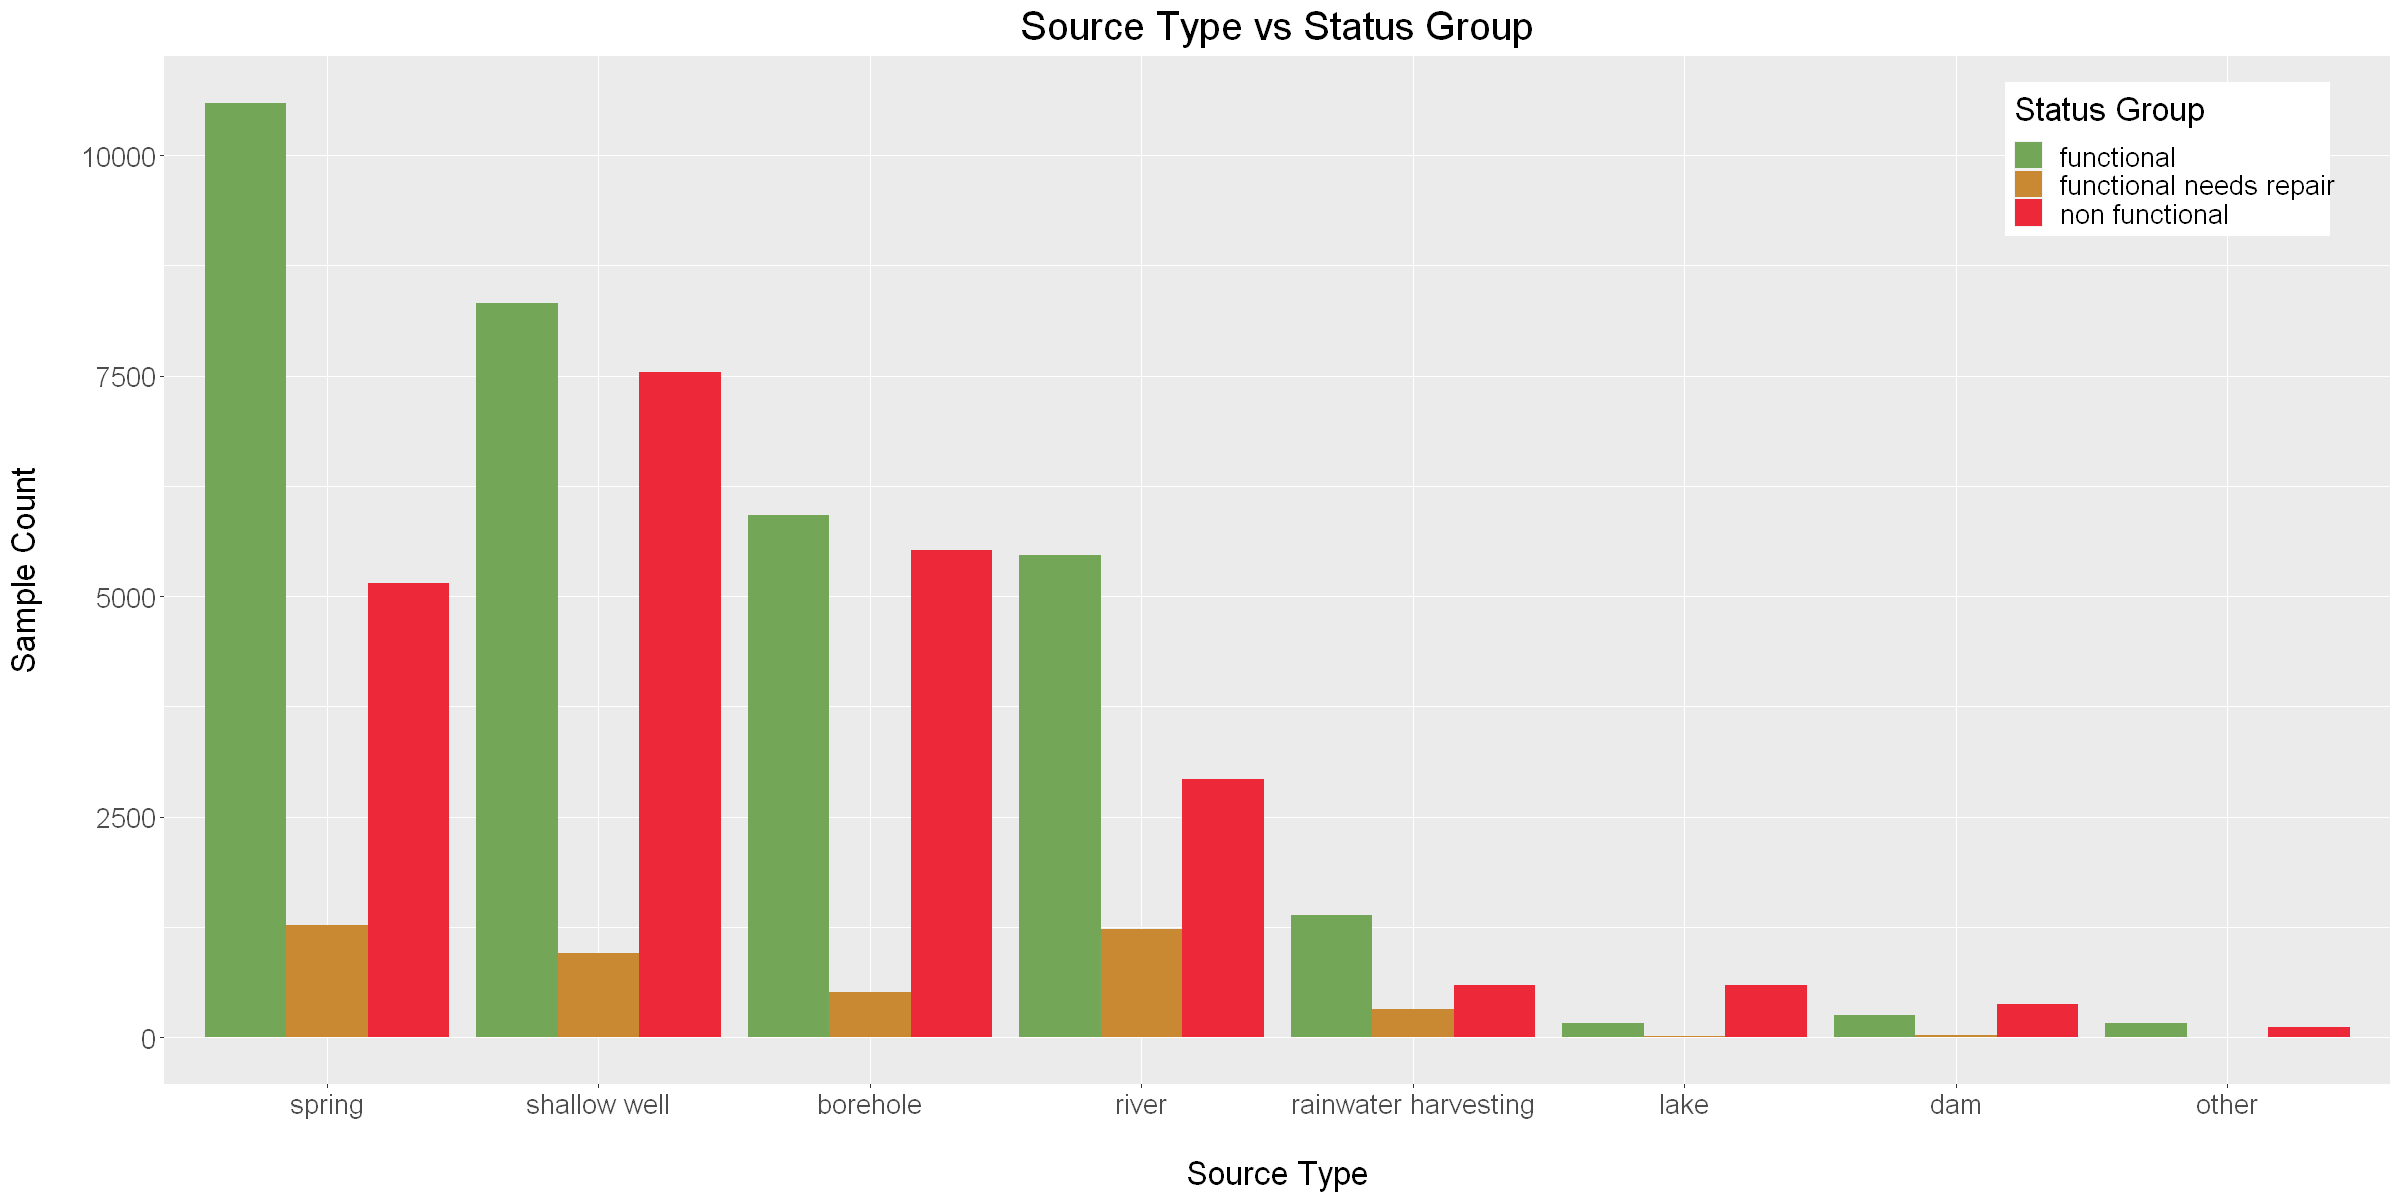

In [147]:
# split river/lake up into river and lake for source_type
features$source_type <- as.character(features$source_type)
features[features$source == 'river', 'source_type'] <- 'river'
features[features$source == 'lake', 'source_type'] <- 'lake'
features$source_type <- as.factor(features$source_type)

# plot source_type vs status_group
options(repr.plot.width=20, repr.plot.height=10)
to_plot <- subset(features, select = c(source_type, status_group)) 
to_plot$source_type <- with(to_plot, reorder(source_type, source_type, function(x) -length(x)))                       
ggplot(to_plot, aes(x = source_type, fill=status_group)) +
      geom_bar(position= "dodge") +
      scale_fill_manual("Status Group", values=group_colors) +
      labs(title = "Source Type vs Status Group", y = "Sample Count\n", x = "\nSource Type") +
      theme(plot.title = element_text(hjust = 0.5),
            text = element_text(size=20), 
            legend.position = c(0.9, 0.9))  

### Waterpoint Type

The features waterpoint_type and waterpoint_type_group are described as "The kind of waterpoint" and are clearly features with the same meaning at a different level of granularity.

The feature waterpoint_type is the same as waterpoint_type_group except that it further splits up the category "communal standpipe" into "communal standpipe" and "communal standpipe multiple". This new category communal standpipe multiple still represents a large part of the samples and produces a very different distribution than the communal standpipe category. It has more non functional than functional pumps while communal standpipe has double the amount of functional pumps with regard to the amount of non functional pumps. Therefore, the feature waterpoint_type is kept and the feature waterpoint_type_group is dropped. Furthermore, the level 'dam' has been added to the 'other' group since it represents only 7 of the 59400 samples and its effect on accuracy will therefore be negligible.

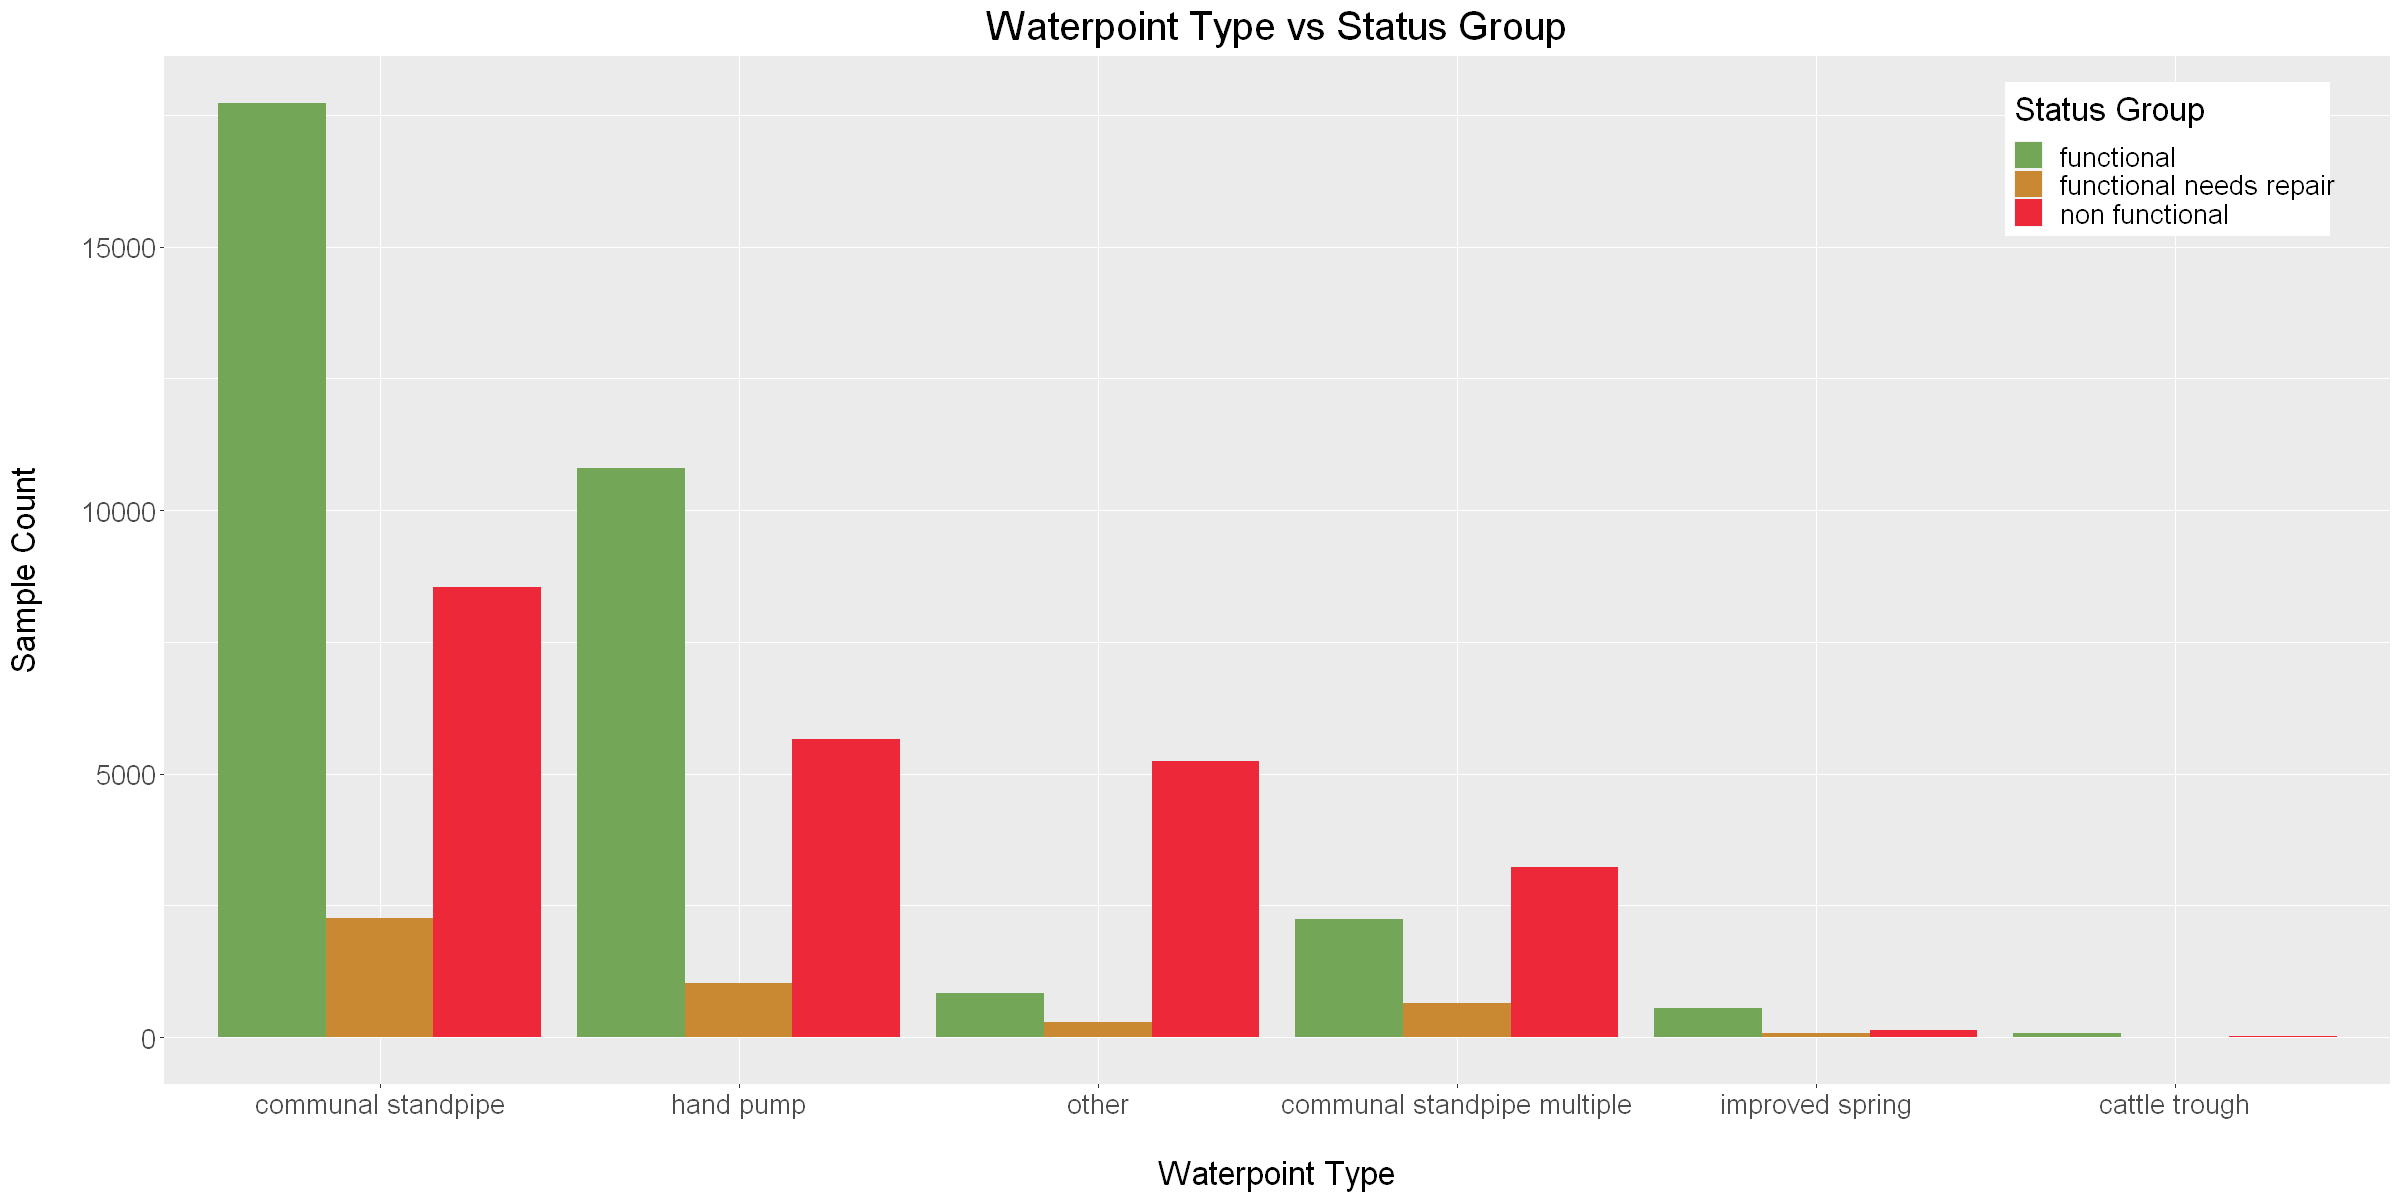

In [148]:
# remove the dam level from waterpoint_type
features[features$waterpoint_type == 'dam', 'waterpoint_type'] <- 'other'

# plot waterpoint_type vs status_group
options(repr.plot.width=20, repr.plot.height=10)
to_plot <- subset(features, select = c(waterpoint_type, status_group)) 
to_plot$waterpoint_type <- with(to_plot, reorder(waterpoint_type, waterpoint_type, function(x) -length(x)))                       
ggplot(to_plot, aes(x = waterpoint_type, fill=status_group)) +
      geom_bar(position= "dodge") +
      scale_fill_manual("Status Group", values=group_colors) +
      labs(title = "Waterpoint Type vs Status Group", y = "Sample Count\n", x = "\nWaterpoint Type") +
      theme(plot.title = element_text(hjust = 0.5),
            text = element_text(size=20), 
            legend.position = c(0.9, 0.9))  

## Missing value imputation

### Prevalence

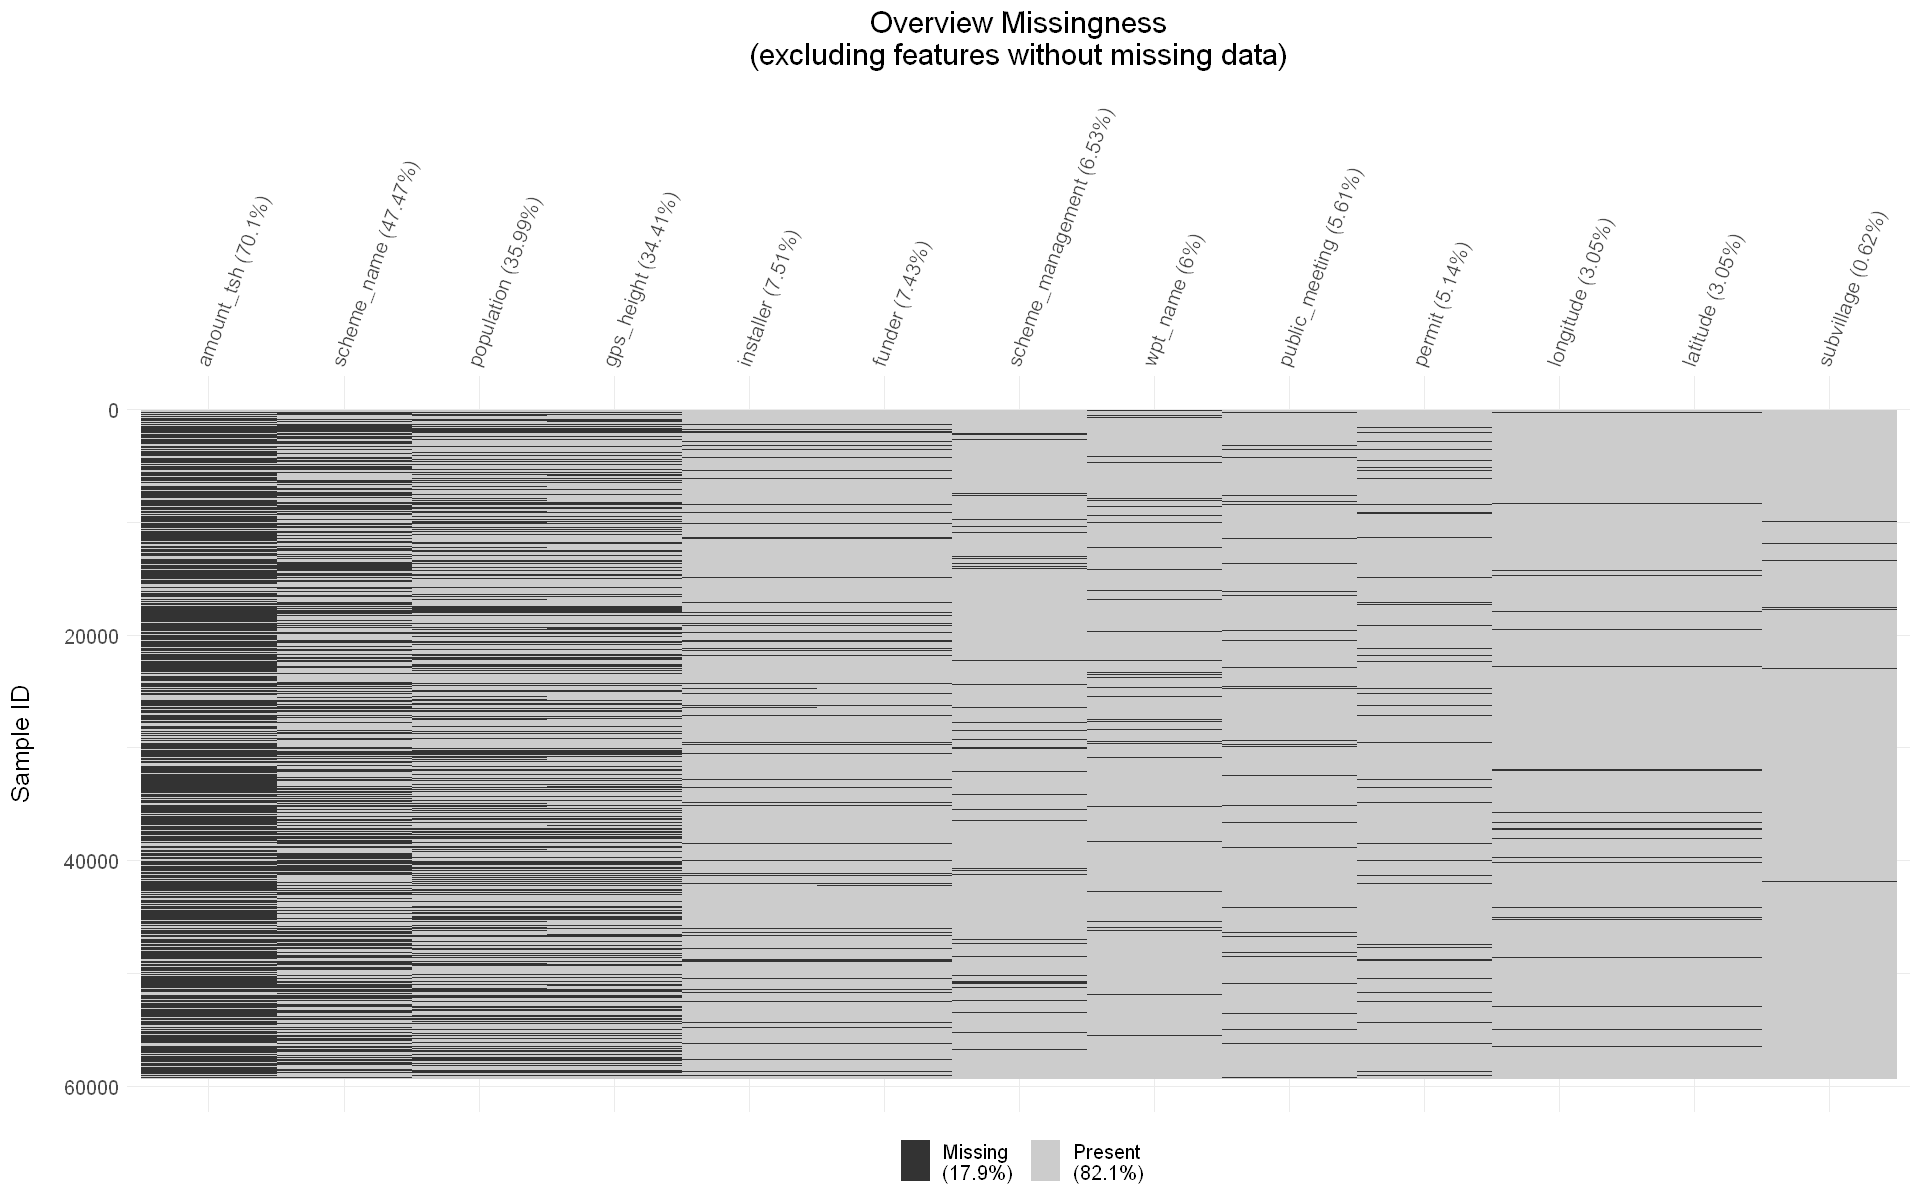

In [149]:
# split up the factor features and the numerical features
factor_feature_names <- which(sapply(X_train[1,], class) == "factor")
factor_features <- X_train[, factor_feature_names]
numerical_features <- X_train[, -factor_feature_names] 

# replace invalid zeroes by NA
numerical_features[numerical_features$longitude == 0,'latitude'] <- NA
numerical_features[numerical_features$longitude == 0,'longitude'] <- NA
numerical_features[numerical_features[,'gps_height'] == 0, 'gps_height'] <- NA
numerical_features[numerical_features[,'population'] == 0, 'population'] <- NA
numerical_features[numerical_features[,'amount_tsh'] == 0, 'amount_tsh'] <- NA

# replace missing categorical levels by NA
factor_features <- merge_levels_missing_values(factor_features, 
                                               to_replace=c('', '-', '0', 'not known', 'none', 'no'), 
                                               replace_with=NA)

# only select the features with missing values
features_missing <- cbind(factor_features, numerical_features)
features_missing <- subset(features_missing, select=names(which(colSums(is.na(features_missing)) > 0)))

# plot a (column sorted) overview of the missing values
options(repr.plot.width=16, repr.plot.height=10)   
vis_miss(features_missing, sort_miss=TRUE) +
theme(plot.title = element_text(hjust = 0.5),
      axis.text.x = element_text(angle = 70),
      text = element_text(size=15)) +
labs(title = "Overview Missingness\n(excluding features without missing data)", y = "Sample ID\n")

The missingness overview shows that the number of missing values does not seem to be related to any specific problematic samples, but rather to certain features. There seem to be some relations between missing values when it comes to the features themselves though, e.g. installer and funder seem to be missing together quite often. 

At this point, however, there seems no reason to look further into any samples and it's better to mostly look at the missing values from a feature standpoint instead of a sample standpoint. As already mentioned during feature analysis, amount_tsh and scheme_name have too many missing values and are dropped while the other features in the overview are imputed.

It should also be noted that *around two thirds of all features had no missing data* and are therefore not shown in the overview above.

### Categorical data

For categorical missing data, we generally kept a separate category 'unknown' for the missing values. The reason for this was there were a relatively large number of missing values and the distribution of the 'unknown' values with respect to the target variable seemed to differ from the most frequent category. Using a separate 'unknown' category, therefore, seemed to be the most appropriate solution.

### Numerical data

**Geographic mean**  
The most used strategy for imputing numerical missing values was to compute a localized mean based on the available geographic information. The idea was that water pumps in each other's vicinity would have more in common when it comes to certain features and would therefore be more trustworthy than replacing it with the global mean.

The general idea was to go over increasingly larger geographic area's and replace each missing value for a specified feature by the mean of the samples within the same geographic area as the sample with the missing value. Only if we could not replace the missing value in this manner a global mean would be used to impute it.

We added the actual R code below and will describe the computation process in pseudo-code here.   
```
Given X, TO_FILL and GEO_INFO  
With X = training data,
     TO_FILL = list of features to check,
     GEO_INFO = list of geographic features  
Do
1. For all features in TO_FILL
    1. For all samples in X with a missing value for the current feature
        For all geographic features in GEO_INFO
          If X still has samples with a missing value for the current feature:
              1. Find all samples in X with the same geographic feature 
                 value as the current sample
              2. Compute the mean value over the found samples for the 
                 current feature
              3. Replace the missing value of the current sample by the 
                 computed mean
    2. If X still has samples with a missing value for the current feature:
        1. Compute the mean value over all samples in X for the current feature 
        2. Replace all remaining missing values for the current feature by 
           this global mean
2. Return the modified X
```

This process was performed for the features
- longitude
- latitude
- gps_height
- population

with the geographic information of
- ward
- region

**Median**  
Since construction_year and by extension the feature pump_age are highly skewed, the median was used to impute their missing values.

In [150]:
# helper function to replace missing numerical values based on the given geographical information
# standard use is for the columns longitude, latitude, gps_height, population and uses the following mean values
# - the mean value of samples in the same ward
# - the mean value of samples in the same region
# - the mean value of all samples otherwise
fill_NA_with_mean_geographical_information <- function(df, 
                                                       to_fill=c('longitude', 'latitude', 'gps_height', 'population'), 
                                                       geo_info=c('ward', 'region')){

    # outer loop: go over all columns with missing values represented as NA
    for (col in to_fill) {       
        # inner loop: go over all specified columns with geographic information
        for (geo in geo_info) {
            
            # if there are still any NA values left, replace them with the mean value
            # of samples that belong to the same geographic location
            idx.col.na <- which(is.na(df[,col]))
            if (any(is.na(df[,col]))) {
                for(idx in idx.col.na) {
                    idx.geo <- df[idx, geo]
                    col.for_geo <- df[df[,geo] == idx.geo, col]
                    col.mean <- mean(col.for_geo, na.rm=TRUE)
                    df[idx, col] <- col.mean
                }
            }
        }
        
        # if there are still NA values left after using the geographical information, 
        # just replace the values by their mean value (mean over the whole column)
        df[is.na(df[,col]), col] <- mean(df[,col], na.rm=TRUE)
    }
    
    return(df)
}

## Feature engineering

### Source

As mentioned during the feature analysis, the source feature is generally too highly detailed but there is one split we would like to keep and include in the feature source_type. This split is river/lake into river and lake.

In [151]:
features$source_type <- as.character(features$source_type)
features[features$source == 'river', 'source_type'] <- 'river'
features[features$source == 'lake', 'source_type'] <- 'lake'
features$source_type <- as.factor(features$source_type)

### Waterpoint_type

As mentioned during the feature analysis, the level 'dam' of the waterpoint_type feature has no representative power so we merge it into the 'other' level.

In [152]:
features[features$waterpoint_type == 'dam', 'waterpoint_type'] <- 'other'

### Low-frequency cutoff

Since funder, installer and also lga have too many small categories, a cutoff value has been added to put all low-frequency categories into an 'other' category. We merged all categories in each of them that were representing less than 1% of all samples into the 'other' category.

In [153]:
# helper function to merge all categories that represent less samples than the specified percentage in cutoff 
merge_low_frequency_levels <- function(df, 
                                       to_merge = c('funder', 'installer', 'lga'), 
                                       merged_level = 'other',
                                       cutoff=0.01) {
    
    # outer loop to go over all columns that needs to be handled
    for (col in to_merge) {
        # compute the frequency per level
        counts <- as.data.frame(prop.table(table(df[,col])))
        
        # get the levels that don't occur more than the cutoff percentage
        low_freq_idx <- which(counts$Freq < cutoff)
        low_freq_level_names <- counts$Var1[low_freq_idx]
        
        # change the low-frequent levels to the level specified in merged_level
        df[,col] <- as.character(df[,col])
        df[df[,col] %in% low_freq_level_names, col] <- merged_level
        df[,col] <- as.factor(df[,col])
    }
    
    return(df)
}

### Season

The date_recorded feature might be too unique and uniformative in its current format, but it allows us to extract the month of the recording. According to World Weather & Climate Information (2021) there are 4 main seasons in Tanzania:
- "short dry" season from January to February
- "long rains" season from March to May, which is the main rainy season
- "long dry" season from June to October, where rainfall is really unusual
- "short rain" from November to December, with some light rain

It seems plausible water pumps have problems during periods of severe and long drought than other periods, so we engineered this knowledge into a new feature called **season** based on the extracted months of date_recorded. 

In [154]:
create_season <- function(df) {
    # extract the months from the recorded dates (but already call the column season)
    months <- extract_from_dates(df$date_recorded, to_extract=c("%m"), titles=c("season"))
    
    # get the index of each category (while the column is still numeric)
    short_dry_idx = which(months <= 2) 
    long_rains_idx = which(months >= 3 & months <= 5) 
    long_dry_idx = which(months >= 6 & months <= 10)
    short_rain_idx = which(months >= 11 & months <= 12)

    # convert to seasonal categories (makes the column a character column)
    months[short_dry_idx,] <- 'short_dry'
    months[long_rains_idx,] <- 'long_rains'
    months[long_dry_idx,] <- 'long_dry'
    months[short_rain_idx,] <- 'short_rain'
    
    # convert to factor column
    months$season <- as.factor(months$season)

    return(months)
}

Based on the graph below, there does indeed seem to be a slightly higher amount of functional water pumps during the season of long rains than the other seasons.

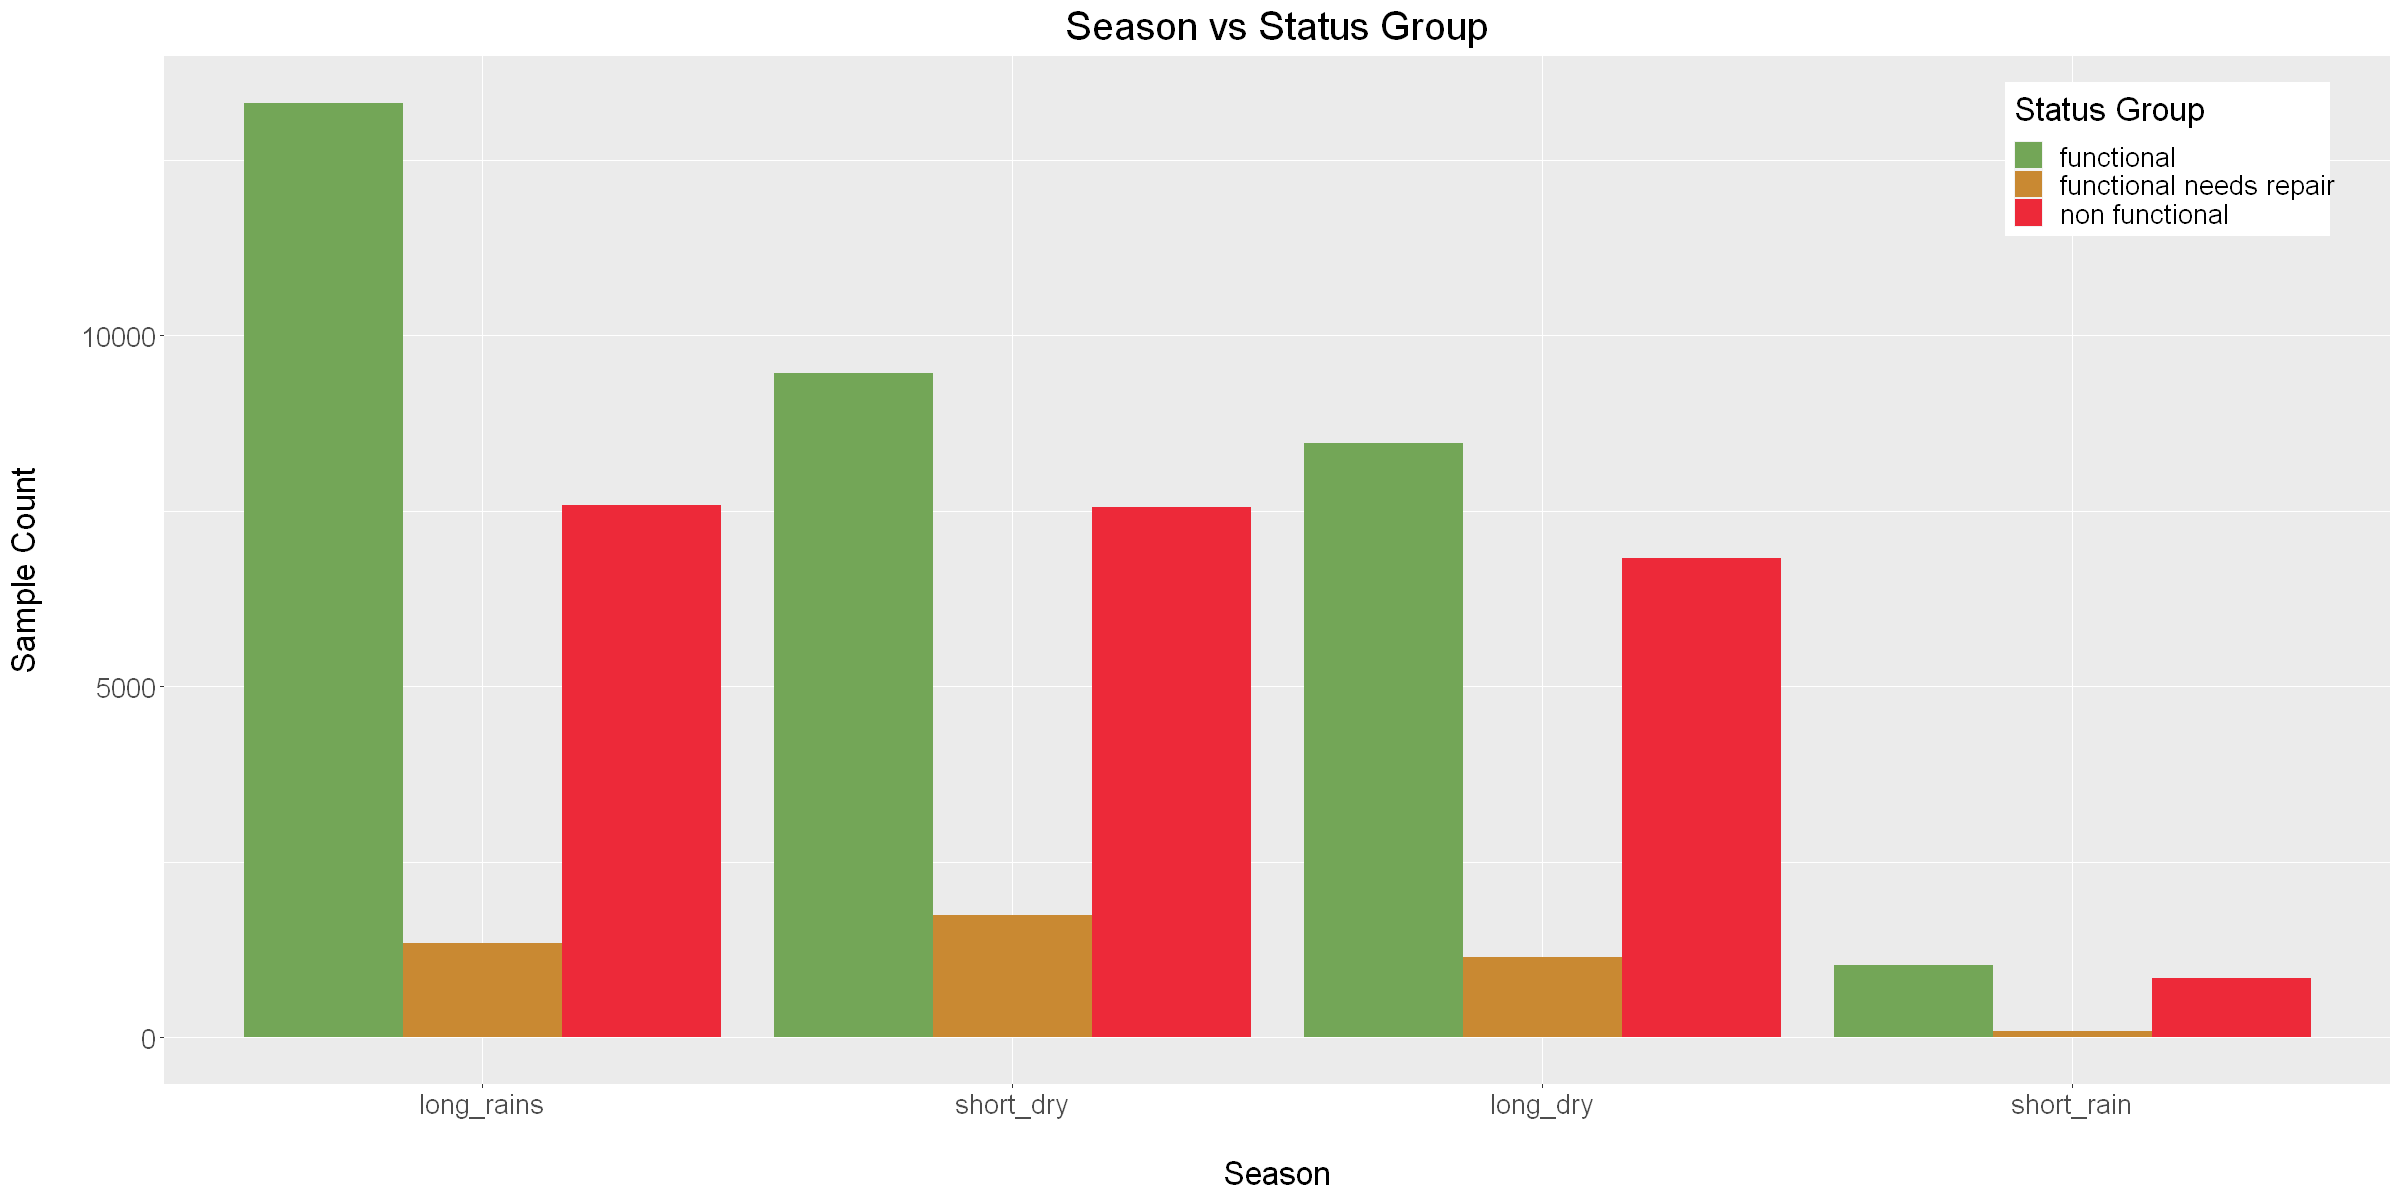

In [155]:
# create the season feature
season <- create_season(features)

# plot season vs status_group
options(repr.plot.width=20, repr.plot.height=10)
to_plot <- cbind(season, subset(features, select=c(status_group)))
to_plot$season <- with(to_plot, reorder(season, season, function(x) -length(x)))                       
ggplot(to_plot, aes(x = season, fill=status_group)) +
      geom_bar(position= "dodge") +
      scale_fill_manual("Status Group", values=group_colors) +
      labs(title = "Season vs Status Group", y = "Sample Count\n", x = "\nSeason") +
      theme(plot.title = element_text(hjust = 0.5),
            text = element_text(size=20), 
            legend.position = c(0.9, 0.9))  

### Pump age

Although the construction year itself might have some influence as well, the biggest influence probably has to do with the age of the pump. This age can be computed by subtracting the construction_year from the year present in date_recorded.

As mentioned during feature analysis there are a lot of missing values in construction_year and there are some discrepancies between recorded_by and construction_year. Some samples were supposedly constructed after the record of the sample was already taken. Both these missing values and the mistakes will be corrected for the pump_age by using the median, since pump_age has a highly skewed distribution.

In [156]:
create_pump_age <- function(df) {
    # replace the 0 values in construction_year by NA
    replaced_construction_year <- replace(data=df$construction_year, to_replace=c(0))
    
    # extract the years from the recorded dates (but already call the column pump_age)
    dates <- extract_from_dates(df$date_recorded, to_extract=c("%Y"), titles=c("pump_age"))
    
    # compute the pump_age
    dates$pump_age <- dates$pump_age-replaced_construction_year
    
    # replace the negative values (data discrepancies) by NA
    dates[!is.na(dates$pump_age) & dates$pump_age < 0,] <- NA
    
    return(dates)
}

In [157]:
pump_age <- create_pump_age(features)

# replace the NA values by the median age 
pump_age$pump_age <- replace(pump_age$pump_age, NA, median(na.omit(pump_age$pump_age)))

Since recorded_by has most of its values between 2010 and 2013 pump_age seems close to just have the inverse relation to status_group as construction_year had. Nevertheless, we will keep pump_age instead of construction_year since it's easier to interpret without having domain knowledge about the kind of pumps that were used during specific periods (in which case the construction year might also be indicative of the quality). 

|                   | Min        | 1st Quartile | Median     | Mean       | 3rd Quartile | Max        |
|:-------------------:|:------------:|:--------------:|:------------:|:------------:|:--------------:|:------------:|
| **pump_age**     | 0 | 8   | 13 | 15 | 16   | 53 |

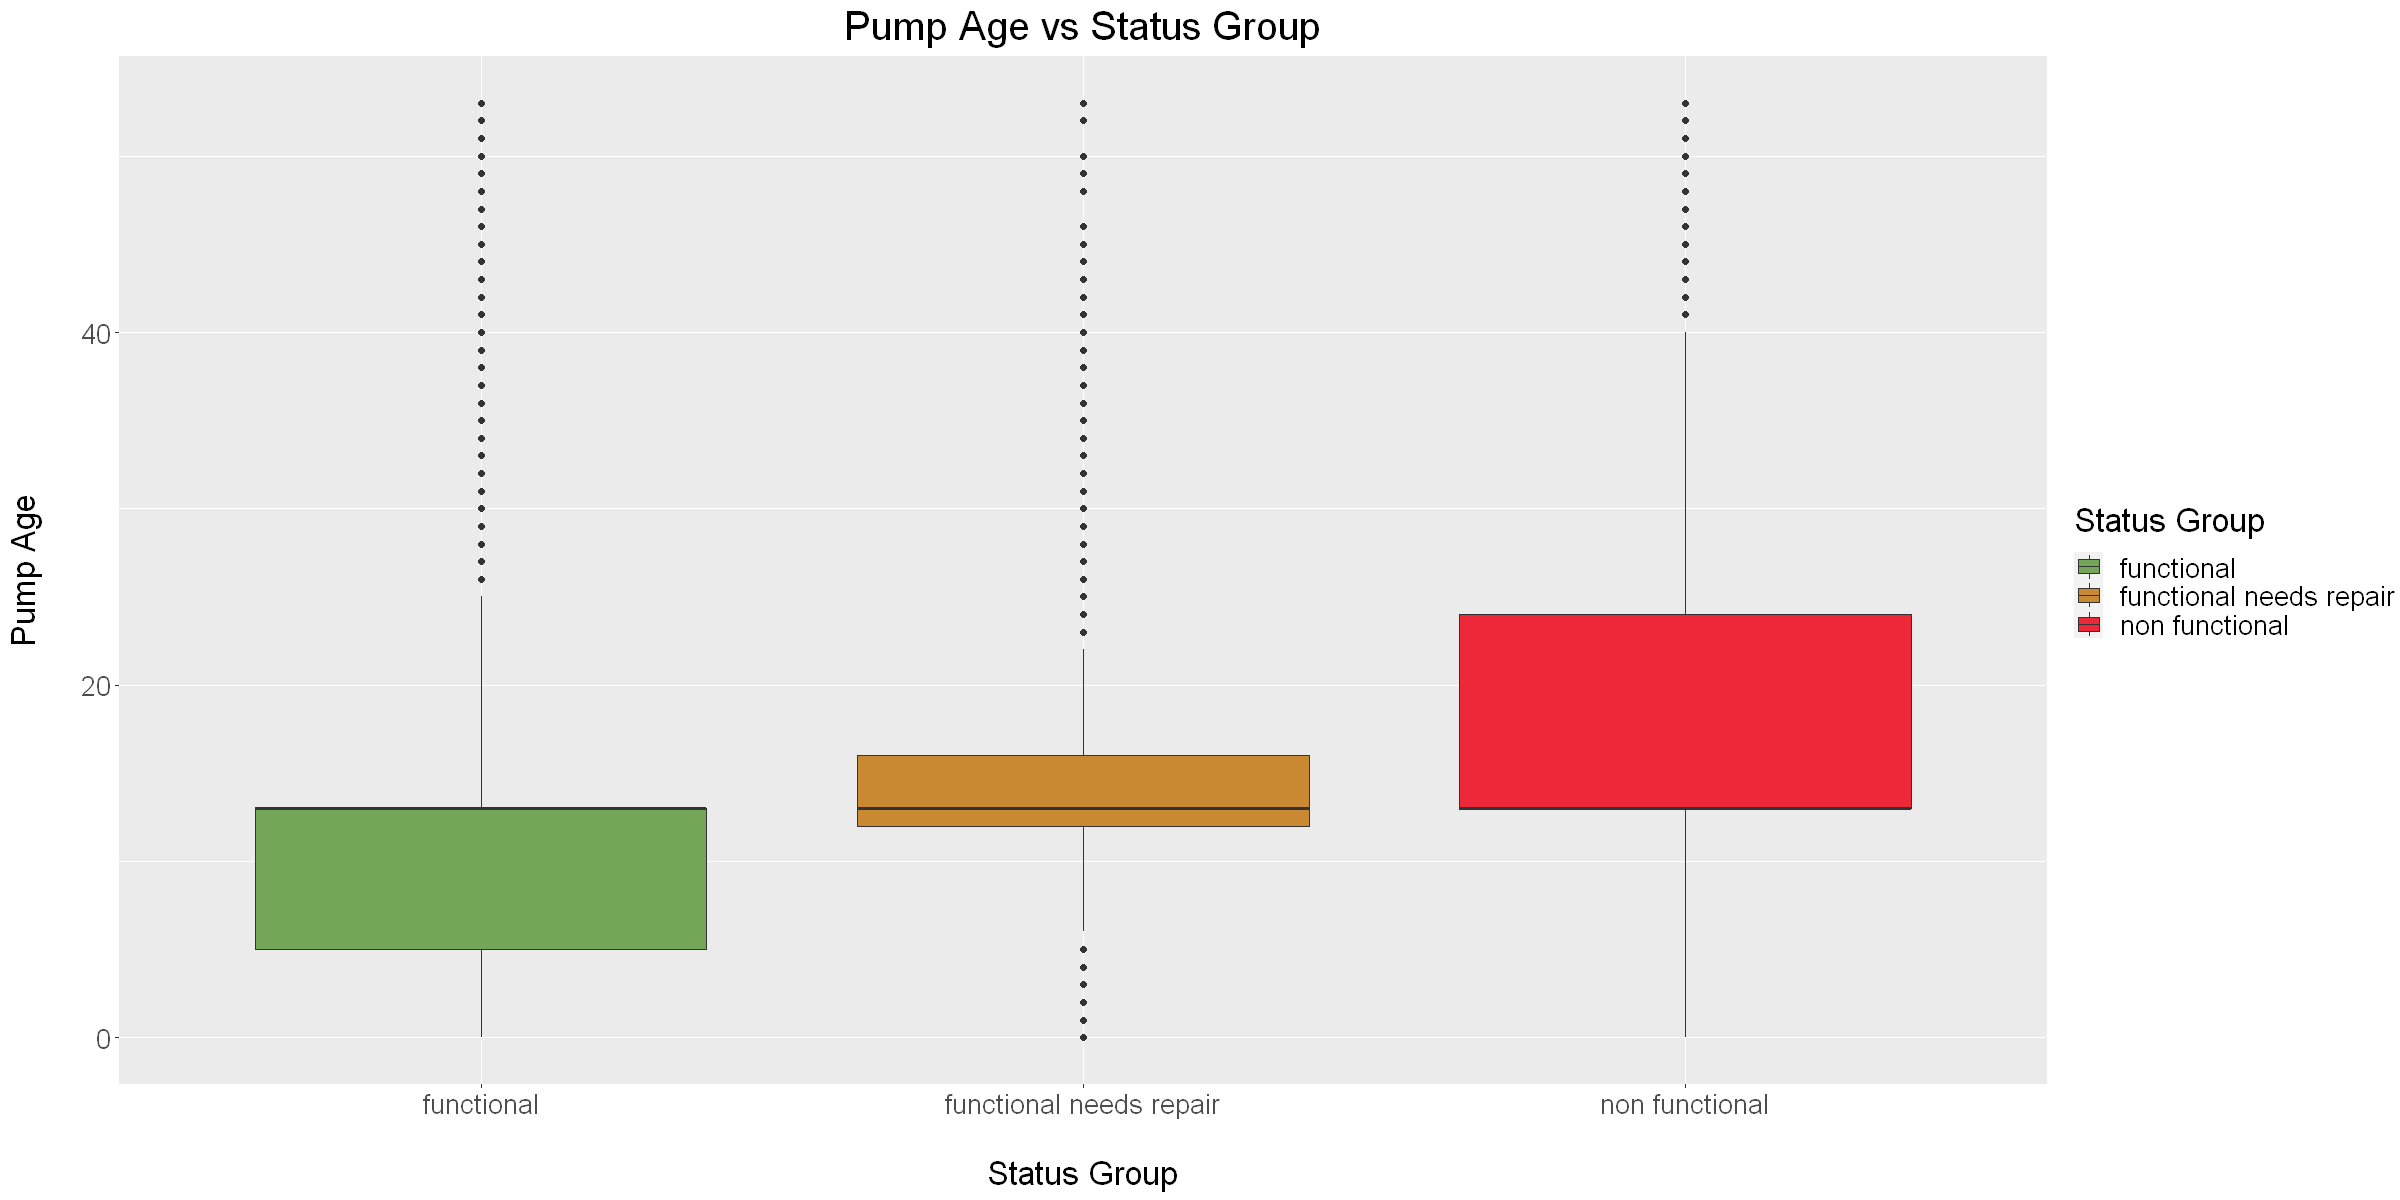

In [158]:
# plot pump_age vs status group boxplots
options(repr.plot.width=20, repr.plot.height=10)
to_plot <- cbind(pump_age, subset(features, select=c(status_group)))
ggplot(to_plot, aes(x = status_group, y = pump_age, fill = status_group)) + 
       geom_boxplot() +
       scale_fill_manual("Status Group", values=group_colors) +
       labs(title = "Pump Age vs Status Group", y = "Pump Age\n", x = "\nStatus Group") +
       theme(plot.title = element_text(hjust = 0.5),
             text = element_text(size=20))

## Feature selection

Most of our feature selection occurred through the manual feature analysis described in the earlier sections.  
However, due to the need for one-hot encoding and the high number of feature levels automatic feature selection has been added as well. To manage computational resources with our relatively big dataset, we decided to use 80 features (or around half) of the one-hot encoded data set. These 80 features have been selected through mRMR.

# MRMR

Maximum Relevance, Minimum Redundancy is an automatic feature selection technique which takes conditional information between features into account. A feature on its own could have very little to say but combined with anoher it could be very informative. The goal of mRMR is to detect these relationships and select features based on this. The technique will start with the most informative feature and each iteration it will select a new feature that both minimizes redundancy with the previously selected features and maximizes relevancy with the output label (y). In this application we use correlation to assess relevancy and redundancy.
To calculate correlation between a feature and the output label, the labels need to be numeric.

 This is currently not the case but (as mentioned before) we can interpret the categorical labels as ordinal using following transformation:

- Non functional : **1**
- Functional needs repair: **2**
- Functional: **3**

This transformation will be performed in the pipeline.

**How it works**

On the k'th iteration we select a new feature based on the following rule:

$$argmax_{x_{k}\in X-X_S}\left[ c(x_k, y) - \frac{1}{m} \sum_{x_i\in X_S} c(x_i,x_k) \right]$$

With:
- $c()$ : The correlation function
- $X$: The total set of features
- $X_S$ the selected features so far
- $m$ the size of $X_S$
- $y$ the label to be predicted

This procedure will be repeated n times in the pipeline to select n features, as specified in the pipeline argument: **n_var**. This argument represents the number of features that should be kept.

In [159]:
mRMR <- function(X,Y,n_features){
    n <- ncol(X)
    correlation<-abs(cor(X,Y))
    selected<-c()
    candidates<-1:n
    
    for (j in 1:n_features) {
        
        redundancy_score<-numeric(length(candidates))

        if (length(selected)>0) {
            # Compute the correlation between the selected variables and the candidates on the training set
            cor_selected_candidates<-cor(X[,selected,drop=F],X[,candidates,drop=F])
            # Compute the mean correlation for each candidate variable, across the selected variables
            redundancy_score<-apply(cor_selected_candidates,2,mean)
        }

        # mRMR: minimum Redundancy Maximum Relevancy
        mRMR_score<-correlation[candidates]-redundancy_score

        # Select the candidate variable that maximises the mRMR score
        selected_current<-candidates[which.max(mRMR_score)]
        selected<-c(selected,selected_current)

        # Remove the selected variables from the candidates
        candidates<-setdiff(candidates,selected_current)
    }
    
    return(colnames(X[selected]))
}

**Most important features according to mRMR**  

Although the number of features that should be selected can only really be assessed during model selection, it seems interesting to already take a look at the top 10 of most important features according to mRMR.

This top 10 (after one-hot encoding) is:
1. quantity_dry
2. quantity_enough
3. quantity_insufficient
4. waterpoint_type_other
5. waterpoint_type_communal_standpipe
6. extraction_type_class_handpump
7. extraction_type_class_other
8. waterpoint_type_communal_standpipe_multiple
9. pump_age
10. extraction_type_class_gravity

The importance of quantity is very clear here as well, next to waterpoint_type and extraction_type_class. It is also interesting to notice that our engineered feature pump_age ranks fairly high considering there around 200 features available after one-hot encoding (before mRMR selection).

## Preprocessing pipeline

In the previous sections we have already explained why certain design choices were made. This section will therefore only show how the design choices mentioned in the previous sections are streamlined into a usable preprocessing pipeline.

First we we will give a description in pseudo-code, followed by actual R code which is also well-documented with comments.  
Our pipeline in pseudo-code:
```
Given X, Y, ENCODE, NORM and N_VAR 
With X = training data,
     Y = training labels,
     ENCODE, NORM = boolean,
     N_VAR = integer
Do
1. Add new features to X:
    1. Create season (= binned date_recorded[month])
    2. Create pump_age (= date_recorded[year] - construction_year)
2. Modify features of X:
    1. Convert numerical feature district_code to categorical (factor)
    2. Split source_type 'river/lake' entries into 'river' and 'lake'
    3. Merge waterpoint_type 'dam' entries into 'other'
3. Split up features of X into numerical and categorical features
4. For all numerical features:
    1. If feature is one of (longitude, latitude, gps_height, population): 
        Impute missing values (zero) by their geographical mean
    2. Drop redundant features
5. For all categorical features:
    1. Drop redundant features
    2. Convert feature levels to lowercase
    3. If feature is one of (funder, installer, lga):
        Merge low-frequent levels (containing < 1% of samples) into 'other'
    4. If ENCODE = TRUE: 
        Perform one-hot encoding
    5. Remove problematic separators in feature names (replace ' ', '-', '/' by '_')
6. Merge the modified numerical and categorical features back into one set
7. If ENCODE = TRUE: 
    1. Rank features by performing mRMR on the merged feature set and Y
    2. Shrink the feature set to the specified number (N_VAR) of highest ranking features
8. If NORM = TRUE:
    Scale all features 
9. Return the resulting feature set
```

It is important to note that dropping redundant features happens fairly late in the pipeline process, but this is necessary because some of these features were still needed in the imputation of missing values (i.e. in the computation of the geographical mean). This delay should, however, not have a noticable influence on performance.  

Furthermore, the preprocessing pipeline also delivers an object with additional information needed for preprocessing the test dataset. This objects contains information for scaling, filtering,... the test data set based on the training data during its own preprocessing. The build of this preprocessing object was omitted in the description above for clarity reasons.

In [160]:
# function containing the whole preprocessing pipeline for training data
# - Y can be given in case mRMR needs to be performed (to be able to compute correlations with target feature)
# - one_hot_encoding is a boolean specifying whether we want our categorical data to be one-hot encoded
# - norm specifies whether all features should be scaled (only possible if one_hot_encoding is also TRUE)
# - n_var specifies the number of features to keep based on mRMR (only possible if one_hot_encoding is also TRUE)
preprocess_data <- function(X, Y = NULL, one_hot_encoding = TRUE, norm = FALSE, n_var = NULL) {
    # list to keep all information needed to preprocess test
    test_preprocessing_information <- list()
    # already keep ward and region for geographic mean computations (before they are dropped)
    test_preprocessing_information$ward <- X$ward
    test_preprocessing_information$region <- X$region
    
    # add new features
    season <- create_season(X)
    pump_age <- create_pump_age(X) 
    # replace the NA values by the median age 
    median_pump_age <- median(na.omit(pump_age$pump_age))
    pump_age$pump_age <- replace(pump_age$pump_age, NA, median_pump_age)
    X <- cbind(X, season, pump_age)
    
    # keep median for pump_age imputation in test set
    test_preprocessing_information$median_pump_age <- median_pump_age
    
    # convert district_code to a factor
    X$district_code <- as.factor(X$district_code)
    
    # split river/lake up into river and lake for source_type
    X$source_type <- as.character(X$source_type)
    X[X$source == 'river', 'source_type'] <- 'river'
    X[X$source == 'lake', 'source_type'] <- 'lake'
    X$source_type <- as.factor(X$source_type)
    
    # remove the dam level from waterpoint_type
    X[X$waterpoint_type == 'dam', 'waterpoint_type'] <- 'other'
        
    # split up the factor features and the numerical features
    factor_feature_names <- which(sapply(X[1,], class) == "factor")
    factor_features <- X[, factor_feature_names]
    numerical_features <- X[, -factor_feature_names]
    
    # HANDLING NUMERICAL FEATURES
    
    # if longitude is zero (which is a missing value), 
    # then latitude is a random very small value and should be considered missing as well
    numerical_features[numerical_features$longitude == 0,'latitude'] <- NA
    numerical_features[numerical_features$longitude == 0,'longitude'] <- NA
    
    # replace other missing zero values zero values with NA 
    numerical_features[numerical_features[,'gps_height'] == 0, 'gps_height'] <- NA
    numerical_features[numerical_features[,'population'] == 0, 'population'] <- NA
      
    # replace NA with the mean over the smallest geographic location possible
    numerical_features <- fill_NA_with_mean_geographical_information(X)[,-factor_feature_names]
    
    # keep values for geographic mean computations in test set
    test_preprocessing_information$longitude <- numerical_features$longitude
    test_preprocessing_information$latitude <- numerical_features$latitude
    test_preprocessing_information$gps_height <- numerical_features$gps_height
    test_preprocessing_information$population <- numerical_features$population
          
    # drop uninformative features
    numerical_features <- subset(numerical_features, select = -c(id, num_private, amount_tsh, 
                                                                 construction_year, region_code))
    factor_features <- subset(factor_features, select = -c(date_recorded, recorded_by, wpt_name,
                                                           subvillage, ward, payment_type,
                                                           scheme_name, extraction_type_group, extraction_type,
                                                           quality_group, quantity_group, source,
                                                           source_class, waterpoint_type_group, management)) 
   
    # HANDLING CATEGORICAL FEATURES
    
    # convert all factor levels (or categories) to lowercase
    factor_features <- tolower_levels(factor_features)
    
    # merge multiple missing values representations to 1 missing value reprentation 'unknown'
    factor_features <- merge_levels_missing_values(factor_features, 
                                                   to_replace=c('', '-', '0', 'not known', 'none', 'no'), 
                                                   replace_with='unknown')
    
    # merge low frequency levels (representing < 1% of samples) 
    # of funder, installer and lga into 'other' to avoid dimensionality explosion
    factor_features <- merge_low_frequency_levels(factor_features, 
                                                  to_merge = c('funder', 'installer', 'lga'),
                                                  merged_level = 'other',
                                                  cutoff=0.01)  
    
    # keep remaining levels after cutoff for use in the test set
    test_preprocessing_information$funder_lvl <- levels(factor_features$funder)
    test_preprocessing_information$installer_lvl <- levels(factor_features$installer)
    test_preprocessing_information$lga_lvl <- levels(factor_features$lga)
    
    # perform one-hot encoding if requested
    if(one_hot_encoding) { 
        # create dummy variables for the categories
        factor_features <- dummy.data.frame(factor_features, sep="_")
    }
    
    # remove any separators in column names that could cause problems
    factor_features <- replace_separators_in_feature_names(factor_features, to_replace = c(' ','-','/'), replace_with = '_')
    # remove duplicate _
    factor_features <- replace_separators_in_feature_names(factor_features, to_replace = c('__','___'), replace_with = '_')
    
    X <- cbind(numerical_features, factor_features)
    
    if(one_hot_encoding & !is.null(n_var) & !is.null(Y)){
        numeric_Y <- as.numeric(factor(Y$status_group,levels=c("non functional","functional needs repair","functional")))
        mRMR_features <- mRMR(X, numeric_Y, n_var)
        X <- X[mRMR_features]
        
        # track kept features for test set preprocessing
        test_preprocessing_information$mRMR_features <- mRMR_features
    }

    
    if (one_hot_encoding & norm){
        X_scaled <- scale_train(X)
        X <- X_scaled$X_train
        
        # keep scales for test set scaling
        test_preprocessing_information$means <- X_scaled$X_means
        test_preprocessing_information$sdevs <- X_scaled$X_sdevs
    }
    
    return(list(preprocessed_X=X, test_prep_info=test_preprocessing_information))
}

The preprocessing pipeline for test data is functionally equal to the preprocessing pipeline for training data, except that some parts are based on information from the earlier preprocessing of the training data to prevent any possible data leaks. 
The test data preprocessing makes use of an information object from the training data preprocessing to:
- replace missing values by a median computed on the training data
- replace missing values by a geographic mean computed on the training data
- merge all low-frequency levels in installer, funder and lga based on their frequency in training data
- keep the features selected by mRMR in the training data
- scale the features based on the scaling information from the training data

In [161]:
# function containing the whole preprocessing pipeline for test data,
# basic functioning is the same as preprocessing for training data, but scaling, feature filtering,...
# is based on information from the preprocessed training set to avoid data leakage.
# This information is available via the test_prep_info object.
preprocess_test_data <- function(X_test, test_prep_info, one_hot_encoding = TRUE, norm = FALSE, n_var = NULL) {
    # keep track of the id column
    id <- subset(X_test, select = c(id))
    
    # Include seasonal information    
    # Test set
    season_test <- create_season(X_test)
    pump_age_test <- create_pump_age(X_test) 
    
    pump_age_test$pump_age <- replace(pump_age_test$pump_age, NA, test_prep_info$median_pump_age)   
    
    X_test <- cbind(X_test, season_test, pump_age_test)
    
    # convert district_code to a factor
    X_test$district_code <- as.factor(X_test$district_code)
    
    # split river/lake up into river and lake for source_type
    X_test$source_type <- as.character(X_test$source_type)
    X_test[X_test$source == 'river', 'source_type'] <- 'river'
    X_test[X_test$source == 'lake', 'source_type'] <- 'lake'
    X_test$source_type <- as.factor(X_test$source_type)
    
    # remove the dam level from waterpoint_type
    X_test[X_test$waterpoint_type == 'dam', 'waterpoint_type'] <- 'other'
        
    # split up the factor features and the numerical features
    factor_feature_names_test <- which(sapply(X_test[1,], class) == "factor")
    factor_features_test <- X_test[, factor_feature_names_test]
    numerical_features_test <- X_test[, -factor_feature_names_test]
    
    # HANDLING NUMERICAL FEATURES
    
    # if longitude is zero (which is a missing value), 
    # then latitude is a random very small value and should be considered missing as well
    numerical_features_test[numerical_features_test$longitude == 0,'latitude'] <- NA
    numerical_features_test[numerical_features_test$longitude == 0,'longitude'] <- NA
    
    # replace other missing zero values zero values with NA 
    numerical_features_test[numerical_features_test[,'gps_height'] == 0, 'gps_height'] <- NA
    numerical_features_test[numerical_features_test[,'population'] == 0, 'population'] <- NA
    
    
    
    # replace NA with the mean over the smallest geographic location possible
    geo_info <- data.frame(longitude=test_prep_info$longitude, latitude=test_prep_info$latitude,
                           gps_height=test_prep_info$gps_height,population=test_prep_info$population,
                           ward=test_prep_info$ward,region=test_prep_info$region)
    numerical_features_test  <- fill_NA_with_mean_geographical_information_TEST(numerical_features_test, geo_info)
    
    # drop features
    # Does not drop the id for creation of a submission
    numerical_features_test <- subset(numerical_features_test, select = -c(id,num_private, amount_tsh, 
                                                                 construction_year, region_code))
    factor_features_test <- subset(factor_features_test, select = -c(date_recorded, recorded_by, wpt_name,
                                                           subvillage, ward, payment_type,
                                                           scheme_name, extraction_type_group, extraction_type,
                                                           quality_group, quantity_group, source,
                                                           source_class, waterpoint_type_group, management))
   
    # HANDLING CATEGORICAL FEATURES
    # convert all factor levels (or categories) to lowercase
    factor_features_test <- tolower_levels(factor_features_test)
    
    # merge multiple missing values representations to 1 missing value reprentation 'unknown'
    factor_features_test <- merge_levels_missing_values(factor_features_test, 
                                                   to_replace=c('', '-', '0', 'not known', 'none', 'no'), 
                                                   replace_with='unknown')
    
    # merge low frequency levels (representing < 1% of samples in training data) 
    # of funder, installer and lga into other to avoid dimensionality explosion   
    factor_features_test[,'funder'] <- as.character(factor_features_test[,'funder'])
    factor_features_test[!(factor_features_test[,'funder'] %in% test_prep_info$funder_lvl), 'funder'] <- 'other'
    factor_features_test[,'funder'] <- as.factor(factor_features_test[,'funder'])
    
    factor_features_test[,'installer'] <- as.character(factor_features_test[,'installer'])
    factor_features_test[!(factor_features_test[,'installer'] %in% test_prep_info$installer_lvl), 'installer'] <- 'other'
    factor_features_test[,'installer'] <- as.factor(factor_features_test[,'installer'])
    
    factor_features_test[,'lga'] <- as.character(factor_features_test[,'lga'])
    factor_features_test[!(factor_features_test[,'lga'] %in% test_prep_info$lga_lvl), 'lga'] <- 'other'
    factor_features_test[,'lga'] <- as.factor(factor_features_test[,'lga'])
    
    # perform one-hot encoding if requested
    if(one_hot_encoding) {
        # create dummy variables for the categories
        factor_features_test <- dummy.data.frame(factor_features_test, sep="_")
    }
    
    # remove any separators in column names that could cause problems
    factor_features_test <- replace_separators_in_feature_names(factor_features_test, to_replace = c(' ','-','/'), replace_with = '_')
    
    # remove duplicate _
    factor_features_test <- replace_separators_in_feature_names(factor_features_test, to_replace = c('__','___'), replace_with = '_')

    X_test <- cbind(numerical_features_test, factor_features_test)
    
    # keep only the filtered features from the training set
    if(one_hot_encoding & !is.null(n_var)){        
        X_test <- X_test[test_prep_info$mRMR_features]
    }
    
    if (one_hot_encoding & norm){
        X_test <- scale(X_test, test_prep_info$means, test_prep_info$sdevs)
    }
    
    X_test <- cbind(id, X_test)
    
    return(X_test)
}

### Feature Preprocessing Summary

| Feature               | Preprocessing Actions                                                     |
|:----------------------|:--------------------------------------------------------------------------|
| amount_tsh            | Dropped                                                                   |
| date_recorded         | Creation season & pump_age ; Dropped                                      |
| funder                | Merged missing values (unknown) ; Merged low-frequent levels (other)        |
| gps_height            | Missing values imputed by geographic mean                                 |
| installer             | Merged missing values (unknown) ; Merged low-frequent levels (other)        |
| longitude             | Missing values imputed by geographic mean                                 |
| latitude              | Missing values imputed by geographic mean                                 |
| wpt_name              | Dropped                                                                   |
| num_private           | Dropped                                                                   |
| basin                 | Merged missing values (unknown)                                                   |
| subvillage            | Dropped                                                                   |
| region                | Merged missing values (unknown)                                           |
| region_code           | Dropped                                                                   |
| district_code         | Categorized (Converted to factor)                                         |
| lga                   | Merged low-frequent levels (other)                                                 |
| ward                  | Dropped                                                                   |
| population            | Missing values imputed by geographic mean                                 |
| public_meeting        | Merged missing values (unknown)                                                                  |
| recorded_by           | Dropped                                                                   |
| scheme_management     | Merged missing values (unknown)                                           |
| scheme_name           | Dropped                                                                   |
| permit                | Merged missing values (unknown)                                                               |
| construction_year     | Creation pump_age ; Dropped                                               |
| extraction_type       | Dropped                                                                   |
| extraction_type_group | Dropped                                                                   |
| extraction_type_class | Merged missing values (unknown)                                           |
| management            | Dropped                                                                   |
| management_group      | Merged missing values (unknown)                                           |
| payment               | Merged missing values (unknown)                                           |
| payment_type          | Dropped                                                                   |
| water_quality         | Merged missing values (unknown)                                           |
| quality_group         | Dropped                                                                   |
| quantity              | Merged missing values (unknown)                                           |
| quantity_group        | Dropped                                                                   |
| source                | Dropped                                                                   |
| source_type           | Split up river/lake                                                       |
| source_class          | Dropped                                                                   |
| waterpoint_type       | Merged missing values (unknown) ; Merged 'dam' into 'other'                                    |
| waterpoint_type_group | Dropped                                                                   |
| NEW: season           | seasonal binning of date_recorded years                                   |
| NEW: pump_age         | date_recorded[year] - construction_year ; Invalid values imputed by median  |

### Preprocessed data

In [162]:
# all different types of preprocessed data have already been stored,
# so not needed to rerun for correct functioning of other cells
# the warnings are produced since we use the dummies library: 
# https://stackoverflow.com/questions/56637183/warning-message-dummy-from-dummies-package
if (RUN_LONG_COMPUTATIONS){
    # categorical preprocessing (no encoding)
    one_hot <- FALSE
    mrmr_variables <- NULL
    normalize <- FALSE

    X_preprocessed_info <- preprocess_data(X_train, Y_train, one_hot_encoding = one_hot, norm = normalize, n_var = mrmr_variables)
    X_preprocessed <- X_preprocessed_info$preprocessed_X
    X_test_prep_info <- X_preprocessed_info$test_prep_info

    Dn_preprocessed <- cbind(X_preprocessed, subset(Y_train, select= c(status_group)))
    Dn_test_preprocessed <- preprocess_test_data(X_test, X_test_prep_info, one_hot_encoding = one_hot, norm = normalize, n_var = mrmr_variables)

    saveRDS(Dn_preprocessed, file = "preprocessed/categorical_train_preprocessed.rds")
    saveRDS(Dn_test_preprocessed, file = "preprocessed/categorical_test_preprocessed.rds")
    saveRDS(X_test_prep_info, file = "preprocessed/categorical_test_preprocess_info.rds")

    # preprocessing with encoding
    one_hot <- TRUE
    mrmr_variables <- NULL
    normalize <- FALSE

    X_preprocessed_info <- preprocess_data(X_train, Y_train, one_hot_encoding = one_hot, norm = normalize, n_var = mrmr_variables)
    X_preprocessed <- X_preprocessed_info$preprocessed_X
    X_test_prep_info <- X_preprocessed_info$test_prep_info

    Dn_preprocessed <- cbind(X_preprocessed, subset(Y_train, select= c(status_group)))
    Dn_test_preprocessed <- preprocess_test_data(X_test, X_test_prep_info, one_hot_encoding = one_hot, norm = normalize, n_var = mrmr_variables)

    saveRDS(Dn_preprocessed, file = "preprocessed/full_one_hot_train_preprocessed.rds")
    saveRDS(Dn_test_preprocessed, file = "preprocessed/full_one_hot_test_preprocessed.rds")
    saveRDS(X_test_prep_info, file = "preprocessed/full_one_hot_test_preprocess_info.rds")

    # preprocessing with encoding and normalization
    one_hot <- TRUE
    mrmr_variables <- NULL
    normalize <- TRUE

    X_preprocessed_info <- preprocess_data(X_train, Y_train, one_hot_encoding = one_hot, norm = normalize, n_var = mrmr_variables)
    X_preprocessed <- X_preprocessed_info$preprocessed_X
    X_test_prep_info <- X_preprocessed_info$test_prep_info

    Dn_preprocessed <- cbind(X_preprocessed, subset(Y_train, select= c(status_group)))
    Dn_test_preprocessed <- preprocess_test_data(X_test, X_test_prep_info, one_hot_encoding = one_hot, norm = normalize, n_var = mrmr_variables)

    saveRDS(Dn_preprocessed, file = "preprocessed/full_norm_one_hot_train_preprocessed.rds")
    saveRDS(Dn_test_preprocessed, file = "preprocessed/full_norm_one_hot_test_preprocessed.rds")
    saveRDS(X_test_prep_info, file = "preprocessed/full_norm_one_hot_test_preprocess_info.rds")

    # preprocessing with encoding, normalization and 80 features selected via mRMR
    one_hot <- TRUE
    mrmr_variables <- 80
    normalize <- TRUE

    X_preprocessed_info <- preprocess_data(X_train, Y_train, one_hot_encoding = one_hot, norm = normalize, n_var = mrmr_variables)
    X_preprocessed <- X_preprocessed_info$preprocessed_X
    X_test_prep_info <- X_preprocessed_info$test_prep_info

    Dn_preprocessed <- cbind(X_preprocessed, subset(Y_train, select= c(status_group)))
    Dn_test_preprocessed <- preprocess_test_data(X_test, X_test_prep_info, one_hot_encoding = one_hot, norm = normalize, n_var = mrmr_variables)

    saveRDS(Dn_preprocessed, file = "preprocessed/mrmr80_norm_one_hot_train_preprocessed.rds")
    saveRDS(Dn_test_preprocessed, file = "preprocessed/mrmr80_norm_one_hot_test_preprocessed.rds")
    saveRDS(X_test_prep_info, file = "preprocessed/mrmr80_norm_one_hot_test_preprocess_info.rds")

    # preprocessing with encoding, 80 features selected via mRMR
    one_hot <- TRUE
    mrmr_variables <- 80
    normalize <- FALSE

    X_preprocessed_info <- preprocess_data(X_train, Y_train, one_hot_encoding = one_hot, norm = normalize, n_var = mrmr_variables)
    X_preprocessed <- X_preprocessed_info$preprocessed_X
    X_test_prep_info <- X_preprocessed_info$test_prep_info

    Dn_preprocessed <- cbind(X_preprocessed, subset(Y_train, select= c(status_group)))
    Dn_test_preprocessed <- preprocess_test_data(X_test, X_test_prep_info, one_hot_encoding = one_hot, norm = normalize, n_var = mrmr_variables)

    saveRDS(Dn_preprocessed, file = "preprocessed/mrmr80_one_hot_train_preprocessed.rds")
    saveRDS(Dn_test_preprocessed, file = "preprocessed/mrmr80_one_hot_test_preprocessed.rds")
    saveRDS(X_test_prep_info, file = "preprocessed/mrmr80_one_hot_test_preprocess_info.rds")
}

# PART 2: Model selection

### Additional libraries

In [163]:
# install (uninstalled) packages needed for model selection
packages <- c("rpart", "glmnet", "randomForest", "e1071", "class", "nnet", "ggplot2")

install.packages(setdiff(packages, rownames(installed.packages())))  

In [164]:
library(glmnet)
library(class)
library(rpart)
library(e1071)
library(nnet)
library(randomForest)

library(ggplot2)

| Library      | Model                        |
|:-------------|:-----------------------------|
| glmnet        | ElasticNet               |
| class        | Nearest Neighbor               |
| rpart        | Decision Tree                |
| randomForest | Random Forest                |
| e1071        | Support Vector Machine (SVM) |
| nnet         | Neural Network               |

### Helper functions

In [165]:
# helper function to execute kfold crossvalidaton (after randomly shuffling data)
# returns the mean accuracy score and its standard deviation across the folds
execute_kfold_crossvalidation <- function(k, Dn, learner){
    N <- nrow(Dn)
    
    # shuffle data randomly
    Dn <- Dn[sample(1:N),]
    
    target_variable = ncol(Dn)
              
    size_CV <-floor(N/k)
    CV_accuracy<-numeric(k)

    for (i in 1:k) {        
        # idx_ts represents the indices of the test set the i-th fold
        idx_tst<-(((i-1)*size_CV+1):(i*size_CV))  
        # idx_tr represents  indices of the training set for the i-th fold
        idx_tr<-setdiff(1:N,idx_tst) 
        
        # train the given model with the training data and predict the test data
        model <- learner(Dn[idx_tr,])
        Yhat <- predict(model, Dn[idx_tst, -ncol(Dn)], type=c("class"))
        Y <- Dn[idx_tst,target_variable]
        
        # added to support models delivering numerical predictions (in the range of 1, 2, 3)
        levels(Yhat)[levels(Yhat)=="1"] <- "functional"
        levels(Yhat)[levels(Yhat)=="2"] <- "functional needs repair"
        levels(Yhat)[levels(Yhat)=="3"] <- "non functional"
        levels(Y)[levels(Y)=="1"] <- "functional"
        levels(Y)[levels(Y)=="2"] <- "functional needs repair"
        levels(Y)[levels(Y)=="3"] <- "non functional"
        
        CV_accuracy[i]<-calculate_accuracy(Y, Yhat)
    }
    
    return(list(accuracy=mean(CV_accuracy), stddev=sd(CV_accuracy)))
}

# helper function to calculate the accuracy based on the diagonal in the confusion matrix
# of the real labels Y and the predicted labels Yhat
calculate_accuracy <- function(Y, Yhat){
    Y <- factor(Y,levels=c("functional", "functional needs repair", "non functional"))
    Yhat <- factor(Yhat, levels=c("functional", "functional needs repair", "non functional"))
    confusion_matrix <- table(Y,Yhat)
    
    # sum the correct predictions and divide them by the total number of predictions
    return((confusion_matrix[1,1] + confusion_matrix[2,2] + confusion_matrix[3,3])/sum(confusion_matrix))
}

# helper function to compute a cross-validation averaged confusion matrix
averaged_confusion_matrix <- function(k, Dn, learner){
    N <- nrow(Dn)
    
    # shuffle data randomly
    Dn <- Dn[sample(1:N),]
    
    target_variable = ncol(Dn)
        
    size_CV <-floor(N/k)
    
    # create average confusion matrix
    CV_confusion_matrix <- matrix(0, nrow = 3, ncol = 3)
    rownames(CV_confusion_matrix) <- c("func", "func but rep", "nonfunc")
    colnames(CV_confusion_matrix) <- c("func", "func but rep", "nonfunc")

    for (i in 1:k) {
        print(paste("iteration ", i))
        flush.console()
        
        # idx_ts represents the indices of the test set the i-th fold
        idx_tst<-(((i-1)*size_CV+1):(i*size_CV)) 
        # idx_tr represents  indices of the training set for the i-th fold
        idx_tr<-setdiff(1:N,idx_tst)
        
        # make the predictions with the given learner
        model <- learner(Dn[idx_tr,])
        Yhat <- factor(predict(model, Dn[idx_tst, -ncol(Dn)], type=c("class")))
        Y <- factor(Dn[idx_tst,target_variable])
        
        # added to support models delivering numerical predictions (in the range of 1, 2, 3)
        levels(Yhat)[levels(Yhat)=="1"] <- "functional"
        levels(Yhat)[levels(Yhat)=="2"] <- "functional needs repair"
        levels(Yhat)[levels(Yhat)=="3"] <- "non functional"
        levels(Y)[levels(Y)=="1"] <- "functional"
        levels(Y)[levels(Y)=="2"] <- "functional needs repair"
        levels(Y)[levels(Y)=="3"] <- "non functional"
        
        # compute confusion matrix
        Y <- factor(Y,levels=c("functional", "functional needs repair", "non functional"))
        Yhat <- factor(Yhat, levels=c("functional", "functional needs repair", "non functional"))
        CV_confusion_matrix <- CV_confusion_matrix + table(Y, Yhat)
    }
    
    CV_confusion_matrix <- CV_confusion_matrix/k
    
    return(CV_confusion_matrix)
}

# helper functions to write the predictions to a csv file. Assumes the predictions are ordered by id of Y_test.
create_submission_file <- function (X_test, Y_test, filename=paste(format(Sys.time(), "%d-%m-%Y (%H%M%S)"),".csv")) {
    predictions <- setNames(data.frame(X_test$id,Y_test), c('id','status_group'))
    write.csv(x=predictions, file=filename, row.names = FALSE, quote = FALSE)
}

## General approach

**Quality assessment**  
Since the competition and our academic assignment stipulate that classification accuracy should be used as quality assessment, we focused on this during model selection and evaluation. In other words, the best performing model is the model that maximizes the accuracy (or minimizes the misclassification error). It should be noted that this can be naive in this case, since we're dealing with highly imbalanced data and accuracy barely penalizes mistakes on minority classes. 

As mentioned in the section about "Problem analysis", the accuracy is computed as:
$\frac{1}{N}\sum_{i=0}^{N}I(y_i-\hat{y_i})$, with $N$ being the number of samples, $y_i$ being the real label of the sample $i$ and $\hat{y_i}$ being the predicted label of sample $i$.

**K-fold cross-validation**  
For completeness sake, we will also shortly describe the K-fold cross-validation process in pseudo-code even though this is a well-known procedure.

```
With K = number of folds
Do
1. split the data into K equal-sized parts (as equal as possible)
2. for k = 1,.., K
    1. train the model using all parts except part k
    2. predict the classes of k using the trained model
    3. compute and store the accuracy (or misclassification error)
3. average the stored accuracy estimates
4. return the averaged accuracy estimate
```

**Data leakage**  
Ideally all cross-validations should happen over the entire pipeline, from preprocessing to predictions. However, for academic reasons the data preprocessing and model selection were handled as 2 separate parts. This might cause our cross-validation results to be somewhat overoptimistic since some information might have leaked into our testing folds by having them preprocessed together with our training folds.

**Winner-takes-all**  
In this section we used a winner-takes-all approach, i.e. we tested a lot of different models and assessed their accuracy to eventually pick the one model that had the highest accuracy. All quality assessments occurred through cross-validation with 5 folds in which the average accuracy is computed.

First we went over multiple families of models ranging from relatively simple to more complex. Simple models could possible perform well and are generally easier to fine-tune and faster to train. That's why we started with them.

More specifically we investigated:
1. ElasticNet 
2. Nearest Neighbor
3. Decision Trees
4. Random Forests
5. Support Vector machines
6. Neural networks

For each of these families we investigated the influence of the most common hyperparameters. Usually we first checked their influence separately while keeping other hyperparameters fixed to gain more insight. Later we performed a grid search with cross-validation to find the best hyperparameter combination, since the best value for a hyperparameter might depend on the values of other hyperparameters.

Finally the best performing models from each family (with the best performing hyperparameters) were compared with each other to choose our "winner" which will be used for predictions.

Confusion matrices were also created to gain more insight into the strengths and weaknesses of our models. However,  the final "winner" was solely based on the accuracy.

In pseudocode our model selection procedure can thus be described as follows:

```
With families = (ElasticNet, kNN, Decision Tree, 
                 SVM, Random Forest, Neural Network)
Do
1. for family in families
    1. specify grid with combinations of most common hyperparameters
    2. for every combination in the hyperparameter grid
        1. perfom k-fold cross-validation: 
            - train models with the current hyperparameter combination
            - compute average accuracy for this combination
        2. store model specifications for the highest accuracy
2. rank stored model specifications based on their accuracy
3. select highest-ranking model specifications
4. train model on all training data using the selected specifications
5. return trained model
```

It should be noted that we only described the nested structural loops to identify the best performing model. Of course there are some inner parametric identification loops as well, but these occur internally while training the models and are therefore omitted from the pseudocode. Furthermore, this search did not happen as sequentially as was described in the pseudocode. We worked as a team of geographically separated members which made it more time-sparing to actually investigate the different types of families in parallel and discuss our results together afterwards.


## Model 1: ElasticNet

Logistic regression is a model for binary classification that uses the so-called logit transformation to estimate the conditional probability of the classes given the input sample. The logit transformation allows us to use linear regression methods while still constraining the values to be valid probabilities.

In general, a good trade-off point between bias and variance should be found. This comes down to finding a good level of model complexity which in turn can be seen as finding the right amount of variables to include in our linear (logistic) model. Lasso and Ridge are two shrinkage techniques that add constraints by penalizing non-zero coefficients (this is called regularization). The main difference between Lasso and Ridge lies in their used penalty. With Ridge regression the correlated variables' coefficients shrink towards each other and become very small, with Lasso they will shrink to zero.

ElasticNet allows the use of Ridge regression, Lasso regression or something in between (Hastie et al., 2021).
The type of regression that is used can have an impact on the prediction performance and is therefore one of the commonly tuned hyperparameters. It is called $\alpha$ in ElasticNet and supports values in the interval of 0 (Ridge regression) and 1 (Lasso regression).   
Of course, the strength of the regularization penalty, called $\lambda$, also plays an important role and is thus another commonly tuned hyperparameter.   

**One-vs-rest**  
Logistic regression is for binary classification, but we are dealing with ternary classification. However, the used ElasticNet library supports multinomial logistic regression by using a one-vs-rest approach. A classifier is made for each class which separates it from the rest of the classes. A consensus between all the classifiers has to be reached for the final prediction.

**Input & Output**  
Logistic regression expects numerical input, which means we will use our one-hot encoded preprocessed data. However, it is also needed to normalize our input, since constraints will be put on the size of the coefficients of the linear model's variables. The ElasticNet models of the glmnet library perform this standardization by default internally, so there is no need to scale our input ourselves beforehand. The categorical target variable does not need any prior encoding in this library either.  
Also the test set does not need any prior scaling, since all coefficients are returned in original scale if the input uses internal scaling.


### Hyperparameter tuning

We will use a nested cross-validation setup that uses our own 5-fold cross-validation function to search over different $\alpha$ values and the cv.glmnet library function to find an appropriate $\lambda$ value for a given $\alpha$. This approach is recommended by the library creators (Hastie et al., 2021). Inside the inner cross-validation performed by cv.glmnet we could also use a minimization of the misclassification error as evaluation metric to find the optimal $\lambda$, but we decided to use the default deviation metric instead. This seemed to give similar but more stable results.

There are generally two frequently used choices for the "best" $\lambda$. One choice is to select the $\lambda$ giving the minimum mean cross-validated error (lambda.min). Another choice is to select the $\lambda$ giving the most regularized model within one standard deviation from the aforementioned lambda.min (lambda.1se). To get better insight in the difference, we plotted both the lambda.min and lambda.1se obtained for a default (Lasso) model.


In [166]:
# read in the preprocessed training data
preprocessed <- readRDS("preprocessed/mrmr80_one_hot_train_preprocessed.rds")

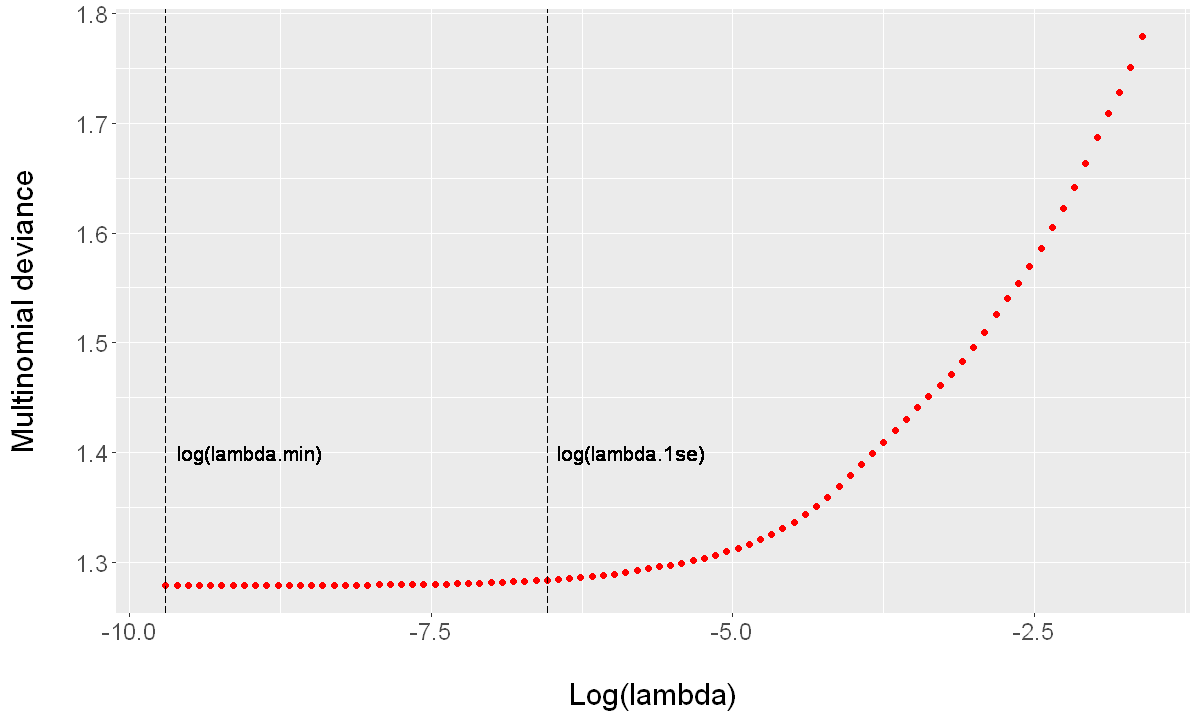

In [167]:
set.seed(1705)

# elasticnet expects datamatrix as input
Dn <- data.matrix(preprocessed)

if (RUN_LONG_COMPUTATIONS) {
    # perform (10-fold) cross-validation for a Lasso model
    elasticnet <- cv.glmnet(x = Dn[,-ncol(Dn)], y = as.factor(Dn[,ncol(Dn)]), 
                            family = "multinomial", standardize = TRUE)

    # save the Lasso model results
    saveRDS(elasticnet, "model_results/glmnet/lasso_model.RDS")
}

# read in the saved Lasso model results
elasticnet <- readRDS("model_results/glmnet/lasso_model.RDS")

df <- data.frame(lambda=log(elasticnet$lambda),cvm=elasticnet$cvm,cvsd=elasticnet$cvsd)
df.x <- log(elasticnet$lambda)
df.y <- elasticnet$cvm
df.y.sd <- elasticnet$cvsd

# plot results of lambda with lambda.min and lambda.1se specified
options(repr.plot.width=10, repr.plot.height=6)  
ggplot(df, aes(x = df.x, y= df.y)) +
    geom_point(color="red") + 
    geom_vline(xintercept=c(log(elasticnet$lambda.min), log(elasticnet$lambda.1se)), linetype="longdash") +
    geom_text(aes(x=log(elasticnet$lambda.min)+0.7, label="log(lambda.min)", y=1.4), size=4.5) +
    geom_text(aes(x=log(elasticnet$lambda.1se)+0.7, label="log(lambda.1se)", y=1.4), size=4.5) +
    labs(y = "Multinomial deviance\n", x = "\nLog(lambda)") +
    theme(plot.title = element_text(hjust = 0.5),
          text = element_text(size=18))

We decided to use lamda.1se for our model.

In [168]:
# helper function for specifically crossvalidating elasticnet
# same concept as the general execute_crossvalidation helper function,
# but alsokeeps track of the optimal lambda's
execute_elasticnet_crossvalidation <- function(k, Dn, learner){
    N <- nrow(Dn)
    
    # shuffle data randomly
    Dn <- Dn[sample(1:N),]
    
    target_variable = ncol(Dn) 
    size_CV <-floor(N/k)
    CV_accuracy<-numeric(k)
    CV_lambda<-numeric(k)
    
    for (i in 1:k) {
        print(paste("iteration ", i))

        # idx_ts represents the indices of the test set the i-th fold
        idx_tst<-(((i-1)*size_CV+1):(i*size_CV))  
        # idx_tr represents  indices of the training set for the i-th fold
        idx_tr<-setdiff(1:N,idx_tst) 
        
        # train the model
        model <- learner(Dn[idx_tr,])  
        
        # get lambda.1se
        CV_lambda[i] <- model$lambda.1se
        
        # make the predictions
        Yhat <- factor(predict(model, Dn[idx_tst, -ncol(Dn)], type=c("class"), s = "lambda.1se"))
        Y <- factor(Dn[idx_tst,target_variable])
        
        # added since elasticnet delivers numerical predictions (in the range of 1, 2, 3)
        levels(Yhat)[levels(Yhat)=="1"] <- "functional"
        levels(Yhat)[levels(Yhat)=="2"] <- "functional needs repair"
        levels(Yhat)[levels(Yhat)=="3"] <- "non functional"
        levels(Y)[levels(Y)=="1"] <- "functional"
        levels(Y)[levels(Y)=="2"] <- "functional needs repair"
        levels(Y)[levels(Y)=="3"] <- "non functional"
       
        CV_accuracy[i] <- calculate_accuracy(Y, Yhat)
    }
    
    return(list(accuracy=mean(CV_accuracy), accuracy_sd=sd(CV_accuracy),
                lambda=mean(CV_lambda), lambda_sd=sd(CV_lambda)))
}

In [169]:
if (RUN_LONG_COMPUTATIONS) {
    set.seed(1705)

    # specify the number of folds for cv
    n_folds <- 5

    # elasticnet expects datamatrix as input
    Dn <- data.matrix(preprocessed)

    alphas <- seq(0, 1, by=0.1)
    lambdas <- numeric()
    accuracy_cv_means <- numeric()
    accuracy_cv_sds <- numeric()
    lambda_cv_means <- numeric()
    lambda_cv_sds <- numeric()

    # perform cv for each hyperparameter value
    for(alpha_value in alphas){
        print(paste("[INFO] - Testing alpha = ", alpha_value))
        elasticnet <- function(Dtr)
            model <- cv.glmnet(x = data.matrix(Dtr[,-ncol(Dtr)]), y = as.factor(Dtr[,ncol(Dtr)]), 
                                              alpha=alpha_value,
                                              family = 'multinomial', standardize = TRUE)
        results <- execute_kfold_crossvalidation(n_folds, Dn, elasticnet)
        accuracy_cv_means <- c(accuracy_cv_means,results$accuracy)
        accuracy_cv_sds <- c(accuracy_cv_sds,results$accuracy_sd)
        lambda_cv_means <- c(lambda_cv_means,results$lambda)
        lambda_cv_sds <- c(lambda_cv_sds,results$lambda_sd)
    }   

    # save the results
    saveRDS(data.frame(alphas=alphas, accuracy=accuracy_cv_means, sd=accuracy_cv_sds, 
                       lambda=lambda_cv_means, lambda_sd=lambda_cv_sds), "model_results/glmnet/glmnet_results.RDS")
}

### Analysis

We investigated several ElasticNet models with $\alpha$ varying from 0.0 to 1.0, i.e. with varying degrees of Lasso/Ridge shrinkage techniques. It is clear that $\alpha$ does not seem to have a large influence when it comes to classification accuracy if the optimal $\lambda$ is also selected for each $\alpha$. The accuracy consistently fluctuates around 73%-74% with differences being less than a standard deviation away from each other. What is interesting to see, however, is that optimal $\lambda$ values are very dependent on the chosen $\alpha$. Searching and deciding on an optimal penalty strength therefore seems important.

Even though the differences are minimal, the best performance was found **for $\alpha$=0.4 and $\lambda$=0.00362, with an accuracy of 73.8% (+/-0.6)**. This performance isn't great, which is somewhat to be expected for a rather simple model like this but it can serve as a baseline to compare to other (more complex) models.

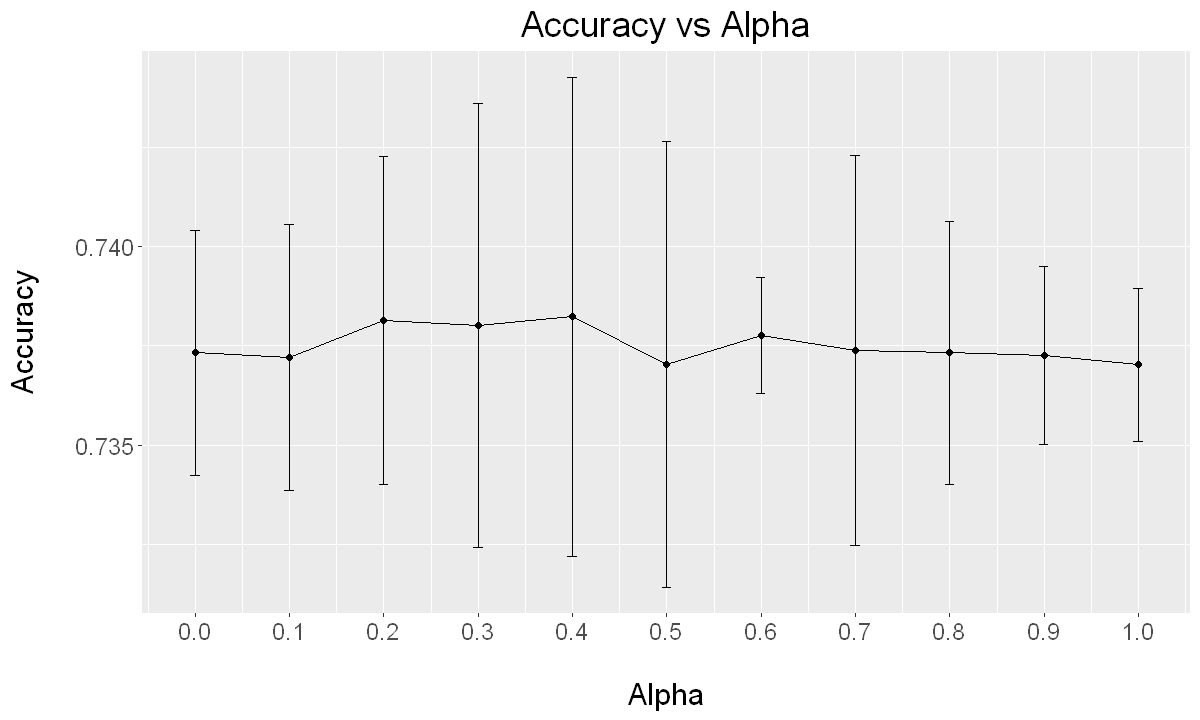

In [170]:
# read in our results
Dn <- readRDS("model_results/glmnet/glmnet_results.RDS")

# get values to plot
Dn.x <- Dn$alphas
Dn.y <- Dn$accuracy
y.sd <- Dn$sd

# plot results
options(repr.plot.width=10, repr.plot.height=6)  
ggplot(Dn, aes(x = Dn.x, y= Dn.y)) +
    geom_line() + 
    geom_point() +
    geom_errorbar(aes(x=Dn.x, ymin=Dn.y-y.sd, ymax=Dn.y+y.sd), width=0.01) +
    scale_x_continuous(breaks = Dn.x) +
    labs(title = "Accuracy vs Alpha", y = "Accuracy\n", x = "\nAlpha") +
    theme(plot.title = element_text(hjust = 0.5),
          text = element_text(size=18))

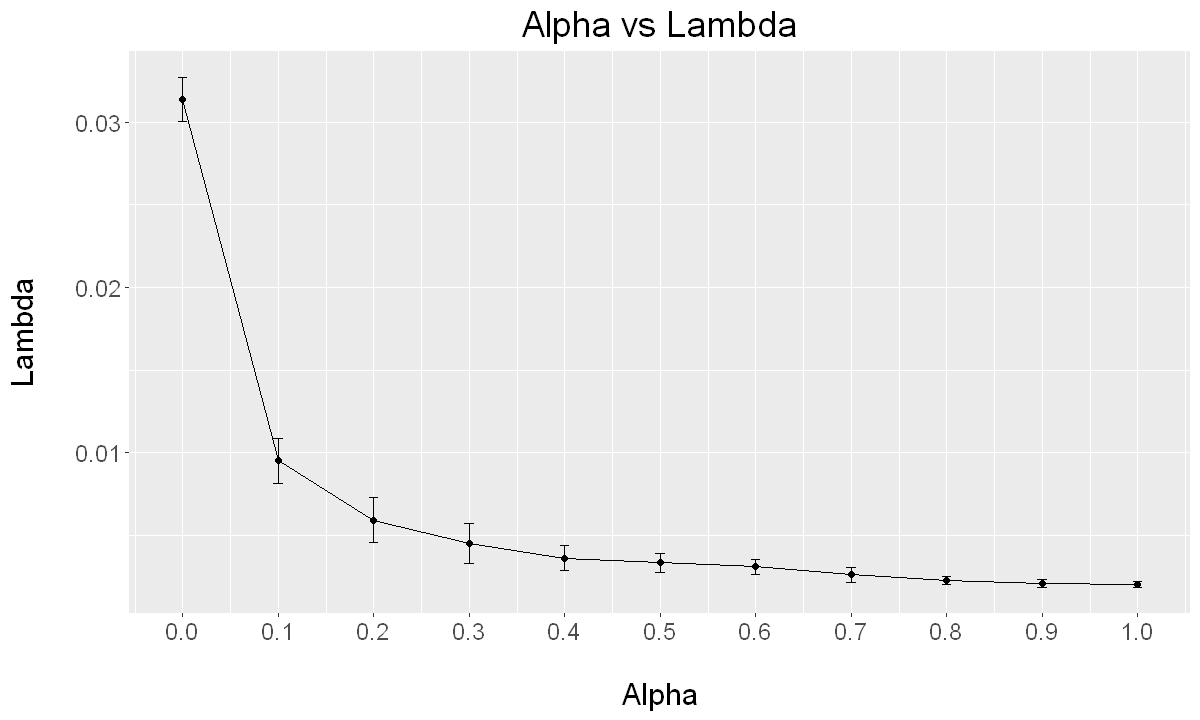

In [171]:
# get values to plot
Dn.x <- Dn$alphas
Dn.y <- Dn$lambda
y.sd <- Dn$lambda_sd

# plot results
options(repr.plot.width=10, repr.plot.height=6)  
ggplot(Dn, aes(x = Dn.x, y= Dn.y)) +
    geom_line() + 
    geom_point() +
    geom_errorbar(aes(x=Dn.x, ymin=Dn.y-y.sd, ymax=Dn.y+y.sd), width=0.01) +
    scale_x_continuous(breaks = Dn.x) +
    labs(title = "Alpha vs Lambda", y = "Lambda\n", x = "\nAlpha") +
    theme(plot.title = element_text(hjust = 0.5),
          text = element_text(size=18))

**Averaged Confusion matrix**  
We will also take a look at the confusion matrix, averaged over a 5-fold cross-validation for our best performing model. This will provide us more insight into which classes are confused with each other.

| Real: &darr; / Predicted: &rarr;                   | functional | functional needs repair | non functional |
|:-------------------------|:------------------------|:------------------------------------|:----------------------------|
| **functional**              | 91.1%                  | 0.1%                               | 8.8%                       |
| **functional needs repair** | 80.3%                  | 2.3%                               | 17.4%                      |
| **non functional**          | 36.8%                  | 0.4%                               | 62.8%                      |

The effects of the class imbalance are very clear. The majority level "functional" is predicted correctly most of the times, while "functional needs repair" samples are almost consistently incorrectly classified. Most mistakes also come from predicting a class as "functional" while it is not "functional". Since we only care about accuracy this might not be so bad, but it's clear our model would perform poorly if the real-world data would not follow the same distribution as the training data


In [172]:
if (RUN_LONG_COMPUTATIONS) {
    set.seed(1705)

    Dn <- data.matrix(preprocessed)
    k <- 5

    # our best performing learner
    learner <- function(Dtr) glmnet(data.matrix(Dtr[,-ncol(Dtr)]), y = as.factor(Dtr[,ncol(Dtr)]), 
                                    alpha=0.4, lambda=0.00362, family = 'multinomial', standardize = TRUE)

    # compute the confusion matrix
    cm <- averaged_confusion_matrix(k, Dn, learner)

    # row-normalize the confusion matrix
    cm <- cm/rowSums(cm)

    # save the results
    saveRDS(cm, "model_results/glmnet/glmnet_final_conf_matrix.RDS")
}

# read the results back in and show them
cm <- readRDS("model_results/glmnet/glmnet_final_conf_matrix.RDS")
cm

                    func func but rep     nonfunc
func         0.911063579  0.001177966 0.087758455
func but rep 0.803335650  0.022932592 0.173731758
nonfunc      0.367551700  0.004030845 0.628417455

## Model 2: Nearest Neighbors (kNN)

Nearest neighbours is a relatively simple "lazy" model that stores all the available data to be able to classify new query points (or test data) based on a similarity metric. In that sense it classifies new points based on the classification of the "nearest" or most similar training samples. That is also why the number of neighbours is the most commonly tuned hyperparameter (with a frequently used default being $\sqrt{N}$ with N = the number of samples). The metric used to compute similarity can also have a strong influence on the resulting prediction.

**Input & Output**  
More difficult similarity metrics are possible, but the simplest one in case of a combination of both numerical and categorical data is the Euclidean distance. In this case, it is important to one-hot encode the categorical data and also to scale all features. The numerical features with large values would otherwise cause the model to be more biased towards them. Consequently, the influence of the one-hot-encoded features would be mostly ignored. Therefore, all data will be scaled before the kNN training is commenced. The categorical target feature does not need any special encoding.

### Hyperparameter tuning

In [173]:
# read in the preprocessed training data
preprocessed <- readRDS("preprocessed/mrmr80_one_hot_train_preprocessed.rds")

In [174]:
# helper function for specifically crossvalidating kNN (since this kNN model does not have a predict method)
# same concept as the general execute_crossvalidation helper function
execute_kNN_crossvalidation <- function(n_folds, Dn, n_neighbors){
    # total number of training samples
    N <- nrow(Dn)

    # shuffle data randomly
    Dn <- Dn[sample(1:N),]

    # get the training data x and y
    Dn.x <- subset(Dn, select=-c(status_group))
    Dn.y <- Dn$status_group

    size_CV <- floor(N/n_folds)
    CV_accuracy <- numeric(n_folds)

    for (i in 1:n_folds) {
        # idx_tst represents the indices of the test set for the i-th fold
        idx_tst <- (((i-1)*size_CV+1):(i*size_CV))  
        
        # idx_tr represents the indices of the training set for the i-th fold
        idx_tr <- setdiff(1:N,idx_tst) 

        # get the predictions
        Yhat <- knn(train=Dn.x[idx_tr,], test=Dn.x[idx_tst,],
                    cl=Dn.y[idx_tr], k=n_neighbors)

        # calculate the accuracy
        CV_accuracy[i] <- calculate_accuracy(Dn[idx_tst, 'status_group'], Yhat)
    }
    
    return(list(accuracy=mean(CV_accuracy), stddev=sd(CV_accuracy)))
}

We will use 5-fold crossvalidation to find the most optimal number of nearest neighbours, when using the Euclidian distance similarity metric on scaled training data. 

We started with a rather general search with the number of neighbours (k) going from 1 to 50 in steps of 10 and then performing larger jumps up to the commonly used default of $\sqrt{N}$ which is 243 in this case. Afterwards we performed a more fine-grained search in the most promising area which is the area of k=1 to k=20.

In [175]:
if (RUN_LONG_COMPUTATIONS) {
    set.seed(1705)

    # scaled training data 
    preprocessed_scaled <- preprocessed

    # specify the number of folds for cv
    n_folds <- 5

    # specify the number of neighbors to try out
    sqrt_N <- floor(sqrt(nrow(preprocessed))) # commonly used default number of neighbors
    # first round of hyperparameter search
    # n_neighbors <- c(1,10,20,30,40,50,75,100,sqrt_N)
    # second round of hyperparameter search
    # n_neighbors <- c(seq(1:20))
    # both rounds combined
    n_neighbors <- c(seq(1:20),30,40,50,75,100,sqrt_N)

    accuracy_cv_means <- numeric()
    accuracy_cv_sds <- numeric()

    # perform cv for each hyperparameter value
    for(k in n_neighbors){
        print(paste("[INFO] - Testing n_neighbors = ", k))
        results <- execute_kNN_crossvalidation(n_folds, preprocessed_scaled, k)
        accuracy_cv_means <- c(accuracy_cv_means,results$accuracy)
        accuracy_cv_sds <- c(accuracy_cv_sds,results$stddev)
    }                

    # save the results
    saveRDS(data.frame(n_neighbors=n_neighbors, accuracy=accuracy_cv_means, sd=accuracy_cv_sds), "model_results/knn/kNN_results.RDS")
}

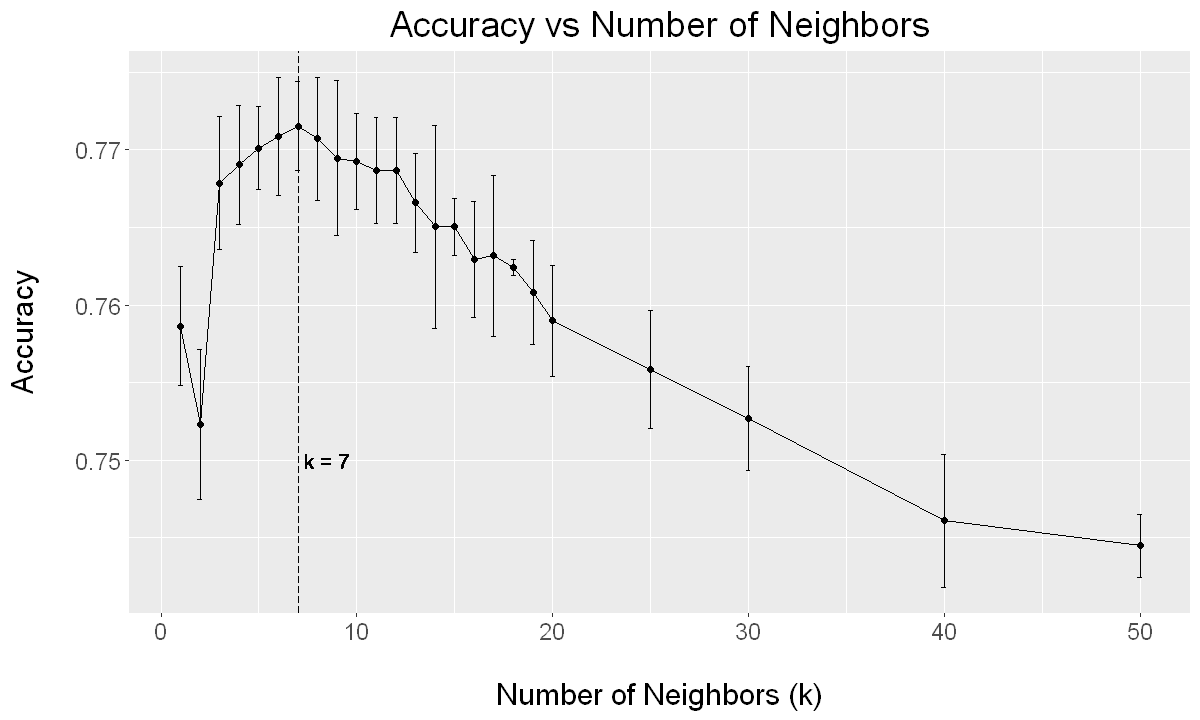

In [176]:
# read in results
Dn <- readRDS("model_results/knn/kNN_results.RDS")

# only plot k between 1 and 50 (for clarity)
Dn <- Dn[Dn$n_neighbors <= 50,]
Dn.x <- Dn$n_neighbors
Dn.y <- Dn$accuracy
y.sd <- Dn$sd

# plot results
options(repr.plot.width=10, repr.plot.height=6)  
ggplot(Dn,aes(x = Dn.x, y= Dn.y)) +
    geom_line() + 
    geom_point() +
    geom_errorbar(aes(x=Dn.x, ymin=Dn.y-y.sd, ymax=Dn.y+y.sd), width=0.25) +
    geom_vline(xintercept=c(7), linetype="longdash") +
    geom_text(aes(x=8.5, label="k = 7", y=0.75), size=4.5) +
    labs(title = "Accuracy vs Number of Neighbors", y = "Accuracy\n", x = "\nNumber of Neighbors (k)") +
    theme(plot.title = element_text(hjust = 0.5),
          text = element_text(size=18))

| k                 | Accuracy (mean ; standard deviation) |
|:------------------------|:-------------------------------------|
| 75                  |    73.5% +/- 0.3                                  |
| 100 |   73.0% +/- 0.6                  |
| 243 | 70.2% +/- 0.3                     |
*Summary of data not presented in graph*

### Analysis

We investigated several kNN models with k varying from small to larger number of neighbours. It is clear that a smaller number of neighbours performs better than larger numbers when it comes to our assessment metric of classification accuracy. Although some fluctuations exist, there generally doesn't seem to be a big difference in variances either when using a smaller number of neighbours compared to larger number of neighbours. In other words, using more neighbours does not seem to decrease the variance, but only lowers overall performance for our quality metric.

The best performance was therefore found to be at **k=7, with an accuracy of 77.5% (+/- 0.285)**. This performance is quite good considering the simplicity of the model.


**Averaged Confusion matrix**  
We will also take a look at the cross-validation averaged confusion matrix for our best performing model to gain more insight into which classes are more often confused with each other.

| Real: &darr; / Predicted: &rarr;                   | functional | functional needs repair | non functional |
|:-------------------------|:------------------------|:------------------------------------|:----------------------------|
| **functional**              | 86.3%                  | 2.3%                               | 11.4%                       |
| **functional needs repair** | 52.5%                  | 29.4%                               | 18.1%                      |
| **non functional**          | 26.6%                  | 1.9%                               | 71.5%                      |

The same effects of class imbalance are visible for this model as for the ElasticNet model. It should be noted, however, that the predictions seem a bit more balanced. Both the "functional needs repair" and "non functional" classes have more correct predictions, while the majority class "functional" has a bit more incorrect predictions.


In [177]:
if (RUN_LONG_COMPUTATIONS) {
    set.seed(1705)

    # shuffle data randomly
    N <- nrow(preprocessed)
    Dn <- preprocessed[sample(1:N),]

    # scale the data
    Dn.x <- subset(preprocessed, select=-c(status_group))
    Dn.y <- Dn$status_group

    n_folds <- 5 # number of folds
    n_neighbors <- 7 # optimal number of neighbors

    target_variable = ncol(Dn)
    size_CV <-floor(N/n_folds)

    # create average confusion matrix
    CV_confusion_matrix <- matrix(0, nrow = 3, ncol = 3)
    rownames(CV_confusion_matrix) <- c("func", "func but rep", "nonfunc")
    colnames(CV_confusion_matrix) <- c("func", "func but rep", "nonfunc")

    for (i in 1:n_folds) {
        print(paste("iteration ", i))
        flush.console()

        idx_tst<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
        idx_tr<-setdiff(1:N,idx_tst) ### idx_tr represents  indices of the training set for the i-th fold
23:25
        Y <- Dn.y[idx_tst]
        Yhat <- knn(train=Dn.x[idx_tr,], test=Dn.x[idx_tst,],
                    cl=Dn.y[idx_tr], k=n_neighbors)

        # compute confusion matrix
        levels(Y) <- c("func", "func but rep", "nonfunc")
        levels(Yhat) <- c("func", "func but rep", "nonfunc")
        CV_confusion_matrix <- CV_confusion_matrix + table(Y, Yhat)
    }

    CV_confusion_matrix <- CV_confusion_matrix/n_folds

    # row-normalize the confusion matrix
    CV_confusion_matrix <- CV_confusion_matrix/rowSums(CV_confusion_matrix)

    # save the results
    saveRDS(CV_confusion_matrix, "model_results/knn/knn_final_conf_matrix.RDS")
}

# read the results back in and present them
CV_confusion_matrix <- readRDS("model_results/knn/knn_final_conf_matrix.RDS")
CV_confusion_matrix

                   func func but rep    nonfunc
func         0.86347996   0.02297033 0.11354971
func but rep 0.52466991   0.29395413 0.18137596
nonfunc      0.26594812   0.01910270 0.71494918

## Model 3: Decision trees

A decision tree is the most basic tree-based model.  We will focus here on classification trees, since classification is the goal. 

A tree consists of both inner nodes and leaf nodes. All inner nodes, i.e. nodes with children, split up the search space based on one variable. Therefore, every leaf represents a region in the sample space that is mutually exclusive from all regions related to the other leaves. Every leaf node assigns a class which is most probable in the associated region of the sample space. 

**Input & Output**  
Decision trees can easily split categorical data based on the existing levels, so we decided to not perform one-hot encoding on the training data. The output data also did not need any special encoding.

We will use the library rpart to create decision trees. This library uses the CART algorithm to create a classification tree (Rpart Function - RDocumentation, 2021). In CART, the creation of a tree goes in two phases, namely: growing and pruning.

#### Growing a decision tree

Every node represents a region in the sample space. While growing the tree, rpart uses the gini index by default (Rpart Function - RDocumentation, 2021).  The gini index for a region $S$ is defined as 
$ Gini(y,S)=1-\sum_{c_{j}\in dom(y)} \left( \frac{|S_j| }{ |S|} \right)^2 $ with $S_j$ the set of all elements of class $c_j$ (Rokach & Maimon, 2005). 

For every node, CART tries to find the optimal split of the current region $S$ by dividing it into $S_l$ and $S_r$ through maximizing the Gini Gain. The Gini Gain can be expressed by $Gini(y,S) - \left( \frac{|S_l|}{|S|} Gini(y, S_l) + \frac{|S_r|}{|S|} Gini(y, S_r) \right) $ (Rokach & Maimon, 2005). The rationale behind maximising the Gini gain is the following: When all elements in a region $S_i$ belong to one class, $\frac{|S_j|}{|S_i|}$ is equal to 1 for all $i = j$ and is equal to 0 for all $i \neq  j$. Therefore, $Gini(y,S_i)$ is equal to 0. This makes that for the highest Gini gain, the region is split into subregions which have a lot of elements in the same class. 

The growing phase stops when at least one of the stop conditions are met. The two stop conditions that we will assess are the parameters minbucket and maxdepth of the rpart function. The parameter maxdepth makes sure that a tree will not get deeper (the path to a leaf is never longer than maxdepth nodes). The parameter minbucket represents the minimum number of samples a leaf represents from the training set. For this experiment, we set the complexity parameter cp to zero, so no pruning happens.

The following code cells perform a grid search on the aforementioned two hyperparameters.

In [178]:
# number of k-folds
n_folds <- 5

# values to be checked for maxdepth and minbucket 
maxdepth_values <- seq(from=2, to=30, by=3)
minbucket_values <- c(1, seq(from=20, to=140, by=20))

# In the preprocessed data, lga still has 36 different categories which is too much for rpart
# Therefore, we decided to merge additional categories into the 'other' category by using a larger cutoff
Dn <- readRDS(file = "preprocessed/categorical_train_preprocessed.rds")
Dn <- merge_low_frequency_levels(Dn, to_merge=c('lga'), cutoff = 0.015)

if(RUN_LONG_COMPUTATIONS){
    set.seed(1705)

    #shuffle the data samples randomly
    N <- nrow(Dn)
    Dn <- Dn[sample(1:N),]    

    cv_accuracy_matrix <- c()
    cv_sd_matrix <- c()

    # outer loop for grid search over maxdepth values
    for(maxdepth in maxdepth_values){
        print(paste("[INFO] - maxdepth =", maxdepth))

        #vector for accuracy and for the standard deviation of the crossvalidation accuracy
        cv_accuracy_maxdepth <- c()
        cv_sd_maxdepth <- c()

        # inner loop over the values of minbucket
        for(minbucket in minbucket_values){
            print(paste("[INFO] - minbucket =", minbucket))

            # function that represents the learning machine
            decision_tree <- (function(Dn){
                rpart.ctrl <- rpart.control(minbucket=minbucket, cp=0, maxdepth=maxdepth)
                rpart(status_group~., Dn, method="class", control=rpart.ctrl)   
            })

            results <- execute_kfold_crossvalidation(n_folds, Dn, decision_tree)
            cv_accuracy_maxdepth <- c(cv_accuracy_maxdepth, results$accuracy)
            cv_sd_maxdepth <- c(cv_sd_maxdepth, results$stddev)
        } 

        # store results
        cv_accuracy_matrix <- cbind(cv_accuracy_matrix, cv_accuracy_maxdepth)
        cv_sd_matrix <- cbind(cv_sd_matrix, cv_sd_maxdepth)
    }
    
    colnames(cv_accuracy_matrix) <- maxdepth_values
    rownames(cv_accuracy_matrix) <- minbucket_values
    colnames(cv_sd_matrix) <- maxdepth_values
    rownames(cv_sd_matrix) <- minbucket_values
    
    # save results
    saveRDS(cv_accuracy_matrix, file = "model_results/decisiontree/cv_accuracy_matrix_gridsearch.rds")
    saveRDS(cv_sd_matrix, file="model_results/decisiontree/cv_sd_matrix_gridsearch.rds")
}

In [179]:
# read in the results from the grid search
cv_accuracy_matrix <- readRDS(file = "model_results/decisiontree/cv_accuracy_matrix_gridsearch.rds")
cv_sd_matrix <- readRDS(file="model_results/decisiontree/cv_sd_matrix_gridsearch.rds")

# get the values of maxdepth and minbucket for which the maximum accuracy was found
location_max <- which(cv_accuracy_matrix == max(cv_accuracy_matrix), arr.ind = TRUE)
max_accuracy <- cv_accuracy_matrix[location_max]
maxdepth_max_accuracy <- maxdepth_values[location_max[1,"col"]]
minbucket_max_accuracy <- minbucket_values[location_max[1,"row"]]

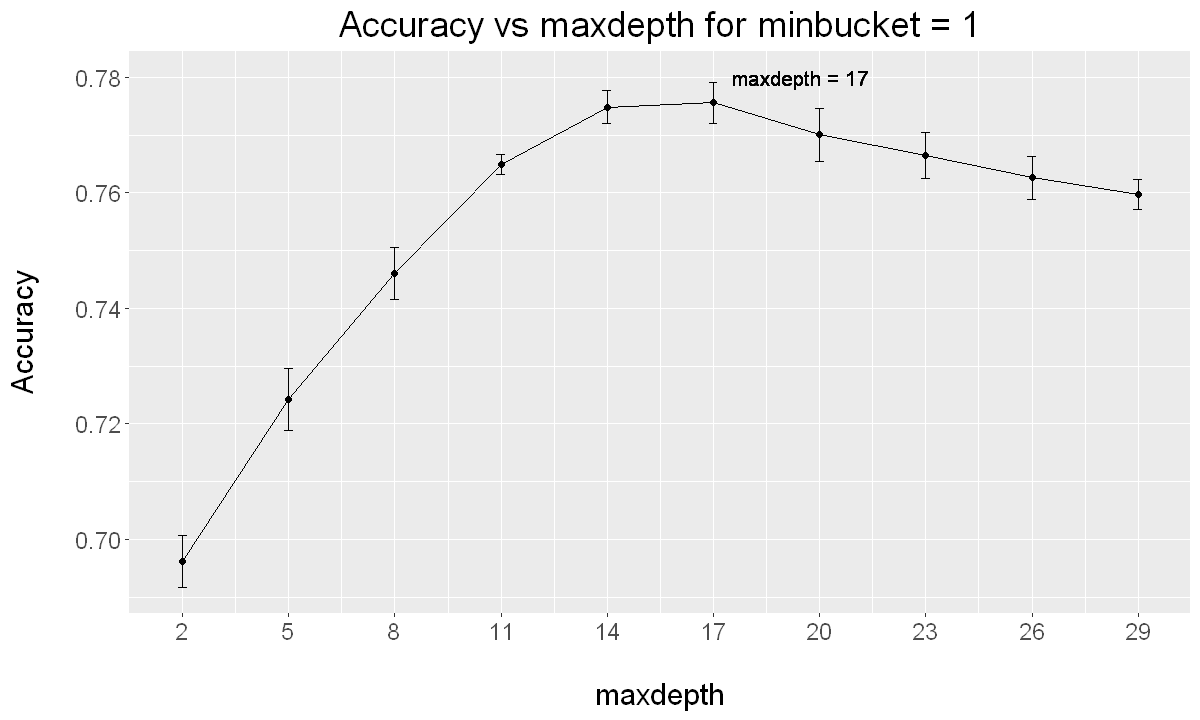

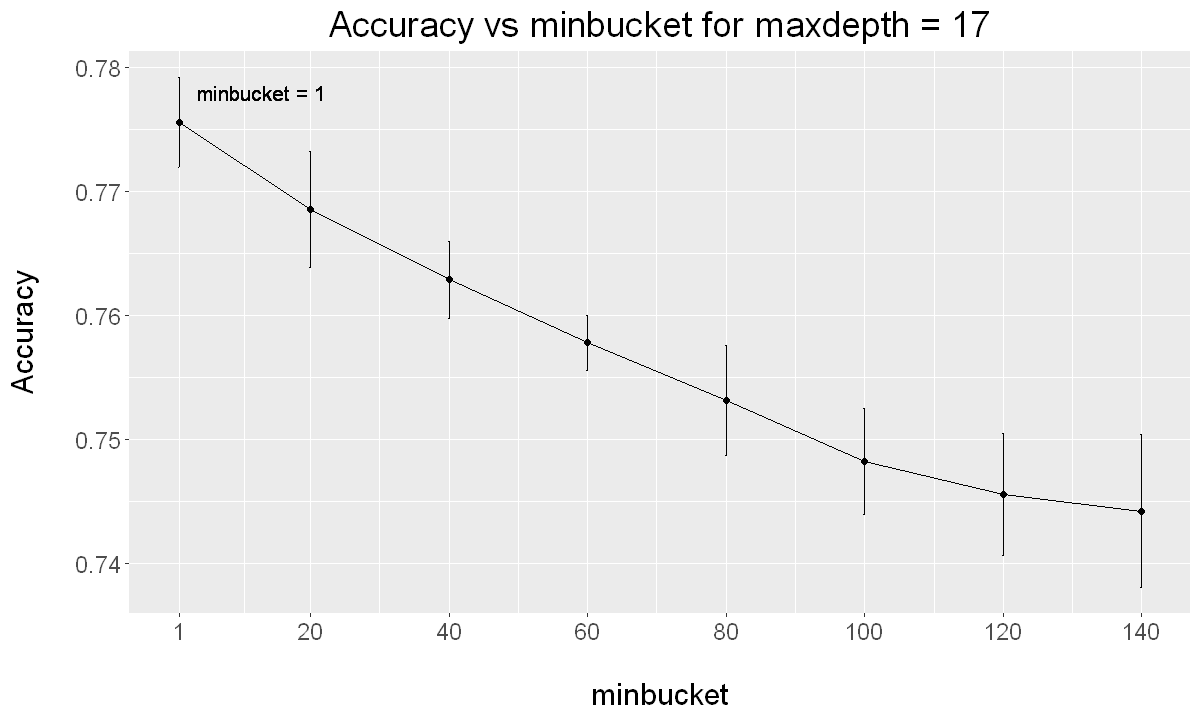

In [180]:
# Plot the accuracy in function of the maxdepth values
plotdata <- as.data.frame(cbind(maxdepth_values=maxdepth_values, 
                                accuracy=cv_accuracy_matrix[location_max[,"row"],], 
                                sd=cv_sd_matrix[location_max[,"row"],]))

plotdata.x <- plotdata$maxdepth_values
plotdata.y <- plotdata$accuracy
y.sd <- plotdata$sd

options(repr.plot.width=10, repr.plot.height=6)
ggplot(plotdata, aes(x = plotdata.x, y= plotdata.y)) +
    geom_line() +
    geom_point() +
    geom_errorbar(aes(x=plotdata.x, ymin=plotdata.y-y.sd, ymax=plotdata.y+y.sd), width=0.25) +
    geom_text(aes(x=19.5, label="maxdepth = 17", y=0.78), size=4.5) +
    scale_x_continuous(breaks = plotdata.x) +
    labs(title = "Accuracy vs maxdepth for minbucket = 1", y = "Accuracy\n", x = "\nmaxdepth") +
    theme(plot.title = element_text(hjust = 0.5),
          text = element_text(size=18))

# Plot the accuracy in function of the minbucket values
plotdata <- as.data.frame(cbind(minbucket_values=minbucket_values, accuracy=cv_accuracy_matrix[,location_max[,"col"]], sd=cv_sd_matrix[,location_max[,"col"]]))

plotdata.x <- plotdata$minbucket_values
plotdata.y <- plotdata$accuracy
y.sd <- plotdata$sd


options(repr.plot.width=10, repr.plot.height=6)
ggplot(plotdata, aes(x = plotdata.x, y= plotdata.y)) +
    geom_line() +
    geom_point() +
    geom_errorbar(aes(x=plotdata.x, ymin=plotdata.y-y.sd, ymax=plotdata.y+y.sd), width=0.25) +
    scale_x_continuous(breaks = plotdata.x) +
    geom_text(aes(x=13, label="minbucket = 1", y=0.778), size=4.5) +
    labs(title = "Accuracy vs minbucket for maxdepth = 17", y = "Accuracy\n", x = "\nminbucket") +
    theme(plot.title = element_text(hjust = 0.5),
          text = element_text(size=18))



The results of the grid search indicate that maximum accuracy is reached when the tree growing procedure makes a node a leaf if either a depth of 17 is reached or if the node represents only one sample in the dataset (which can happen earlier than 17 levels deep).

The maximum accuracy that was obtained at this point was 77.6% +/- 0.4.


#### Pruning a decision tree
The growing method of a tree has the tendency to create an overfitting model. Therefore, the second phase of CART is to prune the tree. To prune a decision tree, a penalty is added when a tree is too complex. The strictness of the penalty for the complexity is managed by the parameter $\lambda$. Let $\lambda_1 > \lambda_2 > ... > \lambda_n$ be a series of decreasing complexity parameters and $T_{\lambda_1}, T_{\lambda_2}, ..., T_{\lambda_n}$ be the trees pruned until they minimise for the corresponding $\lambda_{i}$. The quantity $R_{\lambda_i}(T) = R_{emp}(T) + \lambda_{i}|T|$ with $|T|$ a measure for the size of the trees. The trees $T_{\lambda_1} \subset T_{\lambda_2} \subset ... \subset T_{\lambda_n}$  are then subtrees of one another . We will now search for the subtree that has the best accuracy using rpart.  

The library rpart can prune a tree in two different ways. First, rpart does crossvalidation on different subtrees and calculates a cross validation measure for particular complexity parameters cp while growing the tree. We could look in the rpart.object's cp table for the complexity parameter cp corresponding to the smallest crossvalidation error. Then, the function prune.rpart can prune a given tree to this particular complexity parameter. Another possibility is to tune the complexity parameter which will be used internally to stop growing the tree (Rpart Function - RDocumentation, 2021). 

We will use this last approach to investigate the effect on performance of tuning cp for both a maxdepth of 17 and the default maxdepth of 30.

In [181]:
# Runs cross validation on multiple possible values for cp with maxdepth = 30 
if(RUN_LONG_COMPUTATIONS){
    # number of k-folds
    n_folds <- 5

    # In the preprocessed data, lga still has 36 different categories which is too much for rpart. 
    # Therefore, we decided to merge extra categories into the 'other' category.
    Dn <- readRDS(file = "preprocessed/categorical_train_preprocessed.rds")
    Dn <- merge_low_frequency_levels(Dn, to_merge=c('lga'), cutoff = 0.015)    
    
    # We create an rpart model on the whole dataset and we then use the values for cp in the cptable 
    # to have an idea on which values we can do crossvalidation using the accuracy. 
    control <- rpart.control(cp = 0, minbucket=1, maxdepth=30)
    model <- rpart(status_group~. , Dn, method="class", model=TRUE, control = control  )
    cp_values <- model$cptable[,"CP"]
    cp_values_to_verify <- cp_values[seq(from=60, to=120, by=1)]

    accuracy_cv_cp <- c()
    i <- 1 # counter used for labeling print statements

    for(cp in cp_values_to_verify){
        print(paste("[INFO] -", i , "/", length(cp_values), "cp_value =", cp))
        i = i + 1 
        
        # function that represents the learning machine
        decision_tree <- (function(Dn){
            rpart.ctrl <- rpart.control(minbucket=1, cp=cp, maxdepth=30)
            rpart(status_group~., Dn, method="class", control=rpart.ctrl)   
        })
        
        # runs cross validation and executes 
        results <- execute_kfold_crossvalidation(n_folds, Dn, decision_tree)
        accuracy_cv_cp <- rbind(accuracy_cv_cp,results)
    } 

    # save the results
    rownames(accuracy_cv_cp) <- cp_values
    saveRDS(accuracy_cv_cp, file = "model_results/decisiontree/accuracy_cv_cp_maxdepth_30.rds")        
}

In [182]:
# Runs cross validation on multiple possible values for cp with maxdepth = 17
if(RUN_LONG_COMPUTATIONS){

    # number of k-folds
    n_folds <- 5

    # In the preprocessed data, lga still has 36 different categories. Therefore, we decided to merge extra categories into the 'other' category.
    Dn <- readRDS(file = "preprocessed/categorical_train_preprocessed.rds")
    Dn <- merge_low_frequency_levels(Dn, to_merge=c('lga'), cutoff = 0.015)        

    accuracy_cv_cp_maxdepthtuned <- c()

    # use same cp_values and settings as for maxdepth = 30
    for(cp in cp_values_to_verify){

        # function that represents the learning machine
        decision_tree <- (function(Dn){
            rpart.ctrl <- rpart.control(minbucket=1, cp=cp, maxdepth=17)
            rpart(status_group~., Dn, method="class", control=rpart.ctrl)   
        })

        # runs cross validation and executes 
        results <- execute_kfold_crossvalidation(n_folds, Dn, decision_tree)
        accuracy_cv_cp_maxdepthtuned <- rbind(accuracy_cv_cp_maxdepthtuned,results)
    } 

    # store the results
    rownames(accuracy_cv_cp_maxdepthtuned) <- cp_values_to_verify
    saveRDS(accuracy_cv_cp_maxdepthtuned, file = "model_results/decisiontree/accuracy_cv_cp_maxdepth_17.rds")  
}    

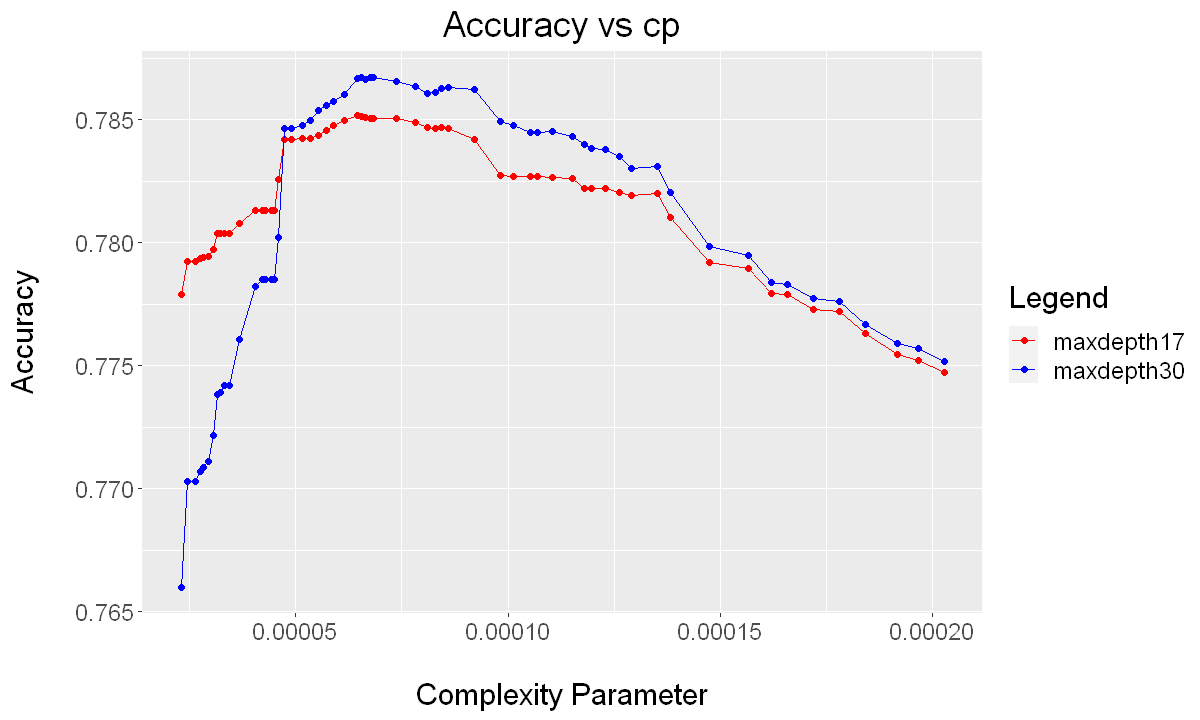

In [183]:
# Plot accuracy in function of the complexity parameter for both maxdepth equal to 17 and 30
accuracy_cv_cp_maxdepth17 <- readRDS(file="model_results/decisiontree/accuracy_cv_cp_maxdepth_17.rds")
accuracy_cv_cp_maxdepth30 <- readRDS(file="model_results/decisiontree/accuracy_cv_cp_maxdepth_30.rds")

# set the colors for both curves
colors <- c("maxdepth17" = "red", "maxdepth30" = "blue")

# get the plotting data for the max depth of 17 (obtained by tuning max depth)
plotdata <- as.data.frame(cbind(cp=as.double(rownames(accuracy_cv_cp_maxdepth17)), 
                                accuracy=accuracy_cv_cp_maxdepth17[,"accuracy"], 
                                sd=accuracy_cv_cp_maxdepth17[,"stddev"]))
plotdata.x <- unlist(plotdata$cp)
plotdata.y <- unlist(plotdata$accuracy)
y.sd <- unlist(plotdata$sd)

# get the plotting data for the default max depth of 30
plotdata30 <- as.data.frame(cbind(cp=as.double(rownames(accuracy_cv_cp_maxdepth30)), 
                                accuracy=accuracy_cv_cp_maxdepth30[,"accuracy"], 
                                sd=accuracy_cv_cp_maxdepth30[,"stddev"]))
plotdata.x30 <- unlist(plotdata30$cp)
plotdata.y30 <- unlist(plotdata30$accuracy)

# plot the data
options(repr.plot.width=10, repr.plot.height=6)
ggplot() +
    scale_color_manual(values = colors) +
    geom_line(data=plotdata, aes(x = plotdata.x, y= plotdata.y, color="maxdepth17")) +
    geom_point(data=plotdata, aes(x = plotdata.x, y= plotdata.y, color="maxdepth17")) +

    geom_line(data=plotdata30, aes(x = plotdata.x30, y= plotdata.y30, colour="maxdepth30")) +
    geom_point(data=plotdata30, aes(x = plotdata.x30, y= plotdata.y30, colour="maxdepth30")) +
    labs(title = "Accuracy vs cp", y = "Accuracy\n", x = "\nComplexity Parameter", color= "Legend") + 
    theme(plot.title = element_text(hjust = 0.5),
          text = element_text(size=18))


The figure shows that the higher the penalty on complexity is,  the less complex and the more biased the model will be. This causes the accuracy of the model to decrease as the complexity parameter becomes too high (through underfitting). Conversely, the lower the penalty for complexity is, the more complex the tree gets and the higher the variance of the model will be (through overfitting). In other words, the figure clearly show the importance of finding a good bias/variance trade-off point for optimal performance.

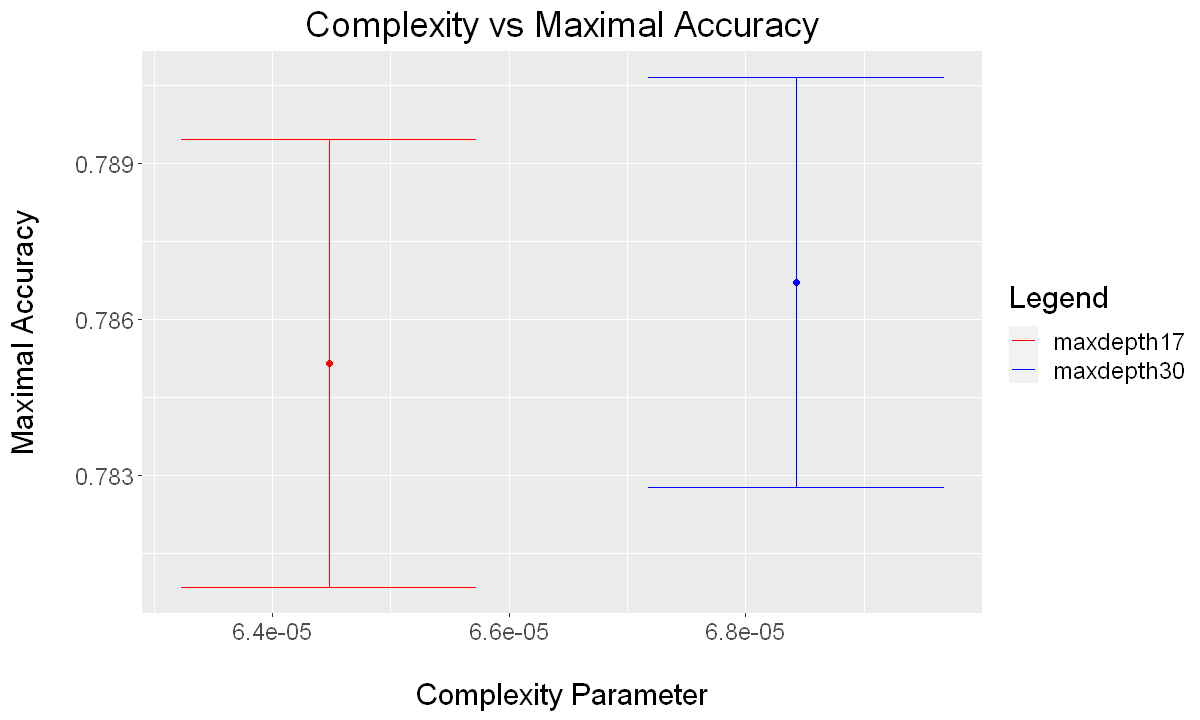

In [184]:
# read in the results of cross validation
accuracy_cv_cp_maxdepth17 <- readRDS(file="model_results/decisiontree/accuracy_cv_cp_maxdepth_17.rds")
accuracy_cv_cp_maxdepth30 <- readRDS(file="model_results/decisiontree/accuracy_cv_cp_maxdepth_30.rds")

# get the cp values that performed the best
location_max_17<-which.max(accuracy_cv_cp_maxdepth17[,"accuracy"])
location_max_30<-which.max(accuracy_cv_cp_maxdepth30[,"accuracy"])
accuracy17 <- accuracy_cv_cp_maxdepth17[location_max_17,]
accuracy30 <- accuracy_cv_cp_maxdepth30[location_max_30,]

max_cp_17 <- as.double(rownames(accuracy_cv_cp_maxdepth17))[location_max_17]
max_cp_30 <- as.double(rownames(accuracy_cv_cp_maxdepth30))[location_max_30]

# plot the value of cp with its maximum accuracy with the standard deviation
options(repr.plot.width=10, repr.plot.height=6)
colors <- c("maxdepth17" = "red", "maxdepth30" = "blue")

ggplot() +
    scale_color_manual(values = colors) +
    geom_errorbar(aes(x=max_cp_17, ymin=accuracy17$accuracy-accuracy17$stddev, ymax=accuracy17$accuracy+accuracy17$stddev, color="maxdepth17" ), width=0.0000025) +
    geom_errorbar(aes(x=max_cp_30, ymin=accuracy30$accuracy-accuracy30$stddev, ymax=accuracy30$accuracy+accuracy30$stddev, color="maxdepth30" ), width=0.0000025) +
    geom_point(aes(x=max_cp_30, y=accuracy30$accuracy), colour="blue") +
    geom_point(aes(x=max_cp_17, y=accuracy17$accuracy), colour="red") +
    labs(title = "Complexity vs Maximal Accuracy", y = "Maximal Accuracy\n", 
         x = "\nComplexity Parameter", color= "Legend") +
     theme(plot.title = element_text(hjust = 0.5),
           text = element_text(size=18))

The figures above also show that for a small complexity parameter (i.e. almost no pruning), it is interesting to tune the maximum depth of the tree. When enough pruning happens, it is not as necessary anymore to tune the maximum depth of the tree because pruning seems to already find a good trade-off point. This is also clearly visible in the table below where the influence of maxdepth is minimal if the complexity parameter is already well-tuned.

| maxdepth | Accuracy (mean ; standard deviation) |
|:---------|:-------------------------------------|
| 17       |    78.5% +/- 0.431                    |
| 30       |    78.7% +/- 0.394                  |
*Max accuracy for different values for maxdepth when tuning the complexity parameter*

**Averaged Confusion matrix**  
The averaged confusion matrix for a decision tree created with the best hyperparameters (maxdepth = 30, cp = 6.84257343923532e-05) found is the following:

| Real: &darr; / Predicted: &rarr;                   | functional | functional needs repair | non functional |
|:-------------------------|:------------------------|:------------------------------------|:----------------------------|
| **functional**              | 86.7%                  | 2.2%                               | 11.0%                       |
| **functional needs repair** | 53.8%                  | 29.1%                               | 17.1%                      |
| **non functional**          | 23.4%                  | 1.6%                               | 75.0%                      |

This confusion matrix already looks a lot better than the one of the ElasticNet-model. ElasticNet was only able to classify 2.3% of the water pumps with status group "functional needs repair" correctly, while the decision tree was able to classify 29.3% of the "functional needs repair" waterpoints correctly. We can also note that the classification-rate of the "functional" waterpoints decreased slightly. However, since the ElasticNet-model had an accuracy of 73.8% +/- 0.6%, the accuracy increased for the decision tree model to **78.7% +/- 0.4%**.

In [185]:
if(RUN_LONG_COMPUTATIONS){
    set.seed(1705)
    library(rpart)
    Dn <- readRDS(file = "preprocessed/categorical_train_preprocessed.rds")
    Dn <- merge_low_frequency_levels(Dn, to_merge=c('lga'), cutoff = 0.015)  

    k <- 5

    # our best performing learner

    learner <- function(Dtr){
        rpart.ctrl <- rpart.control(cp=max_cp_30)
        rpart(status_group~., Dtr, method="class", control=rpart.ctrl) 
    }

    # compute the confusion matrix
    cm <- averaged_confusion_matrix(k, Dn, learner)

    # row-normalize the confusion matrix
    cm <- cm/rowSums(cm)

    saveRDS(cm, file="model_results/decisiontree/decision_tree_final_conf_matrix.RDS")
}

cm <- readRDS(file="model_results/decisiontree/decision_tree_final_conf_matrix.RDS")
cm

                   func func but rep    nonfunc
func         0.86766484   0.02222636 0.11010881
func but rep 0.53578874   0.28816308 0.17604818
nonfunc      0.23453382   0.01550999 0.74995619

## Model 4: Random Forests

A random forest creates multiple non-pruned decision trees using a combination of bagging and random feature selection. Bagging is an acronym for Bootstrap Aggregating and generally combines multiple predictors with high variance but low bias. For each tree of the random forest, the training set is resampled to simulate the sampling of a dataset (bootstrapping).  Also, all trees are created on a random subset of variables. The resulting trees are then used to make a combined prediction (aggregation).  

We will do a grid search on the number of variables per tree and the number of trees. This will allow us to tune the most important hyperparameters for both the bagging and the random feature selection parts.

In [186]:
# specify the values of the number of variables per tree and the number of trees to search on
nr_of_variables_per_tree_values <- seq(from=2, to=12, by=2)
ntree_values <- c(10, 20, 50, 100, 200, 300, 500)

if(RUN_LONG_COMPUTATIONS){ 
    Dn <- readRDS(file = "preprocessed/categorical_train_preprocessed.rds")
    Dn <- merge_low_frequency_levels(Dn, to_merge=c('lga'), cutoff = 0.015)

    # grid search on ntrees/mtry
    set.seed(1705)
    
    # shuffle data randomly
    N <- nrow(Dn)
    Dn <- Dn[sample(1:N),]

    # number of k-folds cross validation    
    n_folds <- 5

    cv_accuracy_matrix <- c()
    cv_sd_matrix <- c()
    
    # counter used for print statements
    i = 1

    # outer loop over the number of variables per tree to search in
    for(nr_of_variables_per_tree in nr_of_variables_per_tree_values){
        print(paste("[INFO] - nr_of_variables_per_tree =", nr_of_variables_per_tree))

        cv_accuracy_mtry <- c()
        cv_sd_mtry <- c()

        # inner loop over the number of trees to search in
        for(ntree in ntree_values){
            print(paste("[INFO] - ntree =", ntree))
            print(paste("CV ", i , "/", length(nr_of_variables_per_tree_values)*length(ntree_values)))
            i = i+1
            
            # function that represents the learning machine
            rf <- (function(Dn){
                randomForest(status_group~., Dn, ntree=ntree, mtry=nr_of_variables_per_tree )
            })            

            # execute crossvalidation 
            results <- execute_kfold_crossvalidation(n_folds, Dn, rf)
            cv_accuracy_mtry <- c(cv_accuracy_mtry, results$accuracy)
            cv_sd_mtry <- c(cv_sd_mtry, results$stddev)
        } 

        # store results
        cv_accuracy_matrix <- cbind(cv_accuracy_matrix, cv_accuracy_mtry)
        cv_sd_matrix <- cbind(cv_sd_matrix, cv_sd_mtry)
    }

    colnames(cv_accuracy_matrix) <- nr_of_variables_per_tree_values
    rownames(cv_accuracy_matrix) <- ntree_values
    colnames(cv_sd_matrix) <- nr_of_variables_per_tree_values
    rownames(cv_sd_matrix) <- ntree_values
    
        # save final results
    saveRDS(cv_accuracy_matrix, file = "model_results/randomforest/cv_accuracy_matrix_rf_gridsearch.rds")
    saveRDS(cv_sd_matrix, file="model_results/randomforest/cv_sd_matrix_rf_gridsearch.rds")

}    

# read final results back in
cv_accuracy_matrix <- readRDS(file = "model_results/randomforest/cv_accuracy_matrix_rf_gridsearch.rds")
cv_sd_matrix <- readRDS(file="model_results/randomforest/cv_sd_matrix_rf_gridsearch.rds")

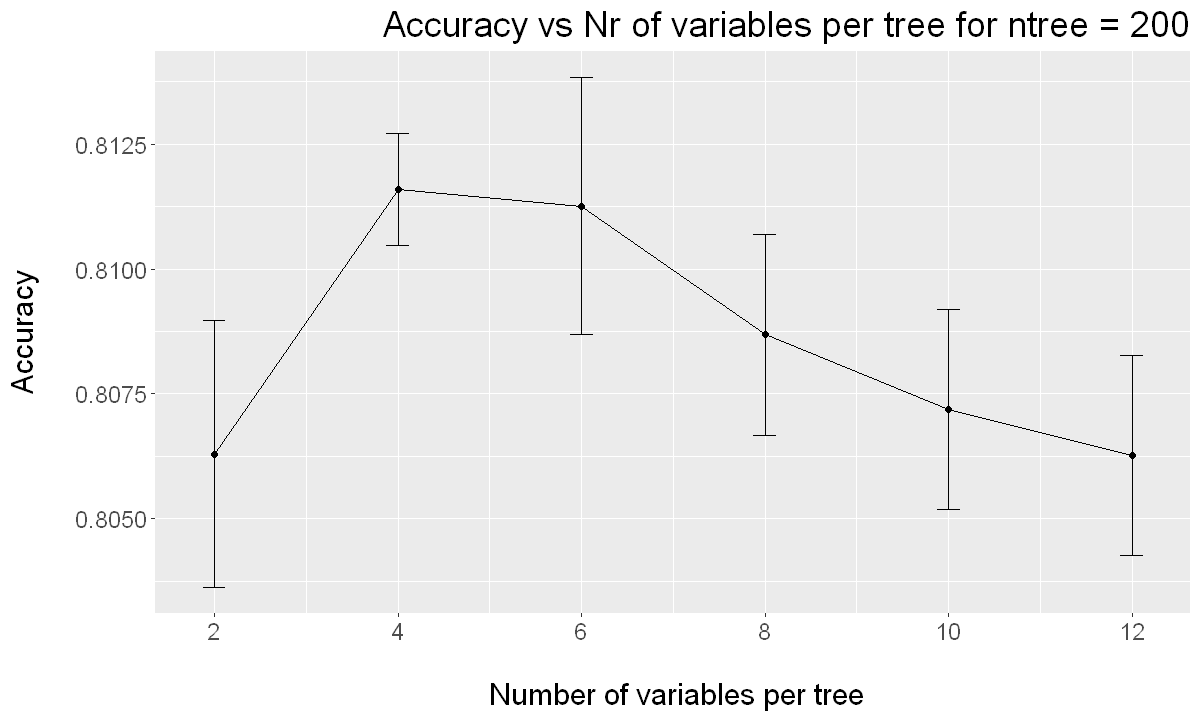

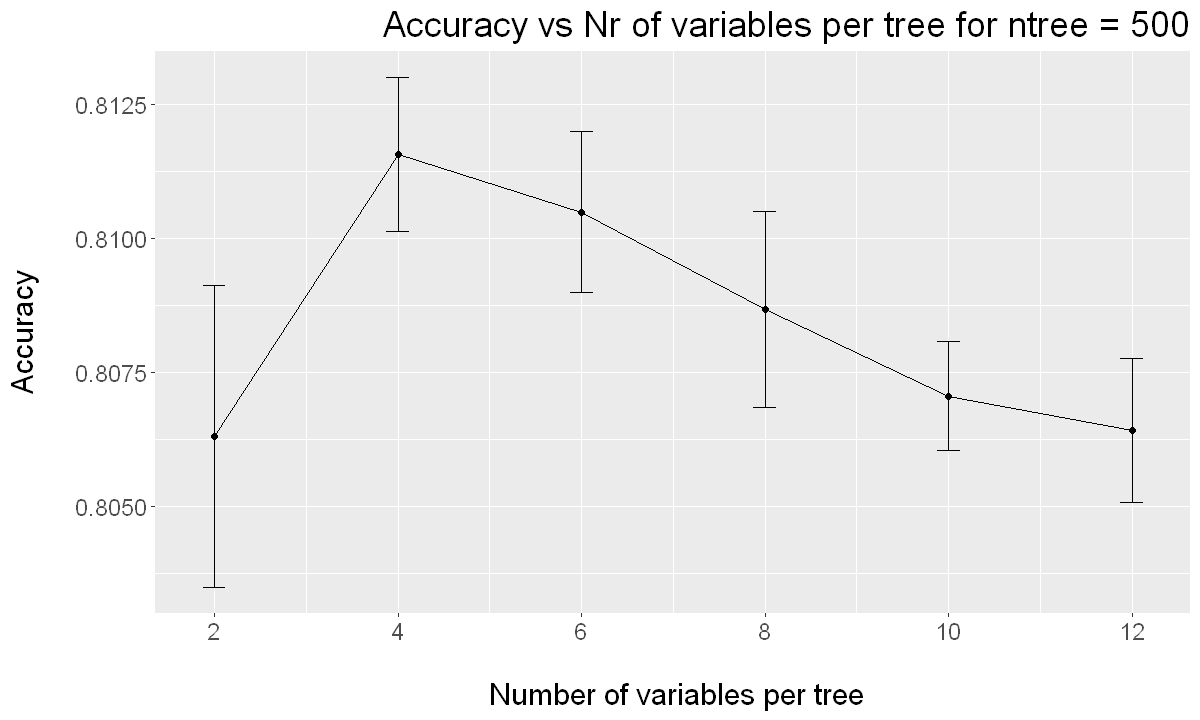

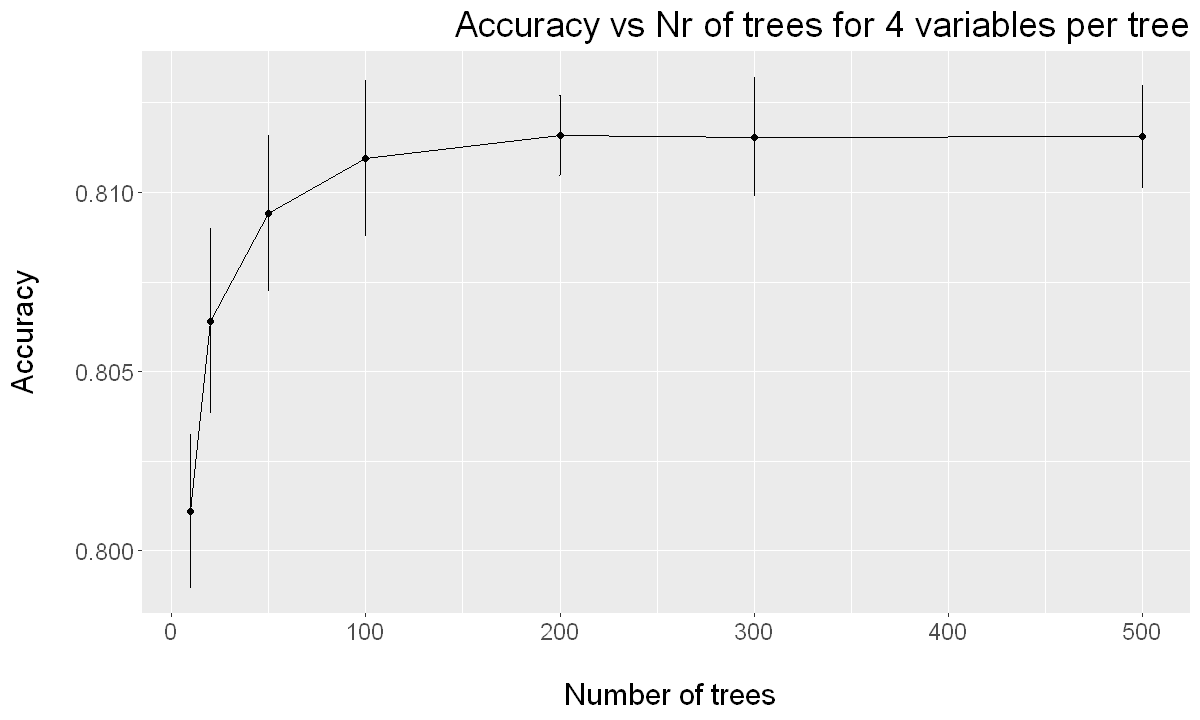

In [187]:
# find the value for which max accuracy is obtained
location_max <- which(max(cv_accuracy_matrix)==cv_accuracy_matrix, arr.ind = TRUE)

# plot accuracy in function of nr of variables per tree for ntree = 200
plotdata <- as.data.frame(cbind(nr_of_variables=nr_of_variables_per_tree_values[1:ncol(cv_accuracy_matrix)], 
                                accuracy=cv_accuracy_matrix['200',], 
                                sd=cv_sd_matrix['200',]))

plotdata.x <- plotdata$nr_of_variables
plotdata.y <- plotdata$accuracy
y.sd <- plotdata$sd

options(repr.plot.width=10, repr.plot.height=6)
ggplot(plotdata, aes(x = plotdata.x, y= plotdata.y)) +
    geom_line() +
    geom_point() +
    geom_errorbar(aes(x=plotdata.x, ymin=plotdata.y-y.sd, ymax=plotdata.y+y.sd), width=0.25) +
    scale_x_continuous(breaks = plotdata.x) +
    labs(title = "Accuracy vs Nr of variables per tree for ntree = 200", 
         y = "Accuracy\n", 
         x = "\n Number of variables per tree") +
    theme(plot.title = element_text(hjust = 1),
          text = element_text(size=18))

#plot  accuracy in function of nr of variables per tree for ntree = 500
plotdata <- as.data.frame(cbind(nr_of_variables=nr_of_variables_per_tree_values[1:ncol(cv_accuracy_matrix)], 
                                accuracy=cv_accuracy_matrix['500',], 
                                sd=cv_sd_matrix['500',]))

plotdata.x <- plotdata$nr_of_variables
plotdata.y <- plotdata$accuracy
y.sd <- plotdata$sd

options(repr.plot.width=10, repr.plot.height=6)
ggplot(plotdata, aes(x = plotdata.x, y= plotdata.y)) +
    geom_line() +
    geom_point() +
    geom_errorbar(aes(x=plotdata.x, ymin=plotdata.y-y.sd, ymax=plotdata.y+y.sd), width=0.25) +
    scale_x_continuous(breaks = plotdata.x) +
    labs(title = "Accuracy vs Nr of variables per tree for ntree = 500", 
         y = "Accuracy\n", 
         x = "\n Number of variables per tree") +
    theme(plot.title = element_text(hjust = 1),
          text = element_text(size=18))

# plot accuracy in function of ntrees for nr_of_variables = 4
plotdata <- as.data.frame(cbind(ntrees=ntree_values[1:nrow(cv_accuracy_matrix)], 
                                accuracy=cv_accuracy_matrix[,'4'], 
                                sd=cv_sd_matrix[,'4']))

plotdata.x <- plotdata$ntrees
plotdata.y <- plotdata$accuracy
y.sd <- plotdata$sd

options(repr.plot.width=10, repr.plot.height=6)
ggplot(plotdata, aes(x = plotdata.x, y= plotdata.y)) +
    geom_line() +
    geom_point() +
    geom_errorbar(aes(x=plotdata.x, ymin=plotdata.y-y.sd, ymax=plotdata.y+y.sd), width=0.25) +
    #scale_x_continuous(breaks = plotdata.x) +
    labs(title = "Accuracy vs Nr of trees for 4 variables per tree", 
         y = "Accuracy\n", 
         x = "\n Number of trees") +
    theme(plot.title = element_text(hjust = 1),
          text = element_text(size=18))

The figures above show that in 5-fold crossvalidation, the best number of trees for a random forest is four. In the first two figures, one can see very well the bias/variance trade-off. When having too little features (i.e. less than 4), we have a high bias of the prediction. When using too many features (i.e. more than four, or even six), the prediction worsens again as the number of features per tree grow due to the correlation between the trees. 

In the third figure, we can see that with four variables per tree, the accuracy does not increase that much after having 200 trees. Using the law of large numbers, (Breiman, 2001) proved that the accuracy will converge to a maximum, and consequently random forests will not suffer much from overfitting as more trees are added. However, the computational cost increases when creating more trees than necessary. Therefore, we say that 200 trees is the optimal value for the parameter ntree.

| number of trees | number of variables per tree | Accuracy (mean ; standard deviation) |
|:----------------|:-----------------------------|:-------------------------------------|
| 200             | 4                            | 81.2% +/- 0.11                       |
*Best accuracy found with 4 variables per tree and 200 trees*

**Averaged Confusion matrix**  
The averaged confusion matrix for a random forest created with 4 variables per tree and 200 trees is the following:

| Real: &darr; / Predicted: &rarr;                   | functional | functional needs repair | non functional |
|:-------------------------|:------------------------|:------------------------------------|:----------------------------|
| **functional**              | 90.0%                  | 2.0%                               | 8.0%                       |
| **functional needs repair** | 53.4%                  | 32.4%                               | 14.2%                      |
| **non functional**          | 21.0%                  | 1.3%                               | 77.6%                      |

Although, the prediction of the "functional needs repair" class is still suffering from the imbalance of the dataset, we had a small increase on the classification rate of the "functional needs repair" class. Moreover, the classification rate for all classes increased and the bagging made the standard deviation of the accuracy decrease to 0.11%. The mean accuracy also increased to 81.2%.

In [188]:
if(RUN_LONG_COMPUTATIONS){
    set.seed(1705)
    library(randomForest)
    Dn <- readRDS(file = "preprocessed/categorical_train_preprocessed.rds")
    Dn <- merge_low_frequency_levels(Dn, to_merge=c('lga'), cutoff = 0.015)  

    k <- 5

    # our best performing learner
    learner <- function(Dtr){
        randomForest(status_group~., Dtr, ntree=200, mtry=4 )
    }

    # compute the confusion matrix
    cm <- averaged_confusion_matrix(k, Dn, learner)

    # row-normalize the confusion matrix
    cm <- cm/rowSums(cm)
    saveRDS(cm, file="model_results/randomforest/randomforest_final_conf_matrix.RDS")
}
cm <- readRDS(file="model_results/randomforest/randomforest_final_conf_matrix.RDS")
cm

                   func func but rep    nonfunc
func         0.90024489   0.02005642 0.07969869
func but rep 0.53393560   0.32406764 0.14199676
nonfunc      0.21034876   0.01349457 0.77615668

## Model 5: Support Vector Machine

SVMs represent each sample as a point in the state space and then try to create a separating hyperplane that maximizes the closest pair of points belonging to different classes in that space. Furthermore, it is possible to use different types of kernels to first transform the feature space into a higher dimension with the purpose of the classes being more separable in this higher dimension. The kernel used can have a large impact on the prediction performance and is therefore one of the main hyperparameters that is commonly tuned. 

The most commonly used kernels in SVM are:
- linear
- polynomial
- radial basis functions

The other hyperparameters to tune depend on the chosen kernel and can have an equally strong influence on the performance. The most commonly tuned parameters are:
- cost (or commonly referred to as C), the regularization parameter which influences the margin of class separation;
- degree, the degree of the polynomial (only relevant for a polynomial kernel);
- gamma ($\gamma$), which influences the "narrowness of the function" and thus how far the influence of a single sample point should reach (irrelevant for a linear kernel).

**Input & Output**  
SVM tries to find a hyperplane that maximizes distance or similarity and we should give it all numerical inputs. 
Therefore, the input is the one-hot encoded preprocessed data which introduces the issue of scaling. Since we are dealing with dummy features and "real numeric features" the values for these features can differ a lot in orders of magnitude. This can negatively impact the performance of SVM since it tries to maximize the "distance" between the support vectors and the separating hyperplane. If a couple of features have much larger values than others the model will be more biased towards these features when calculating this distance. Scaling is therefore important to ensure all features have a similar influence in distance calculations. The svm method of e1071, however, does this scaling by default internally.
The output does not need any special encoding.

**One-vs-one**    
It is important to mention SVMs normally perform binary classification. However, they are expandable to multi-class via a one-vs-one or a one-vs-rest approach. The SVM from our R library uses a one-vs-one approach by default. In this approach a separate classifier will be trained for each different pair of classes, while a one-vs-rest approach would just train one classifier per one class. In most cases a one-vs-one approach would train more classifiers and will thus be computationally more expensive, but since we're dealing with only 3 classes both would come down to training 3 classifiers. That's why we used the default one-vs-one approach of the e1071 library.

The idea is that for each pair of features the decision boundaries, like the one plotted below, will be computed after which a majority vote will decide what the final prediction is.

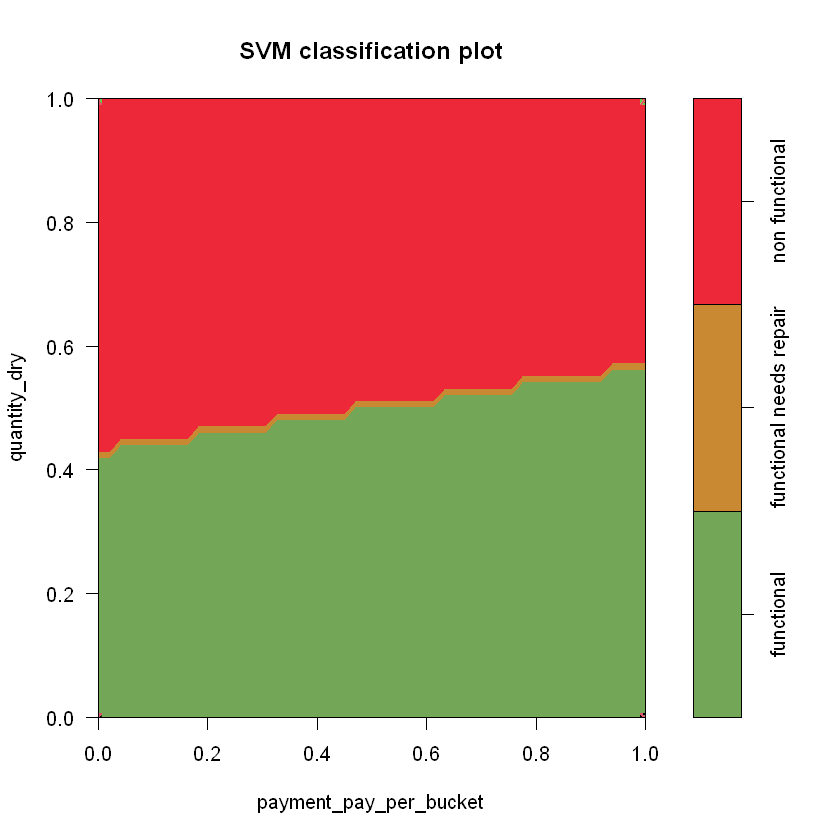

In [189]:
# read in our preprocessed data
preprocessed <- readRDS("preprocessed/mrmr80_one_hot_train_preprocessed.rds")

# read in our best performing model
svm_rbf <- readRDS("model_results/svm/model_svm_rbf.rds")

# plot SVM classification plot
group_colors <- c("#73A657","#C98932","#ED2939") 
options(repr.plot.width=7, repr.plot.height=7)
plot(svm_rbf, preprocessed, quantity_dry ~ payment_pay_per_bucket, col=group_colors)

### Hyperparameter tuning

The SVM library of R provides its own "tune.svm" function that can be used to tune hyperparameters using cross-validation. However, to keep our approach in line with the other models we used our own cross-validation function for tuning.

**Kernels**  
Three different kernels were shortly investigated in order of complexity (from less complex to more complex): linear, polynomial and then rbf.

In [190]:
if (RUN_LONG_COMPUTATIONS) {
    set.seed(1705)

    # read in the preprocessed training data
    preprocessed <- readRDS("preprocessed/mrmr80_one_hot_train_preprocessed.rds")

    # specify the number of folds for cv
    n_folds <- 5

    accuracy_cv_means <- numeric()
    accuracy_cv_sds <- numeric()

    # 5-fold CV for SVM with linear kernel
    print(paste("[INFO] - Testing SVM with linear kernel"))
    svm_linear <- function(Dtr) svm(status_group ~ ., Dtr, kernel = 'linear', scale = TRUE)
    linear_results <- execute_kfold_crossvalidation(n_folds, preprocessed, svm_linear)
    accuracy_cv_means <- c(accuracy_cv_means,linear_results$accuracy)
    accuracy_cv_sds <- c(accuracy_cv_sds,linear_results$stddev)

    # 5-fold CV for SVM with polynomial kernel and degree 5
    print(paste("[INFO] - Testing SVM with polynomial kernel (degree = 5)"))
    svm_poly <- function(Dtr) svm(status_group ~ ., Dtr, kernel = 'polynomial', degree = 5, scale = TRUE)
    poly_results <- execute_kfold_crossvalidation(n_folds, preprocessed, svm_poly)
    accuracy_cv_means <- c(accuracy_cv_means,poly_results$accuracy)
    accuracy_cv_sds <- c(accuracy_cv_sds,poly_results$stddev)

    # 5-fold CV for SVM with polynomial kernel and degree 10
    print(paste("[INFO] - Testing SVM with polynomial kernel (degree = 10)"))
    svm_poly <- function(Dtr) svm(status_group ~ ., Dtr, kernel = 'polynomial', degree = 10, scale = TRUE)
    poly_results <- execute_kfold_crossvalidation(n_folds, preprocessed, svm_poly)
    accuracy_cv_means <- c(accuracy_cv_means,poly_results$accuracy)
    accuracy_cv_sds <- c(accuracy_cv_sds,poly_results$stddev)

    # 5-fold CV for SVM with radial basis kernel
    print(paste("[INFO] - Testing SVM with radial basis kernel"))
    svm_rbf <- function(Dtr) svm(status_group ~ ., Dtr, kernel = 'radial', scale = TRUE)
    rbf_results <- execute_kfold_crossvalidation(n_folds, preprocessed, svm_rbf)
    accuracy_cv_means <- c(accuracy_cv_means,rbf_results$accuracy)
    accuracy_cv_sds <- c(accuracy_cv_sds,rbf_results$stddev)

    # save the results
    saveRDS(data.frame(hyperparams=c('linear','poly5','poly10','rbf'), 
                       accuracy=accuracy_cv_means, sd=accuracy_cv_sds), "model_results/svm/SVM_results.RDS")
}

svm_results <- readRDS("model_results/svm/SVM_results.RDS")
svm_results

hyperparams,accuracy,sd
<chr>,<dbl>,<dbl>
linear,0.7187037,0.004305043
poly5,0.7655219,0.003163908
poly10,0.7134175,0.001220684
rbf,0.7794949,0.005010574


### Analysis

We investigated 3 kernels in order of complexity (from less complex to more complex): linear, polynomial and then rbf. 
The idea was to also perform a grid search on the hyperparameters mentioned above, but just from investigating the different kernels it was already clear SVM would be too computationally expensive for our purposes. This was somewhat to be expected since they are mostly used for high dimensional problems with a lower number of samples. The kernel trick, in which we use a dual formulation that represents our data by a an N x N kernel matrix (with N = number of samples), causes our specific problem to have very large memory requirements and training time. 

There are definitely approaches possible to deal with these issues, e.g. a divide-and-conquer approach that allows training on smaller sample sizes and aggregating the results or simply tuning the hyperparameters on a smaller subset and checking the result for the whole training set. However, because the initial results of SVM were also rather unsatisfactory compared to other models we abandoned the route of SVM early on. It should be noted that hyperparameter tuning could have had a large effect and maybe even let SVM give better predictions than random forests, but the computational requirements were too high either way for our use case. 

Nevertheless it is clear that the more complex, non-linear kernels generally outperform the linear kernel which indicates our feature space is probably not so linearly separable (which was already somewhat clear from the ElasticNet model). Furthermore, it's also clear that other hyperparameters can have a large influence since a high-degree polynomial clearly overfits the data and performs even worse than the linear models.


| Kernel                  | Accuracy (mean ; standard deviation) |
|:------------------------|:-------------------------------------|
| Linear (C = 1)                  |    71.9% +/- 0.4                                  |
| Polynomial (degree = 5, C = 1, gamma = 0.0125) |   76.6% +/- 0.3                  |
| Polynomial (degree = 10, C = 1, gamma = 0.0125) | 71.3% +/- 0.1                     |
| Radial basis (C = 1, gamma = 0.0125)           | 77.9% +/- 0.5                     |

**Averaged Confusion matrix**  
We will also take a look at the cross-validation averaged confusion matrix for our best performing model to gain more insight into which classes are more often confused with each other.

| Real: &darr; / Predicted: &rarr;                   | functional | functional needs repair | non functional |
|:-------------------------|:------------------------|:------------------------------------|:----------------------------|
| **functional**              | 92.4%                  | 0.9%                               | 67.1%                       |
| **functional needs repair** | 65.4%                  | 19.7%                               | 14.9%                      |
| **non functional**          | 30.4%                  | 0.8%                               | 68.8%                      |

The same effects of class imbalance are visible for this model as for the previous models. The predictions are a bit more balanced than for the ElasticNet model, but more imbalanced than for kNN. The proportion of correct "functional" predictions is higher than for Nearest Neighbors, but is lower for both "functional needs repair" and "non functional". As mentioned before, the total accuracy of both types of models is comparable but the computational time needed for SVM is much higher which makes it less suited for our problem.

In [191]:
if (RUN_LONG_COMPUTATIONS) {
    set.seed(1705)

    k <- 5

    # our best performing learner
    learner <- function(Dtr) svm(status_group ~ ., Dtr, kernel = 'radial', scale = TRUE)

    # compute the confusion matrix
    cm <- averaged_confusion_matrix(k, preprocessed, learner)

    # row-normalize the confusion matrix
    cm <- cm/rowSums(cm)

    # save the results
    saveRDS(cm, "model_results/svm/svm_final_conf_matrix.RDS")
}

# read the results back in and present them
cm <- readRDS("model_results/svm/svm_final_conf_matrix.RDS")
cm

                    func func but rep     nonfunc
func         0.924021203  0.008834744 0.067144053
func but rep 0.654389622  0.196895993 0.148714385
nonfunc      0.303627760  0.007886435 0.688485804

## Model 6: Artificial Neural Networks

ANN's are a machine learning technique inspired by the idea of biological neural networks. The network consists of an input layer, a number of hidden layers (in this case 1) and finally an output layer. The input layer has a number of nodes equal to the dimension of a training sample. The hidden layer can have a varying number of nodes (this is a hyperparameter). The output layer will have a node for each classification class. Each node represents the probability of one class. The training goal of this technique is to fine-tune the weights of the edges between the nodes to best represent the underlying target function.   
The two most straightforward hyperparameters to tune are:

- **Size**: Amount of nodes in the hidden layer. This parameter essentially represents the complexity of the model. The more neurons there are in this layer, the more representational power the model has. Increasing this would thus decrease the bias but increase the variance.

- **Decay**: A regularisation parameter to avoid overfitting. This represents a scalar which is multiplied with the weights and added to the cost function. This makes the cost function prefer lower weights which translates to a simpler model. The higher this scalar, the more the weight growth will be repressed during training.

There are a couple of parameters which are fixed depending on the learning problem.
-	Because we are in a multi class classification setting. The output layer has a SoftMax activation function. This means that the outputs are normalized to depict probabilities. We are dealing with three possible classes, this means that our prediction will contain 3 values for each datapoint. Each value represents the probability for one of the classes.
-	The activation function for the hidden layer has two possible options. A straightforward linear combination and a sigmoid function. As we are not interested in the linear case we will use the sigmoid activation function.

**Normalization**  
Neural networks perform best when the input data is normalized, that is why we will use the normalized dataset returned by our preprocessing procedure.

## Hyperparameter tuning

First a simple ANN will be trained to get an idea of the expected accuracy. The accuracy will be evaluated using 5-fold crossvalidation.

The hyperparameters are set as follows: 
- size: 5
- decay: 0
- maxit will be 3000 : The max amount of iterations to train the nnet, in most cases it will converge before this.
- rang = 0.5 : This means the initial weight values will be set randomly in the range [-0.5, 0.5].


In [192]:
Dn_preprocessed <- readRDS("preprocessed/mrmr80_norm_one_hot_train_preprocessed.rds")

In [193]:
set.seed(1705)
n_folds <- 5

if (RUN_LONG_COMPUTATIONS){
    simple_ann <- function(Dtr) nnet(status_group ~ .,data=Dtr,size=5,skip=FALSE,trace=F, maxit=3000,rang=0.5,decay=0)
    results_simple_ann <- execute_kfold_crossvalidation(n_folds, Dn_preprocessed, simple_ann)
    saveRDS(results_simple_ann, "model_results/ann/simple_ann_results.RDS")
}

results <- readRDS("model_results/ann/simple_ann_results.RDS")
results

$accuracy
[1] 0.7453199

$stddev
[1] 0.006174574

We get an average accuracy of 74.5%, which is not bad but could be better. Next we will try to increase the model's accuracy by finetuning the hyperparameters.

### Tuning the size of the hidden layer

Some different sizes of hidden layers where tested to see which performs best. We tested 10 different sizes: [5,10,15,20,25,30,40,50,60,80]. For each size a neural network was trained and evaluated with 5-fold cross validation. The results are saved in an rds file: ann_results and are also plotted. The decay hyperparameter will be tuned later this and was set to 0 in this test

In [194]:
if (RUN_LONG_COMPUTATIONS){
    set.seed(1705)

    # read in the preprocessed training data
    preprocessed_scaled <- readRDS("preprocessed/mrmr80_norm_one_hot_train_preprocessed.rds")

    # specify the number of folds for cv
    n_folds <- 5

    sizes <- c(5,10,15,20,25,30,40,50,60,80)

    accuracy_cv_means <- numeric()
    accuracy_cv_sds <- numeric()

    # perform cv for each hyperparameter value
    for(s in sizes){
        print(paste("[INFO] - Testing size = ", s))

        ann <- function(Dtr) nnet(status_group ~ .,data=Dtr,size=s,skip=FALSE,trace=F, maxit=3000,rang=0.5,decay=0,MaxNWts=7000)
        results <- execute_kfold_crossvalidation(n_folds, preprocessed_scaled, ann)
        accuracy_cv_means <- c(accuracy_cv_means,results$accuracy)
        accuracy_cv_sds <- c(accuracy_cv_sds,results$stddev)
    }                

    #save the results
    saveRDS(data.frame(size=sizes, accuracy=accuracy_cv_means, sd=accuracy_cv_sds), "model_results/ann/ann_results.RDS")
}

In [195]:
Dn <- readRDS("model_results/ann/ann_results.RDS") # This file contains the generated results from above

#### Plotting the accuracy vs number of nodes

Below we plotted the accuracy of the model (based on 5-fold cross validation) in function of the number of nodes in the hidden layer. We see from this plot that the accuracy increases with the number of nodes up until 30 nodes with an accuracy of 77%. Increasing it further causes the accuracy to drop. It would be a good idea to use 30 hidden nodes in the following evaluations. The reason this accuracy drops when the complexity of the model rises probably has to do with overfitting. This makes it interesting to see if adding weight decay will increase the accuracy as this is a form of regularization.

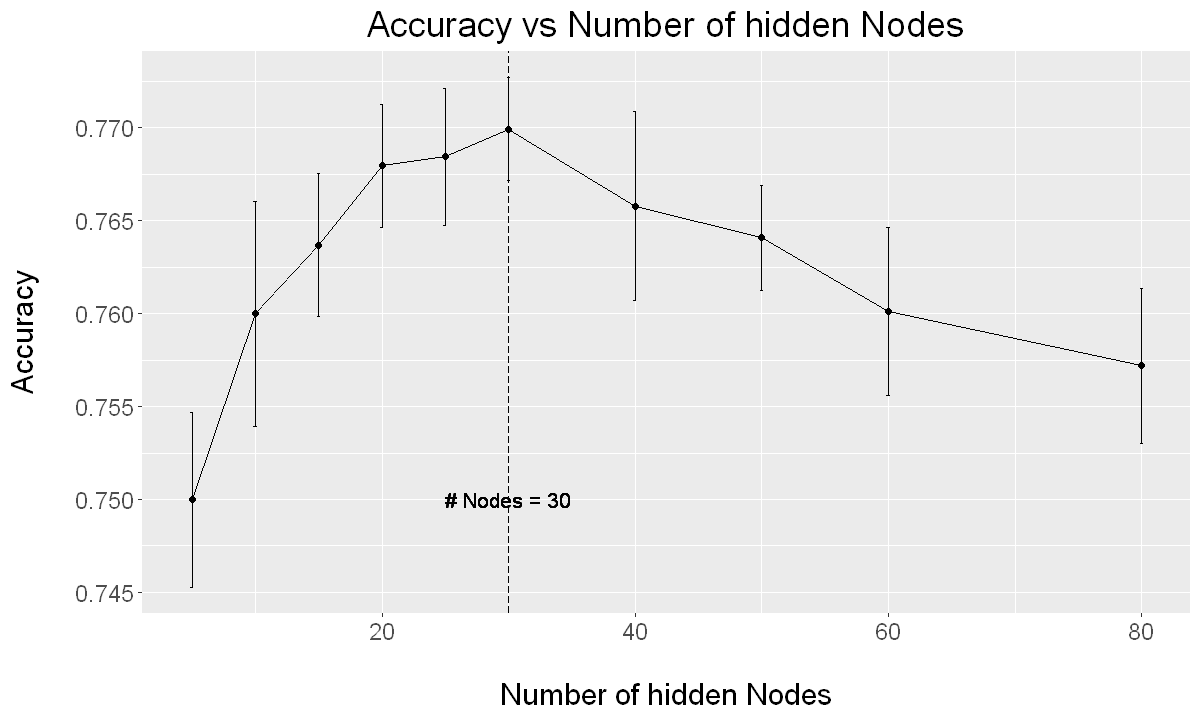

In [196]:
Dn.x <- Dn$size
Dn.y <- Dn$accuracy
y.sd <- Dn$sd

# plot results
options(repr.plot.width=10, repr.plot.height=6)  
ggplot(Dn,aes(x = Dn.x, y= Dn.y)) +
    geom_line() + 
    geom_point() +
    geom_errorbar(aes(x=Dn.x, ymin=Dn.y-y.sd, ymax=Dn.y+y.sd), width=0.25) +
    geom_vline(xintercept=c(30), linetype="longdash") +
    geom_text(aes(x=30, label="# Nodes = 30", y=0.75), size=4.5) +
    labs(title = "Accuracy vs Number of hidden Nodes", y = "Accuracy\n", x = "\nNumber of hidden Nodes") +
    theme(plot.title = element_text(hjust = 0.5),
          text = element_text(size=18))

### Tuning the weight decay

The next parameter we tuned was **Weight decay**. This method penalizes weights that grow too large and thus essentially prevents the model from becoming too complex. A search was done to find the best weight decay value. The tested decay values are (0.0001, 0.001, 0.01, 0.025, 0.05, 0.1). Number of hidden nodes was set to 30, which was the best result so far.

In [197]:
decays <- c(0.0001, 0.001, 0.01, 0.025, 0.05, 0.1)

In [198]:
if (RUN_LONG_COMPUTATIONS){
    set.seed(1705)

    # read in the preprocessed training data
    preprocessed_scaled <- readRDS("preprocessed/mrmr80_norm_one_hot_train_preprocessed.rds")

    # specify the number of folds for cv
    n_folds <- 5

    accuracy_cv_means <- numeric()
    accuracy_cv_sds <- numeric()

    # perform cv for each hyperparameter value
    for(d in decays){
        print(paste("[INFO] - Testing decay = ", d))
        print(Sys.time())
        ann <- function(Dtr) nnet(status_group ~ ., data = Dtr, size=30 ,skip=FALSE, trace=F, maxit=3000, rang=0.5, decay=d, MaxNWts=2600)
        results <- execute_kfold_crossvalidation(n_folds, preprocessed_scaled, ann)
        accuracy_cv_means <- c(accuracy_cv_means,results$accuracy)
        accuracy_cv_sds <- c(accuracy_cv_sds,results$stddev)
    }               

    #save the results
    saveRDS(data.frame(decay=decays, accuracy=accuracy_cv_means, sd=accuracy_cv_sds), "model_results/ann/ann_results_decay.RDS")
}

# read the results back in
Dn <- readRDS("model_results/ann/ann_results_decay.RDS")

#### Plotting the accuracy vs weight decay

Below we plotted the accuracy of the model (based on 5-fold cross validation) in function of the weight decay hyperparameter. We see from this plot that a weight decay of 0.01 performs best with an accuracy of: 77,4%. The accuracy more or less stagnates starting from this value.

It would be a good idea to try other values, for example between 0.01 and 0.05, however this is computationally expensive and thus takes a long time. This is why we decided to stop the tuning process here. 

In [199]:
Dn.x <- Dn$decay
Dn.y <- Dn$accuracy
y.sd <- Dn$sd

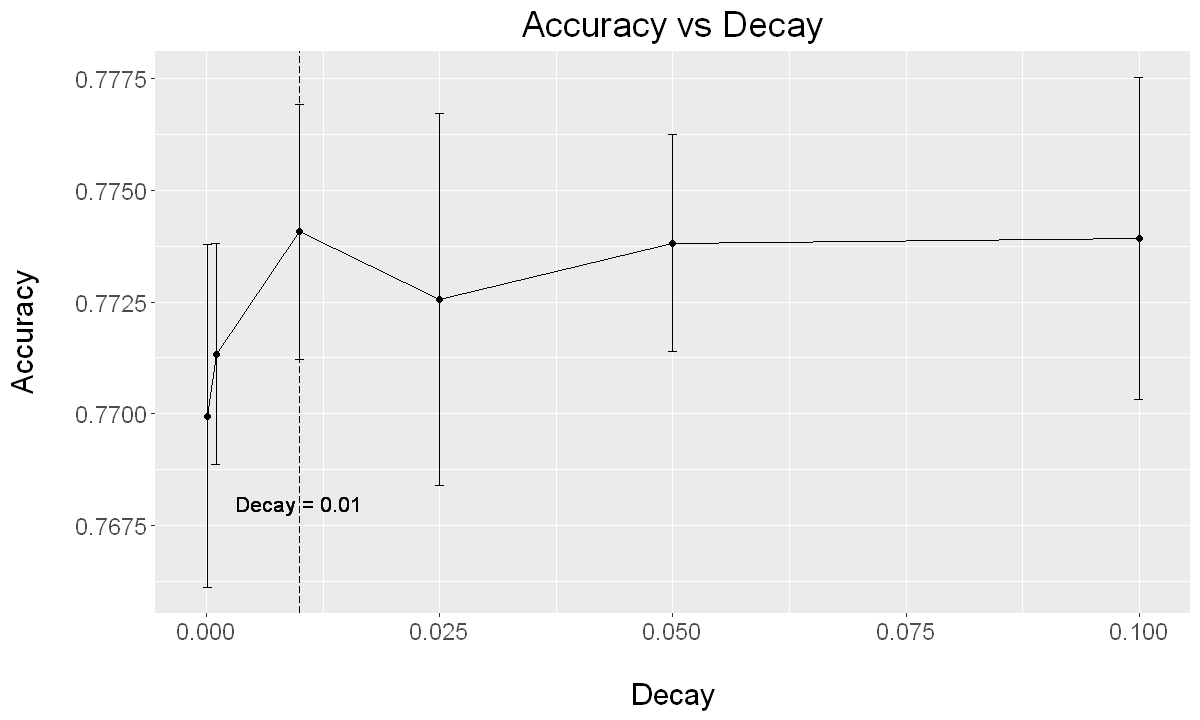

In [200]:
# plot results
options(repr.plot.width=10, repr.plot.height=6)  
ggplot(Dn,aes(x = Dn.x, y= Dn.y)) +
    geom_line() + 
    geom_point() +
    geom_errorbar(aes(x=Dn.x, ymin=Dn.y-y.sd, ymax=Dn.y+y.sd), width=0.001) +
    geom_vline(xintercept=c(0.01), linetype="longdash") +
    geom_text(aes(x=0.01, label="Decay = 0.01", y=0.768), size=4.5) +
    labs(title = "Accuracy vs Decay", y = "Accuracy\n", x = "\nDecay") +
    theme(plot.title = element_text(hjust = 0.5),
          text = element_text(size=18))

### Model analysis

From the tests we performed we see that an artificial neural network with **30 hidden nodes and a weight decay of 0.01** performs best with **an accuracy of 77,4% (+/- 0.4)**. Below we plot a confusion matrix to gain more insight in the misclassifications.

In [201]:
if (RUN_LONG_COMPUTATIONS){
    set.seed(1705)
    n_folds <- 5
    
    preprocessed_scaled <- readRDS("preprocessed/mrmr80_norm_one_hot_train_preprocessed.rds")

    final_ann <- function(Dtr) nnet(status_group ~ .,data=Dtr,size=30,skip=FALSE,trace=F, 
                                    maxit=3000,rang=0.5,decay=0.01, MaxNWts=2600)

    av_conf_matrix <- averaged_confusion_matrix(n_folds, preprocessed_scaled, final_ann)
    
    # save the confusion matrix
    saveRDS(av_conf_matrix, "model_results/ann/ann_final_conf_matrix.RDS")
}

# Load the saved confusion matrix
conf <- readRDS("model_results/ann/ann_final_conf_matrix.RDS")

The relative confusion matrix for the fine-tuned ANN model:

| Real: &darr; / Predicted: &rarr;                   | functional | functional needs repair | non functional |
|:-------------------------|:------------------------|:------------------------------------|:----------------------------|
| **functional**              | 86.8%                  | 2.14%                               | 11%                       |
| **functional needs repair** | 54.85%                  | 26.22%                               | 18.92%                      |
| **non functional**          | 24.95%                  | 1.78%                               | 73.25%                      |

We see from this confusion matrix that the model will overclassify instances as **functional**. Most of the **functional needs repair** classes are missclassified as **functional**. This could have a couple of reasons. Probably the most important reason is the fact that the training data is highly unbalanced. Especially the **functional needs repair** data is very scarse. There will of course be other factors which cause this behaviour but this is more difficult to pinpoint.

The model is fairly good at identifying **functional** samples but this could also be a consequence of the relative overrepresentation of this class. Because the training data (and thus also the test data) contains a lot of **functional** samples, the general accuracy gives a somewhat distorted picture of the overall performance on each class separately.

## Model Summary

| Model          | Accuracy (mean +/- sd)     | 
|----------------|----------------------------|
| ElasticNet     | 73.8 +/- 0.6               | 
| kNN            | 77.5 +/- 0.3               | 
| Decision Tree  | 78.7 +/- 0.4               | 
| Random Forest  | 81.2 +/- 0.1               | 
| SVM            | 77.9 +/- 0.5               |
| Neural Network | 77.4 +/- 0.4               |

A variety of models have been tried out. The relatively simple kNN model performed well while tuning was straightforward and easy, while others like the neural network needed more tuning and much more computational resources to get a similar score on accuracy. A model like SVM could perhaps have had a better performance with further tuning, but it was so computationally heavy that it is unsuitable for our use case.

It is clear though that the tree-based learners and specifically random forests perform well for our classification problem. They have a good accuracy and are computationally efficient. This might be because they can exploit the categorical data better than our other models who needed one-hot encoding. 

Lastly, it should also be noted that in all our models class imbalance has a huge effect with the minority class suffering from misclassification a lot.

**Submission**

Since the Random Forest model clearly performed the best and we used the winner-takes-all approach, we created a submission to the driven data contest leaderboard using this model trained on the whole dataset. 

In [202]:
# create final model based on the whole dataset, and create a submission for the DrivenData competition.
if(RUN_LONG_COMPUTATIONS){
    set.seed(1705)
    Dn_rf <- readRDS("preprocessed/categorical_train_preprocessed.rds")
    rf <- randomForest(status_group~., Dn_rf, ntree=200, mtry=4 ) 
    saveRDS(rf, file = "model_results/randomforest/final_model.rds")
    
    Dtst_rf <- readRDS("preprocessed/categorical_test_preprocessed.rds")
    Yhat <- predict(rf, Dtst_rf)
    
    saveRDS(Yhat, file = "model_results/randomforest/final_model_predictions_test.rds")
    create_submission_file(Dtst_rf, Yhat, filename="predictions/16-05-2021/rf_best.csv")
}

The predictions of the above model were submitted to the DrivenData competition. We got the following result:

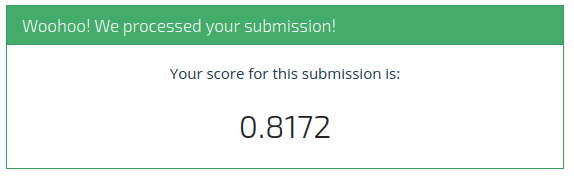


# Part 3: Alternative models

### Additional libraries

In [203]:
# install (uninstalled) packages needed for our alternative learning procedure
packages <- c("xgboost", "caret", "ggplot2")

install.packages(setdiff(packages, rownames(installed.packages())))  

In [204]:
library(xgboost)
library(caret)

library(ggplot2)

| Library      | Model                        |
|:-------------|:-----------------------------|
| xgboost        | Gradient Boosting (Trees)                |
| caret | Functions for training and plotting models               |

## Gradient Boosting Trees

With the insights from our previous models in mind, we decided to further investigate another type of tree-based learners that can really investigate areas of the sample space that experience more difficulties. More specifically, we investigated the use of gradient boosting trees.

Gradient boosting trees are a technique where in each successive step a new weak learner is produced that, combined with the previous learners, improves the overall accuracy. In short, boosting tries to produce new classifiers that are biased towards predicting samples well for which the existing ensemble is not performing well. The technique is called gradient boosting, because a derivable loss function is used to decide on the optimal next incremental step (i.e. the next optimal adjustment or "gradient"). The gradient boosting library we will use is 'xgboost' with as booster model a tree.

**Input & Output**  
XGBoost expects both the input and output to be numerical. This means, in contrast to random forest, we do need to use one-hot encoding to be able to deal with the categorical data. It should also be mentioned that we decided to use a preprocessed dataset without any prior automatic feature selection (mRMR) applied to it, i.e. a one-hot encoded version where only the manually dropped features have been excluded.
The ouput received a numerical label encoding.  

**Hyperparameter tuning**  
Since gradient boosting tree is able to deliver very complex models, there are a lot of hyperparameters that can have some influence on the final result. We mainly focused on the following ones:
- nrounds: number of boosting iterations, i.e. the number of boosting trees that will be generated
- eta or shrinkage: parameter in ]0,1[ and controlling the learning rate, i.e. what the contribution should be of each newly added tree. 
- max_depth: maximum depth of each boosting tree
- colsample_bytree: the fraction of features to consider when building a new boosting tree
- min_child_weight: a minimum weight required to create a new node, i.e. a type of regularization at the splitting step of a boosting tree

It is clear that all these hyperparameters will influence each other and should be tuned somewhat concurrently. For example, if we lower eta the learning process is slower which means nrounds should be higher to be able to actually learn what is possible from the data. A higher maximum depth will increase the complexity of each tree and therefore the chance of overfitting, while a very high min_child_weight or a very small eta will make each boosting step more conservative and therefore increase the chance of underfitting. 

A good tradeoff point should therefore be sought after in an intelligent way. Simple brute-force grid searching over a large range of possible combinations will yield many insensible combinations.

In [205]:
# read in our preprocessed data
preprocessed <- readRDS("preprocessed/full_one_hot_train_preprocessed.rds")

# create an xgb.DMatrix for training the xgboost model (preferred format for xgboost)
X_preprocessed <- subset(preprocessed, select=-c(status_group))
Y_preprocessed <- as.numeric(preprocessed$status_group) - 1 # labels should start from 0
Dn <- xgb.DMatrix(data = as.matrix(X_preprocessed), label = Y_preprocessed)

### Baseline

As a baseline for our performance we will perform a 5-fold CV on 500 rounds (with early stopping after 50 rounds if no improvement is found).

In [206]:
if (RUN_LONG_COMPUTATIONS) {
    set.seed(1705)

    # perform 5-fold cv on possible 500 rounds with early stopping after 50 rounds without improvement
    xgb_cv_results = xgb.cv(data = Dn, objective="multi:softmax", eval_metric = c('merror'),
                            nrounds=500, nfold=5, early_stopping_rounds = 50, num_class = 3, maximize = FALSE)

    # save the results
    saveRDS(xgb_cv_results, "model_results/xgbtree/baseline_xgb_cv.rds")
}

# read the results back in
xgb_cv_results <- readRDS("model_results/xgbtree/baseline_xgb_cv.rds")

# present the best iteration
xgb_cv_results$evaluation_log[iter== xgb_cv_results$best_iteration,]

iter,train_merror_mean,train_merror_std,test_merror_mean,test_merror_std
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
368,0.090206,0.001595267,0.1939224,0.002031009


It is clear that the baseline model needs a rather high number of iterations, which seems too computationally expensive for our use case. The mean training error and mean test error are also quite divergent, i.e. 9% train misclassifications and 19% test misclassifications.

So in a first grid search we will test out different combinations of the hyperparameters that are expected to have the highest impact on performance. We will investigate a range of eta, nrounds and max_depth values. The ranges will be kept moderately high for eta so nrounds can be kept moderately low which makes fast testing possible. We will also mostly investigate moderate max_depth values since our feature set is quite large, so trees with moderate max_depth values are still weak learners in our case. Too shallow trees would probably need too many rounds.

In [207]:
# 5-fold cross-validation options (same for all hyperparameter tuning grid searches)
xgb_trcontrol <- trainControl(
  method = "cv", 
  number = 5, 
)

In [208]:
if (RUN_LONG_COMPUTATIONS) {
    set.seed(1705)

    # set up our tuning grid (use defaults except for nrounds, eta, max_depth)
    xgb_grid <- expand.grid(
      nrounds = seq(from = 100, to = 200, by = 50),
      eta = c(0.05, 0.1, 0.2, 0.3),
      max_depth = c(6, 9, 12, 15),
      gamma = 0,
      colsample_bytree = 1,
      min_child_weight = 1,
      subsample = 1
    )

    # execute model training via caret
    xgb_model = train(
      X_preprocessed, preprocessed$status_group,  
      trControl = xgb_trcontrol,
      tuneGrid = xgb_grid,
      method = "xgbTree"
    )

    # save first caret model
    saveRDS(xgb_model, "model_results/xgbtree/xgb_model_gs_1.rds")
}

xgb_model <- readRDS("model_results/xgbtree/xgb_model_gs_1.rds")

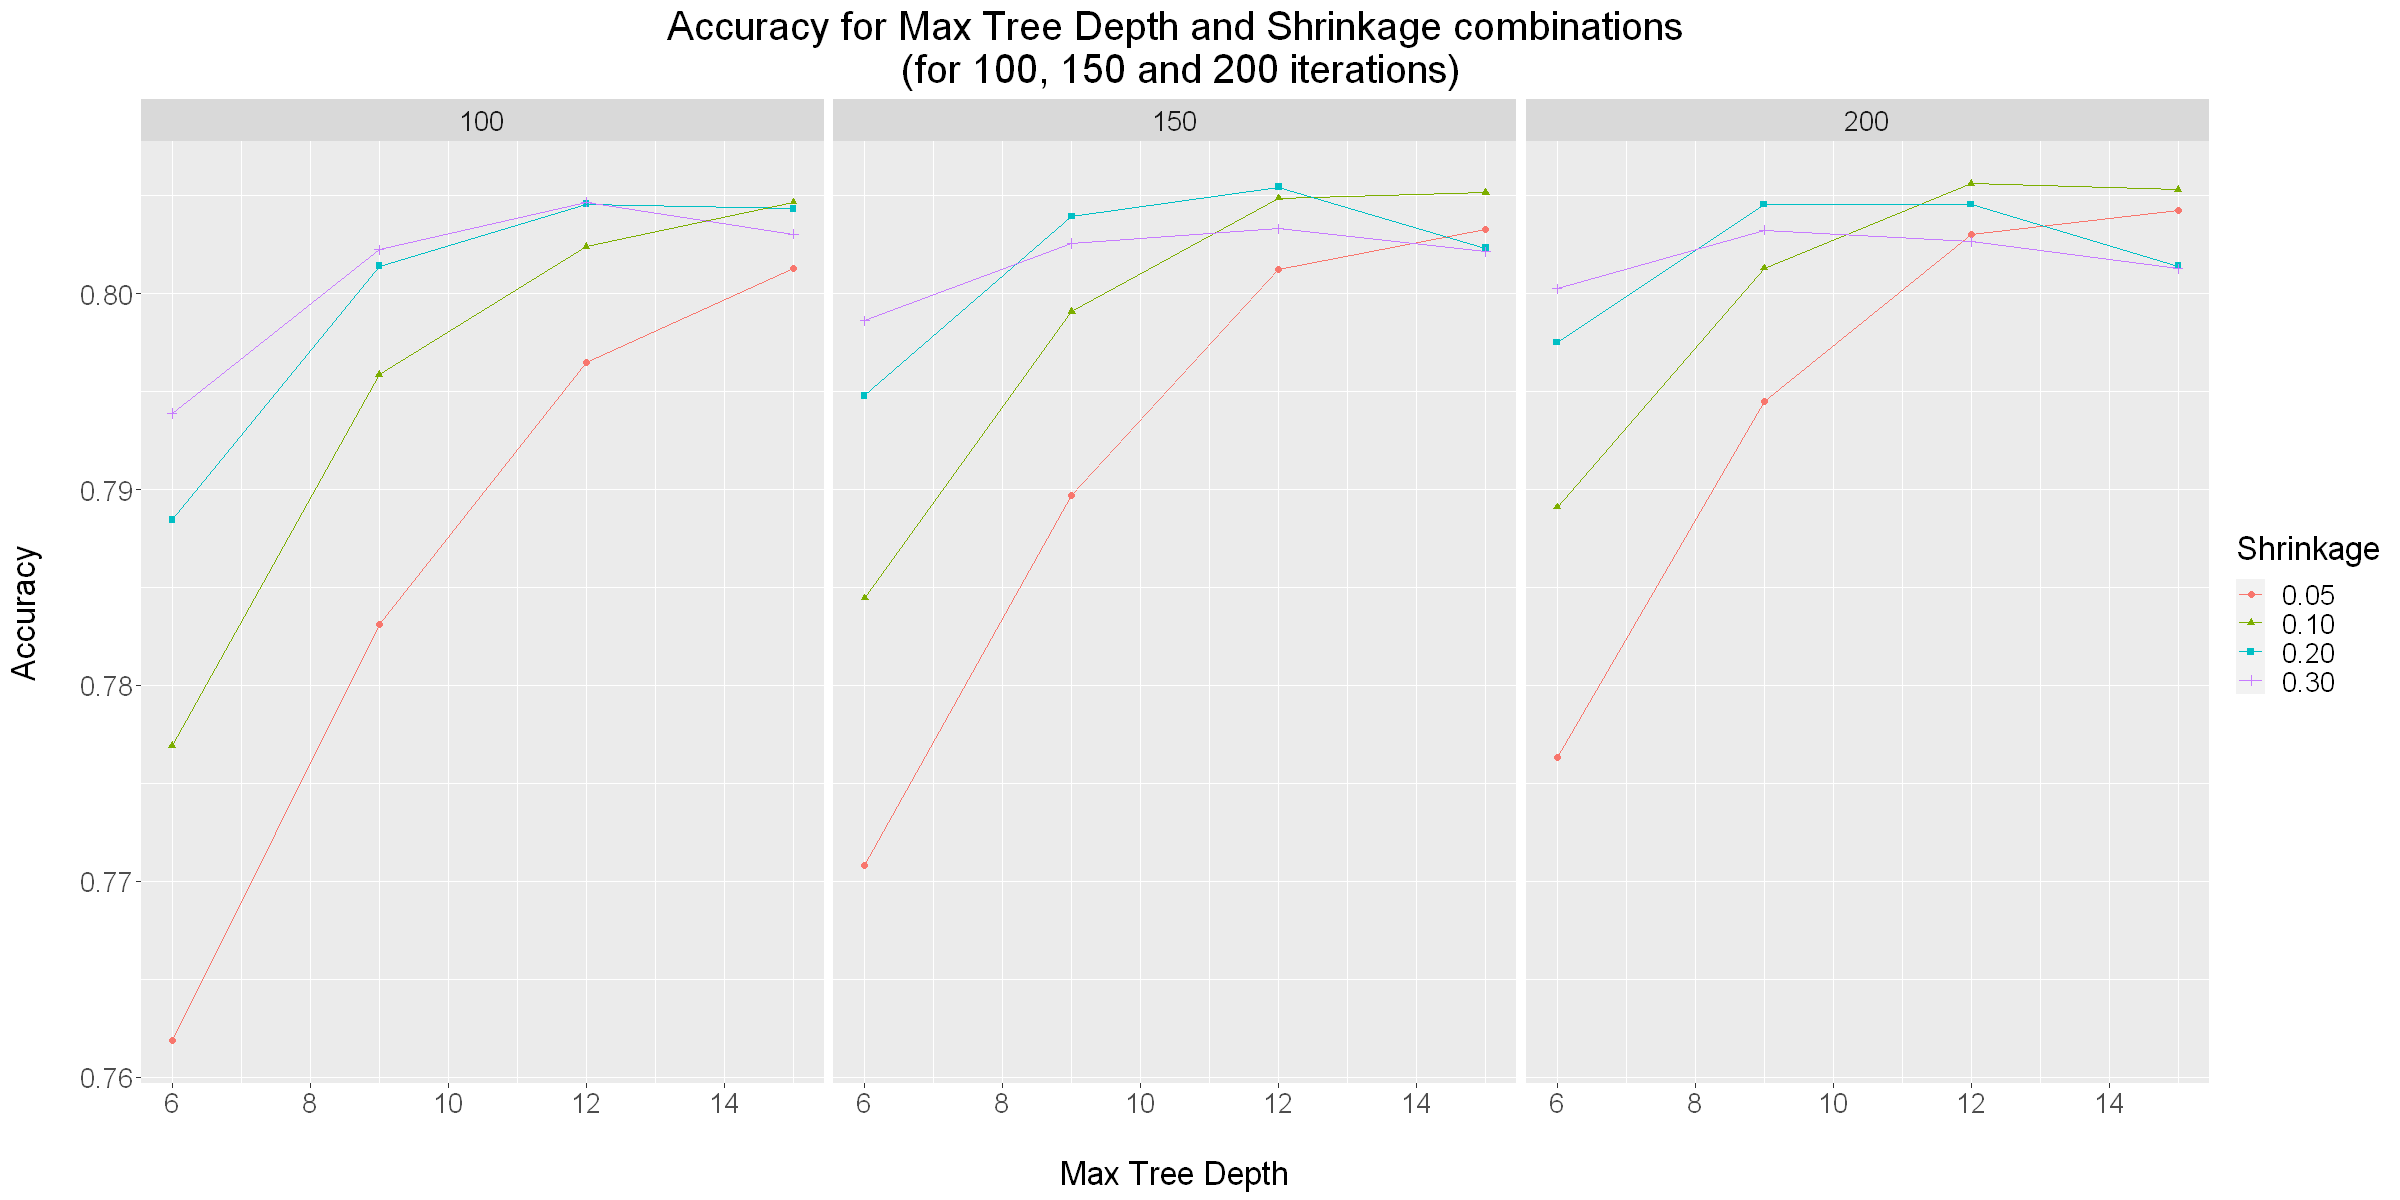

In [209]:
# plot the results
options(repr.plot.width=20, repr.plot.height=10)   
ggplot(xgb_model) +
    scale_x_continuous(breaks = seq(4, 16, by = 2)) +
    labs(title = "Accuracy for Max Tree Depth and Shrinkage combinations\n (for 100, 150 and 200 iterations)",
         y = "Accuracy\n", x = "\nMax Tree Depth") +
    theme(plot.title = element_text(hjust = 0.5),
          text = element_text(size=20))

Currently our best result is found for eta=0.1, max_depth=12 and nrounds=200. With the current settings, trying out deeper trees doesn't seem that beneficial except maybe for eta 0.05. In that case, more complexity seems to be beneficial in general either by introducing more boosting rounds or deeper trees.

We decided to investigate the influence of the other hyperparameters around the specifications with the best accuracy so far for computational reasons instead of further investigating slower learning models with lower eta and more nrounds.

We will fix eta for now and check the influence of different min_child_weight values around our best max_depth.

In [210]:
if (RUN_LONG_COMPUTATIONS) {
    set.seed(1705)
    
    # set up our tuning grid (fixed eta, smaller range of max_depth and check min_child_weight)
    xgb_grid <- expand.grid(
      nrounds = seq(from = 100, to = 200, by = 50),
      eta = xgb_model$bestTune$eta,
      max_depth = c(9, 12, 15),
      gamma = 0,
      colsample_bytree = 1,
      min_child_weight = c(1, 3, 5, 7),
      subsample = 1
    )
    
    # execute model training via caret
    xgb_model = train(
      X_preprocessed, preprocessed$status_group,  
      trControl = xgb_trcontrol,
      tuneGrid = xgb_grid,
      method = "xgbTree"
    )

    # save second caret model
   saveRDS(xgb_model, "model_results/xgbtree/xgb_model_gs_2.rds")
}

# read in resulting model
xgb_model <- readRDS("model_results/xgbtree/xgb_model_gs_2.rds")

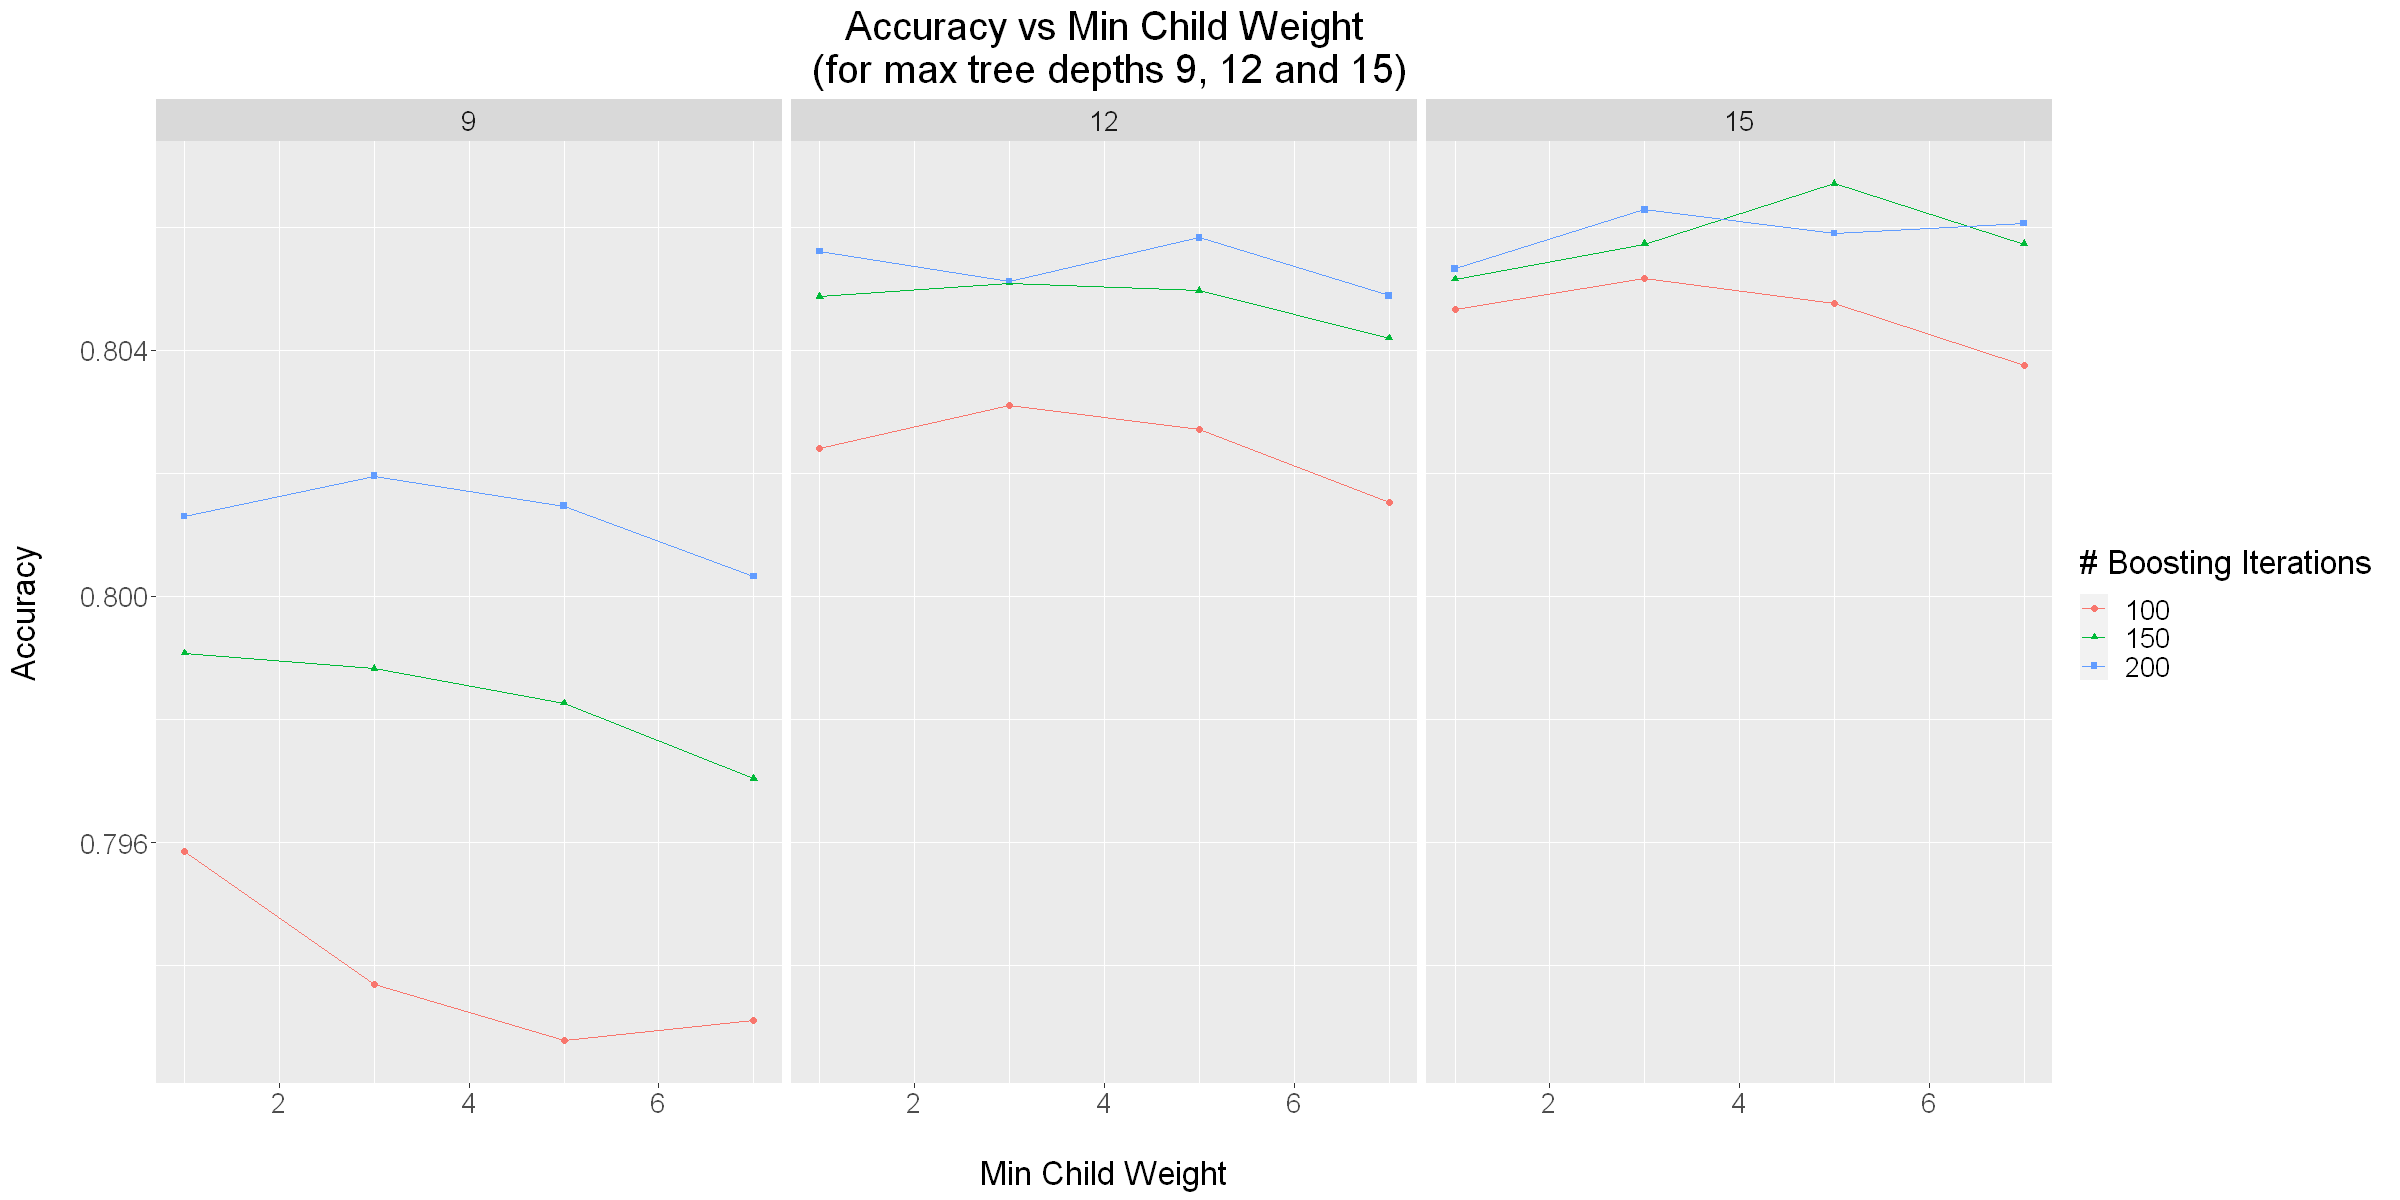

In [211]:
# plot the results
options(repr.plot.width=20, repr.plot.height=10)   
ggplot(xgb_model) +
    labs(title = "Accuracy vs Min Child Weight\n (for max tree depths 9, 12 and 15)",
         y = "Accuracy\n", x = "\nMin Child Weight") +
    theme(plot.title = element_text(hjust = 0.5),
          text = element_text(size=20))

It seems clear at this point that 150-200 boosting iterations combined with slightly higher max depth seem to perform better in our case. There might be some influence of increasing the max_depth further than 12, but this effect seems minimal. A min_child_weight of 3-5 also seems to be best in most cases with some fluctuations possible, but the effect seems rather minimal in general for higher iterations.

At this point the best tuning parameters are found for 150 rounds of trees with a max_depth of 15 and a min_child_weight of 5.   The obtained accuracy is 80.6% +/- 0.41%.

Now we will see the effect of colsample_bytree. According to Chen & Guestrin (2016) it is more suited to prevent overfitting than subsample, so that's why we mainly focused on this parameter instead of subsample.

In [212]:
if (RUN_LONG_COMPUTATIONS) {
    set.seed(1705)
    
    # set up our tuning grid (fixed eta, min_child_weight and small range of max_depth)
    xgb_grid <- expand.grid(
      nrounds = seq(from = 100, to = 200, by = 50),
      eta = xgb_model$bestTune$eta,
      max_depth = c(12, 15),
      gamma = 0,
      colsample_bytree = c(0.3, 0.4, 0.5, 0.6),
      min_child_weight = 4,
      subsample = 1
    )    

    # execute model training via caret
    xgb_model = train(
      X_preprocessed, preprocessed$status_group,  
      trControl = xgb_trcontrol,
      tuneGrid = xgb_grid,
      method = "xgbTree"
    )

    # save third caret model
   saveRDS(xgb_model, "model_results/xgbtree/xgb_model_gs_3.rds")
}

# read in resulting model
xgb_model <- readRDS("model_results/xgbtree/xgb_model_gs_3.rds")

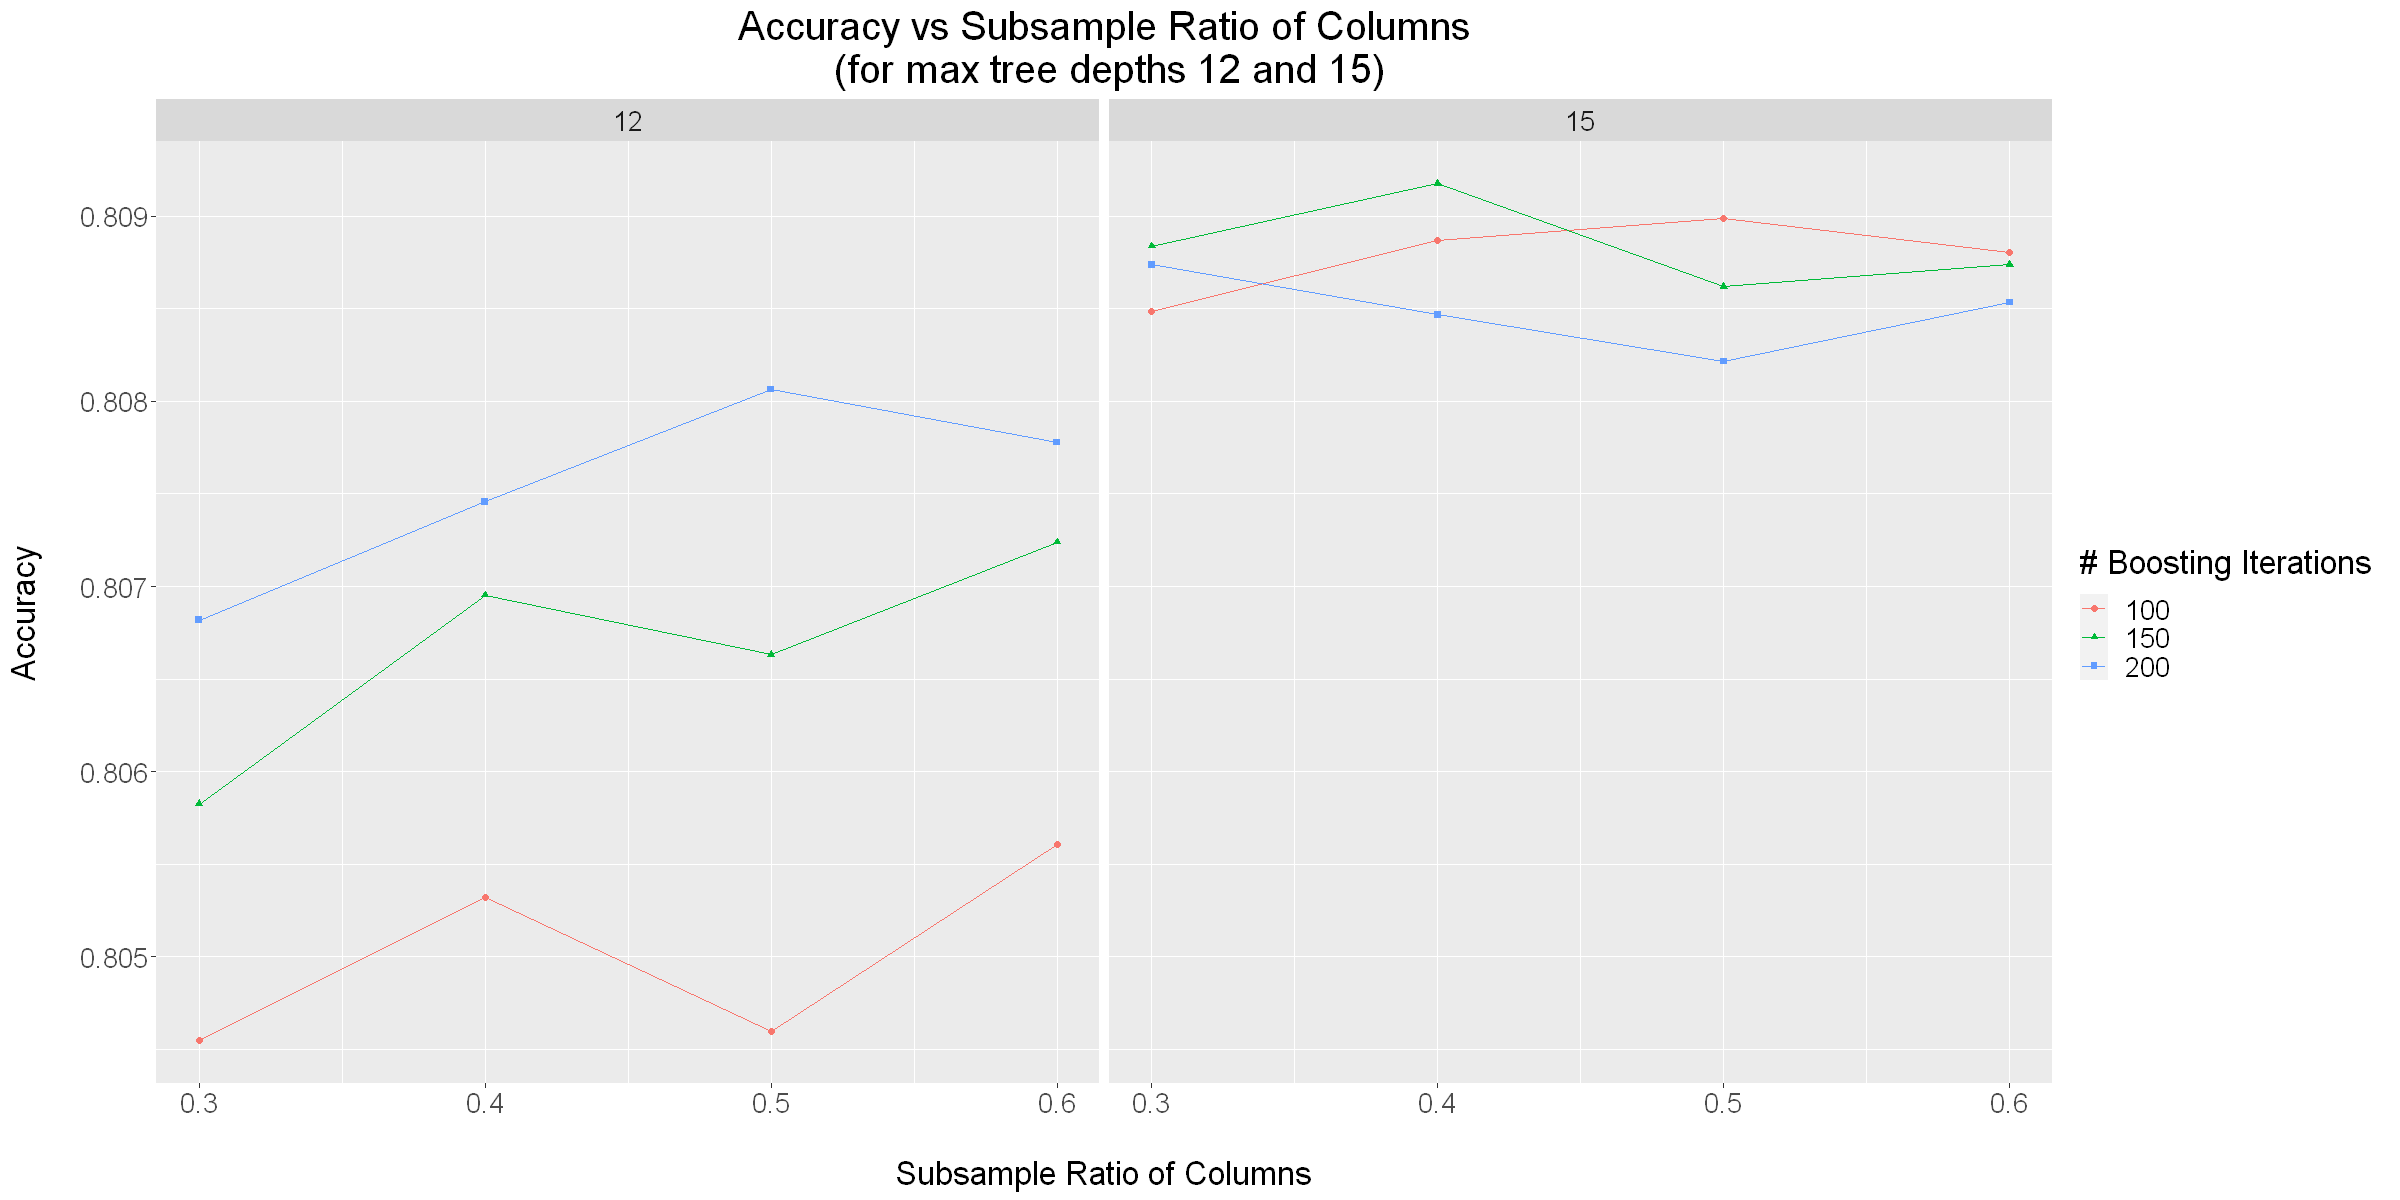

In [213]:
# plot the results
options(repr.plot.width=20, repr.plot.height=10)   
ggplot(xgb_model) +
    labs(title = "Accuracy vs Subsample Ratio of Columns\n (for max tree depths 12 and 15)",
         y = "Accuracy\n", x = "\nSubsample Ratio of Columns") +
    theme(plot.title = element_text(hjust = 0.5),
          text = element_text(size=20))

The effect of colsample_bytree is not that large for our setup at this point, but the optimal value seems to be around 0.4 and it's clearly more stable and overall better for a max_depth of 15. 

As a final grid search we will use our best found hyperparameter values so far for a range of smaller eta's and larger number of boosting iterations. This search is performed last since training models with small eta's and high boosting iterations can take quite a long time.

In [214]:
if (RUN_LONG_COMPUTATIONS) {
    set.seed(1705)
    
    # set up our tuning grid (reduced eta's, slightly higher amount of rounds)
    xgb_grid <- expand.grid(
      nrounds = seq(from = 100, to = 350, by = 50),
      eta = c(0.01, 0.015, 0.025, 0.05, 0.1),
      max_depth = xgb_model$bestTune$max_depth,
      gamma = 0,
      colsample_bytree = xgb_model$bestTune$colsample_bytree,
      min_child_weight = xgb_model$bestTune$min_child_weight,
      subsample = 1
    )    

    # execute model training via caret
    xgb_model = train(
      X_preprocessed, preprocessed$status_group,  
      trControl = xgb_trcontrol,
      tuneGrid = xgb_grid,
      method = "xgbTree"
    )

    # save final caret model
   saveRDS(xgb_model, "model_results/xgbtree/xgb_model_gs_final_eta.rds")
}

# read in resulting model
xgb_model <- readRDS("model_results/xgbtree/xgb_model_gs_final_eta.rds")

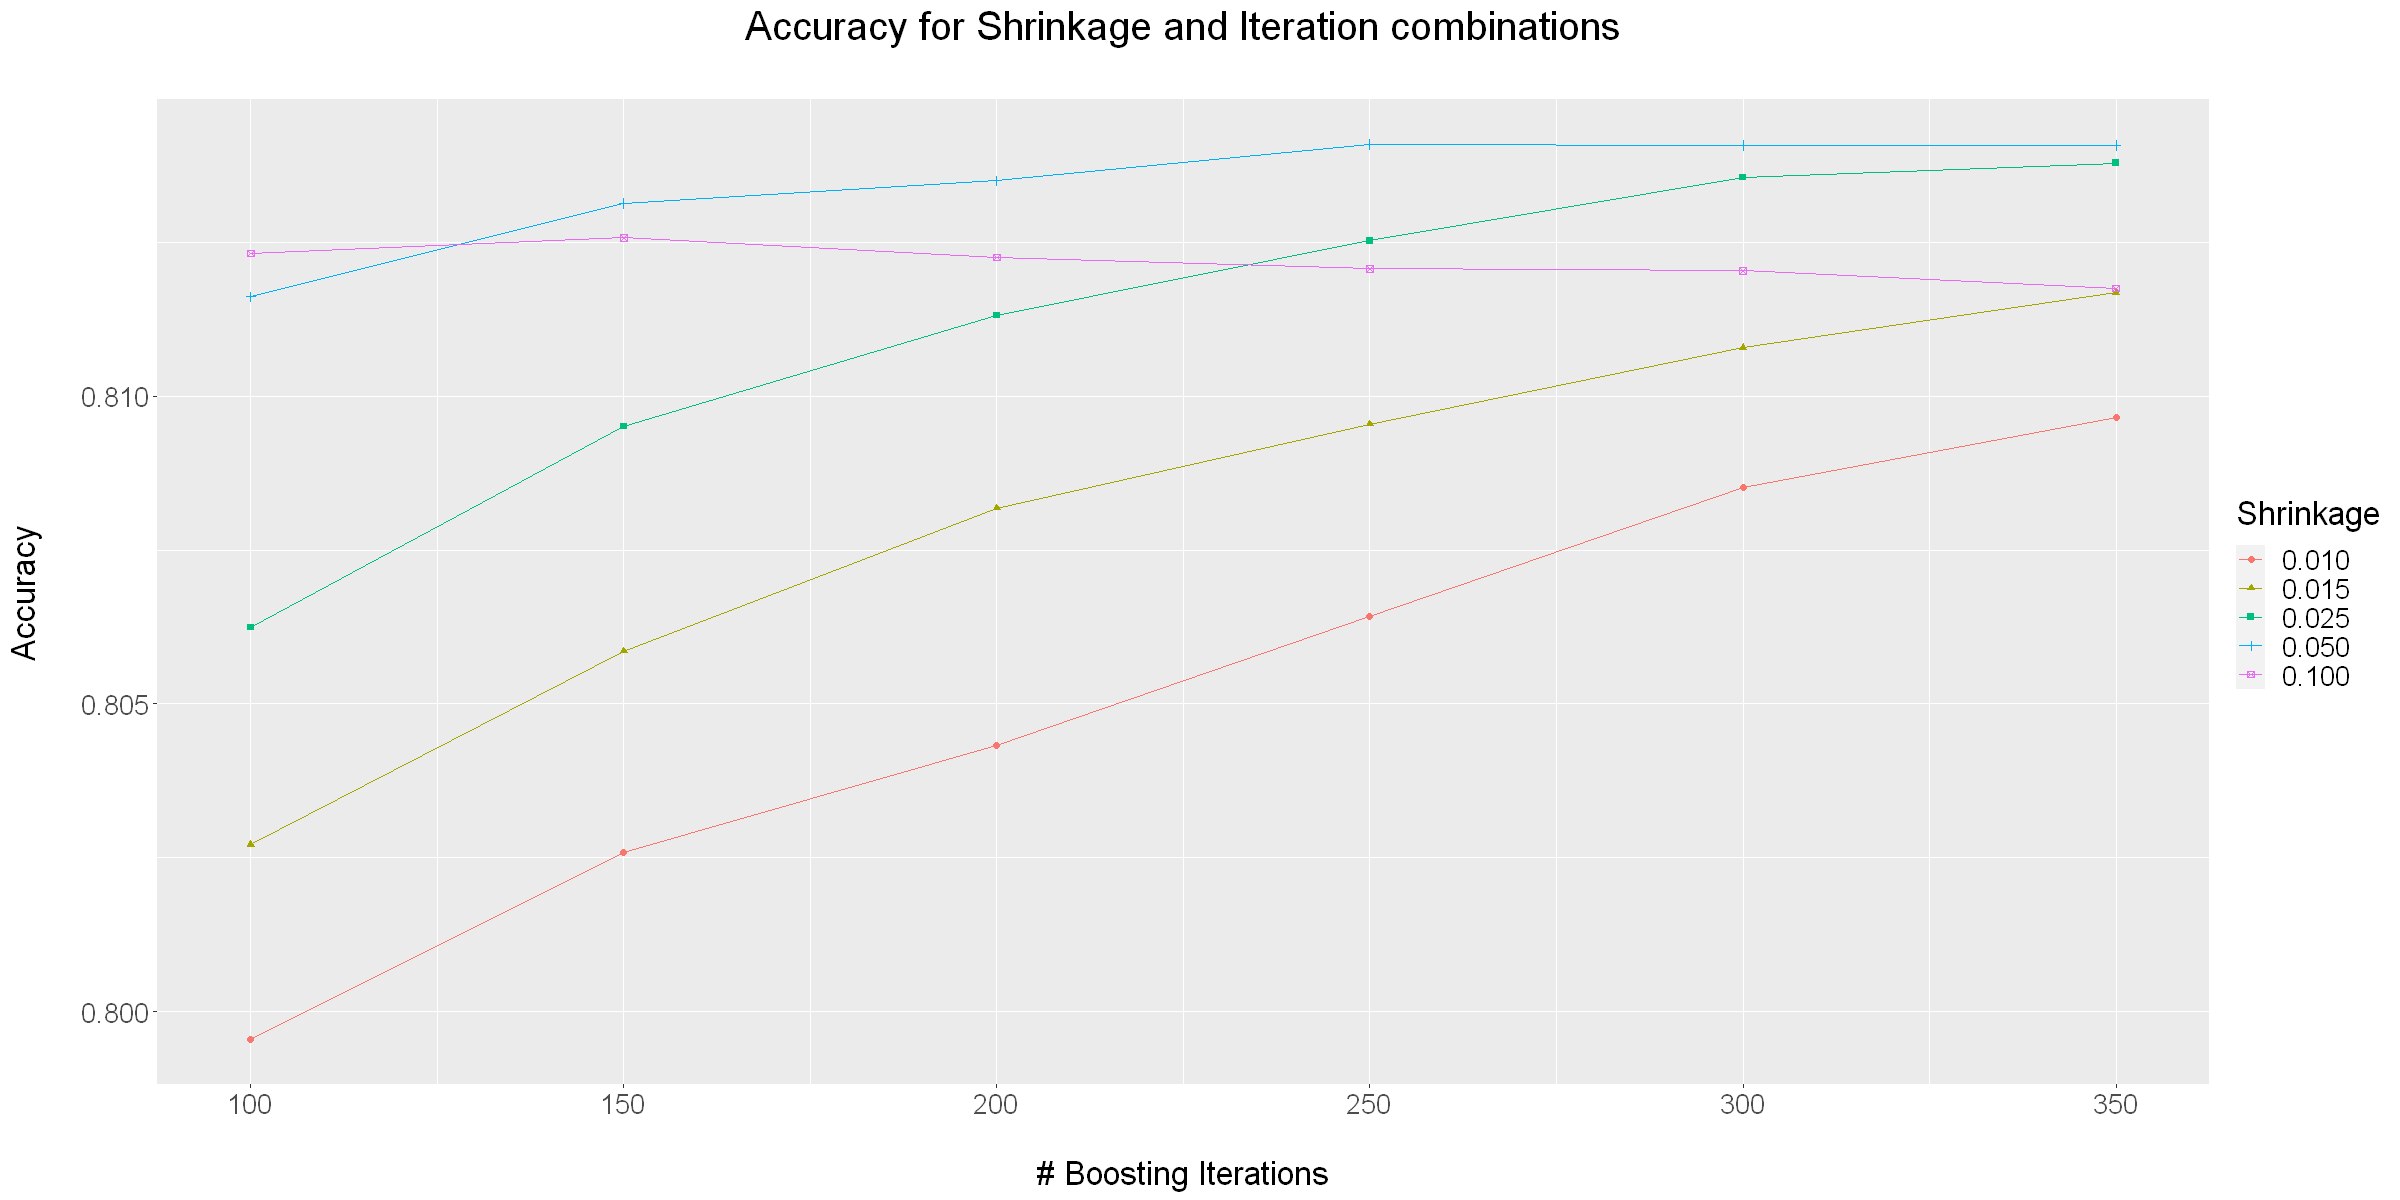

In [215]:
# plot the results
options(repr.plot.width=20, repr.plot.height=10)   
ggplot(xgb_model) +
    labs(title = "Accuracy for Shrinkage and Iteration combinations\n",
         y = "Accuracy\n", x = "\n# Boosting Iterations") +
    theme(plot.title = element_text(hjust = 0.5),
          text = element_text(size=20))

### Model analysis

With our current hyperparameter tuning approach where we searched further into area's that seemed promising, we got the best performing model with:
- eta = 0.05;
- max_depth = 15;
- min_child_weight = 4;
- colsample_bytree = 0.4

Convergence to optimal performance seems to occur somewhere **between 200 and 250 boosting rounds**. With these hyperparameters we obtained an **accuracy of 81.4 +/- 0.2**. This is an improvement over baseline performance.

**Averaged Confusion matrix**  
We will also take a look at the cross-validation averaged confusion matrix to see if the class imbalance is as present in this model as in the previous models.

| Real: &darr; / Predicted: &rarr;                   | functional | functional needs repair | non functional |
|:-------------------------|:------------------------|:------------------------------------|:----------------------------|
| **functional**              | 91.4%                  | 1.6%                               | 7.1%                       |
| **functional needs repair** | 56.1%                  | 29.9%                               | 14.1%                      |
| **non functional**          | 21.9%                  | 1.0%                               | 77.1%                      |

The effects of class imbalance are equally visible for this model as for the previous models. This is somewhat to be expected since our evaluation metric is still accuracy or misclassification error, so that's what we focused on mostly during the tuning of the boosting process.

In [216]:
if (RUN_LONG_COMPUTATIONS) {
    # set seed
    set.seed(1705)

    # get preprocessed data
    Dn_xgb <- preprocessed
    N <- nrow(Dn_xgb)
    
    # create folds for cross-validation
    n_folds <- 5
    test_idx_k_folds <- createFolds(1:N, k=n_folds)
    
    # create average confusion matrix
    CV_confusion_matrix <- matrix(0, nrow = 3, ncol = 3)
    rownames(CV_confusion_matrix) <- c("func", "func but rep", "nonfunc")
    colnames(CV_confusion_matrix) <- c("func", "func but rep", "nonfunc")

    for(k in 1:n_folds){

        # keep track of the predictions per sample id for each model in our ensemble
        predictions <- c()
        test_idx <- test_idx_k_folds[[k]]

        # create xgb.DMatrix
        X_preprocessed <- subset(Dn_xgb[-test_idx,], select=-c(status_group))
        Y_preprocessed <- as.numeric(Dn_xgb[-test_idx,]$status_group) - 1 # labels should start from 0
        Dn_xgb_DMatrix <- xgb.DMatrix(data = as.matrix(X_preprocessed), label = Y_preprocessed)

        # use the best found hyperparameters
        xgb_model = xgboost(data = Dn_xgb_DMatrix, objective="multi:softmax", eval_metric = c('merror'),
                            nrounds=250, num_class = 3, eta=0.05, max_depth=15, colsample_bytree = 0.4, 
                            min_child_weight=4)

        # predict labels of test data
        newdata_preprocessed <- subset(Dn_xgb[test_idx,], select=-c(status_group))
        predict <- predict(xgb_model, as.matrix(newdata_preprocessed))

        # change labels back to the orginal format
        predict[predict==0]<-"functional"
        predict[predict==1]<-"functional needs repair"
        predict[predict==2]<-"non functional"

        # keep track of the total number of predictions for each class
        CV_confusion_matrix <- CV_confusion_matrix + table(Dn_xgb[test_idx,"status_group"], predict)
    }
    
    CV_confusion_matrix <- CV_confusion_matrix/n_folds

    # row-normalize the confusion matrix
    CV_confusion_matrix <- CV_confusion_matrix/rowSums(CV_confusion_matrix)

    # save the results
    saveRDS(CV_confusion_matrix, "model_results/xgbtree/xgbtree_final_conf_matrix.RDS")    
}

# read the results back in and present them
cm <- readRDS("model_results/xgbtree/xgbtree_final_conf_matrix.RDS")
cm

                    func func but rep     nonfunc
func         0.913512508  0.015933538 0.070553954
func but rep 0.560806115  0.298355339 0.140838545
nonfunc      0.219374343  0.009945671 0.770679986

## Ensemble of models

Since our best performing models are the relatively complex random forest and gradient boosting tree, we investigated if creating an ensemble would further improve the performance. Each member model might make mistakes in certain specific areas of the sample space that are not made by other members. This means an averaging approach over their predictions could potentially have a beneficial effect. Ensembles are known to be more robust in general by reducing the variance in prediction errors and therefore improving overall performance of the model. 

Since our member models already needed quite some training time, especially the gradient boosting tree, we decided to use the relatively simple approach of majority voting to combine their predictions. In this approach each model simply makes his prediction for a sample and the most common prediction across models is eventually chosen as final prediction. In case of a tie, a random label is chosen among the tying ones.  

In pseudo-code our ensemble predictions work as follows:


```
With Models = a list of trained models
     Data = test data that needs predictions
Do
1. for each Model in Models
    predict label for all samples in Data
2. for each Sample in Data
    1. if a predicted label is the most common one
        select most common label for Sample
    2. otherwise
        select first label among the most common ones for Sample
3. return selected labels
```

### Ensemble of 5 gradient boosting trees

The first ensemble we tried out was an ensemble of 5 gradient boosting trees. Using more models in the majority vote might have been beneficial, but training one gradient boosting tree is already quite computationally expensive which is why we decided to only combine 5 of them. Furthermore, we used an approach where 5-fold cross-validation is performed internally during training to find the best performing number of boosting iterations and combined this with an early stopping rounds limit of 30 to further prevent overfitting.

We also performed  general 5-fold cross-validation of the entire ensemble to compare and  investigate the accuracy of the ensemble members and the final ensemble model.

In [217]:
if (RUN_LONG_COMPUTATIONS) {
    # set seed
    set.seed(1705)

    n_folds <- 5
    nr_of_learners <- 5
    CV_accuracy<- matrix(nrow=nr_of_learners + 1, ncol=n_folds)

    # creating dataset to work on the gradient boosting trees
    Dn_xgb <- readRDS("preprocessed/full_one_hot_train_preprocessed.rds")

    N <- nrow(Dn_xgb)
    test_idx_k_folds <- createFolds(1:N, k=n_folds)

    for(k in 1:n_folds){

        # keep track of the predictions per sample id for each model in our ensemble
        predictions <- c()
        test_idx <- test_idx_k_folds[[k]]

        # get predictions for the boosting trees
        for (i in 1:nr_of_learners){
            set.seed(i)

            # create xgb.DMatrix
            X_preprocessed <- subset(Dn_xgb[-test_idx,], select=-c(status_group))
            Y_preprocessed <- as.numeric(Dn_xgb[-test_idx,]$status_group) - 1 # labels should start from 0
            Dn_xgb_DMatrix <- xgb.DMatrix(data = as.matrix(X_preprocessed), label = Y_preprocessed)

            # use xgb.cv to find the best number of iterations
            xgb_cv_results = xgb.cv(data = Dn_xgb_DMatrix, objective="multi:softmax", eval_metric = c('merror'),
                                   nrounds=500, nfold=5, early_stopping_rounds = 30, num_class = 3, maximize = FALSE,
                                   eta=0.05, max_depth=15, colsample_bytree=0.4, min_child_weight=4)

            # use the same parameters, but now with the best found nrounds for the final (sub)model
            xgb_model = xgboost(data = Dn_xgb_DMatrix, objective="multi:softmax", eval_metric = c('merror'),
                                nrounds=xgb_cv_results$best_iteration, num_class = 3,
                                eta=0.05, max_depth=15, colsample_bytree = 0.4, min_child_weight=4)

            # predict labels of test data for current (sub)model
            newdata_preprocessed <- subset(Dn_xgb[test_idx,], select=-c(status_group))
            predict <- predict(xgb_model, as.matrix(newdata_preprocessed))

            # change labels back to the orginal format
            predict[predict==0]<-"functional"
            predict[predict==1]<-"functional needs repair"
            predict[predict==2]<-"non functional"

            CV_accuracy[i, k] <- calculate_accuracy(Dn_xgb[test_idx,"status_group"], predict)

            # store predictions of this (sub)model in column i
            predictions <- cbind(predictions, predict)
        }

        # perform majority voting (find maximal occurring label for each sample)
        ensemble_predictions <- apply(predictions, 1, function(x) names(which.max(table(x))))

        CV_accuracy[nr_of_learners + 1, k] <- calculate_accuracy(Dn_xgb[test_idx, "status_group"], ensemble_predictions)
    }

    # save results
    saveRDS(CV_accuracy, "model_results/ensemble/xgbtree5_ensemble_accuracy.rds")      
}

# read and present results
CV_accuracy <- readRDS("model_results/ensemble/xgbtree5_ensemble_accuracy.rds")                                   
summary <- cbind(mean=apply(CV_accuracy, 1, mean), sd=apply(CV_accuracy, 1, sd))*100
rownames(summary) <- c("xgbtree 1", "xgbtree 2", "xgbtree 3", "xgbtree 4", "xgbtree 5","ensemble")
summary

,mean,sd
xgbtree 1,81.34175,0.4000132
xgbtree 2,81.29125,0.3840174
xgbtree 3,81.34175,0.4384625
xgbtree 4,81.30135,0.4211110
xgbtree 5,81.36027,0.4088605
ensemble,81.35017,0.3796567


The results of using an ensemble of gradient boosting trees seems to lead to a small average gain on accuracy and a small improvement in deviation. The improvements, however, are rather small compared to the needed increase in computational requirements. Nevertheless, it still seems useful to investigate other ensembles as well.

### Ensemble with a balanced XGB.

The second ensemble we tried was one with 5 XGB trees. Four normal ones, each initialized with a different random seed, and one _balanced_  xgb tree. This balanced tree is trained on weighted samples, which tries to challenge the unbalanced nature of the dataset. A feature of the XGB library is that you can assign a weight to each individual sample. In an unbalanced setting this can be interesting because giving _scarse_ labels a higher weight than the _popular_ ones can have a balancing effect on the model.  

**Rationale**: Having 4 _normal_ XGB trees and one _balanced_ , we hope to achieve some kind of tie breaker  relationship. The four normal trees perform poorly on the samples labelled as _functional needs repair_ , this could lead to a situation in which the learners don’t agree. Because the balanced tree does better on this label, it could nudge the ensemble in this direction and lead to a correct prediction. 

In [218]:
preprocessed <- readRDS("preprocessed/full_one_hot_train_preprocessed.rds")

# the frequencies of the labels to normalize later
freqs <- table(preprocessed$status_group)/sum(table(preprocessed$status_group)) 

### Computing the weights

The helper function below will assign weights to each sample as dictated by the arguments. Given a number associated to a label, the function will output a vector with the same size as the dataset, with for each label the associated weight.

In [219]:
# helper function to compute a vector with for each sample in data
# the respective weight given in functional, repairs or nonfunctional based on that sample's label
compute_weights <- function(data, functional=1, repairs=1, nonfunctional=1) {
    N <- nrow(data)
    weights <- numeric(N)
    weights[which(data$status_group == 'functional')] <- functional
    weights[which(data$status_group == 'functional needs repair')] <- repairs
    weights[which(data$status_group == 'non functional')] <- nonfunctional
    return(weights)
}

Below we do cross validation with 5 folds for each separate learner and the enemble. This way we can see if the the ensemble has any added value over the individual learners.

To balance the 5th XGB tree, we assigned these weights to the classes: 

- Functional: 0.13
- Functional needs repair: 1
- Non functional: 0.19

This way the dataset should balance out.

In [220]:
# helper function used to compute confusion matrix during the cross validation underneath.
compute_conf_matrix <- function (Y, Yhat){
    Y <- factor(Y,levels=c("functional", "functional needs repair", "non functional"))
    Yhat <- factor(Yhat, levels=c("functional", "functional needs repair", "non functional"))
    confusion_matrix <- table(Y, Yhat)
    
    return(confusion_matrix)
}

In [221]:
if (RUN_LONG_COMPUTATIONS){
    # set seed
    set.seed(1705)

    n_folds <- 5
    nr_of_learners <- 5
    CV_accuracy<- matrix(nrow=nr_of_learners + 1, ncol=n_folds)
    conf_matrices <- list()

    # creating dataset to work on the gradient boosting trees
    Dn_xgb <- readRDS("preprocessed/full_one_hot_train_preprocessed.rds")

    N <- nrow(Dn_xgb)
    test_idx_k_folds <- createFolds(1:N, k=n_folds)

    for(k in 1:n_folds){

        # keep track of the predictions per sample id for each model in our ensemble
        predictions <- c()
        test_idx <- test_idx_k_folds[[k]]

        # add predictions for the boosting trees
        for (i in 1:nr_of_learners){
            set.seed(i)

            # create xgb.DMatrix
            X_preprocessed <- subset(Dn_xgb[-test_idx,], select=-c(status_group))
            Y_preprocessed <- as.numeric(Dn_xgb[-test_idx,]$status_group) - 1 # labels should start from 0

            if (i == nr_of_learners) {
                # the last learner gets weighted samples for balancing reasons
                balanced_weights <- compute_weights(Dn_xgb[-test_idx,], freqs[[2]]/freqs[[1]],1,freqs[[2]]/freqs[[3]])
                Dn_xgb_DMatrix <- xgb.DMatrix(data = as.matrix(X_preprocessed), label = Y_preprocessed, weight = balanced_weights)
            }
            else {
                # other learners are "normal" unweighted learners
                Dn_xgb_DMatrix <- xgb.DMatrix(data = as.matrix(X_preprocessed), label = Y_preprocessed)
            }

            # use xgb.cv to find the best number of iterations
            xgb_cv_results = xgb.cv(data = Dn_xgb_DMatrix, objective="multi:softmax", eval_metric = c('merror'),
                                   nrounds=500, nfold=5, early_stopping_rounds = 30, num_class = 3, maximize = FALSE,
                                   eta=0.05, max_depth=15, colsample_bytree=0.4, min_child_weight=4)

            # use the same parameters, but now with the best found nrounds for the final (sub)model
            xgb_model = xgboost(data = Dn_xgb_DMatrix, objective="multi:softmax", eval_metric = c('merror'),
                                nrounds=xgb_cv_results$best_iteration, num_class = 3,
                                eta=0.05, max_depth=15, colsample_bytree = 0.4, min_child_weight=4)

            # predict labels of test data for current (sub)model
            newdata_preprocessed <- subset(Dn_xgb[test_idx,], select=-c(status_group))
            predict <- predict(xgb_model, as.matrix(newdata_preprocessed))

            # change labels back to the orginal format
            predict[predict==0]<-"functional"
            predict[predict==1]<-"functional needs repair"
            predict[predict==2]<-"non functional"
            save

            CV_accuracy[i, k] <- calculate_accuracy(Dn_xgb[test_idx,"status_group"], predict)

            # store predictions of this (sub)model in column i
            predictions <- cbind(predictions, predict)
        }
        
        # perform majority voting (find maximal occurring label for each sample)
        ensemble_predictions <- apply(predictions, 1, function(x) names(which.max(table(x))))
        
        # compute the confusion matrix for the ensemble                             
        conf_matrices[[k]] <- compute_conf_matrix(Dn_xgb[test_idx, "status_group"], ensemble_predictions)
        CV_accuracy[nr_of_learners + 1, k] <- calculate_accuracy(Dn_xgb[test_idx, "status_group"], ensemble_predictions)
          
        # save the results (intermediately and final after last iteration)                              
        saveRDS(CV_accuracy, "model_results/ensemble_weighted/accuracy_majority_weighted.rds")
        saveRDS(conf_matrices, "model_results/ensemble_weighted/conf_matrix_majority_weighted.rds")                             
    }
    
    # read in the final results
    results <- readRDS("model_results/ensemble_weighted/accuracy_majority_weighted.rds")
    
    # computing the means of each fold
    means <- apply(results, 1, function(x) mean(x))
    sds <- apply(results, 1, function(x) sd(x))
    ensemble_evaluation <- data.frame(learner=c("xgb1", "xgb2", "xgb3", "xgb4", "balanced xgb", "ensemble"), 
                                      mean_accuracy=means, 
                                      sd=sds)
    # save the ensemble evaluation
    saveRDS(ensemble_evaluation, "model_results/ensemble_weighted/mean_accuracy_majority_weighted.rds")
    
    # read in all stored confusion matrices and compute the relative mean confusion matrix
    confs <- readRDS("model_results/ensemble_weighted/conf_matrix_majority_weighted.rds")
    CV_confusion_matrix <- matrix(0, nrow = 3, ncol = 3)
    for (conf in confs){
        CV_confusion_matrix <- CV_confusion_matrix+conf
    }
    relative_conf <- t(apply(CV_confusion_matrix, 1, function(x) x/sum(x)))
                             
    # save the mean confusion matrix
    saveRDS(relative_conf, "model_results/ensemble_weighted/rel_conf_matrix_majority_weighted.rds")   
}

# read in the final results
results <- readRDS("model_results/ensemble_weighted/accuracy_majority_weighted.rds")
mean_results <- readRDS("model_results/ensemble_weighted/mean_accuracy_majority_weighted.rds")
rel_conf <- readRDS("model_results/ensemble_weighted/rel_conf_matrix_majority_weighted.rds")

## Analysis

Below we see a table with the mean accuracy for each individual model and the ensemble. We see that the mean accuracy for the balanced XGB is significantly lower than the rest. This was to be expected as this model is not optimized to the distribution of the actual test set (which is still unbalanced).  

The ensemble accuracy is overall not an improvement, e.g. _xgbtree2_ performs better. We will also look at the confusion matrix to see if this learner is more accurate in general for the 3 classes. This would also be interesting because we are not 100% sure of the actual underlying distribution.

In [222]:
mean_results

,mean_accuracy,sd
,<dbl>,<dbl>
xgbtree 1,81.32155,0.3350655
xgbtree 2,81.37879,0.4644299
xgbtree 3,81.27273,0.4560783
xgbtree 4,81.31987,0.4015513
balanced xgbtree,74.73232,1.0393561
ensemble,81.36700,0.4337917


From this confusion matrix we see the same patterns emerge as from the previous models. There is no significant improvement for the _function needs repair_ class, which probably means that the more accurate learners (the first 4 gradient boosting trees) in the ensemble still dominate the results.

In [223]:
rel_conf

,functional,functional needs repair,non functional
functional,0.9146285,0.015561549,0.06980998
functional needs repair,0.5649757,0.299513551,0.13551077
non functional,0.2219593,0.009814231,0.76822643


### Ensemble with two XGB trees and two random forests

The last ensemble we tried out was combining two different models, namely two XGB trees and two random forests. 

**Rationale**: When combining different types of models, it might be that some of the models are better in some parts of the sample space than others. Since both random forests and gradient boosting trees each have a more random component, it might be interesting to combine two of each of them. 

This ensemble also uses two different preprocessing pipelines. The random forests use the categorical data, whereas the gradient boosting trees are using one-hot encoded data (without mRMR or normalisation).

We will execute a 5-fold cross validation to get an estimate of the accuracy of the ensemble model. 

In [224]:
if(RUN_LONG_COMPUTATIONS){
    # set seed
    set.seed(1705)

    n_folds <- 5
    nr_of_learners <- 4

    CV_accuracy<- matrix(nrow=nr_of_learners+1, ncol=n_folds)

    # creating dataset to work on the gradient boosting trees
    Dn_xgb <- readRDS("preprocessed/full_one_hot_train_preprocessed.rds")

    # creating dataset to work on the random forests
    Dn_rf <- readRDS("preprocessed/categorical_train_preprocessed.rds")
    
    N <- nrow(Dn_rf)
   
    # create the folds for the crossvalidation
    test_idx_k_folds <- createFolds(1:N, k=n_folds)

    for(k in 1:n_folds){
        # keep track of the predictions per sample id for each model in our ensemble
        predictions <- c()
        
        # split the test and train data for this crossvalidation iteration
        test_idx <- test_idx_k_folds[[k]]

        # get predictions for the boosting trees
        for (i in 1:2){
            print(paste(Sys.time(), ":","k=", k, "/", n_folds, "i=", i, "/", nr_of_learners))
            flush.console()

            set.seed(i)

            # create xgb.DMatrix 
            X_preprocessed <- subset(Dn_xgb[-c(test_idx),], select=-c(status_group))
            Y_preprocessed <- as.numeric(Dn_xgb[-c(test_idx),]$status_group) - 1 # labels should start from 0
            Dn_xgb_DMatrix <- xgb.DMatrix(data = as.matrix(X_preprocessed), label = Y_preprocessed)
            # use xgb.cv to find the best number of iterations
            xgb_cv_results = xgb.cv(data = Dn_xgb_DMatrix, objective="multi:softmax", eval_metric = c('merror'),
                                   nrounds=500, nfold=5, early_stopping_rounds = 30, num_class = 3, maximize = FALSE,
                                   eta=0.05, max_depth=15, colsample_bytree=0.4, min_child_weight=4)

            # use the same parameters, but now with the best found nrounds for the final (sub)model
            xgb_model = xgboost(data = Dn_xgb_DMatrix, objective="multi:softmax", eval_metric = c('merror'),
                                nrounds=xgb_cv_results$best_iteration, num_class = 3,
                                eta=0.05, max_depth=15, colsample_bytree = 0.4, min_child_weight=4)


            # predict labels of test data for current (sub)model
            newdata_preprocessed <- subset(Dn_xgb[c(test_idx),], select=-c(status_group))
            predict <- predict(xgb_model,as.matrix(newdata_preprocessed))

            # change labels back to the orginal format
            predict[predict==0]<-"functional"
            predict[predict==1]<-"functional needs repair"
            predict[predict==2]<-"non functional"
            predict <- as.factor(predict)

            CV_accuracy[i,k] <- calculate_accuracy(Dn_rf[test_idx,"status_group"], predict)
            saveRDS(CV_accuracy, "model_results/ensemble/accuracy_majority_voting_2rf_2xgb.rds")

            # store predictions of this (sub)model in column i
            predictions <- cbind(predictions, predict)
        }


        # get predictions for the random forest
        for (i in 3:4){
            print(paste(Sys.time(), ":","k=", k, "/", n_folds, "i=", i, "/", nr_of_learners))
            flush.console()

            set.seed(i)

            # create RF
            rf_model <- randomForest(status_group~., Dn_rf[-test_idx,], ntree=200, mtry=4 )

            # predict labels of test data for current (sub)model
            predict <- predict(rf_model,Dn_rf[test_idx,])
            predict <- as.factor(predict)

            # store predictions of this (sub)model in column i
            predictions <- cbind(predictions, predict)
            CV_accuracy[i,k] <- calculate_accuracy(Dn_rf[test_idx,"status_group"], predict)
            
            # store intermediate results
            saveRDS(CV_accuracy, "model_results/ensemble/accuracy_majority_voting_2rf_2xgb.rds")
        }

        # perform majority voting (find maximal occurring label for each sample)
        ensemble_predictions <- as.factor(apply(predictions, 1, function(x) names(which.max(table(x)))))
        
        levels(ensemble_predictions)[levels(ensemble_predictions)=="1"] <- "functional"
        levels(ensemble_predictions)[levels(ensemble_predictions)=="2"] <- "functional needs repair"
        levels(ensemble_predictions)[levels(ensemble_predictions)=="3"] <- "non functional"
        
        CV_accuracy[5,k] <- calculate_accuracy(Dn_rf[test_idx,"status_group"], ensemble_predictions)
                                      
        # store final results
        saveRDS(CV_accuracy, "model_results/ensemble/accuracy_majority_voting_2rf_2xgb.rds")            
    }
}

## Analysis

Below we see a table with the mean accuracy for each individual model and the ensemble. 


We can see that the mean of the accuracy is slightly higher than all the individual models. Also, it seems that the standard deviation of the accuracy is in the neighbourhood of the standard deviation of the accuracy for the random forests, so there is a small improvement on the standard deviation of the accuracy for the gradient boosting trees.  

In [225]:
# read in the results
CV_accuracy <- readRDS(file="model_results/ensemble/accuracy_majority_voting_2rf_2xgb.rds")

# compute and present a summary
m<-apply(CV_accuracy, 1, mean)
sd<-apply(CV_accuracy, 1, sd)
summary <- cbind(mean=m, sd=sd)*100
rownames(summary) <- c("xgb1", "xgb2", "rf1", "rf2", "ensemble")
summary

,mean,sd
xgb1,81.34175,0.4000132
xgb2,81.29125,0.3840174
rf1,81.13300,0.3293925
rf2,81.15825,0.3696810
ensemble,81.37205,0.3581647


### Comparing the three different ensembles

Below we show the comparison of the three ensembles we tested. They have quite similar results. However, the standard deviation of the accuracy of the model with two random forests and two boosting trees seems to be slightly smaller. It is also important to note that it takes less time to train a random forest than to train a gradient boosting tree. 

| Ensemble                                            | Accuracy (mean +/- sd)     | 
|-----------------------------------------------------|----------------------------|
| Five Boosting Trees                                 | 81.35 +/- 0.38             | 
| Four Boosting Trees and one Balanced Boosting Tree  | 81.37 +/- 0.43             | 
| Two Random Forests and two Balanced Boosting Trees  | 81.37 +/- 0.36             | 
*Comparing the three different ensembles*

Because of that, we decided to take the model with two random forests and two boosting trees to be the best ensemble. We created a model of this last ensemble for the whole dataset and submitted predictions based on this model to the DrivenData contest. 

In [226]:
# Function to train two random forests and two gradient boosting trees
# Returns: a function that combines these four models and returns the predictions 
#          for the given datasets 
# Dtr_xgb should be a test dataset usable by gradient boosting trees (one-hot encoded)
# Dtr_rf should be a test dataset usable by random forests (no special encoding)
train.ensemble_2rf_2xgb <- function(Dtr_xgb, Dtr_rf){
    xgb_models <- c()
    xgb_predict_functions <- c()
    
    # format the xgbtree dataset
    X_preprocessed <- subset(Dtr_xgb, select=-c(status_group))
    Y_preprocessed <- as.numeric(Dtr_xgb$status_group) - 1 # labels should start from 0
    Dn_xgb_DMatrix <- xgb.DMatrix(data = as.matrix(X_preprocessed), label = Y_preprocessed)
    
    # first xgbtree
    set.seed(1)
    # use xgb.cv to find the best number of iterations
    xgb_cv_results = xgb.cv(data = Dn_xgb_DMatrix, objective="multi:softmax", eval_metric = c('merror'),
                           nrounds=500, nfold=5, early_stopping_rounds = 30, num_class = 3, maximize = FALSE,
                           eta=0.05, max_depth=15, colsample_bytree=0.4, min_child_weight=4, verbose=FALSE)

    # use the same parameters, but now with the best found nrounds for the final (sub)model
    xgb_model.1 = xgboost(data = Dn_xgb_DMatrix, objective="multi:softmax", eval_metric = c('merror'),
                        nrounds=xgb_cv_results$best_iteration, num_class = 3,
                        eta=0.05, max_depth=15, colsample_bytree = 0.4, min_child_weight=4, verbose=FALSE)
   
    # second xgbtree
    set.seed(2)
    # use xgb.cv to find the best number of iterations
    xgb_cv_results = xgb.cv(data = Dn_xgb_DMatrix, objective="multi:softmax", eval_metric = c('merror'),
                           nrounds=500, nfold=5, early_stopping_rounds = 30, num_class = 3, maximize = FALSE,
                           eta=0.05, max_depth=15, colsample_bytree=0.4, min_child_weight=4, verbose=FALSE)

    # use the same parameters, but now with the best found nrounds for the final (sub)model
    xgb_model.2 = xgboost(data = Dn_xgb_DMatrix, objective="multi:softmax", eval_metric = c('merror'),
                        nrounds=xgb_cv_results$best_iteration, num_class = 3,
                        eta=0.05, max_depth=15, colsample_bytree = 0.4, min_child_weight=4, verbose=FALSE)
    
    # third random forest
    set.seed(3)
    rf_model.1 <- randomForest(status_group~., Dtr_rf, ntree=200, mtry=4 )
        
    # fourth random forest
    set.seed(4)
    rf_model.2 <- randomForest(status_group~., Dtr_rf, ntree=200, mtry=4 )    
    
    # create the predict function with two arguments
    predict.ensemble_2rf_2xgb <- function(Dtst_xgb, Dtst_rf){
        predictions <- data.frame(rep(NA, nrow(Dtst_xgb)))
            
        # xgb model 1
        pred <- predict(xgb_model.1,as.matrix(Dtst_xgb))
        
        # change labels back to the orginal format
        pred[pred==0]<-"functional"
        pred[pred==1]<-"functional needs repair"
        pred[pred==2]<-"non functional"
        
        # store predictions of this (sub)model
        predictions[[1]] <- as.factor(pred)
        
        # xgb model 2
        pred <- predict(xgb_model.2,as.matrix(Dtst_xgb))
        
        # change labels back to the orginal format
        pred[pred==0]<-"functional"
        pred[pred==1]<-"functional needs repair"
        pred[pred==2]<-"non functional"
        
        # store predictions of this (sub)model
        predictions[[2]] <- as.factor(pred)
        
        # rf model 1
        pred <- predict(rf_model.1,Dtst_rf)
        pred <- as.factor(pred)
        
        # store predictions of this (sub)model
        predictions[[3]] <- as.factor(pred)
        
        # rf model 2
        pred <- predict(rf_model.2, Dtst_rf)
        pred <- as.factor(pred)
        
        # store predictions of this (sub)model
        predictions[[4]] <- as.factor(pred)
        
        # perform majority voting
        ensemble_predictions <- apply(predictions, 1, function(x) names(which.max(table(x))))
        
        # return final predictions
        return(factor(ensemble_prediction, levels=c("functional", "functional needs repair", "non functional")))
    }
    
    # return the function that can perform predictions with our (pre-)trained ensemble
    return(predict.ensemble_2rf_2xgb)  
}

In [227]:
if(RUN_LONG_COMPUTATIONS){
    # create training dataset usable by the gradient boosting trees
    Dn_xgb <- readRDS("preprocessed/full_one_hot_train_preprocessed.rds")

    # create training dataset usable by the random forests
    Dn_rf <- readRDS("preprocessed/categorical_train_preprocessed.rds")

    # train our ensemble (and return the prediction function)
    predict.ensemble <- train.ensemble_2rf_2xgb(Dn_xgb, Dn_rf)

    # store our ensemble model (i.e. the prediction function)
    saveRDS(predict.ensemble, "model_results/ensemble/model_ensemble_majority_voting_2rf_2xgb.rds")
}

In [228]:
if(RUN_LONG_COMPUTATIONS){
    # read in our ensemble model (prediction function)
    predict.ensemble <- readRDS(file=  "model_results/ensemble/model_ensemble_majority_voting_2rf_2xgb.rds")

    # read in the preprocessed test data
    Dtst_xgb <- readRDS("preprocessed/full_one_hot_test_preprocessed.rds")
    Dtst_rf <- readRDS("preprocessed/categorical_test_preprocessed.rds")
    
    # make the predictions
    Yhat <- predict.ensemble(Dtst_xgb[,-1], Dtst_rf[,-1])
    
    # create a submission file
    create_submission_file(Dtst_rf, Yhat, filename="predictions/15-05-2021/submission_ensemble_2rf_2xgb.csv")
}    

When we submitted our ensemble predictions to the DrivenData contest, we got the following result:

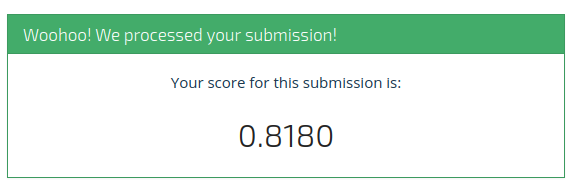

This is, as expected, slightly better than the submission for a random forest. It should be noted that the additional computational resources and training time an ensemble needs, is not worth the small accuracy and stability gain we achieved in practice. For the sake of the competition, however, this model was selected as our best-performing one.

## kNN with PCA

In part 2 we tested a kNN model on the preprocessed, scaled dataset with 80 features selected using mRMR. It was remarkable that the accuracy reached higher than 77%, which is as good (or even better) as the ANN performed. As kNN is a simple, fast model it would be interesting to see if we could increase this accuracy further using an extra preprocessing technique.   
A technique that comes to mind is PCA, as it combines features to an optimal, lower dimensional set. Since kNN is known to suffer from the curse of high dimensionality, the effects of PCA seemed interesting to investigate.

A grid search was performed to see which number of neighbours and what amount of principal components performs best.

- The number of principal components we tested are: (30, 40, 50, 60, 70, 80)
- The number of neighbours we tested are : (4, 5, 6, 7, 8, 9, 10)

PCA will be performed on the one-hot encoded dataset which is not normalized (our PCA library already normalizes the data internally). For better comparison with our kNN model in part 2, we only used 80 features selected by mRMR as input.

In [229]:
n_components <- c(30,40,50,60,70,80)
n_neighbours <- c(4,5,6,7,8,9,10)

The helper function below will perform cross validation on a model that applies PCA before performing the normal kNN behaviour. The hyperparameters to be provided are:

1: The number of neighbours to be used in kNN.  
2: The number of principal components to keep after applying PCA.

In [230]:
# helper function for specifically crossvalidating kNN with PCA
# same concept as the general execute_crossvalidation helper function
execute_kNN_PCA_crossvalidation <- function(n_folds, Dn, n_neighbors, n_components){
    # total number of training samples
    N <- nrow(Dn)

    # shuffle data randomly
    Dn <- Dn[sample(1:N),]

    # get the training data x and y
    Dn.x <- subset(Dn, select=-c(status_group))
    Dn.y <- Dn$status_group

    size_CV <- floor(N/n_folds)
    CV_accuracy <- numeric(n_folds)

    for (i in 1:n_folds) {
        print(paste(" - Testing fold = ", i))
        
        # idx_tst represents the indices of the test set for the i-th fold
        idx_tst <- (((i-1)*size_CV+1):(i*size_CV))  
        # idx_tr represents the indices of the training set for the i-th fold
        idx_tr <- setdiff(1:N,idx_tst) 
        
        Dn.train <- Dn.x[idx_tr,]
        Dn.train.labels <- Dn.y[idx_tr]
        Dn.test <- Dn.x[idx_tst,]
       
        # apply PCA (on training data and then on test data with this info)
        pca_info <- prcomp(Dn.train, scale=TRUE, center=TRUE)
        Dn.test <- predict(pca_info, Dn.test)[,1:n_components]
        Dn.train <-  pca_info$x[,1:n_components]
        
        # make the predictions
        Yhat <- knn(train=Dn.train, test=Dn.test,
                    cl=Dn.train.labels, k=n_neighbors)

        # store the accuracy
        CV_accuracy[i] <- calculate_accuracy(Dn[idx_tst, 'status_group'], Yhat)
    }
    
    return(list(accuracy=mean(CV_accuracy), stddev=sd(CV_accuracy)))
}

**Grid Search**

Below you can find the code for a simple grid search, trying out each specified combination of neighbours and number of principal components to keep.

In [231]:
if (RUN_LONG_COMPUTATIONS) {
    set.seed(1705)
    
    # read in the preprocessed data
    preprocessed <- readRDS("preprocessed/mrmr80_one_hot_train_preprocessed.rds")
    results <- list()
    best_pair <- c(0,0)
    best_acc <- 0

    # outer loop to go over the number of components
    for (i in 1:length(n_components)){
        cv_accuracy <- numeric()
        cv_sdev <- numeric()
        
        # inner loop to go over the number of neighbours
        for (k in n_neighbours){
            # perform 5-fold cross-validation
            cv_info <- execute_kNN_PCA_crossvalidation(5, preprocessed, k, n_components[i])
            cv_accuracy <- c(cv_accuracy,cv_info$accuracy)
            cv_sdev <- c(cv_sdev,cv_info$stddev)
            
            # keep track of the best-performing hyperparameter combination (based on accuracy)
            if (cv_info$accuracy > best_acc){
                best_acc <- cv_info$accuracy
                best_pair <- c(n_components[i], k)
            }
        }
        
        df <- data.frame(neighbours=n_neighbours, results_accuracy=cv_accuracy, sd=cv_sdev)
        results[[i]] <- df
    }
    
    # save the results
    saveRDS(results, "model_results/knn_pca/knn_pca_results.RDS")
}

# read the results back in
Dn <- readRDS("model_results/knn_pca/knn_pca_results.RDS")

## Analysis

The best results were achieved with the first **50 principal components** and kNN with **k = 5**. The achieved accuracy is: **77,3% +/- 0.3**.

In [232]:
# calculate the average accuracy for each k value (averaged over all specified kept n_components)
neig_acc_sum <- numeric(length(n_neighbours))
for (i in Dn){
    for (j in 1:length(n_neighbours)){
        neig_acc_sum[j] <- neig_acc_sum[j] + i[[2]][j]
    }
}

avg_neigh_acc <- neig_acc_sum/length(n_components)

# print the k value with the best averaged accuracy
print(paste("Best k value:", n_neighbours[which(avg_neigh_acc==max(avg_neigh_acc))]))

[1] "Best k value: 5"


We also see that the best-performing number of neighbours after applying PCA seems to be 5. Below we will plot the accuracy in function of the number of principal components when performing kNN with k=5 to further investigate the effects of PCA.

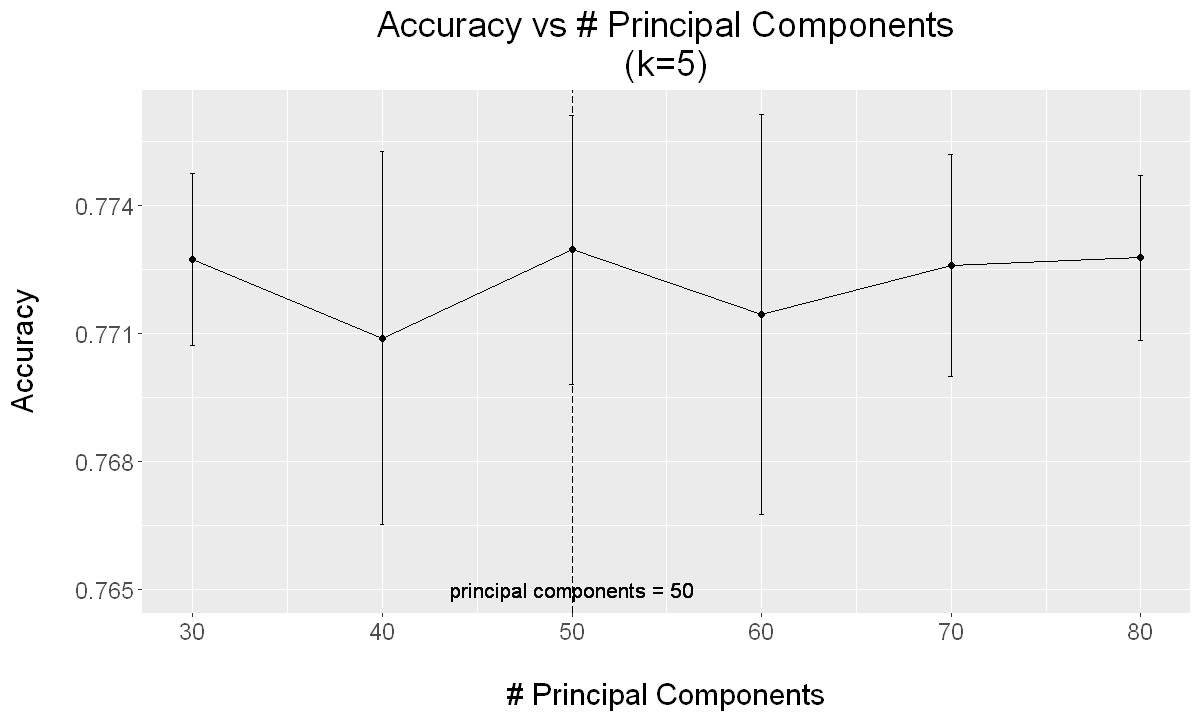

In [233]:
m_accuracy <- c()
m_sd <- c()

# get the mean accuracies and standard deviations for k=5
for (i in Dn){
    m_accuracy <- c(m_accuracy, i[[2]][2])
    m_sd <- c(m_sd, i[[3]][2])
}

Dn_k5 <- data.frame(Principal_components=n_components, accuracy=m_accuracy, sd=m_sd)

Dn.x <- Dn_k5$Principal_components
Dn.y <- Dn_k5$accuracy	
y.sd <- Dn_k5$sd

# plot results
options(repr.plot.width=10, repr.plot.height=6)  
ggplot(Dn_k5,aes(x = Dn.x, y= Dn.y)) +
    geom_line() + 
    geom_point() +
    geom_errorbar(aes(x=Dn.x, ymin=Dn.y-y.sd, ymax=Dn.y+y.sd), width=0.25) +
    geom_vline(xintercept=c(50), linetype="longdash") +
    geom_text(aes(x=50, label="principal components = 50", y=0.765), size=4.5) +
    labs(title = "Accuracy vs # Principal Components\n(k=5)", y = "Accuracy\n", x = "\n# Principal Components") +
    theme(plot.title = element_text(hjust = 0.5),
          text = element_text(size=18))

We see from this plot that the results are very similar overall. The fluctuations in performance are possibly just caused by noise, so there is no number of principal components that clearly performs better. However, it is important to note that using only 30 components gives a similar accuracy as using 50-80 components but needs less memory and prediction time.

The kNN model is a relatively simple model but the accuracy is still quite good. Performing PCA on this model doesn't show that much influence on accuracy, but it will make the model more efficient. The fact that we apply PCA does make the model less interpretable though, which is also a downside.

# Conclusions

During our search for the most suitable model for the problem of predicting the functionality status of Tanzanian water pumps, we performed an extensive feature analysis. The importance of this is clear by noting that we were able to halve the number of features while still having a good accuracy score with our different models. A lot of redundant data was present and a lot of missing or incorrect data needed to be fixed. Transforming some features helped us make data more informative or simply easier to interpret.

After analysing and preprocessing our data, a lot of different models were tested. We started with relatively simple models like ElasticNet, kNN and Decision Trees to then gradually move to more complex models like SVM, Neural Networks, Random Forest and Gradient Boosting Trees. Finally we developed some ensemble models combining our best performing predictors, namely random forests and gradient boosting trees. The "no free lunch" principle was very present in this whole process. Some relatively simple models like kNN were already able to make good predictions, while more complex strategies like majority voting only provided minor gains and needed much more computational resources and time. This is why trying out a big variety of models was so important.

Furthermore, the effects of class imbalance were very clear as well. All models had bad performance when it comes to predictions on the minority class. Since accuracy is the main focus, this isn't that deleterious for our results but if the focus of quality would shift it is definitely a problem that needs to be addressed.

Moreover, it was clear that overall our tree-based methods seemed to perform the best when it comes to classification accuracy. In the case of decision trees and random forests this could be because they can better exploit the categorical features. In the case of gradient boosting trees and ensemble models this might be because they just used more complex strategies than other models.

Finally, we ended up selecting an ensemble of random forests and gradient boosting trees as our final model. This ensemble had an acceptable computational training and prediction time, stable results and a submission score of 81.80%

# References

Breiman, L. (2001). Random Forests. Machine Learning, 45(1), 5–32. https://doi.org/10.1023/A:1010933404324

Chen, T., & Guestrin, C. (2016). XGBoost: A Scalable Tree Boosting System. Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining, 785–794. https://doi.org/10.1145/2939672.2939785



Hastie, T., Qian, J., & Tay, K. (2021, February 12). An Introduction to glmnet. https://glmnet.stanford.edu/articles/glmnet.html#multinomial-regression-family-multinomial-

Kyessi, A. (2005). Community-Based Urban Water Management in Fringe Neighbourhoods: The Case of Dar es Salaam, Tanzania. Habitat International, 29, 1–25. https://doi.org/10.1016/S0197-3975(03)00059-6

Milnes, M. (2010). The Mathematics of Pumping Water. The Royal Academy of Engineering. https://www.stem.org.uk/resources/elibrary/resource/25398/mathematics-pumping-water

National Bureau of Statistics. (2012). 2012 Population and housing census: Population Distribution by Administrative Areas. https://web.archive.org/web/20130502230453/http://www.nbs.go.tz/sensa/PDF/Census%20General%20Report%20-%2029%20March%202013_Combined_Final%20for%20Printing.pdf.

Rokach, L., & Maimon, O. (2005). Top-down induction of decision trees classifiers—A survey. IEEE Transactions on Systems, Man, and Cybernetics, Part C (Applications and Reviews), 35(4), 476–487. https://doi.org/10.1109/TSMCC.2004.843247

rpart function - RDocumentation. (2021). Retrieved May 7, 2021, from https://www.rdocumentation.org/packages/rpart/versions/4.1-15/topics/rpart

Shadrack, J. (2010, May). Local Government Authorities In Tanzania. http://jabashadrack.blogspot.com/2010/05/local-government-authorities-in.html

World Weather & Climate Information. (2021). Climate and average weather in Tanzania. https://weather-and-climate.com:80/average-monthly-Rainfall-Temperature-Sunshine-in-Tanzania